# Requirements

In [1]:
import os, sys

pkg_path = 'D:\\Projects\\System_Trading\\JnQ\\'

os.chdir(pkg_path)

# mpl_finance_path = 'D:\\python\\python38_1\\projects\\JnQ\\mpl_finance'
# ta_lib_path = 'D:\\python\\python38_1\\projects\\JnQ\\ta_lib'
funcs_path = pkg_path + 'funcs'

if funcs_path not in sys.path:

  try:
    # sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/JnQ')
    sys.path.insert(0, pkg_path + 'Bank')
    sys.path.insert(0, funcs_path)
    # sys.path.insert(0, mpl_finance_path)
    # sys.path.insert(0, ta_lib_path)
    
  except Exception as e:
    print(e)

In [2]:
import os
import talib
from funcs.public.idep import *
from funcs.public.plot_check import *
from funcs.public.en_ex_pairing import *
from funcs.public.indicator import *
from funcs.public.broker import *
from ast import literal_eval
import logging
import importlib

import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import scipy.stats as stats

import pickle
import shutil
import json
from easydict import EasyDict
import copy

import datetime
from datetime import datetime
import random
import time
# import warnings

# warnings.simplefilter("ignore", category=RuntimeWarning)

np.seterr(invalid="ignore")
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=2000) 

pd.set_option('mode.chained_assignment',  None)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Database work

## Data sync_check

In [36]:
def filter_savgol_ud_broad(ltf_df, htf_df, period=51, polyorder=3, backing_i=1):
    close = htf_df['close'].to_numpy()

    len_df = len(htf_df)
    realtime_ud = np.full(len_df, np.nan)

    for i in range(period, len_df):
        res = savgol_filter(close[i + 1 - period:i + 1], period, polyorder)
        realtime_ud[i] = 1 if res[-1] > res[-2] else 0

    interval = pd.infer_freq(htf_df.index)

    htf_df['realtime_ud_{}{}{}'.format(interval, period, polyorder)] = realtime_ud

    ud_series = htf_df['realtime_ud_{}{}{}'.format(interval, period, polyorder)]
    htf_df['buy_{}{}{}'.format(interval, period, polyorder)] = ud_series.shift(1) < ud_series
    htf_df['sell_{}{}{}'.format(interval, period, polyorder)] = ud_series.shift(1) > ud_series

    if interval not in ['T', '1m']:
        return ltf_df.join(to_lower_tf_v4(ltf_df, htf_df, htf_df.columns[-3:], ltf_itv='T', backing_i=backing_i), how='inner')
    else:
        ltf_df['realtime_ud__{}{}{}'.format(interval, period, polyorder)] = htf_df['realtime_ud__{}{}{}'.format(interval, period, polyorder)]
        ltf_df['buy__{}{}{}'.format(interval, period, polyorder)] = htf_df['buy__{}{}{}'.format(interval, period, polyorder)]
        ltf_df['sell__{}{}{}'.format(interval, period, polyorder)] = htf_df['sell__{}{}{}'.format(interval, period, polyorder)]
        return ltf_df

In [37]:
def sync_check_make(df):

    make_itv_list = ['3T', '5T', '15T', '30T', 'H', '4H', 'D']
    offset_list = ['1h', '1h', '1h', '1h', '1h', '1h', '9h']

    assert len(make_itv_list) == len(offset_list), "length of itv & offset_list should be equal"
        
    htf_df_list = [to_htf(df, itv=itv_, offset=offset_) for itv_, offset_ in zip(make_itv_list, offset_list)]

    df_3T, df_5T, df_15T, df_30T, df_H, df_4H, df_D = htf_df_list

    for htf_df in htf_df_list:
      print("{} -> ".format(pd.infer_freq(htf_df.index)), htf_df.tail(1))

    # heikinashi_v2(res_df_)
    
    # h_candle_v3(df, df_5T, '5T')
    
    # df = h_candle_v4(df, df_5T)
    # df = h_candle_v4(df, df_15T)
    # df = h_candle_v4(df, df_30T)
    # df = h_candle_v4(df, df_45T)
    # df = h_candle_v4(df, df_H)
    # df = h_candle_v4(df, df_4H)
    # df = h_candle_v4(df, 'D')

    # df = candle_pattern_pkg(df, df_5T)
    # df = candle_pattern_pkg(df, df_30T)
    # df = candle_pattern_pkg(df, df_H)
    # df = candle_pattern_pkg(df, df_4H)
    
    # df = filter_savgol_ud_broad(df, df_15T, period=51, polyorder=3)
    # df = filter_savgol_ud_broad(df, df_30T, period=51, polyorder=3)
    df = filter_savgol_ud_broad(df, df_15T, period=66, polyorder=3, backing_i=0)
    # df = filter_savgol_ud_broad(df, df_H, period=51, polyorder=3)
    print("filter_savgol_ud_broad phase done")
    
    # --------------- stochastic --------------- #
    # df = stoch_v2(df)
    # df_5T['stoch'] = stoch(df_5T, 13, 3, 3)
    # df = df.join(pd.DataFrame(index=df.index, data=to_lower_tf_v2(df, df_5T, [-1], backing_i=-1), columns=['stoch_5m']))

    # print("stoch phase done")
    
    # --------------- supertrend --------------- #
#     df = st_price_line(df, df_15T)
#     df = st_level(df, '15T', 1)
    
#     df = st_price_line(df, df_4H)
#     df = st_level(df, '4H', 1)

#     print("supertrend phase done")

    # --------------- ma --------------- #  
    # df = ma(df, 60)
    # print("ma phase done")

    # df = macd_hist(df, 5, 35, 15)
    # print("macd_hist phase done")
    
    # df = enough_space(df, '15T', 1)
    
    # --------------- dc --------------- #  
    dc_period = 500
    # df = donchian_channel_v4(df, dc_period)
    # df = dc_line(df, df_5T, '5T')  # join 사용시에만 return df 허용함
    # df = dc_line(df, df_15T, '15T')
    # df = dc_line_v2(df, df_H, 'H', dc_period=5)

    # df = dc_line_v4(df, df, dc_period=10)
    # df = dc_line_v4(df, df, dc_period=20)
    # df = dc_line_v4(df, df, dc_period=100)
    # df = dc_line_v4(df, df_5T, dc_period=20)
    # df = dc_line_v4(df, df_15T, dc_period=20)
    # df = dc_line_v4(df, df_H, dc_period=20)
    # df = dc_line_v4(df, df_4H, dc_period=20)
    # print("dc phase done")

    # --------------- bb --------------- #  
    bb_period = 200

    # upper, base, lower = talib.BBANDS(res_df_.close, timeperiod=20, nbdevup=1, nbdevdn=1, matype=0)
        
    # df = bb_width_v3(df, period=bb_period, multiple=1, itv='T')
    # df = bb_level_v2(df, 'T', bb_period)
        
    # 1. Stock 을 위한 bb setting 아직 정립되지 않음. to_lower_tf 라든지.
    # df = bb_line_v3(df, df_15T, 20)    
    # df = bb_line_v3(df, df, bb_period)
    # print("bb phase done")

    c_itv = '5T'

    # df =  wick_ratio(df, c_itv)
    # df =  wick_ratio(df, c_itv)

    bb_itv= 'T'

    # df = candle_range_ratio(df, c_itv, bb_itv, bb_period)
    # # candle_pumping_ratio(df, c_itv, bb_itv, bb_period)

    dc_itv= '15T'
    dc_period = 4
    # df = candle_pumping_ratio_v2(df, c_itv, dc_itv, dc_period)
    # print("candle_pumping_ratio_v2 phase done")

    # df = dc_over_body_ratio(df, c_itv, dc_itv, dc_period)
    # print("dc_over_body_ratio phase done")

    # df = body_rel_ratio(df, c_itv)
    # print("body_rel_ratio phase done")

    # --------------- cbline --------------- #    
    # cloud_bline(df_3T, 20)
    # df = df.join(to_lower_tf_v2(df, df_3T, [-1]), how='inner')
    # # cloud_bline(df_5T, 20)
    # # df = df.join(to_lower_tf_v2(df, df_5T, [-1]), how='inner')
    # cloud_bline(df_15T, 20)
    # df = df.join(to_lower_tf_v2(df, df_15T, [-1]), how='inner')
    # cloud_bline(df_30T, 20)
    # df = df.join(to_lower_tf_v2(df, df_30T, [-1]), how='inner')
    # cloud_bline(df_H, 20)
    # df = df.join(to_lower_tf_v2(df, df_H, [-1]), how='inner')
    # cloud_bline(df_4H, 20)
    # df = df.join(to_lower_tf_v2(df, df_4H, [-1]), how='inner')

    # print("cbline phase done")



    # --------------- sd_dc --------------- #
    # df = sd_dc(df, 20, 40)
    # df = sd_dc(df, 20, 20)
    # df = sd_dc(df_5T, 20, 40, df)
    # df = sd_dc(df_H, 20, 40, df)

    # print("sd_dc phase done")

    # --------------- imb_ratio --------------- #
    # imb_ratio(df, '5T')
    # imb_ratio_v3(df, "5T")
    # imb_ratio_v4(df, "5T")

    # imb_ratio(df, 'H')
    # imb_ratio_v2(df, '5T')
    
    # print("imb_ratio phase done")

    # --------------- rel_abs_ratio --------------- #
    # rel_abs_ratio(df, '5T', norm_period=120)

    # --------------- normalize data --------------- #
    # itv = 'T'
    # lb_period = 15
    # target_col = 'close_{}{}'.format(itv, lb_period)
    # target_data = df['close'].diff(lb_period).to_numpy()
    # norm_data(df, target_data, target_col)    
    # print("normalize data phase done !")

    # --------------- lucid sar --------------- #
    # lucid_sar_v2(df)
    # lucid_sar_v2(df_3T)
    # df = df.join(to_lower_tf_v2(df, df_3T, [-2, -1]), how='inner')
    # lucid_sar_v2(df_5T)
    # df = df.join(to_lower_tf_v2(df, df_5T, [-2, -1]), how='inner')
    # lucid_sar_v2(df_15T)
    # df = df.join(to_lower_tf_v2(df, df_15T, [-2, -1]), how='inner')
    # lucid_sar_v2(df_30T)
    # df = df.join(to_lower_tf_v2(df, df_30T, [-2, -1]), how='inner')       

    # print("sar phase done")


    # --------------- rsi --------------- #  
    # df['rsi_1m'] = rsi(df, 14)    
    # df_5T['rsi_5m'] = rsi(df_5T, 14)
    # df = df.join(pd.DataFrame(index=df.index, data=to_lower_tf_v2(df, df_5T, [-1]), columns=['rsi_5m']))
    
    # print("rsi phase done")


    # --------------- cci --------------- #  
    # df['cci_1m'] = cci(df, 20)

    # print("cci phase done")

    # --------------- ema --------------- #      
    # df_5T['ema_5m'] = ema(df_5T['close'], 195)
    # df = df.join(pd.DataFrame(index=df.index, data=to_lower_tf_v2(df, df_5T, [-1]), columns=['ema_5m']))
    
    # print("ema phase done")        


    return df


### main

In [38]:
res_df_ = sync_check_make(res_df_)  # suffix duplication 유의
res_df_.tail().iloc[:, -10:]
# res_df_.dtypes

3T ->                         open    high    low   close
index                                             
2023-02-21 13:42:00  0.5121  0.5133  0.512  0.5126
5T ->                         open    high    low   close
index                                             
2023-02-21 13:40:00  0.5113  0.5133  0.511  0.5126
15T ->                         open   high    low   close
index                                            
2023-02-21 13:30:00  0.5169  0.517  0.511  0.5126
30T ->                         open   high    low   close
index                                            
2023-02-21 13:30:00  0.5169  0.517  0.511  0.5126
H ->                         open    high    low   close
index                                             
2023-02-21 13:00:00  0.5183  0.5205  0.511  0.5126
4H ->                         open    high    low   close
index                                             
2023-02-21 13:00:00  0.5183  0.5205  0.511  0.5126
D ->                         open    high    

D:\Projects\System_Trading\JnQ\funcs\public\broker.py:320: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  htf_df = htf_df.append(renamed_last_row)


filter_savgol_ud_broad phase done


,sell_15T303,realtime_ud_15T483,buy_15T483,sell_15T483,realtime_ud_15T213,buy_15T213,sell_15T213,realtime_ud_15T663,buy_15T663,sell_15T663
index,,,,,,,,,,
2023-02-21 13:39:59.999,False,1.0,False,False,0.0,False,False,1.0,False,False
2023-02-21 13:40:59.999,False,1.0,False,False,0.0,False,False,1.0,False,False
2023-02-21 13:41:59.999,False,1.0,False,False,0.0,False,False,1.0,False,False
2023-02-21 13:42:59.999,False,1.0,False,False,0.0,False,False,1.0,False,False
2023-02-21 13:43:59.999,False,1.0,False,False,0.0,False,False,1.0,False,False


In [ ]:
# test_df_ = sync_check_make(res_df_.iloc[-4000:])  # suffix duplication 유의
# test_df_.tail().iloc[:, -10:]

In [ ]:
# ------ validation ------ #
# res_df_.cppr_15T.describe()
print((res_df_.open_15T.to_numpy() - res_df_.close_15T.to_numpy())[-10:])
print((res_df_.dc_upper_15T4.to_numpy() - res_df_.dc_lower_15T4.to_numpy())[-10:])

In [ ]:
# np.where(res_df_.CDL3LINESTRIKE_15T) #.iloc[-1000:,]

# CDL3LINESTRIKE = talib.CDL3LINESTRIKE(df_15T.open, df_15T.high, df_15T.low, df_15T.close)
for col in talib.get_function_groups()['Pattern Recognition']:  
  print(np.unique(res_df_[col + '_15T'].to_numpy(), return_counts=True))

# CDLCLOSINGMARUBOZU = talib.CDLCLOSINGMARUBOZU(df_15T.open, df_15T.high, df_15T.low, df_15T.close)
# print(np.unique(CDLCLOSINGMARUBOZU.to_numpy(), return_counts=True))
# print(CDLCLOSINGMARUBOZU.tail(50))

In [36]:
"""
save current res_df 
"""

res_df_.reset_index().to_feather(data_path, compression='lz4')  # key 잘 확인하고 저장
print(data_path, 'saved !')

D:\Projects\System_Trading\JnQ\database/binance/cum\2023-02-21\2023-02-21 FTMUSDT_1m.ftr saved !


## Data concatenation

### Row concatenation (Feather version)

In [ ]:
db_path = 'database/binance/'

ticker = "BTCUSDT_1m.ftr"

old_dir = 'non_cum'
old_date = '2021-03-23'  # earlier

new_dir = 'non_cum'
new_date = '2023-02-21'  # latest

old_path = os.path.join(pkg_path, db_path,  old_dir, old_date, " ".join([cum_date, ticker]))
new_path = os.path.join(pkg_path, db_path, new_dir, new_date, " ".join([non_cum_date, ticker]))

old_df = pd.read_feather(old_path, columns=None, use_threads=True).set_index("index")   # key 에 new_date 담겨있음
new_df = pd.read_feather(new_path, columns=None, use_threads=True).set_index("index")

sum_df = pd.concat([old_df, new_df])
sum_df = sum_df[~sum_df.index.duplicated(keep='last')]

In [ ]:
np_idx_ts = np.array(list(map(lambda x: datetime.timestamp(x), sum_df.index)))
ideal_ts_gap = 60 # * itv_num

for ts_i in range(len(np_idx_ts)):

  if ts_i != 0:
    ts_gap = np_idx_ts[ts_i] - np_idx_ts[ts_i - 1]
    
    if ts_gap > ideal_ts_gap or ts_gap < ideal_ts_gap:
    # if ts_gap == ideal_ts_gap:  # logic 정상성 확인을 위함.
        
      print("unideal ts_gap : {} {}".format(sum_df.index[ts_i - 1], sum_df.index[ts_i]))

print("continuity check done")

In [ ]:
database_dir_save_path = os.path.join(pkg_path, db_path,  "cum", new_date)
os.makedirs(database_dir_save_path, exist_ok=True)

data_save_path = os.path.join(database_dir_save_path, " ".join([new_date, ticker]))
sum_df.reset_index().to_feather(data_save_path, compression='lz4')

print("{} saved".format(data_save_path))

#### on multiple ticker

In [ ]:
def row_concate(db_path, ticker, old_dir, new_dir, old_date, new_date):    
    
    old_path = os.path.join(pkg_path, db_path,  old_dir, old_date, " ".join([old_date, ticker]))
    new_path = os.path.join(pkg_path, db_path, new_dir, new_date, " ".join([new_date, ticker]))

    try:
        old_df = pd.read_feather(old_path, columns=None, use_threads=True).set_index("index")   # key 에 new_date 담겨있음
        new_df = pd.read_feather(new_path, columns=None, use_threads=True).set_index("index")
    
    except Exception as e:
        print(e)
        return

    sum_df = pd.concat([old_df, new_df])
    sum_df = sum_df[~sum_df.index.duplicated(keep='last')]
    
    np_idx_ts = np.array(list(map(lambda x: datetime.timestamp(x), sum_df.index)))
    ideal_ts_gap = 60 # * itv_num

    for ts_i in range(len(np_idx_ts)):

      if ts_i != 0:
        ts_gap = np_idx_ts[ts_i] - np_idx_ts[ts_i - 1]

        if ts_gap > ideal_ts_gap or ts_gap < ideal_ts_gap:
        # if ts_gap == ideal_ts_gap:  # logic 정상성 확인을 위함.

          print("unideal ts_gap : {} {}".format(sum_df.index[ts_i - 1], sum_df.index[ts_i]))

    print("continuity check done")
    
    database_dir_save_path = os.path.join(pkg_path, db_path,  "cum", new_date)
    os.makedirs(database_dir_save_path, exist_ok=True)

    data_save_path = os.path.join(database_dir_save_path, " ".join([new_date, ticker]))
    sum_df.reset_index().to_feather(data_save_path, compression='lz4')

    print("{} saved".format(data_save_path))

In [ ]:
db_path = 'database/binance/'

old_dir = 'non_cum'
old_date = '2021-03-23'  # earlier

new_dir = 'non_cum'
new_date = '2023-02-21'  # latest

ticker_list = [ticker_.split(" ")[-1] for ticker_ in os.listdir(os.path.join(pkg_path, db_path,  old_dir, old_date))]

for ticker in ticker_list:
    row_concate(db_path, ticker, old_dir, new_dir, old_date, new_date)

### Column concatenation (Feather version)

In [ ]:
new_dir_path = "st3m_backi2"
base_dir_path = "bb1d_backi2"

# new_date = "2021-11-17"
new_date = "2022-01-10"

#     save to (new) concat dir    #
#      1. if dir. not exists, makedir
save_path = './candlestick_concated/res_df/'
save_path = os.path.join(save_path, new_dir_path, "concat/cum", new_date)   
# save_path = os.path.join(save_path, new_dir_path, "concat/non_cum", new_date)   # row col 하려면 concat 맞음, noncum 사용
os.makedirs(save_path, exist_ok=True)


#     load ftr list    #
# ftr_list = [s for s in os.listdir(os.path.join(save_path, new_dir_path)) if "ftr" in s]

noncat_path = save_path.replace("concat/", "noncat/")
ftr_list = [s for s in os.listdir(noncat_path) if "ftr" in s]
print(ftr_list)
# break


for key in ftr_list:

  if new_date not in key:
    continue

  try:

    #       read from base postfix's directory    #
    base_df = pd.read_feather(os.path.join(save_path.replace(new_dir_path, base_dir_path), key), columns=None, use_threads=True).set_index("index")
    res_df = pd.read_feather(os.path.join(noncat_path, key), columns=None, use_threads=True).set_index("index")

    # print(base_df.head())
    # print(res_df.head())
    # break

    new_res_df = pd.concat([base_df, res_df], axis=1) # df_tot.drop_duplicates()
    # new_res_df.head()

    droped_new_res_df = new_res_df.loc[:,~new_res_df.columns.duplicated(keep='last')]
    # droped_new_res_df.head()
    # break

    droped_new_res_df.reset_index().to_feather(os.path.join(save_path, key), compression='lz4')

    # res_df_dict[key] = res_df
    # res_df_dict[key] = droped_new_res_df
    print(os.path.join(save_path, key), "saved !")
  
  except Exception as e:
    print("error occured ! :", e)
  

  # sample_cnt -= 1

  # if sample_cnt <= 0:
  #   break


### Check continuity

In [ ]:
droped_new_res_df = res_df_

In [ ]:
# print(droped_new_res_df.columns)

print(droped_new_res_df.iloc[[0, -1]])

np_idx_ts = np.array(list(map(lambda x: datetime.timestamp(x), droped_new_res_df.index)))

print(np_idx_ts[:10])
for ts_i in range(len(np_idx_ts)):
  
  if ts_i != 0:
    ts_gap = np_idx_ts[ts_i] - np_idx_ts[ts_i - 1]

    if ts_gap > 60 or ts_gap < 60:

      print("invalid ts_gap found !")
    # if ts_gap == 60:
      print(droped_new_res_df.index[ts_i - 1])
      print(droped_new_res_df.index[ts_i])
      # print(ts_gap)
      print()


### Check length of front missing value & middle_data non_missing validity

## Lab

### instant indi.

In [91]:
res_df_15T_ = to_htf(res_df_.close, '15T', '1h')
# s = res_df_15T_.close.values.flatten()[: 10000]  # initial timeseries data

#### savgol

In [94]:
rand_int = np.random.randint(20000)

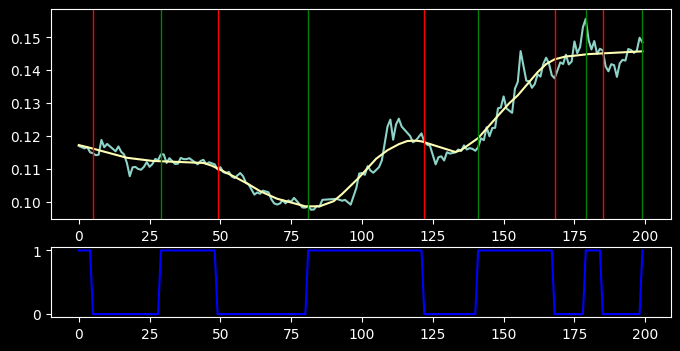

In [96]:
s = res_df_15T_.close.values.flatten()[rand_int:rand_int + 1000]  # initial timeseries data

flag_size = 200

realtime_filter = []
realtime_ud = []

# 1. realtime filter. --> get updown data.
window = 51
polyorder = 3
sigma = 10
type = 'savgol' # gaussian savgol

for i in range(-flag_size, 0):
    if i == -1:
        data = s[i + 1 -flag_size:]
    else:        
        data = s[i + 1 -flag_size:i + 1]
        
    if type == 'savgol':
        res = savgol_filter(data, window, polyorder)
    else:
        res = gaussian_filter1d(data, sigma=sigma)
        
    updown = 1 if res[-1] > res[-2] else 0
    realtime_ud.append(updown)

realtime_ud_series = pd.Series(realtime_ud)
buy_point = np.where(realtime_ud_series.shift(1) < realtime_ud_series)[0]
sell_point = np.where(realtime_ud_series.shift(1) > realtime_ud_series)[0]

fig, ax = plt.subplots(2, 1, figsize=(8, 4), gridspec_kw={'height_ratios': [3, 1]})

plt.subplot(211)
plt.plot(s[-flag_size:])
plt.plot(savgol_filter(s, window, polyorder)[-flag_size:])
# plt.plot(savgol_filter(s[-flag_size:], 51, 3), 'r')
[plt.axvline(x_, 0., 1, color='g', linestyle='-', linewidth=1) for x_ in buy_point]
[plt.axvline(x_, 0., 1, color='r', linestyle='-', linewidth=1) for x_ in sell_point]
# ax.fill_between(np.arange(flag_size), np.min(s[-flag_size:]), np.max(s[-flag_size:]), where=np.array(realtime_filter) == 1,
#                 facecolor='green', alpha=0.5, transform=ax.get_xaxis_transform())
# ax.fill_between(np.arange(flag_size), 0, 1, where=np.array(realtime_filter) == 1,
#                 facecolor='green', alpha=0.5, transform=trans)

plt.subplot(212)
plt.plot(realtime_ud, 'blue')
plt.show()

#### lowess

In [295]:
noisy_data = s[-100:]
noisy_data2 = s[-1000:]

# lowess_tight = lowess(s, in_array, frac = .12)
# lowess_loose = lowess(s, in_array, frac = .2)

lowess_tight = lowess(noisy_data, np.arange(len(noisy_data)), frac = .2)
lowess_tight2 = lowess(noisy_data2, np.arange(len(noisy_data2)), frac = .2)
# lowess_loose = lowess(noisy_data, in_array, frac = .2)

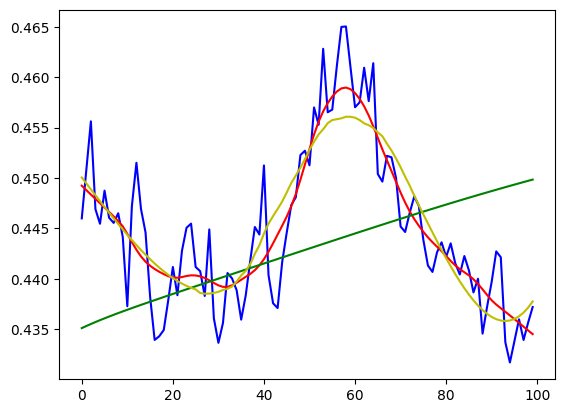

In [300]:
flag_size = 100

plt.plot(noisy_data[-flag_size:], 'b')

plt.plot(lowess_tight[-flag_size:][:, 1], 'r')
plt.plot(lowess_tight2[-flag_size:][:, 1], 'g')
plt.plot(savgol_filter(noisy_data[-flag_size:], 51, 3), 'y')

#### nlms

In [10]:
import padasip as pa

In [148]:
n = 3
x = pa.input_from_history(s, n)  # input matrix
N = len(x)
print(f'Total length of data: {len(s)}')
print(f'Total length of data (after delay): {N}')
d = np.zeros(len(x))

# define target
for i, k in enumerate(range((n-1), N)):
    d[i] = s[k + 1]  # d[0] = s[5] --> 0 ~ 4 의 idx 를 사용해 5's idx 의 prediction 을 만들어낸다.
    
print(len(d))
print(d[0])
print(x[0])

Total length of data: 10000
Total length of data (after delay): 9998
9998
0.035407
[0.03543  0.03561  0.035615]


In [ ]:
rand_int = np.random.randint(20000)

In [48]:
def plot_filter_result(pred: np.ndarray, actual: np.ndarray, error: np.ndarray, n: int,
                       mu_val: str='0.05', section_visual_flag: bool=True):
    _avg_error = round(np.mean(10*np.log10(error[: (len(error) - n)]**2)), 2)
    plt.figure(figsize=(12.5, 20))
    plt.subplot(411)
    plt.title(f'NLMS (mu={mu_val})')
    plt.xlabel('No of iteration [-]')
    plt.plot(actual[: (len(actual)-n)], 'b', label='target')
    plt.plot(pred[: (len(pred)-n)], 'g', label='predict / output')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.title(f'Filter error (avg: {_avg_error})')
    plt.plot(10*np.log10(error[: (len(error) - n)]**2), 'r', label='Error')
    plt.axhline(y=_avg_error, color='black', lw=1, linestyle='--')
    if section_visual_flag:
        flag_size = 300
        plt.subplot(413)
        plt.title('First flag_size iterations')
        plt.xlabel(None)
        plt.plot(actual[: flag_size], "b", label='target')
        plt.plot(pred[: flag_size], "g", label='predict / output')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.title('Last flag_size iterations')
        plt.xlabel(None)
        plt.plot(actual[(len(actual) - flag_size - n): (len(actual) - n)],
                 "b", label='target')
        plt.plot(pred[(len(pred) - flag_size - n): (len(pred) - n)],
                 "g", label='predict / output')
        plt.legend(loc='upper left')
        
    plt.tight_layout()
    plt.show()
    return None

In [ ]:
error_list = []
pa_list = []
for i, mu_ in enumerate(np.arange(0.01, 1, 0.05)):
    f_nlms = pa.filters.FilterNLMS(n=n, mu=mu_, w='random')
    y, e, w = f_nlms.run(d, x)
    plot_filter_result(pred=y, actual=d, error=e, mu_val=mu_, n=n)
    _avg_error = round(np.mean(10*np.log10(e[: (len(e) - n)]**2)), 2)
    pa_list.append(f_nlms)
    error_list.append(_avg_error)

In [ ]:
# N = 100
# log_d = np.zeros(N)
# log_y = np.zeros(N)
pred_list = []
filt = pa.filters.FilterLMS(3, mu=1.)
for k, close_ in enumerate(s):
    # measure input
    # predict new value
    pred_close_ = filt.predict(close_)
    # do the important stuff with prediction output
    # measure output
    # update filter
    filt.adapt(pred_close_, close_)
    # log values
    # log_d[k] = d
    # log_y[k] = y
    pred_list.append(pred_close_)

### show results
pred_arr = np.array(pred_list)

plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(s,"b", label="d - target")
plt.plot(pred_list,"g", label="y - output");plt.legend()
plt.subplot(212)
plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10((s-pred_arr)**2),"r", label="e - error [dB]")
plt.legend(); plt.tight_layout(); plt.show()

Selected the filter with mu of 0.36000000000000004
with avg eror of -76.14


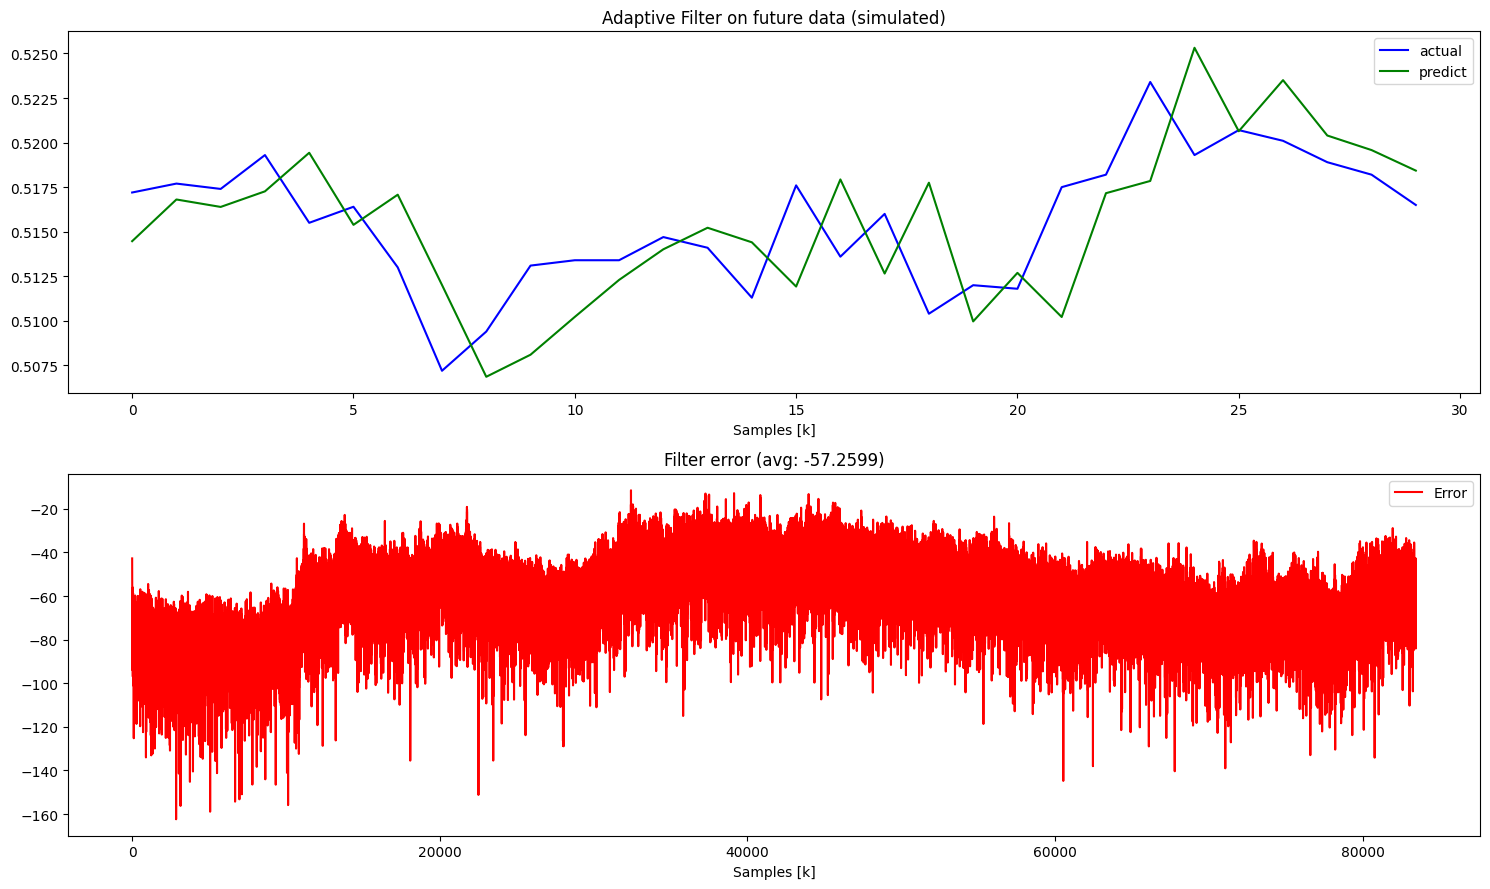

In [56]:
s_future = res_df_15T_.close.values.flatten()[1000: ] 
filter_min_error = pa_list[np.argmin(error_list)]
print(f'Selected the filter with mu of {filter_min_error.mu}')
print(f'with avg eror of {error_list[np.argmin(error_list)]}') 
x_future = pa.input_from_history(s_future, n)
d_future = np.zeros(len(x_future))
N_future = len(x_future)

for i, k in enumerate(range((n-1), N_future)):
    d_future[i] = s_future[k+1]

actual_list = np.zeros(N_future)
predict_list = np.zeros(N_future)

# Simulate real-time prediction and update the filter
for k in range(N_future):
    x_input = x_future[k]
    y = filter_min_error.predict(x_input)
    d_actual = d_future[k]
    filter_min_error.adapt(d_actual, x_input)
    actual_list[k] = d_actual
    predict_list[k] = y
    
## show results
flag_size = 30

avg_error = np.round(np.mean(10*np.log10((actual_list -predict_list)**2)), 4)
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("Adaptive Filter on future data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual_list[n: (len(actual_list)-n)][-flag_size:], "b", label="actual")
plt.plot(predict_list[n: (len(predict_list)-n)][-flag_size:], "g", label="predict")
plt.legend()
plt.subplot(212)
plt.title(f'Filter error (avg: {avg_error})')
plt.xlabel("Samples [k]")
plt.plot(10*np.log10((actual_list[n: (len(actual_list)-n)] - \
                      predict_list[n: (len(predict_list)-n)])**2), 
         "r", label="Error")
plt.legend()
plt.tight_layout()
plt.show()

### wave_range

In [ ]:
def get_wave_time_ratio(res_df, wave_itv1, wave_period1):

  wave_cu_post_idx_fill_ = res_df['wave_cu_post_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(int)
  wave_co_post_idx_fill_ = res_df['wave_co_post_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(int)

  wave_cu_idx_fill_ = res_df['wave_cu_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(int)
  wave_co_idx_fill_ = res_df['wave_co_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(int)

  wave_valid_cu_post_idx_fill_ = np.where(wave_cu_post_idx_fill_ < 0, 0, wave_cu_post_idx_fill_)
  wave_valid_co_post_idx_fill_ = np.where(wave_co_post_idx_fill_ < 0, 0, wave_co_post_idx_fill_)

  wave_valid_cu_idx_fill_ = np.where(wave_cu_idx_fill_ < 0, 0, wave_cu_idx_fill_)
  wave_valid_co_idx_fill_ = np.where(wave_co_idx_fill_ < 0, 0, wave_co_idx_fill_)

  res_df['short_wave_time_ratio_{}{}'.format(wave_itv1, wave_period1)] = (wave_valid_co_post_idx_fill_ - wave_valid_cu_post_idx_fill_[wave_valid_co_post_idx_fill_[wave_valid_cu_idx_fill_]]) / (wave_valid_cu_idx_fill_ - wave_valid_co_post_idx_fill_)
  res_df['long_wave_time_ratio_{}{}'.format(wave_itv1, wave_period1)] = (wave_valid_cu_post_idx_fill_ - wave_valid_co_post_idx_fill_[wave_valid_cu_post_idx_fill_[wave_valid_co_idx_fill_]]) / (wave_valid_co_idx_fill_ - wave_valid_cu_post_idx_fill_)

  return res_df

In [ ]:
def wave_range_cci_v4_1(t_df, wave_period):
    t_df = cci_v2(t_df, wave_period)
    itv = pd.infer_freq(t_df.index)

    cci_ = t_df['cci_{}{}'.format(itv, wave_period)].to_numpy()
    b1_cci_ = t_df['cci_{}{}'.format(itv, wave_period)].shift(1).to_numpy()

    baseline = 0
    band_width = 100
    upper_band = baseline + band_width
    lower_band = baseline - band_width

    data_cols = ['open', 'high', 'low', 'close']
    ohlc_list = [t_df[col_].to_numpy() for col_ in data_cols]
    open, high, low, close = ohlc_list

    # ============ modules ============ #
    # ------ define co, cu ------ # <- point missing 과 관련해 정교해아함
    cu_bool = (b1_cci_ > upper_band) & (upper_band > cci_)
    co_bool = (b1_cci_ < lower_band) & (lower_band < cci_)

    return wave_publics_v2(t_df, cu_bool, co_bool, ohlc_list, wave_period)

In [ ]:
def wave_publics_v2(t_df, cu_bool, co_bool, ohlc_list, wave_period):
    itv = pd.infer_freq(t_df.index)

    len_df = len(t_df)
    len_df_range = np.arange(len_df).astype(int)

    cu_idx = get_index_bybool(cu_bool, len_df_range)
    co_idx = get_index_bybool(co_bool, len_df_range)

    open, high, low, close = ohlc_list

    cu_fill_idx, co_fill_idx, cu_prime_idx, co_prime_idx, cu_prime_fill_idx, co_prime_fill_idx, valid_cu_bool, valid_co_bool = get_terms_info_v4(
        cu_idx, co_idx, len_df, len_df_range)
    # cu_fill_idx, co_fill_idx, cu_prime_idx, co_prime_idx, cu_prime_fill_idx, co_prime_fill_idx, \
    #   cu_post_idx, co_post_idx, cu_post_fill_idx, co_post_fill_idx, valid_cu_bool, valid_co_bool = get_terms_info_v5(cu_idx, co_idx, len_df, len_df_range)

    # ------ get post_terms ------ #
    high_post_terms = np.vstack((co_fill_idx[valid_cu_bool], cu_idx[valid_cu_bool])).T.astype(int)
    low_post_terms = np.vstack((cu_fill_idx[valid_co_bool], co_idx[valid_co_bool])).T.astype(int)

    high_post_terms_cnt = high_post_terms[:, 1] - high_post_terms[:, 0]
    low_post_terms_cnt = low_post_terms[:, 1] - low_post_terms[:, 0]

    # ------ get post_idx ------ #
    paired_cu_post_idx = high_post_terms[:, 1]  # Todo, 여기는 cross_idx (위에서 vstack 으로 cross_idx 입력함)
    paired_co_post_idx = low_post_terms[:, 1]

    cu_post_idx = np.full(len_df, np.nan)  # --> Todo, unavailable : not cross_idx
    co_post_idx = np.full(len_df, np.nan)

    cu_post_idx[paired_cu_post_idx] = paired_cu_post_idx
    co_post_idx[paired_co_post_idx] = paired_co_post_idx

    cu_post_fill_idx = fill_arr(cu_post_idx)
    co_post_fill_idx = fill_arr(co_post_idx)

    # ------ get prime_terms ------ # # 기본은 아래 logic 으로 수행하고, update_hl 도 해당 term 구간의 hl 이 더 작거나 클경우 적용 가능할 것
    # high_prime_terms = np.vstack((co_prime_fill_idx[valid_cu_bool], cu_idx[valid_cu_bool])).T.astype(int)
    # low_prime_terms = np.vstack((cu_prime_fill_idx[valid_co_bool], co_idx[valid_co_bool])).T.astype(int)

    # high_prime_terms_cnt = high_prime_terms[:, 1] - high_prime_terms[:, 0]
    # low_prime_terms_cnt = low_prime_terms[:, 1] - low_prime_terms[:, 0]

    # paired_prime_cu_idx = high_prime_terms[:, 1]
    # paired_prime_co_idx = low_prime_terms[:, 1]

    # ====== get wave_hl & terms ====== #
    wave_high_ = np.full(len_df, np.nan)
    wave_low_ = np.full(len_df, np.nan)

    wave_highs = np.array([high[iin:iout + 1].max() for iin, iout in high_post_terms])
    wave_lows = np.array([low[iin:iout + 1].min() for iin, iout in low_post_terms])

    wave_high_[paired_cu_post_idx] = wave_highs
    wave_low_[paired_co_post_idx] = wave_lows

    wave_high_fill_ = fill_arr(wave_high_)
    wave_low_fill_ = fill_arr(wave_low_)

    # ------ Todo, update_hl 에 대해서, post_terms_hl 적용 ------ #
    wave_high_terms_low_ = np.full(len_df, np.nan)
    wave_low_terms_high_ = np.full(len_df, np.nan)

    wave_high_terms_lows = np.array([low[iin:iout + 1].min() for iin, iout in high_post_terms])  # for point rejection, Todo, min_max 설정 항상 주의
    wave_low_terms_highs = np.array([high[iin:iout + 1].max() for iin, iout in low_post_terms])

    wave_high_terms_low_[paired_cu_post_idx] = wave_high_terms_lows
    wave_low_terms_high_[paired_co_post_idx] = wave_low_terms_highs

    update_low_cu_bool = wave_high_terms_low_ < wave_low_fill_
    update_high_co_bool = wave_low_terms_high_ > wave_high_fill_

    # ------ term cnt ------ #
    wave_high_terms_cnt_ = np.full(len_df, np.nan)
    wave_low_terms_cnt_ = np.full(len_df, np.nan)

    wave_high_terms_cnt_[paired_cu_post_idx] = high_post_terms_cnt
    wave_low_terms_cnt_[paired_co_post_idx] = low_post_terms_cnt

    wave_high_terms_cnt_fill_ = fill_arr(wave_high_terms_cnt_)
    wave_low_terms_cnt_fill_ = fill_arr(wave_low_terms_cnt_)

    # ------ hl_fill 의 prime_idx 를 찾아야함 ------ #
    # b1_wave_high_fill_ = pd.Series(wave_high_fill_).shift(1).to_numpy()
    # b1_wave_low_fill_ = pd.Series(wave_low_fill_).shift(1).to_numpy()
    # wave_high_prime_idx = np.where((wave_high_fill_ != b1_wave_high_fill_) & ~np.isnan(wave_high_fill_), len_df_range, np.nan)
    # wave_low_prime_idx = np.where((wave_low_fill_ != b1_wave_low_fill_) & ~np.isnan(wave_low_fill_), len_df_range, np.nan)
    #
    # high_prime_idx_fill_ = fill_arr(wave_high_prime_idx)
    # low_prime_idx_fill_ = fill_arr(wave_low_prime_idx)

    # ============ enlist to df_cols ============ #
    t_df['wave_high_fill_{}{}'.format(itv, wave_period)] = wave_high_fill_
    t_df['wave_low_fill_{}{}'.format(itv, wave_period)] = wave_low_fill_
    t_df['wave_high_terms_cnt_fill_{}{}'.format(itv, wave_period)] = wave_high_terms_cnt_fill_
    t_df['wave_low_terms_cnt_fill_{}{}'.format(itv, wave_period)] = wave_low_terms_cnt_fill_

    t_df['wave_update_low_cu_bool_{}{}'.format(itv, wave_period)] = update_low_cu_bool  # temporary, for plot_check
    t_df['wave_update_high_co_bool_{}{}'.format(itv, wave_period)] = update_high_co_bool

    t_df['wave_cu_{}{}'.format(itv, wave_period)] = cu_bool  # * ~update_low_cu_bool
    t_df['wave_co_{}{}'.format(itv, wave_period)] = co_bool  # * ~update_high_co_bool
    
    t_df['wave_cu_idx_fill_{}{}'.format(itv, wave_period)] = cu_fill_idx
    t_df['wave_co_idx_fill_{}{}'.format(itv, wave_period)] = co_fill_idx

    t_df['wave_co_post_idx_{}{}'.format(itv, wave_period)] = co_post_idx  # paired_
    t_df['wave_cu_post_idx_{}{}'.format(itv, wave_period)] = cu_post_idx  # paired_
    t_df['wave_co_post_idx_fill_{}{}'.format(itv, wave_period)] = co_post_fill_idx
    t_df['wave_cu_post_idx_fill_{}{}'.format(itv, wave_period)] = cu_post_fill_idx

    # Todo, idx 저장은 sync. 가 맞는 tf_df 에 대하여 적용하여야함
    # ------ for roll prev_hl ------ #
    # high_post_idx 를 위해 co_prime_idx 입력 = 뜻 : high_term's prime co_idx (high_prime_idx = wave_high 를 만들기 위한 가장 앞단의 co_idx)
    t_df['wave_co_prime_idx_{}{}'.format(itv,
                                         wave_period)] = co_prime_idx  # co_prime_idx wave_high_prime_idx  # high 갱신을 고려해, prev_hl 는 prime_idx 기준으로 진행
    t_df['wave_cu_prime_idx_{}{}'.format(itv,
                                         wave_period)] = cu_prime_idx  # cu_prime_idx wave_low_prime_idx  # cu_prime_idx's low 를 사용하겠다라는 의미, 즉 roll_prev 임
    t_df['wave_co_prime_idx_fill_{}{}'.format(itv, wave_period)] = co_prime_fill_idx  # co_prime_fill_idx high_prime_idx_fill_
    t_df['wave_cu_prime_idx_fill_{}{}'.format(itv, wave_period)] = cu_prime_fill_idx  # cu_prime_fill_idx low_prime_idx_fill_

    # ------ for plot_checking ------ #
    t_df['wave_cu_marker_{}{}'.format(itv, wave_period)] = get_line(cu_idx, close)
    t_df['wave_co_marker_{}{}'.format(itv, wave_period)] = get_line(co_idx, close)

    return t_df

#### plot_check

In [ ]:
i = random.randint(0, len(res_df_))
# i = 235290, 512385
# i = 74470
# i = 82533
# i = 387103
# i = 370055
# i = 687581

data_size = 300 # 1500 150
assert i > data_size
# t_df = res_df.iloc[i - data_size:i + data_size]
# t_df = res_df.iloc[i - data_size:i].astype(float)
t_df = res_df_.iloc[i - data_size:i].astype(float)
a_data = t_df.to_numpy()

In [ ]:
# wave_itv1, wave_period1 = '15T', 20
wave_itv1, wave_period1 = 'T', 20
roll_hl_cnt = 3

if wave_itv1 != 'T':
    offset = '1h' if wave_itv1 != 'D' else '9h'
    htf_df_ = to_htf(t_df, wave_itv1, offset=offset)  # to_htf 는 ohlc, 4개의 col 만 존재 (현재까지)
    htf_df = htf_df_[~pd.isnull(htf_df_.close)]
    
    # htf_df = wave_range_bb_v1(htf_df, wave_period1, itv=wave_itv1)
    htf_df = wave_range_cci_v4_1(htf_df, wave_period1)
    # htf_df = wave_range_cci_v3(htf_df, wave_period1)
    # htf_df = wave_range_dc_envel_v1(htf_df, wave_period1)
    
    cols = list(htf_df.columns[4:])  # 15T_ohlc 를 제외한 wave_range_cci_v4 로 추가된 cols, 다 넣어버리기 (추후 혼란 방지)
    
    valid_co_prime_idx, valid_cu_prime_idx, roll_co_idx_arr, roll_cu_idx_arr = roll_wave_hl_idx_v5(htf_df, wave_itv1, wave_period1,
                                                                                                           roll_hl_cnt=roll_hl_cnt)
    
    """ 
    1. wave_bb 의 경우 roll_hl 의 기준이 co <-> cu 변경됨 (cci 와 비교)
    2. wave_bb : high_fill_ -> cu_prime_idx 사용
    """
    htf_df = get_roll_wave_data_v2(htf_df, valid_co_prime_idx, roll_co_idx_arr, 'wave_high_fill_{}{}'.format(wave_itv1, wave_period1),
                                   roll_hl_cnt)
    cols += list(htf_df.columns[-roll_hl_cnt:])

    htf_df = get_roll_wave_data_v2(htf_df, valid_cu_prime_idx, roll_cu_idx_arr, 'wave_low_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)
    cols += list(htf_df.columns[-roll_hl_cnt:])

    htf_df = wave_range_ratio_v4_2(htf_df, wave_itv1, wave_period1, roll_hl_cnt=roll_hl_cnt)
    
    cols += list(htf_df.columns[-4:])
    
#     cols = list(htf_df.columns)  # 그냥 다 넣어버리기 (추후 혼란 방지)

#     valid_high_prime_idx, valid_low_prime_idx, roll_prev_high_idx_arr, roll_prev_low_idx_arr = roll_wave_hl_idx_v5(htf_df, wave_itv1, wave_period1, roll_hl_cnt=roll_hl_cnt)

#     htf_df = get_roll_wave_data_v2(htf_df, valid_high_prime_idx, roll_prev_high_idx_arr, 'wave_high_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)
#     cols += list(htf_df.columns[-roll_hl_cnt:])

#     htf_df = get_roll_wave_data_v2(htf_df, valid_low_prime_idx, roll_prev_low_idx_arr, 'wave_low_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)
#     cols += list(htf_df.columns[-roll_hl_cnt:])

#     htf_df = wave_range_ratio_v4_2(htf_df, wave_itv1, wave_period1, roll_hl_cnt=3)
#     cols += list(htf_df.columns[-4:])  # wrr 은 4개의 cols

    # ------ 필요한 cols 만 join (htf's idx 정보는 ltf 와 sync. 가 맞지 않음 - join 불가함) ------ #
    t_df.drop(cols, inplace=True, axis=1, errors='ignore')    
    t_df = t_df.join(to_lower_tf_v3(t_df, htf_df, cols, backing_i=0, ltf_itv='T').loc[t_df.index], how='inner')
    
    

else:  
    # t_df = wave_range_bb_v1(t_df, wave_period1, itv=wave_itv1)
    t_df = wave_range_cci_v4_1(t_df, wave_period1, itv=wave_itv1)
    # t_df = wave_range_stoch_v1(t_df, wave_period1)
    # t_df = wave_range_dc_envel_v1(t_df, wave_period1)

    """ 
    1. wave_bb 의 경우 roll_hl 의 기준이 co <-> cu 변경됨 (cci 와 비교)
    2. wave_bb : high_fill_ -> cu_prime_idx 사용
    """
    valid_co_prime_idx, valid_cu_prime_idx, roll_co_idx_arr, roll_cu_idx_arr = roll_wave_hl_idx_v5(t_df, wave_itv1, wave_period1, roll_hl_cnt=roll_hl_cnt)
    t_df = get_roll_wave_data_v2(t_df, valid_co_prime_idx, roll_co_idx_arr, 'wave_high_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)
    t_df = get_roll_wave_data_v2(t_df, valid_cu_prime_idx, roll_cu_idx_arr, 'wave_low_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)

    t_df = wave_range_ratio_v4_2(t_df, wave_itv1, wave_period1, roll_hl_cnt=roll_hl_cnt)

# t_df = wave_range_v11(t_df, config)
# t_df = wave_range_v11_2(t_df, config)
# t_df = wave_range_dcbase_v11_3(t_df, config, over_period=2)
# t_df = wave_range_cci_v1(t_df, wave_itv1, wave_period1)
# t_df = wave_range_v12(t_df, config, ltf_df=None)
# t_df = wave_range_v13(t_df, config, ltf_df=None, term_thresh=1)
# t_df = wave_range_v14(t_df, config, ltf_df=None, term_thresh1=1, term_thresh2=3)
# t_df = wave_range_v15(t_df, config, term_thresh1=2, term_thresh2=3)


In [ ]:
col_idx_dict = \
{
  "ohlc_col_idxs": get_col_idxs(t_df, ['open', 'high', 'low', 'close']),
}   


plt.style.use(['dark_background', 'fast'])
fig = plt.figure(figsize=(15, 15), dpi=65)
nrows, ncols = 2, 1
gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                        ncols=ncols,
                        height_ratios=[3, 1]
                        )

ax = fig.add_subplot(gs[0])

# ------ candles ------ #
# candle_plot(a_data[:, col_idx_dict['ohlc_col_idxs']], ax, alpha=1.0, wickwidth=1.0)
# candle_plot(a_data[:, col_idx_dict['ohlc_col_idxs']], ax, alpha=1.0)
candle_plot_v2(ax, a_data[:, col_idx_dict['ohlc_col_idxs']], alpha=1.0, wickwidth=1.0)
# _ = [step_col_plot(a_data[:, params[0]], *params[1:]) for params in col_idx_dict['step_col_info']]

len_df = len(t_df)   
len_df_range = np.arange(len_df).astype(int)

# ============ ============ ============ #
plot_size = 100
plot_size = len_df
# ============ ============ ============ #

wave_high_fill_ = t_df['wave_high_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_low_fill_ = t_df['wave_low_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_high_terms_cnt_fill_ = t_df['wave_high_terms_cnt_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_low_terms_cnt_fill_ = t_df['wave_low_terms_cnt_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

wave_cu_idx_ = get_index_bybool(t_df['wave_cu_{}{}'.format(wave_itv1, wave_period1)].to_numpy(), len_df_range)
wave_co_idx_ = get_index_bybool(t_df['wave_co_{}{}'.format(wave_itv1, wave_period1)].to_numpy(), len_df_range)
# wave_cu_bool_idx_ = get_index_bybool(t_df['wave_cu_bool_{}{}'.format(wave_itv1, wave_period1)].to_numpy(), len_df_range)
# wave_co_bool_idx_ = get_index_bybool(t_df['wave_co_bool_{}{}'.format(wave_itv1, wave_period1)].to_numpy(), len_df_range)
wave_update_low_cu_bool_idx_ = get_index_bybool(t_df['wave_update_low_cu_bool_{}{}'.format(wave_itv1, wave_period1)].to_numpy(), len_df_range)
wave_update_high_co_bool_idx_ = get_index_bybool(t_df['wave_update_high_co_bool_{}{}'.format(wave_itv1, wave_period1)].to_numpy(), len_df_range)

wave_cu_prime_idx_ = t_df['wave_cu_prime_idx_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_co_prime_idx_ = t_df['wave_co_prime_idx_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_cu_prime_idx_fill_ = t_df['wave_cu_prime_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_co_prime_idx_fill_ = t_df['wave_co_prime_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

wave_cu_post_idx_ = t_df['wave_cu_post_idx_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_co_post_idx_ = t_df['wave_co_post_idx_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_cu_post_idx_fill_ = t_df['wave_cu_post_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_co_post_idx_fill_ = t_df['wave_co_post_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

wave_cu_marker_ = t_df['wave_cu_marker_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
wave_co_marker_ = t_df['wave_co_marker_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

# ============ plot_check ============ #
# dc_base_ = t_df['dc_base_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
# plt.step(len_df_range, dc_base_, alpha=1.0, color='cyan', linewidth=1)

plt.step(len_df_range, wave_cu_marker_, "o", alpha=1.0, color='#ff00ff', markersize=5)
plt.step(len_df_range, wave_co_marker_, "o", alpha=1.0, color='#00ff00', markersize=5)

# plt.step(len_df_range, t_df['dc_upper_{}{}'.format(wave_itv1, wave_period1)], color='#ffeb3b')
# plt.step(len_df_range, t_df['dc_lower_{}{}'.format(wave_itv1, wave_period1)], color='#ffeb3b')

# plt.step(len_df_range, t_df['bb_upper_{}{}'.format(wave_itv1, wave_period1)], color='#ffeb3b')
# plt.step(len_df_range, t_df['bb_lower_{}{}'.format(wave_itv1, wave_period1)], color='#ffeb3b')

# [plt.axvline(int(idx_), color="#ff0000") for idx_ in wave_cu_bool_idx_ if not np.isnan(idx_)]
# [plt.axvline(int(idx_), color="#0000ff") for idx_ in wave_co_bool_idx_ if not np.isnan(idx_)]
[plt.axvline(int(idx_), color="#ff0000") for idx_ in wave_update_low_cu_bool_idx_ if not np.isnan(idx_)]
[plt.axvline(int(idx_), color="#0000ff") for idx_ in wave_update_high_co_bool_idx_ if not np.isnan(idx_)]

# [plt.axvline(int(idx_), color="#ff00ff") for idx_ in wave_cu_idx_ if not np.isnan(idx_)]
# [plt.axvline(int(idx_), color="#00ff00") for idx_ in wave_co_idx_ if not np.isnan(idx_)]

[plt.axvline(int(idx_), color="#00ff00") for idx_ in wave_co_prime_idx_ if not np.isnan(idx_)]
[plt.axvline(int(idx_), color="#ff00ff") for idx_ in wave_cu_prime_idx_ if not np.isnan(idx_)]

plt.step(len_df_range, wave_high_fill_, "*", alpha=1.0, color='#00ff00', markersize=6)
plt.step(len_df_range, wave_low_fill_, "*", alpha=1.0, color='#ff00ff', markersize=6)

# ------ data check in gs[0] ------ #
# plt.axvline(wave_cu_post_idx_fill_[230], color='r')
# plt.axvline(wave_cu_prime_idx_fill_[230])
window_idx = 182
plt.axvline(window_idx)

plt.xlim(0, plot_size)

plt.subplot(gs[1])

# --- cci --- #
cci_ = t_df['cci_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
plt.step(len_df_range, cci_, alpha=1.0, color='yellow', linewidth=2)
plt.axhline(100, color="#ffffff")
plt.axhline(-100, color="#ffffff")

# --- stoch --- #
# stoch_ = t_df['stoch_{}{}33'.format(wave_itv1, wave_period1)].to_numpy()
# plt.step(len_df_range, stoch_, alpha=1.0, color='yellow', linewidth=2)
# plt.axhline(67, color="#ffffff")
# plt.axhline(33, color="#ffffff")

[plt.axvline(int(idx_), color="#ff00ff") for idx_ in wave_cu_idx_ if not np.isnan(idx_)]
[plt.axvline(int(idx_), color="#00ff00") for idx_ in wave_co_idx_ if not np.isnan(idx_)]   # long 이라서 초록색임

# plt.step(len_df_range, wave_high_terms_cnt_fill_, alpha=1.0, color='yellow', linewidth=2)
# plt.step(len_df_range, wave_low_terms_cnt_fill_, alpha=1.0, color='yellow', linewidth=2)
# plt.step(len_df_range, wave_high_terms_cnt_fill_, "*", alpha=1.0, color='#00ff00', markersize=6)
# plt.step(len_df_range, wave_low_terms_cnt_fill_, "*", alpha=1.0, color='#ff00ff', markersize=6)


plt.xlim(0, plot_size)  # for sync. with gs[0]

plt.show()

#### data_window

In [ ]:
print(window_idx)
print(t_df['wave_high_fill_{}{}_-{}'.format(wave_itv1, wave_period1, 1)][window_idx])
print(t_df['wave_high_fill_{}{}_-{}'.format(wave_itv1, wave_period1, 2)][window_idx])
print(t_df['wave_high_fill_{}{}_-{}'.format(wave_itv1, wave_period1, 3)][window_idx])
print(t_df['wave_low_fill_{}{}_-{}'.format(wave_itv1, wave_period1, 1)][window_idx])
print(t_df['wave_low_fill_{}{}_-{}'.format(wave_itv1, wave_period1, 2)][window_idx])
print(t_df['wave_low_fill_{}{}_-{}'.format(wave_itv1, wave_period1, 3)][window_idx])

In [ ]:
# valid_co_prime_idx, valid_cu_prime_idx, roll_co_idx_arr, roll_cu_idx_arr = roll_wave_hl_idx_v5(t_df, wave_itv1, wave_period1,
#                                                                                                            roll_hl_cnt=roll_hl_cnt)
        
# t_df = get_roll_wave_data_v2(t_df, valid_cu_prime_idx, roll_cu_idx_arr, 'wave_high_fill_{}{}'.format(wave_itv1, wave_period1),
#                                roll_hl_cnt)

In [ ]:
wave_co_prime_idx_[~pd.isnull(wave_co_prime_idx_)]

In [ ]:
valid_co_prime_idx
roll_co_idx_arr

In [ ]:
# print(valid_high_prime_idx)  # = valid_co_prime_idx
# print(roll_prev_high_idx_arr)   # = roll_prev_co_idx_arr
print(valid_low_prime_idx)  # = valid_co_prime_idx
print(roll_prev_low_idx_arr)   # = roll_prev_co_idx_arr

In [ ]:
idx = 239
# print(wave_cu_post_idx_fill_[idx])
# print(wave_co_prime_idx_fill_[idx - 1])
# print(wave_co_post_idx_fill_[idx - 1])
# print(wave_co_prime_idx_fill_[idx])
print(wave_co_post_idx_fill_[int(wave_cu_post_idx_fill_[idx])])
print(wave_co_idx_[idx])

# print(len(t_df))
# len(wave_co_prime_idx_fill_)

### legacy

#### calc recursive indi's min_period

In [ ]:
ticker_prcn = get_precision_by_price(res_df.close.iloc[-1]) + 2

target_len = 300000
slice_len_list = list(range(50, 10000, 100))
slice_len_list.insert(0, target_len)

start_0 = time.time()
# prev_int_, prev_pnts_ = None, None
offset = 1

for sl_idx, sample_len in enumerate(slice_len_list):

  sample_df = res_df.iloc[-sample_len -offset:-offset]
  sample_len2 = sample_len

  # --------- input using indi.s --------- #
  # res = ema_v0(sample_df['close'], 190)
  res = rsi(sample_df, 14)

    #    to_htf()    #
  # df_5T = to_htf(sample_df, itv_='5T', offset='1h')
  # sample_len2 = len(df_5T)

  # # --------- input using htf_indi. --------- #
  # res = ema(df_5T['close'], 195)
  # -------------------------------------- #

  res_last_row = res.iloc[-1]
  if pd.isnull(res_last_row):
    continue

  # print(res_last_row)
  # break

  # sample_df = sample_df.join(to_lower_tf_v2(sample_df, df_5T, [-1]), how='inner')


  #   자리수 분할 계산    #
  int_, points_ = str(res_last_row).split('.')
  pnts_ = points_[:ticker_prcn]

  if sl_idx == 0:
    target_int_ = int_
    target_pnts_ = pnts_
    print("target {} ({}) -> {} {}".format(sample_len, sample_len2, int_, points_))

  else:
    if target_int_ == int_ and target_pnts_ == pnts_:
      # print(sample_len, "({})".format(sample_len2), '->', int_, pnts_, end='\n\n')
      print("{} ({}) -> {} {}\n".format(sample_len, sample_len2, int_, points_))
      break

print(time.time() - start_0)  # (1301)(1361)(1301)

#### volume_profile

In [ ]:
session_df = res_df_.iloc[-1440:] # 0.159 -> 0.024 (14400 -> 1440)
volume = session_df['volume'].to_numpy()
close = session_df['close'].to_numpy()
# px.histogram(session_df, x='volume', y='close', nbins=150, orientation='h').show()

In [ ]:
kde_factor = 0.05
num_samples = 100

start_0 = time.time()
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
kdx = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(kdx)
ticks_per_sample = (kdx.max() - kdx.min()) / num_samples
print("ticks_per_sample :", ticks_per_sample)  # sample 당 가격
print("kdy elapsed_time :", time.time() - start_0)

In [ ]:
peaks,_ = signal.find_peaks(kdy)
pkx = kdx[peaks]
pky = kdy[peaks]

plt.figure(figsize=(10,5))
# plt.hist(close, bins=num_samples, weights=volume, alpha=.8, color='#1592e6')
# plt.plot(kdx, kdy, color='white')
# plt.plot(pkx, pky, 'bo', color='yellow')
plt.plot(kdy, kdx, color='white')
plt.plot(pky, pkx, 'bo', color='yellow')
plt.show()

In [ ]:
pkx

In [ ]:
# ------ vp 의 indi. 화가 필요함 -> point 설정 ------ #
# 1. 4 level 은 미리 만들어놓는게 맞는걸로 보임 -> 추종하는 function 이 많음 (utils_tr, ep_out ...)
#   a. 4 level 에 국한하는게 아니라, 모든 peaks 에 대해 levels 설정
#   b. 각 session 별로 peak_list 가 주어질 것
#     i. prev_data 사용해야하는점 주의 (session vp 는 future_data)

##### prominence_info

In [ ]:
# peaks  # ndarray
# kdx  # ndarray
# kdy  # ndarray
# kdx.min()
left_base * ticks_per_sample
# volume

In [ ]:
print(peak_y)
print(peak_props['prominences'])
peak_props

#### imbalance

In [ ]:
t_df = res_df_.iloc[-120:-100]
a_data = t_df.to_numpy()

In [ ]:
plt.style.use(['dark_background', 'fast'])
fig = plt.figure(figsize=(15, 9))
nrows, ncols = 1, 1
gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                        ncols=ncols
                        # height_ratios=[3, 1]
                        )

ax = fig.add_subplot(gs[0])

# ------ candles ------ #
candle_plot(a_data[:, col_idx_dict['ohlc_col_idxs']], ax, alpha=1.0, wickwidth=1.0)
_ = [step_col_plot(a_data[:, params[0]], *params[1:]) for params in col_idx_dict['step_col_info']]

In [ ]:
def imb_ratio_v4(df, itv):

  itv_num = itv_to_number(itv)

  close = df['close_{}'.format(itv)].to_numpy()
  open = df['open_{}'.format(itv)].to_numpy()

  b1_close = df['close_{}'.format(itv)].shift(itv_num).to_numpy()
  b1_open = df['open_{}'.format(itv)].shift(itv_num).to_numpy()
  b1_high = df['high_{}'.format(itv)].shift(itv_num).to_numpy()
  b1_low = df['low_{}'.format(itv)].shift(itv_num).to_numpy()

  body_range = abs(close - open)
  b1_body_range = abs(b1_close - b1_open)

  df['body_rel_ratio_{}'.format(itv)] = body_range / b1_body_range

  short_body_range = np.where(close <= b1_low, body_range, b1_body_range)
  long_body_range = np.where(close >= b1_high, body_range, b1_body_range)

  # 추후에 통계 측정해야함 -> bir 에 따른 개별 trader 의 epout / tpep 이라던가 => short 에 양봉은 취급안함 (why use np.nan)
  df['short_ir_{}'.format(itv)] = np.where(close < open, (b1_low - close) / short_body_range, np.nan) # close < open & close < b1_low
  df['long_ir_{}'.format(itv)] = np.where(close > open, (close - b1_high) / long_body_range, np.nan) # close > open & close > b1_high

  return

In [ ]:
def imb_ratio_v3(df, itv):

  itv_num = itv_to_number(itv)

  # high = df['high_{}'.format(itv)].to_numpy()
  # low = df['low_{}'.format(itv)].to_numpy()
  # candle_range = high - low

  close = df['close_{}'.format(itv)].to_numpy()
  open = df['open_{}'.format(itv)].to_numpy()

  b1_close = df['close_{}'.format(itv)].shift(itv_num).to_numpy()
  b1_open = df['open_{}'.format(itv)].shift(itv_num).to_numpy()
  b1_high = df['high_{}'.format(itv)].shift(itv_num).to_numpy()
  b1_low = df['low_{}'.format(itv)].shift(itv_num).to_numpy()

  body_range = abs(close - open)
  b1_body_range = abs(b1_close - b1_open)

  df['body_rel_ratio_{}'.format(itv)] = body_range / b1_body_range

  short_body_ratio = np.where(close <= b1_low, body_range, b1_body_range)
  long_body_range = np.where(close >= b1_high, body_range, b1_body_range)

  # 추후에 통계 측정해야함 -> bir 에 따른 개별 trader 의 epout / tpep 이라던가 => short 에 양봉은 취급안함 (why use np.nan)
  df['short_ir_{}'.format(itv)] = np.where(close < open, (b1_low - close) / body_range, np.nan) # close < open & close < b1_low
  df['long_ir_{}'.format(itv)] = np.where(close > open, (close - b1_high) / body_range, np.nan) # close > open & close > b1_high

  return

In [ ]:
imb_ratio(t_df, "5T")
# imb_ratio_v3(t_df, "5T")
# imb_ratio_v4(t_df, "5T")

t_df.tail(100).short_ir_5T  # .461871
# t_df.iloc[:, -10:]
# t_df.dtypes

In [ ]:
# imb_ratio(t_df, "5T")
# imb_ratio_v3(t_df, "5T")
imb_ratio_v4(t_df, "5T")

t_df.tail(100).short_ir_5T  # .461871
# t_df.iloc[:, -10:]
# t_df.dtypes

In [ ]:
# ------ rtc 1, 0 개념 ------ #
# short_rtc_1 = close
# short_rtc_0 = b1_low

# long_rtc_1 = close
# long_rtc_0 = b1_high

# rtc 로 활용하려면, col 로 추가해야할 것 -> 추가할만한 col_name 은 아님
# 1. h_candle 인 경우 -> ?
#   a. h_candle_v3 먹이고, open_{}.shift(num_itv).to_numpy() 진행 -> ex. res_df['close_{}'.format(hc_itv)].shift(itv_num).to_numpy() 

In [ ]:
# 1. 현재 종가 - 이전 고가 = imb_range (long)
long_imb_range = t_df.close - t_df.high.shift(1)
# 2. 이전 저가 - 현재 종가 - imb_range (short)
short_imb_range = t_df.low.shift(1) - t_df.close

### olds

In [ ]:
from math import floor


def _calc_dev(base_price, price):
    return 100 * (price - base_price) / base_price


def zigzag(highs, lows, depth=10, dev_threshold=5):
    def pivots(src_raw, length, isHigh):
        src = list(reversed(src_raw))
        bar_index = list(range(len(src)))
        for start in range(0, len(src)):
            if start + 2 * length + 1 > len(src) - 1:
                return
            p = 0
            if length < len(src) - start:
                p = src[start + length]
            if length == 0:
                yield 0, p
            else:
                isFound = True
                for i in range(start, start + length):
                    if isHigh and src[i] > p:
                        isFound = False
                    if not isHigh and src[i] < p:
                        isFound = False
                for i in range(start + length + 1, start + 2 * length + 1):
                    if isHigh and src[i] >= p:
                        isFound = False
                    c = not isHigh and src[i] <= p
                    if c:
                        isFound = False
                if isFound:
                    yield (bar_index[start + length], p)
                else:
                    yield None, None

    data_highs = [x for x in pivots(highs, floor(depth / 2), True) if x[0]]
    data_lows = [x for x in pivots(lows, floor(depth / 2), False) if x[0]]

    raw_pairs = []

    for i, (ind, p) in enumerate(data_highs):
        lows_d = sorted([(ind_l, p_l) for ind_l, p_l in data_lows if ind > ind_l], key=lambda x: x[0])
        if lows_d:
            lows = lows_d[-1]

            if abs(_calc_dev(lows[1], p)) >= dev_threshold:
                raw_pairs.append(
                    ((ind, p),
                     (lows[0], lows[1]))
                )

    result = []

    for (i_h, p_h),(i_l, p_l) in raw_pairs:
        if not result:
            result.append(((i_h, p_h),(i_l, p_l)))
            continue

        if i_l == result[-1][1][0]:
            if p_h > result[-1][0][1]:
                result = result[:-1]
            else:
                continue

        result.append(((i_h, p_h),(i_l, p_l)))

    return result

# highs, lows = t_df.high.to_numpy(), t_df.low.to_numpy()
# zigzag(highs, lows, depth=5, dev_threshold=5)

In [ ]:
t_df = res_df_.iloc[-120:]
a_data = t_df.to_numpy()

In [ ]:
# import plotly.express as px
# import plotly.graph_objects as go

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))    

    peaks,_ = signal.find_peaks(kdy)
    pkx = kdx[peaks]
    pky = kdy[peaks]
    pk_marker_args=dict(size=10, color='black')
    fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))
    fig.show()

    return fig

In [ ]:
def wave_range_ratio(res_df, config, bb_itv, bb_period):

  wave_itv = pd.infer_freq(res_df.index)
  wave_period = config.tr_set.wave_period

  bb_upper_ = res_df['bb_upper_{}{}'.format(bb_itv, bb_period)].to_numpy()
  bb_lower_ = res_df['bb_lower_{}{}'.format(bb_itv, bb_period)].to_numpy()
  
  cu_prime_idx_fill_ = res_df['wave_cu_prime_idx_fill_{}{}'.format(wave_itv, wave_period)].to_numpy()
  co_prime_idx_fill_ = res_df['wave_co_prime_idx_fill_{}{}'.format(wave_itv, wave_period)].to_numpy()

  cu_bb_range = get_line(co_prime_idx_fill_, bb_upper_) - get_line(co_prime_idx_fill_, bb_lower_)  # cu 에서 co_prime 의 bb_range 사용
  co_bb_range = get_line(cu_prime_idx_fill_, bb_upper_) - get_line(cu_prime_idx_fill_, bb_lower_)

  wave_range = res_df['wave_high_fill_{}{}'.format(wave_itv, wave_period)].to_numpy() - res_df['wave_low_fill_{}{}'.format(wave_itv, wave_period)].to_numpy()
  
  res_df['cu_wrr_{}{}'.format(wave_itv, wave_period)] = wave_range / cu_bb_range   # for cu (currently, long)
  res_df['co_wrr_{}{}'.format(wave_itv, wave_period)] = wave_range / co_bb_range

  return res_df

In [ ]:
# Todo, future_data
def enough_space(res_df, itv, period):

  dc_upper_ = res_df['dc_upper_{}{}'.format(itv, period)].to_numpy()
  dc_base_ = res_df['dc_base_{}{}'.format(itv, period)].to_numpy()
  dc_lower_ = res_df['dc_lower_{}{}'.format(itv, period)].to_numpy()  
  high_ = res_df['high_{}'.format(config.loc_set.point.tf_entry)].to_numpy()
  low_ = res_df['low_{}'.format(config.loc_set.point.tf_entry)].to_numpy()

  half_dc_gap = dc_upper_ - dc_base_

  res_df['cu_es_{}{}'.format(itv, period)] = (low_ - dc_lower_) / half_dc_gap
  res_df['co_es_{}{}'.format(itv, period)] = (dc_upper_ - high_) / half_dc_gap

  return res_df

In [ ]:
# Todo, future_data
def candle_range_ratio(res_df, c_itv, bb_itv, bb_period):

  itv_num = itv_to_number(c_itv)

  b1_bb_upper_ = res_df['bb_upper_{}{}'.format(bb_itv, bb_period)].shift(itv_num).to_numpy()
  b1_bb_lower_ = res_df['bb_lower_{}{}'.format(bb_itv, bb_period)].shift(itv_num).to_numpy()
  bb_range = b1_bb_upper_ - b1_bb_lower_   # <-- h_candle's open_idx 의 bb_gap 사용

  high_ = res_df['high_{}'.format(c_itv)].to_numpy()
  low_ = res_df['low_{}'.format(c_itv)].to_numpy()
  candle_range = high_ - low_  # 부호로 양 / 음봉 구분 (양봉 > 0)
  
  res_df['crr_{}'.format(c_itv)] = candle_range / bb_range

  return res_df

In [ ]:
def body_rel_ratio(res_df, c_itv):

  itv_num = itv_to_number(c_itv)
  
  b1_close_ = res_df['close_{}'.format(c_itv)].shift(itv_num).to_numpy()
  b1_open_ = res_df['open_{}'.format(c_itv)].shift(itv_num).to_numpy()
  b1_body_range = abs(b1_close_ - b1_open_)

  close_ = res_df['close_{}'.format(c_itv)].to_numpy()
  open_ = res_df['open_{}'.format(c_itv)].to_numpy()
  body_range = abs(close_ - open_)
  
  res_df['body_rel_ratio_{}'.format(c_itv)] = body_range / b1_body_range

  return res_df

def dc_over_body_ratio(res_df, c_itv, dc_itv, dc_period):
  close_ = res_df['close_{}'.format(c_itv)].to_numpy()
  open_ = res_df['open_{}'.format(c_itv)].to_numpy()
  body_range = abs(close_ - open_)
  
  dc_upper_ = res_df['dc_upper_{}{}'.format(dc_itv, dc_period)].to_numpy()
  dc_lower_ = res_df['dc_lower_{}{}'.format(dc_itv, dc_period)].to_numpy() 

  res_df['dc_upper_{}{}_br'.format(dc_itv, dc_period)] = (close_ - dc_upper_) / body_range
  res_df['dc_lower_{}{}_br'.format(dc_itv, dc_period)] = (dc_lower_ - close_) / body_range

  return res_df

In [ ]:
def candle_pumping_ratio_v2(res_df, c_itv, dc_itv, period):

  res_df = dc_line_v3(res_df, dc_itv, dc_period=period)

  dc_upper_ = res_df['dc_upper_{}{}'.format(dc_itv, period)].to_numpy()
  dc_lower_ = res_df['dc_lower_{}{}'.format(dc_itv, period)].to_numpy()
  dc_range = dc_upper_ - dc_lower_
 
  open_ = res_df['open_{}'.format(c_itv)].to_numpy()
  close_ = res_df['close_{}'.format(c_itv)].to_numpy()
  body = close_ - open_  # 부호로 양 / 음봉 구분 (양봉 > 0)
  
  res_df['cppr_{}'.format(c_itv)] = body / dc_range

  return res_df


# Todo, future_data
def candle_pumping_ratio(res_df, c_itv, bb_itv, period):

  itv_num = itv_to_number(c_itv)

  # 여기에도 v2 처럼 bb_indi. 추가 (자동화)

  b1_bb_upper_ = res_df['bb_upper_{}{}'.format(bb_itv, period)].shift(itv_num).to_numpy()
  b1_bb_lower_ = res_df['bb_lower_{}{}'.format(bb_itv, period)].shift(itv_num).to_numpy()
  bb_range = b1_bb_upper_ - b1_bb_lower_

  open_ = res_df['open_{}'.format(c_itv)].to_numpy()
  close_ = res_df['close_{}'.format(c_itv)].to_numpy()
  body = close_ - open_  # 부호로 양 / 음봉 구분 (양봉 > 0)
  
  res_df['cppr_{}'.format(c_itv)] = body / bb_range

  return res_df


def pumping_ratio(res_df, config, itv, period1, period2):

  bb_lower_5T = res_df['bb_lower_5T'].to_numpy()
  bb_upper_5T = res_df['bb_upper_5T'].to_numpy()
  bb_range = bb_upper_5T - bb_lower_5T

  selection_id = config.selection_id
  
  res_df['short_ppr_{}'.format(selection_id)] = res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() / get_line(res_df['short_wave_high_idx_{}{}{}'.format(itv, period1, period2)].to_numpy(), bb_range)
  res_df['long_ppr_{}'.format(selection_id)] = res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() / get_line(res_df['long_wave_low_idx_{}{}{}'.format(itv, period1, period2)].to_numpy(), bb_range)


In [ ]:
def wave_body_ratio(res_df_, itv, period):
  dc_upper_ = res_df_['dc_upper_{}{}'.format(itv, period)].to_numpy()
  dc_lower_ = res_df_['dc_lower_{}{}'.format(itv, period)].to_numpy()
  close_ = res_df_['close_{}'.format(itv)].to_numpy()
  open_ = res_df_['open_{}'.format(itv)].to_numpy()

  dc_range = dc_upper_ - dc_lower_
  body_range = abs(close_ - open_)

  res_df_['wave_body_ratio'] = body_range / dc_range
  res_df_['dc_upper_body_ratio'] = (np.maximum(close_, open_) - dc_upper_) / body_range
  res_df_['dc_lower_body_ratio'] = (dc_lower_) - np.minimum(close_, open_) / body_range

  return

In [ ]:
# res_df_['wave_body_ratio'].tail(200)

itv = 'H'
period = 5
wave_body_ratio(res_df_, itv, period)

In [ ]:
def change_second(index_row):
    splited_time = str(index_row).split(':') # [-2:] = '59.999000'
    splited_time[-1] = '59.999000'
    return pd.to_datetime(':'.join(splited_time))

print(res_df_.index[0])
print(change_second(res_df_.index[0]))
res_df_.index = list(map(change_second, res_df_.index))


In [ ]:
print(pd.infer_freq(to_htf(res_df_, '15T', '1h').index)) # --> None 인 이유는, 폐장 시간 때문에 (중간에 공백기간)

In [ ]:
# print(res_df_.head())

# print(pd.to_datetime(res_df_.index)) #, format='%Y-%M-%D'))
# Todo, int64Index -> timeIndex 로 변환하는 작업이 먼저 필요할 것
# to_htf(res_df_, itv_='30T', offset='1H')
str_index = res_df_.index.astype(str)
type(str_index[0])
str_index

def str_to_date(str_date):
    year = str_date[:4]
    month = str_date[4:6]
    day = str_date[6:8]
    hour = str_date[8:10]
    min_ = str_date[10:12]
    
    new_str_date = "%s-%s-%s %s:%s:59.999000".format(year, month, day, hour, min_)
    new_str_date = "%s-%s-%s %s:%s:59" % (year, month, day, hour, min_)
    
    # return new_str_date
    return datetime.strptime(new_str_date, '%Y-%m-%d %H:%M:%S')
    
    
    
list(map(lambda x: str_to_date(x), str_index))

## legacy

### Database utility (file extension conversion & else)

#### xlsx to feather

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


save_path = './candlestick_concated/res_df/'

exist_list = os.listdir(save_path)


a_day = 3600 * 24

for i in tqdm(range(len(file_list))):

  keys = [file_list[i]]

  # if 'neo'.upper() not in file_list[i]:
    # continue

  # if '2021-04-30'.upper() not in file_list[i]:
  # if '2021-07-01'.upper() not in file_list[i]:
  if '2021-10-10'.upper() not in file_list[i]:
    continue


  for key in keys:      

    # if 'eth'.upper() not in key:
    #   continue

    feather_name = key.replace(".xlsx", ".ftr")
    # feather_path = save_path + feather_name

    if feather_name in exist_list:
      print(feather_name, "already exist !")
      continue
    
    open_indexes = []
    
    df = pd.read_excel(date_path + key, index_col=0)
    second_df = pd.read_excel(date_path2 + key, index_col=0)
    third_df = pd.read_excel(date_path3 + key, index_col=0)
    fourth_df = pd.read_excel(date_path4 + key, index_col=0)
    fifth_df = pd.read_excel(date_path5 + key, index_col=0)
    
    print(df.index[[0, -1]])
    print(second_df.index[[0, -1]])
    print(third_df.index[[0, -1]])
    print(fourth_df.index[[0, -1]])
    print(fifth_df.index[[0, -1]])

    open_indexes.append(df.index[0])
    open_indexes.append(second_df.index[0])
    open_indexes.append(third_df.index[0])
    open_indexes.append(fourth_df.index[0])
    open_indexes.append(fifth_df.index[0])
    
    try:
      #     Todo    #
      #      1. 1m 마지막 timeindex 의 date 기준, 08:59:59.999000 를 last timestamp 로 설정
      #      2. 시작 timestamp 는 모든 tf 의 가장 최근 시작 index,
      #       a. 1m 의 시작 timeindex 는 최소, htf 의 시작 timeindex 보다 interval 만큼 앞서야함
      #         i. 따라서 1m open_index, latest_open_index + 1d 를 하면 댐
      #           1. timestamp 으로 변환후 1day 를 더하고 datetime 으로 변환
      sixth_df = pd.read_excel(date_path6 + key, index_col=0)
      seventh_df = pd.read_excel(date_path7 + key, index_col=0)

      print(sixth_df.index[[0, -1]])
      print(seventh_df.index[[0, -1]])
      print()

      open_indexes.append(sixth_df.index[0])
      open_indexes.append(seventh_df.index[0])

    except Exception as e:
      print(e)


    df.reset_index().to_feather(date_path + feather_name, compression='lz4')
    second_df.reset_index().to_feather(date_path2 + feather_name, compression='lz4')
    third_df.reset_index().to_feather(date_path3 + feather_name, compression='lz4')
    fourth_df.reset_index().to_feather(date_path4 + feather_name, compression='lz4')
    fifth_df.reset_index().to_feather(date_path5 + feather_name, compression='lz4')
    sixth_df.reset_index().to_feather(date_path6 + feather_name, compression='lz4')
    seventh_df.reset_index().to_feather(date_path7 + feather_name, compression='lz4')

    print("xlsx converted to feather !")
    

#### add itv_name to ftr

In [ ]:
save_path = './candlestick_concated/res_df/'

# dir_path = "bbdc3m_backi2"
# date = '2021-10-10'
date = '2021-07-01'

db_path = './candlestick_concated/database_bn/non_cum/%s/' % date
os.makedirs(os.path.join(db_path), exist_ok=True)

# exist_list = os.listdir(os.path.join(save_path, dir_path))
# break


a_day = 3600 * 24

for i in tqdm(range(len(file_list))):

  keys = [file_list[i]]

  # if 'neo'.upper() not in file_list[i]:
    # continue

  if date not in file_list[i]:
    continue


  for key in keys:      

    # if 'eth'.upper() not in key:
    #   continue
    # print(key)
    
    if ".ftr" not in key:
      continue
        
    df = shutil.copy(date_path + key, db_path + key.replace(".ftr", "_%s.ftr" % interval))
    second_df = shutil.copy(date_path2 + key, db_path + key.replace(".ftr", "_%s.ftr" % interval2))
    third_df = shutil.copy(date_path3 + key, db_path + key.replace(".ftr", "_%s.ftr" % interval3))
    fourth_df = shutil.copy(date_path4 + key, db_path + key.replace(".ftr", "_%s.ftr" % interval4))
    fifth_df = shutil.copy(date_path5 + key, db_path + key.replace(".ftr", "_%s.ftr" % interval5))
    sixth_df = shutil.copy(date_path6 + key, db_path + key.replace(".ftr", "_%s.ftr" % interval6))
    seventh_df = shutil.copy(date_path7 + key, db_path + key.replace(".ftr", "_%s.ftr" % interval7))

    print("copied to" + db_path + key.replace(".ftr", "_%s.ftr" % interval))


#### feather ver. (database to res_df)

In [ ]:
# db_path = './candlestick_concated/database_ub/' # upbit
db_path = './candlestick_concated/database_bn/'   # binance

save_path = './candlestick_concated/res_df/'

save_dir_path = "bb1d_backi2"
date = '2022-02-17'

# concat_path = 'noncat' # 새로운 cols 를 기존 cum/concat 에 붙이려는 경우
concat_path = 'concat'
cum_path = "cum"
# cum_path = "non_cum"  # non_cum 으로 진행하는 경우, row concat 용도이기 때문에 noncat -> concat 으로 변경 (base cols 를 모두 담고 있음)

load_path = os.path.join(db_path, cum_path, date)
save_path = os.path.join(save_path, save_dir_path, concat_path, cum_path, date)

os.makedirs(save_path, exist_ok=True)

file_list = os.listdir(load_path)
exist_list = os.listdir(save_path)
# break

a_day = 3600 * 24

for i in tqdm(range(len(file_list))):

  keys = [file_list[i]]

  # if 'neo'.upper() not in file_list[i]:
    # continue

  if date not in file_list[i]:
    continue


  for key in keys:      

    # if 'eth'.upper() not in key:
    #   continue
    # print(key)
    
    if ".ftr" not in key:
      continue

    if "_1m" not in key:
      continue

    # feather_name = key.replace(".ftr", "_%.ftr" % save_dir_path)
    feather_name = key.replace("_1m", "")
    feather_path = os.path.join(save_path, feather_name)

    if feather_name in exist_list:
      print(feather_name, "already exist !")
      continue
    
    df = pd.read_feather(os.path.join(load_path, key), columns=None, use_threads=True).set_index("index")

    res_df = sync_check_make(df)

    res_df.reset_index().to_feather(feather_path, compression='lz4')
    print(feather_path, "saved succesfully !")

#### htf candle check

In [ ]:
itv_list = ['3T', '5T', '15T', '30T', '1H', '4H']
comp_df_list = [second_df, third_df, fourth_df, fifth_df, sixth_df, seventh_df]
offset_list = ['1h', '2min', '2min', '2min', '2min', '2min']
# itv_list = ['4H']
# comp_df_list = [seventh_df]

slice_len = 100
for itv_, comp_df_, offset in zip(itv_list, comp_df_list, offset_list):

  print("itv_ :", itv_)

  # df = h_candle_v2(df, '3T')
  # end_ts = 
  h_res_df = df.resample(itv_, offset=offset).agg({
          'open': 'first',
          'high': 'max',
          'low': 'min',
          'close': 'last'
      })

  #   앞은 길이가 다르고, 뒤에서부터 잘라서 비교    #
  #   last_row 빼고는 동일, 4h 제외
  # print(df.tail())
  print(h_res_df.tail())
  print(comp_df_.tail())
  # # print(h_res_df.head())
  # # print(second_df.head())

  # print(len(h_res_df))
  # print(len(second_df))

  # print(h_res_df.values[-slice_len:])
  # print(second_df.iloc[:, :4].values[-slice_len:])
  # print(np.argwhere(h_res_df.values[-slice_len:] != comp_df_.iloc[:, :4].values[-slice_len:]))
  # print()
  break

In [ ]:
#       1. new_date 의 시작 timeidx 와 base_date end timeidx 의 최소 days' gap     #
#       2. new_date 의 시작 부분 indi. value 는 np.nan 으로 채워질 거기 때문에 계산해야함    #

df_count = droped_new_res_df.count()
len_missing = df_count.max() - df_count.min()
print(len_missing / 1440)

#       3. 
missing_sliced_df = droped_new_res_df.iloc[len_missing:]
df_count2 = missing_sliced_df.count()
# print(df_count2)
print((df_count2.max() - df_count2.min()))    # this value should be zero !


In [ ]:
# df_count2.index[df_count2.argmin()]
# missing_sliced_df.head(5)

stay_missed = np.sum(pd.isnull(missing_sliced_df), axis=0)
print(stay_missed)

In [ ]:
stay_missed_cols = stay_missed[stay_missed != 0].index

for sm_col in stay_missed_cols:
  
  row_idx = np.argwhere(pd.isnull(missing_sliced_df[sm_col].values))

  plt.figure(figsize=(3,3))
  plt.plot(row_idx)
  plt.ylim(0, len(missing_sliced_df))
  plt.title(sm_col)

  plt.show()


## olds

### old data sync_check : mtf to T df (very old..)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


save_path = './candlestick_concated/res_df/'

exist_list = os.listdir(save_path)


a_day = 3600 * 24

for i in tqdm(range(len(file_list))):

  keys = [file_list[i]]

  # if 'neo'.upper() not in file_list[i]:
    # continue

  # if '2021-04-30'.upper() not in file_list[i]:
  if '2021-07-01'.upper() not in file_list[i]:
  # if '2021-10-10'.upper() not in file_list[i]:
    continue


  for key in keys:      

    # if 'eth'.upper() not in key:
    #   continue

    excel_name = key.replace(".xlsx", "_st1h_backi2.xlsx")
    excel_path = save_path + excel_name

    if excel_name in exist_list:
      print(excel_name, "already exist !")
      continue
    
    open_indexes = []
    
    df = pd.read_excel(date_path + key, index_col=0)
    second_df = pd.read_excel(date_path2 + key, index_col=0)
    third_df = pd.read_excel(date_path3 + key, index_col=0)
    fourth_df = pd.read_excel(date_path4 + key, index_col=0)
    fifth_df = pd.read_excel(date_path5 + key, index_col=0)
    
    print(df.index[[0, -1]])
    print(second_df.index[[0, -1]])
    print(third_df.index[[0, -1]])
    print(fourth_df.index[[0, -1]])
    print(fifth_df.index[[0, -1]])

    open_indexes.append(df.index[0])
    open_indexes.append(second_df.index[0])
    open_indexes.append(third_df.index[0])
    open_indexes.append(fourth_df.index[0])
    open_indexes.append(fifth_df.index[0])
    
    try:
      #     Todo    #
      #      1. 1m 마지막 timeindex 의 date 기준, 08:59:59.999000 를 last timestamp 로 설정
      #      2. 시작 timestamp 는 모든 tf 의 가장 최근 시작 index,
      #       a. 1m 의 시작 timeindex 는 최소, htf 의 시작 timeindex 보다 interval 만큼 앞서야함
      #         i. 따라서 1m open_index, latest_open_index + 1d 를 하면 댐
      #           1. timestamp 으로 변환후 1day 를 더하고 datetime 으로 변환
      sixth_df = pd.read_excel(date_path6 + key, index_col=0)
      seventh_df = pd.read_excel(date_path7 + key, index_col=0)

      print(sixth_df.index[[0, -1]])
      print(seventh_df.index[[0, -1]])
      print()

      open_indexes.append(sixth_df.index[0])
      open_indexes.append(seventh_df.index[0])

    except Exception as e:
      print(e)

    latest_open_index = sorted(open_indexes)[-1]
    
    open_ts = datetime.timestamp(latest_open_index)
    latest_open_index_1m = datetime.fromtimestamp(open_ts + a_day)

    #   str 로 만들어 접근하면 불가함  #
    end_index = pd.to_datetime(str(df.index[-1]).split(" ")[0] + " 08:59:59.999000")
    # break

    sliced_df = df.loc[latest_open_index_1m:end_index] # to_lower_tf 의 기준 ltf
    sliced_second_df = second_df.loc[latest_open_index:end_index]
    sliced_third_df = third_df.loc[latest_open_index:end_index]
    sliced_fourth_df = fourth_df.loc[latest_open_index:end_index]
    sliced_fifth_df = fifth_df.loc[latest_open_index:end_index]

    print("sliced index")
    print(sliced_df.index[[0, -1]])
    print(sliced_second_df.index[[0, -1]])
    print(sliced_third_df.index[[0, -1]])
    print(sliced_fourth_df.index[[0, -1]])
    print(sliced_fifth_df.index[[0, -1]])

    try:
      sliced_sixth_df = sixth_df.loc[latest_open_index:end_index]
      sliced_seventh_df = seventh_df.loc[latest_open_index:end_index]

      print(sliced_sixth_df.index[[0, -1]])
      print(sliced_seventh_df.index[[0, -1]])

      res_df = sync_check(sliced_df, sliced_second_df, sliced_third_df, sliced_fourth_df, sliced_fifth_df, sliced_sixth_df, sliced_seventh_df)
    
    except:
      res_df = sync_check(sliced_df, sliced_second_df, sliced_third_df, sliced_fourth_df, sliced_fifth_df)



    res_df.to_excel(excel_path)
    print(excel_name, "saved succesfully !")

### row concatenation (excel version)

In [ ]:
save_path = './candlestick_concated/res_df/'

dict_name = "2021-07-01 ETHUSDT_bb15m_backi2_res_dfs.pkl"

#     load with pickle    #
with open(save_path + dict_name, 'rb') as f:
  saved_res_df_dict = pickle.load(f)

print(dict_name, "loaded !")
res_df_files = os.listdir(save_path)
res_df_files.reverse()

print(res_df_files)

res_df_dict = {}

base_postfix = '_bb15m_backi2.xlsx'
new_postfix = '_st1h_backi2.xlsx'

max_cnt = 10
sample_cnt = max_cnt

for k_i, key in enumerate(res_df_files):

  if '2021-07-01'.upper() not in key:
  # if '2021-10-10'.upper() not in key:
    continue

  # if "link".upper() not in key:
  # if "btc".upper() not in key:
  #   continue

  if new_postfix not in key:
    continue

  # if key in 

  if sample_cnt == max_cnt:
    dict_name = "%s_res_dfs.pkl" % key.split(".")[0]
    print("dict_name :", dict_name)

  base_df = saved_res_df_dict[key.replace(new_postfix, base_postfix)]
  # base_df = pd.read_excel(save_path + key.replace(new_postfix, base_postfix), index_col=0)  
  res_df = pd.read_excel(save_path + key, index_col=0)  

  # print(base_df.head())
  # print(res_df.head())
  # break

  new_res_df = pd.concat([base_df, res_df], axis=1) # df_tot.drop_duplicates()
  # new_res_df.head()

  droped_new_res_df = new_res_df.loc[:,~new_res_df.columns.duplicated(keep='last')]
  droped_new_res_df.head()
  # break

  # res_df_dict[key] = res_df
  res_df_dict[key] = droped_new_res_df
  print(key, "saved to dict !")

  #     save with pickle    #
  with open(save_path + dict_name, 'wb') as f:
    pickle.dump(res_df_dict, f)

  sample_cnt -= 1

  if sample_cnt <= 0:
    break


In [ ]:
# save_path = './candlestick_concated/res_df/'        # cols 추가된 cum db 에 new_row's cols 기준으로 합치는 경우
save_path = './candlestick_concated/database_bn/'   # ohlcv cum db 만들 경우

base_date = '2022-04-25'
# new_date = '2022-02-17'
new_date = '2022-04-27'

# ------ load ftr list ------ #
if "database" in save_path:
  base_dir_path = ""
  new_dir_path = ""
  concat_dir = ""
else:
  base_dir_path = "sar_backi2"
  new_dir_path = "bb4h_backi2"  # dir_path 가 base / new 서로 달라질 수 있어서 분할함
  concat_dir = "concat"

base_date_path = os.path.join(save_path, base_dir_path, concat_dir, "cum", base_date)      # 기존 cum db 와 new_date db 를 cum 진행
# base_date_path = os.path.join(save_path, base_dir_path, concat_dir, "non_cum", base_date)    # non_cum db 와 new_date db 를 cum 진행

# new_date_path = os.path.join(save_path, new_dir_path, concat_dir, "cum", new_date)      # 상황별로 직접 선택해야할 듯
new_date_path = os.path.join(save_path, new_dir_path, concat_dir, "non_cum", new_date)



# ------ save to (new) concat dir ------ #
#      1. if dir. not exists, makedir
save_path = new_date_path.replace("non_cum", "cum")   # non_cum 아니여도 무관
os.makedirs(save_path, exist_ok=True)   # noncat / concat 두가지 경우 존재가능할 것
# os.makedirs(os.path.join(save_path, dir_path, "noncat/cum", new_date), exist_ok=True)


ftr_list = [s for s in os.listdir(new_date_path) if "ftr" in s]
exist_list = os.listdir(save_path)
print(ftr_list)
# break


for key in ftr_list:

  if new_date not in key:   # date rejection
    continue
  if '1m' not in key:  # itv rejection
    continue

  # if key in exist_list:
  #   print(key, "already exist !")
  #   continue

  #       read from base postfix's directory    #
  base_df = pd.read_feather(os.path.join(base_date_path, key.replace(new_date, base_date)), columns=None, use_threads=True).set_index("index")   # key 에 new_date 담겨있음
  res_df = pd.read_feather(os.path.join(new_date_path, key), columns=None, use_threads=True).set_index("index")

  # print(base_df.head())
  # print(res_df.head())
  # break

  new_res_df = pd.concat([base_df, res_df], axis=0) # df_tot.drop_duplicates()
  # new_res_df.head()

  intersection_cols = res_df.columns.intersection(base_df.columns)

  droped_new_res_df = new_res_df.loc[~new_res_df.index.duplicated(keep='last'),intersection_cols]
  # droped_new_res_df = new_res_df.loc[:,~new_res_df.columns.duplicated(keep='last')]
  # droped_new_res_df = new_res_df.loc[:,~new_res_df.index.duplicated(keep='last')]
  # droped_new_res_df.head()
  # break  
  
  print(droped_new_res_df.iloc[[0, -1]])  

  # ------------- verify df continuity directly itv by itv ------------- #
  true_continue = True
  if "_" in key:

    # interval = key.split(".")[0].split("_")[-1] 
    # itv_num = itv_to_number(interval)

    # verified_df = consecutive_df(droped_new_res_df, itv_to_number(interval))
    # verified_df.reset_index().to_feather(os.path.join(save_path, key), compression='lz4')

    # res_df_dict[key] = res_df
    # res_df_dict[key] = droped_new_res_df  

    np_idx_ts = np.array(list(map(lambda x: datetime.timestamp(x), droped_new_res_df.index)))
    ideal_ts_gap = 60 # * itv_num

    for ts_i in range(len(np_idx_ts)):
      
      if ts_i != 0:
        ts_gap = np_idx_ts[ts_i] - np_idx_ts[ts_i - 1]
        if ts_gap > ideal_ts_gap or ts_gap < ideal_ts_gap:
        # if ts_gap == ideal_ts_gap:
          print(droped_new_res_df.index[ts_i - 1])
          print(droped_new_res_df.index[ts_i])
          # print(ts_gap)
          print("------------------ unideal ts_gap ------------------")
          true_continue = False

    print("continuity checked !")

  if true_continue:
    droped_new_res_df.reset_index().to_feather(os.path.join(save_path, key), compression='lz4')

  print(os.path.join(save_path, key), "saved !")
  


### new col to latest feather (1m_indi. only)

In [ ]:
save_path = './candlestick_concated/res_df/'

cum_dir = "cum"

new_dir_path = "rsi_backi2"
base_dir_path = "bbdc3m_backi2"

new_date = '2021-11-17'



#     load ftr list    #
base_save_path = os.path.join(save_path, base_dir_path, "concat/cum", new_date)
new_save_path = base_save_path.replace(base_dir_path, new_dir_path)

#     save to (new) cum dir    #
#      1. if dir. not exists, makedir
os.makedirs(new_save_path, exist_ok=True)

ftr_list = [s for s in os.listdir(base_save_path) if "ftr" in s]
print(ftr_list)
# break


max_cnt = 10
sample_cnt = max_cnt

for key in ftr_list:

  if new_date not in key:
    continue


  #       read from base postfix's directory    #
  base_df = pd.read_feather(os.path.join(base_save_path, key), columns=None, use_threads=True).set_index("index")
  # print(base_df.head())
  # print(res_df.head())
  # break

  droped_new_res_df = sync_check(base_df)

  # new_res_df = pd.concat([base_df, res_df], axis=0) # df_tot.drop_duplicates()
  # # new_res_df.head()

  # intersection_cols = res_df.columns.intersection(base_df.columns)

  # droped_new_res_df = new_res_df.loc[~new_res_df.index.duplicated(keep='last'),intersection_cols]
  # droped_new_res_df = new_res_df.loc[:,~new_res_df.columns.duplicated(keep='last')]
  # droped_new_res_df = new_res_df.loc[:,~new_res_df.index.duplicated(keep='last')]
  # droped_new_res_df.head()
  # break

  droped_new_res_df.reset_index().to_feather(os.path.join(new_save_path, key), compression='lz4')

  print(os.path.join(new_save_path, key), "saved !")

  # sample_cnt -= 1

  # if sample_cnt <= 0:
  #   break


### mv files

In [ ]:
df_path = './candlestick_concated/survey_df_v2'
files_ = os.listdir(df_path)

In [ ]:
dirs = [file_ for file_ in files_ if not file_.endswith('.ftr')]
files = [file_ for file_ in files_ if file_.endswith('.ftr')]

In [ ]:
dirs

In [ ]:
def move_fn(dir_, file_):
  src_path = os.path.join(df_path, file_)
  dst_path = os.path.join(df_path, dir_, file_)
  shutil.move(src_path, dst_path)
  print("moved to {}".format(dst_path))

_ = [move_fn('2022-01-10 ETHUSDT_all', file_) for file_ in files if 'eth'.upper() in file_]
# sols


### move legacy files

In [ ]:
# print()
cur_dir_list = os.listdir('.')
for f in cur_dir_list:
  if 'legacy' in f :
    # print(f)
    if os.path.isdir(pkg_path + f,):
      continue

    shutil.move(pkg_path + f, pkg_path + 'legacy/' + f)
    print("moved to" + pkg_path + 'legacy/' +  f)

# IDEP


## Load utils & config paper

In [3]:
from Bank.traders.trader_v1_4 import *

# ------- input params ------- #
paper_name = "wave_cci_wrr32_spread"
bank_id_list = [1]

bank = Trader(paper_name=paper_name, id_list=bank_id_list, config_type="realtrade", mode="IDEP")

id_arr = np.array(bank_id_list)
utils_arr = np.array(bank.utils_list)
config_arr = np.array(bank.config_list)  # Todo, 이거 사용하려면, bank.__init__ 에서 read_write_config 한번해야할 것.

### utils paper

In [4]:
import pandas as pd
import numpy as np
import logging
from funcs.public.broker import itv_to_number
from datetime import datetime

sys_log = logging.getLogger()


def enlist_tr(res_df, config, np_timeidx, mode='OPEN', show_detail=True):
    selection_id = config.selection_id

    len_df = len(res_df)
    len_df_range = np.arange(len_df)

    # if config.tr_set.check_hlm == 2:  # 동일한 param 으로도 p2_hlm 시도를 충분히 할 수 있음 (csdbox 와 같은)
    #   assert not (wave_itv1 == wave_itv2 and wave_period1 == wave_period2)

    """
    1. get data for tr_set
    """
    wave_itv1 = config.tr_set.wave_itv1
    wave_period1 = config.tr_set.wave_period1
    wave_itv2 = config.tr_set.wave_itv2
    wave_period2 = config.tr_set.wave_period2
    tc_period = config.tr_set.tc_period
    roll_hl_cnt = 3

    roll_highs1 = [res_df['wave_high_fill_{}{}_-{}'.format(wave_itv1, wave_period1, cnt_ + 1)].to_numpy() for cnt_ in reversed(range(roll_hl_cnt))]
    roll_lows1 = [res_df['wave_low_fill_{}{}_-{}'.format(wave_itv1, wave_period1, cnt_ + 1)].to_numpy() for cnt_ in reversed(range(roll_hl_cnt))]

    wave_high_fill1_ = res_df['wave_high_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
    wave_low_fill1_ = res_df['wave_low_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

    #     roll_highs2 = [res_df['wave_high_fill_{}{}_-{}'.format(wave_itv2, wave_period2, cnt_ + 1)].to_numpy() for cnt_ in reversed(range(roll_hl_cnt))]
    #     roll_lows2 = [res_df['wave_low_fill_{}{}_-{}'.format(wave_itv2, wave_period2, cnt_ + 1)].to_numpy() for cnt_ in reversed(range(roll_hl_cnt))]

    #     wave_high_fill2_ = res_df['wave_high_fill_{}{}'.format(wave_itv2, wave_period2)].to_numpy()
    #     wave_low_fill2_ = res_df['wave_low_fill_{}{}'.format(wave_itv2, wave_period2)].to_numpy()

    # res_df['short_wave_spread_fill_{}{}'.format(wave_itv1, wave_period1)] = roll_highs1[-1] / wave_low_fill1_
    # res_df['long_wave_spread_fill_{}{}'.format(wave_itv1, wave_period1)] = wave_high_fill1_ / roll_lows1[-1]
    # res_df['short_wave_spread_fill_{}{}'.format(wave_itv1, wave_period1)] = wave_high_fill1_ / wave_low_fill1_
    # res_df['long_wave_spread_fill_{}{}'.format(wave_itv1, wave_period1)] = wave_high_fill1_ / wave_low_fill1_

    # itvnum = itv_to_number(wave_itv1)
    # itvnum2 = itvnum * 2

    # high_ = res_df['high_{}'.format(wave_itv1)].to_numpy()
    # low_ = res_df['low_{}'.format(wave_itv1)].to_numpy()

    # b1_close_ = res_df['close_{}'.format(wave_itv1)].shift(itvnum).to_numpy()
    # b1_open_ = res_df['open_{}'.format(wave_itv1)].shift(itvnum).to_numpy()
    # b1_high_ = res_df['high_{}'.format(wave_itv1)].shift(itvnum).to_numpy()
    # b1_low_ = res_df['low_{}'.format(wave_itv1)].shift(itvnum).to_numpy()
    # b2_high_ = res_df['high_{}'.format(wave_itv1)].shift(itvnum2).to_numpy()
    # b2_low_ = res_df['low_{}'.format(wave_itv1)].shift(itvnum2).to_numpy()

    # max_high_ = np.maximum(b1_high_, b2_high_)
    # min_low_ = np.minimum(b1_low_, b2_low_)

    # res_df['b1_close_{}'.format(wave_itv1)] = b1_close_
    # res_df['b1_open_{}'.format(wave_itv1)] = b1_open_
    # res_df['b1_high_{}'.format(wave_itv1)] = b1_high_
    # res_df['b1_low_{}'.format(wave_itv1)] = b1_low_
    # res_df['b2_high_{}'.format(wave_itv1)] = b2_high_
    # res_df['b2_low_{}'.format(wave_itv1)] = b2_low_
    # res_df['max_high_{}'.format(wave_itv1)] = max_high_
    # res_df['min_low_{}'.format(wave_itv1)] = min_low_

    """
    2. set tr_set's 1, 0 & spread
    """
    # cu's roll_high_[:, -1] = prev_high & cu's roll_low_[:, -1] = current_low
    # co's roll_low_[:, -1] = prev_low & co's roll_high_[:, -1] = current_high
    # 2 사용하는 이유 : tp_1 을 p2_box 기준으로 설정하가 위함 --> enex_pairing_v4 function 과 호환되지 않음
    res_df['short_tp_1_{}'.format(selection_id)] = wave_low_fill1_  # wave_low_fill1_ b2_low_5T
    res_df['short_tp_0_{}'.format(selection_id)] = roll_highs1[-1]  # roll_highs1[-1] wave_high_fill1_
    res_df['long_tp_1_{}'.format(selection_id)] = wave_high_fill1_  # wave_high_fill1_ b2_high_5T
    res_df['long_tp_0_{}'.format(selection_id)] = roll_lows1[-1]  # roll_lows1[-1]  wave_low_fill1_

    res_df['short_ep1_1_{}'.format(selection_id)] = wave_low_fill1_  # wave_low_fill1_   # b2_low_5T
    res_df['short_ep1_0_{}'.format(selection_id)] = wave_high_fill1_  # wave_high_fill1_
    res_df['long_ep1_1_{}'.format(selection_id)] = wave_high_fill1_  # wave_high_fill1_   # b2_high_5T
    res_df['long_ep1_0_{}'.format(selection_id)] = wave_low_fill1_  # wave_low_fill1_

    # --> p2's ep use p1's ep
    res_df['short_ep2_1_{}'.format(selection_id)] = wave_low_fill1_  # wave_low_fill2_   # b2_low_5T
    res_df['short_ep2_0_{}'.format(selection_id)] = wave_high_fill1_  # wave_high_fill2_
    res_df['long_ep2_1_{}'.format(selection_id)] = wave_high_fill1_  # wave_high_fill2_   # b2_high_5T
    res_df['long_ep2_0_{}'.format(selection_id)] = wave_low_fill1_  # wave_low_fill2_

    # --> out use p1's low, (allow prev_low as out for p1_hhm only)
    res_df['short_out_1_{}'.format(selection_id)] = wave_low_fill1_  # wave_low_fill1_   # wave_low_fill2_   # b2_low_5T
    res_df['short_out_0_{}'.format(selection_id)] = roll_highs1[-1]  # roll_highs1[-1] if not config.tr_set.check_hlm else wave_high_fill1_   # roll_highs2[-1]  # roll_high_[:, -2]
    res_df['long_out_1_{}'.format(selection_id)] = wave_high_fill1_  # wave_high_fill1_   # wave_high_fill2_   # b2_high_5T
    res_df['long_out_0_{}'.format(selection_id)] = roll_lows1[-1]  # roll_lows1[-1] if not config.tr_set.check_hlm else wave_low_fill1_   # roll_lows2[-1]

    res_df['short_tp_gap_{}'.format(selection_id)] = abs(res_df['short_tp_1_{}'.format(selection_id)] - res_df['short_tp_0_{}'.format(selection_id)])
    res_df['long_tp_gap_{}'.format(selection_id)] = abs(res_df['long_tp_1_{}'.format(selection_id)] - res_df['long_tp_0_{}'.format(selection_id)])
    res_df['short_ep1_gap_{}'.format(selection_id)] = abs(res_df['short_ep1_1_{}'.format(selection_id)] - res_df['short_ep1_0_{}'.format(selection_id)])
    res_df['long_ep1_gap_{}'.format(selection_id)] = abs(res_df['long_ep1_1_{}'.format(selection_id)] - res_df['long_ep1_0_{}'.format(selection_id)])

    res_df['short_out_gap_{}'.format(selection_id)] = abs(res_df['short_out_1_{}'.format(selection_id)] - res_df['short_out_0_{}'.format(selection_id)])
    res_df['long_out_gap_{}'.format(selection_id)] = abs(res_df['long_out_1_{}'.format(selection_id)] - res_df['long_out_0_{}'.format(selection_id)])
    res_df['short_ep2_gap_{}'.format(selection_id)] = abs(res_df['short_ep2_1_{}'.format(selection_id)] - res_df['short_ep2_0_{}'.format(selection_id)])
    res_df['long_ep2_gap_{}'.format(selection_id)] = abs(res_df['long_ep2_1_{}'.format(selection_id)] - res_df['long_ep2_0_{}'.format(selection_id)])

    res_df['short_spread_{}'.format(selection_id)] = 1 + (res_df['short_tp_0_{}'.format(selection_id)].to_numpy() / res_df['short_tp_1_{}'.format(selection_id)].to_numpy() - 1) / 2
    res_df['long_spread_{}'.format(selection_id)] = 1 + (res_df['long_tp_1_{}'.format(selection_id)].to_numpy() / res_df['long_tp_0_{}'.format(selection_id)].to_numpy() - 1) / 2

    # Todo - public_indi 이전에 해야할지도 모름 # 'close', 'haopen', 'hahigh', 'halow', 'haclose'
    open, high, low, close = [res_df[col_].to_numpy() for col_ in ['open', 'high', 'low', 'close']]

    """
    3. set tp / ep / out
    """

    #     a. tp
    tpg = config.tr_set.tp_gap

    # ------ magnetic level ------ #
    #     cu_wrr_32_ = res_df['cu_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
    #     co_wrr_32_ = res_df['co_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

    #     short_magnetic_tpg = np.vectorize(get_next_wave_level)(cu_wrr_32_, 'tp')
    #     long_magnetic_tpg = np.vectorize(get_next_wave_level)(co_wrr_32_, 'tp')

    #     res_df['short_tp_{}'.format(selection_id)] = res_df['short_tp_1_{}'.format(selection_id)].to_numpy() - res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * short_magnetic_tpg  # ep 와 마찬가지로, tpg 기준 가능
    #     res_df['long_tp_{}'.format(selection_id)] = res_df['long_tp_1_{}'.format(selection_id)].to_numpy() + res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * long_magnetic_tpg

    # ------ 기준 : tp_1, gap : tp_box ------ #
    res_df['short_tp_{}'.format(selection_id)] = res_df['short_tp_1_{}'.format(selection_id)].to_numpy() - res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * tpg
    res_df['long_tp_{}'.format(selection_id)] = res_df['long_tp_1_{}'.format(selection_id)].to_numpy() + res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * tpg

    # res_df['short_tp_{}'.format(selection_id)] = res_df['short_out_1_{}'.format(selection_id)].to_numpy() - res_df[
    #     'short_out_gap_{}'.format(selection_id)].to_numpy() * tpg
    # res_df['long_tp_{}'.format(selection_id)] = res_df['long_out_1_{}'.format(selection_id)].to_numpy() + res_df[
    #     'long_out_gap_{}'.format(selection_id)].to_numpy() * tpg

    # res_df['short_tp_{}'.format(selection_id)] = short_tp_1 - short_epout_gap * tpg
    # res_df['long_tp_{}'.format(selection_id)] = long_tp_1 + long_epout_gap * tpg

    #     b. ep
    #             i. limit_ep1
    if config.ep_set.entry_type == "LIMIT":
        epg1 = config.tr_set.ep_gap1

        # ------ magnetic level ------ #
        # cu_wrr_32_ = res_df['cu_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
        # co_wrr_32_ = res_df['co_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

        #         short_magnetic_outg = np.vectorize(get_next_wave_level)(cu_wrr_32_)
        #         long_magnetic_outg = np.vectorize(get_next_wave_level)(co_wrr_32_)

        #         res_df['short_ep1_{}'.format(selection_id)] = res_df['short_tp_1_{}'.format(selection_id)].to_numpy() - res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * short_magnetic_outg  # ep 와 마찬가지로, tpg 기준 가능
        #         res_df['long_ep1_{}'.format(selection_id)] = res_df['long_tp_1_{}'.format(selection_id)].to_numpy() + res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * long_magnetic_outg

        # ------ 기준 : ep1_0, gap : ep1_box ------ #
        #res_df['short_ep1_{}'.format(selection_id)] = res_df['short_ep1_0_{}'.format(selection_id)].to_numpy() + res_df['short_ep1_gap_{}'.format(selection_id)].to_numpy() * epg1
        #res_df['long_ep1_{}'.format(selection_id)] = res_df['long_ep1_0_{}'.format(selection_id)].to_numpy() - res_df['long_ep1_gap_{}'.format(selection_id)].to_numpy() * epg1

        # ------ 기준 : ep1_0, gap : tp_box ------ #
        # p1_hlm 을 위해선, tp_0 를 기준할 수 없음 --> ep1 & ep2 를 기준으로 진행
        # res_df['short_ep1_{}'.format(selection_id)] = res_df['short_ep1_0_{}'.format(selection_id)].to_numpy() + res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * epg1  # fibonacci 고려하면, tp / out gap 기준이 맞지 않을까
        # res_df['long_ep1_{}'.format(selection_id)] = res_df['long_ep1_0_{}'.format(selection_id)].to_numpy() - res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * epg1

        # ------ [ fibo_ep ] = 기준 : tp_1, gap : tp_box ------ #
        res_df['short_ep1_{}'.format(selection_id)] = res_df['short_tp_1_{}'.format(selection_id)].to_numpy() - res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * epg1  # fibonacci 고려하면, tp / out gap 기준이 맞지 않을까
        res_df['long_ep1_{}'.format(selection_id)] = res_df['long_tp_1_{}'.format(selection_id)].to_numpy() + res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * epg1


    #             ii. market_ep1
    else:
        res_df['short_ep1_{}'.format(selection_id)] = close
        res_df['long_ep1_{}'.format(selection_id)] = close

    #             iii. limit_ep2
    if config.ep_set.point2.entry_type == "LIMIT":
        epg2 = config.tr_set.ep_gap2

        # ------ magnetic level ------ #
        # cu_wrr_32_ = res_df['cu_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
        # co_wrr_32_ = res_df['co_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

        #         short_magnetic_outg = np.vectorize(get_next_wave_level)(cu_wrr_32_)
        #         long_magnetic_outg = np.vectorize(get_next_wave_level)(co_wrr_32_)

        #         res_df['short_ep2_{}'.format(selection_id)] = res_df['short_tp_1_{}'.format(selection_id)].to_numpy() - res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * short_magnetic_outg  # ep 와 마찬가지로, tpg 기준 가능
        #         res_df['long_ep2_{}'.format(selection_id)] = res_df['long_tp_1_{}'.format(selection_id)].to_numpy() + res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * long_magnetic_outg

        # ------ 기준 : ep2_0, gap : ep2_box ------ #
        res_df['short_ep2_{}'.format(selection_id)] = res_df['short_ep2_0_{}'.format(selection_id)].to_numpy() + res_df['short_ep2_gap_{}'.format(selection_id)].to_numpy() * epg2
        res_df['long_ep2_{}'.format(selection_id)] = res_df['long_ep2_0_{}'.format(selection_id)].to_numpy() - res_df['long_ep2_gap_{}'.format(selection_id)].to_numpy() * epg2

        # ------ 기준 : ep2_0, gap : out_box ------ # --> ep1 & ep2 를 기준으로 진행
        # res_df['short_ep2_{}'.format(selection_id)] = res_df['short_ep2_0_{}'.format(selection_id)].to_numpy() + res_df['short_out_gap_{}'.format(selection_id)].to_numpy() * epg2
        # res_df['long_ep2_{}'.format(selection_id)] = res_df['long_ep2_0_{}'.format(selection_id)].to_numpy() - res_df['long_out_gap_{}'.format(selection_id)].to_numpy() * epg2

        # ------ [ fibo_ep ] = 기준 : tp_1, gap : tp_box ------ #
        # res_df['short_ep2_{}'.format(selection_id)] = res_df['short_tp_1_{}'.format(selection_id)].to_numpy() - res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * epg2  # fibonacci 고려하면, tp / out gap 기준이 맞지 않을까
        # res_df['long_ep2_{}'.format(selection_id)] = res_df['long_tp_1_{}'.format(selection_id)].to_numpy() + res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * epg2

        # ------ [ fibo_ep ]  = 기준 : out_0, gap : out_box ------ #
        # res_df['short_ep2_{}'.format(selection_id)] = res_df['short_out_0_{}'.format(selection_id)].to_numpy() + res_df[
        #     'short_out_gap_{}'.format(selection_id)].to_numpy() * epg2  # fibonacci 고려하면, tp / out gap 기준이 맞지 않을까
        # res_df['long_ep2_{}'.format(selection_id)] = res_df['long_out_0_{}'.format(selection_id)].to_numpy() - res_df[
        #     'long_out_gap_{}'.format(selection_id)].to_numpy() * epg2


    #             iv. market_ep2
    else:
        res_df['short_ep2_{}'.format(selection_id)] = close
        res_df['long_ep2_{}'.format(selection_id)] = close

    #     c. out
    outg = config.tr_set.out_gap
    # res_df['short_out_{}'.format(selection_id)] = short_tp_0 + short_tp_gap * outg            # 1. for hhm check -> 규칙성과 wave_range 기반 거래 기준의 hhm 확인
    # res_df['long_out_{}'.format(selection_id)] = long_tp_0 - long_tp_gap * outg

    if config.tr_set.check_hlm == 0:

        # cu_wrr_32_ = res_df['cu_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
        # co_wrr_32_ = res_df['co_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

        # ------ magnetic level ------ #
        #         short_magnetic_outg = np.vectorize(get_next_wave_level)(cu_wrr_32_, 'out')
        #         long_magnetic_outg = np.vectorize(get_next_wave_level)(co_wrr_32_, 'out')

        #         res_df['short_out_{}'.format(selection_id)] = res_df['short_tp_1_{}'.format(selection_id)].to_numpy() - res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * short_magnetic_outg  # ep 와 마찬가지로, tpg 기준 가능
        #         res_df['long_out_{}'.format(selection_id)] = res_df['long_tp_1_{}'.format(selection_id)].to_numpy() + res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * long_magnetic_outg

        # ------ 기준 : out_0, gap : out_box ------ #
        res_df['short_out_{}'.format(selection_id)] = res_df['short_out_0_{}'.format(selection_id)].to_numpy() + res_df['short_out_gap_{}'.format(selection_id)].to_numpy() * outg
        res_df['long_out_{}'.format(selection_id)] = res_df['long_out_0_{}'.format(selection_id)].to_numpy() - res_df['long_out_gap_{}'.format(selection_id)].to_numpy() * outg

        # ------ 기준 : tp_0, gap : tp_box ------ #
        # res_df['short_out_{}'.format(selection_id)] = res_df['short_tp_0_{}'.format(selection_id)].to_numpy() + res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * outg
        # res_df['long_out_{}'.format(selection_id)] = res_df['long_tp_0_{}'.format(selection_id)].to_numpy() - res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * outg

        # ------ temporary refix for flexible p1_hhm ------ #
        # res_df['short_tp_0_{}'.format(selection_id)] = res_df['short_out_{}'.format(selection_id)]
        # res_df['long_tp_0_{}'.format(selection_id)] = res_df['long_out_{}'.format(selection_id)]

        # ------ 기준 : ep1_0, gap : ep1_box ------ #
        # res_df['short_out_{}'.format(selection_id)] = res_df['short_ep1_0_{}'.format(selection_id)].to_numpy() + res_df['short_ep1_gap_{}'.format(selection_id)].to_numpy() * outg
        # res_df['long_out_{}'.format(selection_id)] = res_df['long_ep1_0_{}'.format(selection_id)].to_numpy() - res_df['long_ep1_gap_{}'.format(selection_id)].to_numpy() * outg

    elif config.tr_set.check_hlm == 1:  # for p1_hlm
        # ------ ep1box as outg ------ #
        # res_df['short_out_{}'.format(selection_id)] = res_df['short_ep1_0_{}'.format(selection_id)].to_numpy() + res_df['short_ep1_gap_{}'.format(selection_id)].to_numpy() * outg
        # res_df['long_out_{}'.format(selection_id)] = res_df['long_ep1_0_{}'.format(selection_id)].to_numpy() - res_df['long_ep1_gap_{}'.format(selection_id)].to_numpy() * outg

        # ------ 1_tr - ep1box as outg ------ #
        # res_df['short_out_{}'.format(selection_id)] = res_df['short_ep1_0_{}'.format(selection_id)].to_numpy() + res_df['short_ep1_gap_{}'.format(selection_id)].to_numpy() * outg
        # res_df['long_out_{}'.format(selection_id)] = res_df['long_ep1_0_{}'.format(selection_id)].to_numpy() - res_df['long_ep1_gap_{}'.format(selection_id)].to_numpy() * outg

        # ------ 1_tr - auto_calculation by ep1 ------ #
        # res_df['short_out_{}'.format(selection_id)] = res_df['short_ep1_{}'.format(selection_id)] + (res_df['short_ep1_{}'.format(selection_id)].to_numpy() - res_df['short_tp_{}'.format(selection_id)].to_numpy())
        # res_df['long_out_{}'.format(selection_id)] = res_df['long_ep1_{}'.format(selection_id)].to_numpy() - (res_df['long_tp_{}'.format(selection_id)].to_numpy() - res_df['long_ep1_{}'.format(selection_id)].to_numpy())

        # ------ tpbox as outg ------ #
        # res_df['short_out_{}'.format(selection_id)] = res_df['short_ep1_0_{}'.format(selection_id)].to_numpy() + res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * outg  # ep 와 마찬가지로, tpg 기준 가능
        # res_df['long_out_{}'.format(selection_id)] = res_df['long_ep1_0_{}'.format(selection_id)].to_numpy() - res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * outg

        # ------ [fibo_out] = 기준 : tp_0, gap = tp_box ------ #
        res_df['short_out_{}'.format(selection_id)] = res_df['short_tp_0_{}'.format(selection_id)].to_numpy() + res_df[
            'short_tp_gap_{}'.format(selection_id)].to_numpy() * outg  # ep 와 마찬가지로, tpg 기준 가능
        res_df['long_out_{}'.format(selection_id)] = res_df['long_tp_0_{}'.format(selection_id)].to_numpy() - res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * outg

    else:  # p2_hlm
        # ------ 기준 : out_0, gap : out_box ------ #
        res_df['short_out_{}'.format(selection_id)] = res_df['short_out_0_{}'.format(selection_id)].to_numpy() + res_df['short_out_gap_{}'.format(selection_id)].to_numpy() * outg
        res_df['long_out_{}'.format(selection_id)] = res_df['long_out_0_{}'.format(selection_id)].to_numpy() - res_df['long_out_gap_{}'.format(selection_id)].to_numpy() * outg

        # res_df['short_out_{}'.format(selection_id)] = res_df['short_tp_0_{}'.format(selection_id)].to_numpy() + res_df['short_tp_gap_{}'.format(selection_id)].to_numpy() * outg
        # res_df['long_out_{}'.format(selection_id)] = res_df['long_tp_0_{}'.format(selection_id)].to_numpy() - res_df['long_tp_gap_{}'.format(selection_id)].to_numpy() * outg

        # ------ ep2box as out ------ #
        # res_df['short_out_{}'.format(selection_id)] = res_df['short_ep2_0_{}'.format(selection_id)].to_numpy() + res_df['short_ep2_gap_{}'.format(selection_id)].to_numpy() * outg   # p2's ep_box 를 out 으로 사용한다?
        # res_df['long_out_{}'.format(selection_id)] = res_df['long_ep2_0_{}'.format(selection_id)].to_numpy() - res_df['long_ep2_gap_{}'.format(selection_id)].to_numpy() * outg

    if mode == "OPEN":

        #    a. init open_res
        short_open_res1 = np.ones(len_df)  # .astype(object)
        long_open_res1 = np.ones(len_df)  # .astype(object)
        short_open_res2 = np.ones(len_df)  # .astype(object)
        long_open_res2 = np.ones(len_df)  # .astype(object)

        if show_detail:
            sys_log.warning("init open_res")
            sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
            sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

        #    b. bars in a hour.
#         timestamp_index = np.array(list(map(lambda x: int(datetime.timestamp(x)), pd.Series(res_df.index))))
#         timestamp_index_shifted = np.array(list(map(lambda x: int(datetime.timestamp(x)) if not pd.isnull(x) else 0, pd.Series(res_df.index).shift(60))))
#         bars_in_hour = timestamp_index - timestamp_index_shifted < 4800

#         short_open_res1 *= bars_in_hour
#         long_open_res1 *= bars_in_hour

#         if show_detail:
#             sys_log.warning("bars in a hour")
#             sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
#             sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

        """
        4. wave points
        """
        #    a. wave_point
        # notnan_short_tc = ~pd.isnull(res_df['short_tc_{}{}'.format(wave_itv1, wave_period1)].to_numpy())  # isnull for object
        # notnan_long_tc = ~pd.isnull(res_df['long_tc_{}{}'.format(wave_itv1, wave_period1)].to_numpy())  # isnull for object

        notnan_cu = ~pd.isnull(res_df['wave_cu_{}{}'.format(wave_itv1, wave_period1)].to_numpy())  # isnull for object
        notnan_co = ~pd.isnull(res_df['wave_co_{}{}'.format(wave_itv1, wave_period1)].to_numpy())
        # notnan_cu2 = ~pd.isnull(res_df['wave_cu_{}{}'.format(wave_itv2, wave_period2)].to_numpy())  # isnull for object
        # notnan_co2 = ~pd.isnull(res_df['wave_co_{}{}'.format(wave_itv2, wave_period2)].to_numpy())

        short_open_res1 *= res_df['wave_cu_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(bool) * notnan_cu  # object로 변환되는 경우에 대응해, bool 로 재정의
        long_open_res1 *= res_df['wave_co_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(bool) * notnan_co  # np.nan = bool type 으로 True 임..
        # short_open_res1 *= res_df['short_tc_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(bool) * notnan_short_tc
        # long_open_res1 *= res_df['long_tc_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(bool) * notnan_long_tc

        # short_open_res2 *= res_df['wave_cu_{}{}'.format(wave_itv2, wave_period2)].to_numpy().astype(bool) * notnan_cu2  # object로 변환되는 경우에 대응해, bool 로 재정의
        # long_open_res2 *= res_df['wave_co_{}{}'.format(wave_itv2, wave_period2)].to_numpy().astype(bool) * notnan_co2  # np.nan = bool type 으로 True 임..
        # short_open_res2 *= res_df['short_tc_{}{}'.format(wave_itv2, tc_period)].to_numpy()
        # long_open_res2 *= res_df['long_tc_{}{}'.format(wave_itv2, tc_period)].to_numpy()

        # sys_log.warning => for pretty logging, 개행 문자를 추가하지 않고 이쁘게 log_file 에만 write 하는 법.
        if show_detail:
            sys_log.warning("wave_point")
            sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
            sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))
            # sys_log.warning("np.sum(short_open_res2 == 1) : {}".format(np.sum(short_open_res2 == 1)))
            # sys_log.warning("np.sum(long_open_res2 == 1) : {}".format(np.sum(long_open_res2 == 1)))

        #     b. reject wave_update_hl
        notnan_update_low_cu = ~pd.isnull(res_df['wave_update_low_cu_bool_{}{}'.format(wave_itv1, wave_period1)].to_numpy())
        notnan_update_high_co = ~pd.isnull(res_df['wave_update_high_co_bool_{}{}'.format(wave_itv1, wave_period1)].to_numpy())
        # notnan_update_low_cu2 = ~pd.isnull(res_df['wave_update_low_cu_bool_{}{}'.format(wave_itv2, wave_period2)].to_numpy())
        # notnan_update_high_co2 = ~pd.isnull(res_df['wave_update_high_co_bool_{}{}'.format(wave_itv2, wave_period2)].to_numpy())

        short_open_res1 *= ~(res_df['wave_update_low_cu_bool_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(bool)) * notnan_update_low_cu
        long_open_res1 *= ~(res_df['wave_update_high_co_bool_{}{}'.format(wave_itv1, wave_period1)].to_numpy().astype(bool)) * notnan_update_high_co
        # short_open_res2 *= ~(res_df['wave_update_low_cu_bool_{}{}'.format(wave_itv2, wave_period2)].to_numpy().astype(bool)) * notnan_update_low_cu2
        # long_open_res2 *= ~(res_df['wave_update_high_co_bool_{}{}'.format(wave_itv2, wave_period2)].to_numpy().astype(bool)) * notnan_update_high_co2

        if show_detail:
            sys_log.warning("reject update_hl")
            sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
            sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))
        #     sys_log.warning("np.sum(short_open_res2 == 1) : {}".format(np.sum(short_open_res2 == 1)))
        #     sys_log.warning("np.sum(long_open_res2 == 1) : {}".format(np.sum(long_open_res2 == 1)))

        #     c. wave_itv
        if wave_itv1 != 'T':
            wave_itv1_num = itv_to_number(wave_itv1)
            short_open_res1 *= np_timeidx % wave_itv1_num == (wave_itv1_num - 1)
            long_open_res1 *= np_timeidx % wave_itv1_num == (wave_itv1_num - 1)

            if show_detail:
                sys_log.warning("wave_itv1")
                sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
                sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

        if wave_itv2 != 'T':
            wave_itv2_num = itv_to_number(wave_itv2)
            short_open_res2 *= np_timeidx % wave_itv2_num == (wave_itv2_num - 1)
            long_open_res2 *= np_timeidx % wave_itv2_num == (wave_itv2_num - 1)

            if show_detail:
                sys_log.warning("wave_itv2")
                sys_log.warning("np.sum(short_open_res2 == 1) : {}".format(np.sum(short_open_res2 == 1)))
                sys_log.warning("np.sum(long_open_res2 == 1) : {}".format(np.sum(long_open_res2 == 1)))

        #     d. wave_mm
        wave_high_terms_cnt_fill1_ = res_df['wave_high_terms_cnt_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
        wave_low_terms_cnt_fill1_ = res_df['wave_low_terms_cnt_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

        short_open_res1 *= (wave_high_terms_cnt_fill1_ > config.tr_set.wave_greater2) & (
                wave_low_terms_cnt_fill1_ > config.tr_set.wave_greater1)
        long_open_res1 *= (wave_low_terms_cnt_fill1_ > config.tr_set.wave_greater2) & (
                wave_high_terms_cnt_fill1_ > config.tr_set.wave_greater1)

        # wave_high_terms_cnt_fill2_ = res_df['wave_high_terms_cnt_fill_{}{}'.format(wave_itv2, wave_period2)].to_numpy()
        # wave_low_terms_cnt_fill2_ = res_df['wave_low_terms_cnt_fill_{}{}'.format(wave_itv2, wave_period2)].to_numpy()

        # short_open_res2 *= (wave_high_terms_cnt_fill2_ > config.tr_set.wave_greater2) & (wave_low_terms_cnt_fill2_ > config.tr_set.wave_greater1)
        # long_open_res2 *= (wave_low_terms_cnt_fill2_ > config.tr_set.wave_greater2) & (wave_high_terms_cnt_fill2_ > config.tr_set.wave_greater1)

        if show_detail:
            sys_log.warning("wave_mm")
            sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
            sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))
            # sys_log.warning("np.sum(short_open_res2 == 1) : {}".format(np.sum(short_open_res2 == 1)))
            # sys_log.warning("np.sum(long_open_res2 == 1) : {}".format(np.sum(long_open_res2 == 1)))

        #     e. wave_length
        if config.tr_set.wave_length_min_short1 != "None":
            short_wave_length_fill_ = res_df['short_wave_length_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
            short_open_res1 *= short_wave_length_fill_ >= config.tr_set.wave_length_min_short1
            if show_detail:
                sys_log.warning("wave_length_min_short1")
                sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
                
        if config.tr_set.wave_length_max_short1 != "None":
            short_wave_length_fill_ = res_df['short_wave_length_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
            short_open_res1 *= short_wave_length_fill_ <= config.tr_set.wave_length_max_short1
            if show_detail:
                sys_log.warning("wave_length_max_short1")
                sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
                
        if config.tr_set.wave_length_min_long1 != "None":
            long_wave_length_fill_ = res_df['long_wave_length_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
            long_open_res1 *= long_wave_length_fill_ >= config.tr_set.wave_length_min_long1
            if show_detail:
                sys_log.warning("wave_length_min_long1")
                sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))                
       
        if config.tr_set.wave_length_max_long1 != "None":     
            long_wave_length_fill_ = res_df['long_wave_length_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
            long_open_res1 *= long_wave_length_fill_ <= config.tr_set.wave_length_max_long1
            if show_detail:
                sys_log.warning("wave_length_max_long1")
                sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

        #     #     f. wave_spread
        #     if config.tr_set.wave_spread1 != "None":
        #       short_wave_spread_fill = res_df['short_wave_spread_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
        #       long_wave_spread_fill = res_df['long_wave_spread_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

        #       short_open_res1 *= short_wave_spread_fill >= config.tr_set.wave_spread1
        #       long_open_res1 *= long_wave_spread_fill >= config.tr_set.wave_spread1

        #       if show_detail:
        #         sys_log.warning("wave_spread")
        #         sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
        #         sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

        #     #     g. wave_time_ratio
        #     if config.tr_set.wave_time_ratio1 != "None":
        #       short_wave_time_ratio = res_df['short_wave_time_ratio_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
        #       long_wave_time_ratio = res_df['long_wave_time_ratio_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

        #       short_open_res1 *= short_wave_time_ratio >= config.tr_set.wave_time_ratio1
        #       long_open_res1 *= long_wave_time_ratio >= config.tr_set.wave_time_ratio1

        #       if show_detail:
        #         sys_log.warning("wave_time_ratio")
        #         sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
        #         sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

        """
        5. bb points
        """
        #     a. wave prime_idx : 연속된 wave_point 에 대해서 prime_idx 만 허용함 (wave_bb 에서 파생됨)
        #     short_open_res1 *= res_df['wave_cu_idx_{}{}'.format(wave_itv1, wave_period1)] == res_df['wave_cu_prime_idx_fill_{}{}'.format(wave_itv1, wave_period1)]
        #     long_open_res1 *= res_df['wave_co_idx_{}{}'.format(wave_itv1, wave_period1)] == res_df['wave_co_prime_idx_fill_{}{}'.format(wave_itv1, wave_period1)]

        #     if show_detail:
        #         sys_log.warning("wave prime_idx")
        #         sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
        #         sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

        #     b. inner_triangle
        #     # short_open_res1 *= (roll_highs1[-2] > roll_highs1[-1]) & (roll_lows1[-2] < roll_lows1[-1])
        #     # long_open_res1 *= (roll_lows1[-2] < roll_lows1[-1]) & (roll_highs1[-2] > roll_highs1[-1])
        #     short_open_res1 *= (roll_highs1[-2] > roll_highs1[-1])
        #     long_open_res1 *= (roll_lows1[-2] < roll_lows1[-1])
        #     # short_open_res1 *= (roll_lows1[-2] < roll_lows1[-1])
        #     # long_open_res1 *= (roll_highs1[-2] > roll_highs1[-1])

        #     if show_detail:
        #         sys_log.warning("inner_triangle")
        #         sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
        #         sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

        """
        6. point validation
        """
        short_tp_ = res_df['short_tp_{}'.format(selection_id)].to_numpy()
        short_ep1_ = res_df['short_ep1_{}'.format(selection_id)].to_numpy()
        short_ep2_ = res_df['short_ep2_{}'.format(selection_id)].to_numpy()
        short_out_ = res_df['short_out_{}'.format(selection_id)].to_numpy()

        long_tp_ = res_df['long_tp_{}'.format(selection_id)].to_numpy()
        long_ep1_ = res_df['long_ep1_{}'.format(selection_id)].to_numpy()
        long_ep2_ = res_df['long_ep2_{}'.format(selection_id)].to_numpy()
        long_out_ = res_df['long_out_{}'.format(selection_id)].to_numpy()

        #     a. p1 point_validation
        #             i. tr_set validation reject nan data
        #             ii. 정상 거래 위한 tp > ep
        short_open_res1 *= (short_tp_ < short_ep1_) & (short_ep1_ < short_out_)
        #             iii. reject hl_out open_execution -> close always < ep1_0 at wave_p1
        short_open_res1 *= close < short_out_  # res_df['short_ep1_0_{}'.format(selection_id)].to_numpy()
        # short_open_res1 *= close < short_ep1_   # reject entry open_execution
        # short_out_  res_df['short_tp_0_{}'.format(selection_id)].to_numpy() res_df['short_ep1_0_{}'.format(selection_id)].to_numpy()

        long_open_res1 *= (long_tp_ > long_ep1_) & (long_ep1_ > long_out_)  # (long_tp_ > long_ep_)
        long_open_res1 *= close > long_out_  # res_df['long_ep1_0_{}'.format(selection_id)].to_numpy()
        # long_open_res1 *= close > long_ep1_  # reject entry open_execution
        # long_out_ res_df['long_tp_0_{}'.format(selection_id)].to_numpy() res_df['long_ep1_0_{}'.format(selection_id)].to_numpy()

        #     b. p2 point_validation => deprecated => now, executed in en_ex_pairing() function.
        # short_open_res2 *= (short_ep2_ < short_out_) # tr_set validation (short_tp_ < short_ep_) # --> p2_box location (cannot be vectorized)
        # short_open_res2 *= close < short_out_    # reject hl_out open_execution
        # long_open_res2 *= (long_ep2_ > long_out_)  # tr_set validation (long_tp_ > long_ep_) &   # p2's ep & out cannot be vectorized
        # long_open_res2 *= close > long_out_    # reject hl_out open_execution

        res_df['short_open1_{}'.format(selection_id)] = short_open_res1 * (not config.pos_set.short_ban)
        res_df['long_open1_{}'.format(selection_id)] = long_open_res1 * (not config.pos_set.long_ban)

        res_df['short_open2_{}'.format(selection_id)] = short_open_res2
        res_df['long_open2_{}'.format(selection_id)] = long_open_res2

        if show_detail:
            sys_log.warning("point validation")
            sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
            sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))
            # sys_log.warning("np.sum(short_open_res2 == 1) : {}".format(np.sum(short_open_res2 == 1)))
            # sys_log.warning("np.sum(long_open_res2 == 1) : {}".format(np.sum(long_open_res2 == 1)))

        #     c. tr
        if config.tr_set.check_hlm == 2:
            res_df['short_tr_{}'.format(selection_id)] = np.nan
            res_df['long_tr_{}'.format(selection_id)] = np.nan
        else:
            res_df['short_tr_{}'.format(selection_id)] = abs((short_ep1_ / short_tp_ - config.trader_set.limit_fee - 1) / (short_ep1_ / short_out_ - config.trader_set.market_fee - 1))
            res_df['long_tr_{}'.format(selection_id)] = abs((long_tp_ / long_ep1_ - config.trader_set.limit_fee - 1) / (long_out_ / long_ep1_ - config.trader_set.market_fee - 1))

    return res_df


#### legacy

In [ ]:


    # ------ wave_point 분리 ------ #
    # cci_ = res_df['cci_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
    # b1_cci_ = res_df['cci_{}{}'.format(wave_itv1, wave_period1)].shift(1).to_numpy()        
    
    # band_width = 100
    # upper_band = band_width
    # lower_band = -band_width

    # update_low_cu_bool = res_df['update_low_cu_bool_{}{}'.format(wave_itv1, wave_period1)]
    # update_high_co_bool = res_df['update_high_co_bool_{}{}'.format(wave_itv1, wave_period1)]

    # short_open_res1 *= (b1_cci_ > upper_band) & (upper_band > cci_) & ~update_low_cu_bool
    # long_open_res1 *= (b1_cci_ < lower_band) & (lower_band < cci_) & ~update_high_co_bool   

    
# ------------ csd ------------ #
    # ------ dc ------ #
    # dc_upper_ = res_df['dc_upper_T30'].to_numpy()    
    # dc_lower_ = res_df['dc_lower_T30'].to_numpy()    

    # # Todo, post_cu ~ co 의 dc_lower == low (=touched) 여부 조사
    # short_open_idx1 = get_index_bybool(short_open_res1, len_df_range)
    # long_open_idx1 = get_index_bybool(long_open_res1, len_df_range)
    # wave_co_post_idx_fill_ = res_df['wave_co_post_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
    # wave_cu_post_idx_fill_ = res_df['wave_cu_post_idx_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()   # co_prime_idx (wave_high 정보를 지정하기 위한 front co_idx 지정)

    # # 1. dc_lower == low 여부 조사, np.nan 덕분에 vectorize 불가하다고 봄
    # short_valid_idx_bool = ~(pd.isnull(wave_co_post_idx_fill_) | pd.isnull(short_open_idx1)) # get_index_bybool
    # dc_upper_touch = dc_upper_ <= high
    # dc_upper_touch_span = np.full(len_df, np.nan)
    # dc_upper_touch_span[short_valid_idx_bool] = [dc_upper_touch[int(iin):int(iout) + 1].sum() for iin, iout in zip(wave_co_post_idx_fill_, short_open_idx1) if not pd.isnull(iin) if not pd.isnull(iout)]

    # long_valid_idx_bool = ~(pd.isnull(wave_cu_post_idx_fill_) | pd.isnull(long_open_idx1)) # get_index_bybool
    # dc_lower_touch = dc_lower_ >= low
    # dc_lower_touch_span = np.full(len_df, np.nan)
    # dc_lower_touch_span[long_valid_idx_bool] = [dc_lower_touch[int(iin):int(iout) + 1].sum() for iin, iout in zip(wave_cu_post_idx_fill_, long_open_idx1) if not pd.isnull(iin) if not pd.isnull(iout)]

    # short_open_res1 *= dc_upper_touch_span == 0
    # long_open_res1 *= dc_lower_touch_span == 0

    # if show_detail:
    #   sys_log.warning("csd - dc")
    #   sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
    #   sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))
    #   # sys_log.warning("np.sum(short_open_res2 == 1) : {}".format(np.sum(short_open_res2 == 1)))
    #   # sys_log.warning("np.sum(long_open_res2 == 1) : {}".format(np.sum(long_open_res2 == 1)))   
    
    # ================== pattern depiction ================== #  
    # bb_upper_ = res_df['bb_upper_{}{}'.format('T', 60)].to_numpy()
    # bb_lower_ = res_df['bb_lower_{}{}'.format('T', 60)].to_numpy()
    # bb_upper2_ = res_df['bb_upper2_{}{}'.format('T', 60)].to_numpy()
    # bb_lower2_ = res_df['bb_lower2_{}{}'.format('T', 60)].to_numpy()
    # bb_upper3_ = res_df['bb_upper3_{}{}'.format('T', 60)].to_numpy()
    # bb_lower3_ = res_df['bb_lower3_{}{}'.format('T', 60)].to_numpy()
    
    # ------ 양 / 음봉 (long) ------ #
    # short_open_res1 *= close < open
    # long_open_res1 *= close > open

    # if show_detail:
    #   sys_log.warning("close > open")
    #   sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
    #   sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

    
    # # ------ even_break, hhhl (long) ------ #        
    # # cu's roll_high_[:, -1] = prev_high & cu's roll_low_[:, -1] = current_low
    # # co's roll_low_[:, -1] = prev_low & co's roll_high_[:, -1] = current_high
    # short_open_res1 *= (roll_low_[:, -2] > roll_low_[:, -1]) # & (roll_high_[:, -2] > roll_high_[:, -1])
    # long_open_res1 *= (roll_high_[:, -2] < roll_high_[:, -1]) # & (roll_low_[:, -2] < roll_low_[:, -1])

    # if show_detail:
    #   sys_log.warning("even_break")
    #   sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
    #   sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))

    # # ------ roll_high < bb_upper2 (long) ------ #
    # short_open_res1 *= (roll_low_[:, -4] > roll_low_bb_lower2_[:, -4])
    # short_open_res1 *= (roll_low_[:, -3] > roll_low_bb_lower2_[:, -3])
    # short_open_res1 *= (roll_low_[:, -2] > roll_low_bb_lower2_[:, -2])
    # short_open_res1 *= (roll_low_[:, -1] > roll_low_bb_lower2_[:, -1])

    # long_open_res1 *= (roll_high_[:, -4] < roll_high_bb_upper2_[:, -4])
    # long_open_res1 *= (roll_high_[:, -3] < roll_high_bb_upper2_[:, -3])
    # long_open_res1 *= (roll_high_[:, -2] < roll_high_bb_upper2_[:, -2])
    # long_open_res1 *= (roll_high_[:, -1] < roll_high_bb_upper2_[:, -1])
    
    # if show_detail:
    #   sys_log.warning("roll_high < bb_upper2")
    #   sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
    #   sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))


    # ------ get candle_lastidx ------ #        
    # tf_entry = itv_to_number(config.loc_set.point.tf_entry)
    # b1_shift = np_timeidx % tf_entry + 1  # dynamic
    # b1_candle_lastidx = (len_df_range - b1_shift).astype(float)
    # b2_candle_lastidx = (len_df_range - (b1_shift + tf_entry)).astype(float)
    # b3_candle_lastidx = (len_df_range - (b1_shift + 2 * tf_entry)).astype(float)
    # b1_candle_lastidx[b1_candle_lastidx < 0] = np.nan
    # b2_candle_lastidx[b2_candle_lastidx < 0] = np.nan
    # b3_candle_lastidx[b3_candle_lastidx < 0] = np.nan

    # high_5T = res_df['high_5T'].to_numpy()
    # low_5T = res_df['low_5T'].to_numpy()

    # b2_high_5T = get_line(b2_candle_lastidx, high_5T)
    # b2_low_5T = get_line(b2_candle_lastidx, low_5T)
    
        # # ------ bb_stream ------ #        
        # roll_high_bb_upper_ = get_roll_wave_data(valid_high_prime_idx, roll_high_idx_arr, len_df, bb_upper_, roll_hl_cnt)
        # roll_low_bb_upper_ = get_roll_wave_data(valid_low_prime_idx, roll_low_idx_arr, len_df, bb_upper_, roll_hl_cnt)
        # roll_high_bb_upper2_ = get_roll_wave_data(valid_high_prime_idx, roll_high_idx_arr, len_df, bb_upper2_, roll_hl_cnt)
        # roll_low_bb_upper2_ = get_roll_wave_data(valid_low_prime_idx, roll_low_idx_arr, len_df, bb_upper2_, roll_hl_cnt)

        # roll_high_bb_lower_ = get_roll_wave_data(valid_high_prime_idx, roll_high_idx_arr, len_df, bb_lower_, roll_hl_cnt)
        # roll_low_bb_lower_ = get_roll_wave_data(valid_low_prime_idx, roll_low_idx_arr, len_df, bb_lower_, roll_hl_cnt)
        # roll_high_bb_lower2_ = get_roll_wave_data(valid_high_prime_idx, roll_high_idx_arr, len_df, bb_lower2_, roll_hl_cnt)
        # roll_low_bb_lower2_ = get_roll_wave_data(valid_low_prime_idx, roll_low_idx_arr, len_df, bb_lower2_, roll_hl_cnt)

        # wave_base_ = res_df['dc_base_{}{}'.format(wave_itv, wave_period)].to_numpy()

        # roll_high_wave_base_ = get_roll_wave_data(valid_high_prime_idx, roll_high_idx_arr, len_df, wave_base_, roll_hl_cnt)
        # roll_low_wave_base_ = get_roll_wave_data(valid_low_prime_idx, roll_low_idx_arr, len_df, wave_base_, roll_hl_cnt)

        # short_open_res *= (roll_high_bb_lower_[:, -2] > roll_high_wave_base_[:, -2]) & (roll_high_wave_base_[:, -2] > roll_high_bb_lower2_[:, -2])
        # short_open_res *= (roll_low_bb_lower_[:, -1] > roll_low_wave_base_[:, -1]) & (roll_low_wave_base_[:, -1] > roll_low_bb_lower2_[:, -1])
        # short_open_res *= (roll_high_bb_lower_[:, -1] > roll_high_wave_base_[:, -1]) & (roll_high_wave_base_[:, -1] > roll_high_bb_lower2_[:, -1])

        # long_open_res *= (roll_low_bb_upper_[:, -2] < roll_low_wave_base_[:, -2]) & (roll_low_wave_base_[:, -2] < roll_low_bb_upper2_[:, -2])
        # long_open_res *= (roll_high_bb_upper_[:, -1] < roll_high_wave_base_[:, -1]) & (roll_high_wave_base_[:, -1] < roll_high_bb_upper2_[:, -1])
        # long_open_res *= (roll_low_bb_upper_[:, -1] < roll_low_wave_base_[:, -1]) & (roll_low_wave_base_[:, -1] < roll_low_bb_upper2_[:, -1])

        # if show_detail:
        #   sys_log.warning("bb_stream")
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))  

        # ------ candle_pattern  ------ #   
        # b3_bb_upper_ = get_line(b3_candle_lastidx, bb_upper_)
        # b3_bb_lower_ = get_line(b3_candle_lastidx, bb_lower_)
        # b3_bb_upper2_ = get_line(b3_candle_lastidx, bb_upper2_)
        # b3_bb_lower2_ = get_line(b3_candle_lastidx, bb_lower2_)
        # b3_close = get_line(b3_candle_lastidx, close)

        # b2_bb_upper2_ = get_line(b2_candle_lastidx, bb_upper2_)
        # b2_bb_lower2_ = get_line(b2_candle_lastidx, bb_lower2_)
        # b2_bb_upper3_ = get_line(b2_candle_lastidx, bb_upper3_)
        # b2_bb_lower3_ = get_line(b2_candle_lastidx, bb_lower3_)
        # b2_close = get_line(b2_candle_lastidx, close)

        # b1_bb_upper_ = get_line(b1_candle_lastidx, bb_upper_)
        # b1_bb_lower_ = get_line(b1_candle_lastidx, bb_lower_)
        # b1_bb_upper2_ = get_line(b1_candle_lastidx, bb_upper2_)
        # b1_bb_lower2_ = get_line(b1_candle_lastidx, bb_lower2_)
        # b1_close = get_line(b1_candle_lastidx, close)
        # b1_high_5T = get_line(b1_candle_lastidx, high_5T)
        # b1_low_5T = get_line(b1_candle_lastidx, low_5T)

        # short_open_res *= (b3_bb_lower_ > b3_close) & (b3_close > b3_bb_lower2_)
        # short_open_res *= (b2_bb_lower2_ > b2_close) & (b2_close > b2_bb_lower3_)
        # short_open_res *= (b1_bb_lower_ > b1_close) & (b1_close > b1_bb_lower2_)

        # long_open_res *= (b3_bb_upper_ < b3_close) & (b3_close < b3_bb_upper2_)
        # long_open_res *= (b2_bb_upper2_ < b2_close) & (b2_close < b2_bb_upper3_)
        # long_open_res *= (b1_bb_upper_ < b1_close) & (b1_close < b1_bb_upper2_)

        # # short_open_res *= (b2_low_5T < b1_low_5T) & (b2_close < b1_close)
        # # long_open_res *= (b2_high_5T > b1_high_5T) & (b2_close > b1_close)

        # if show_detail:
        #   sys_log.warning("candle_pattern")
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1))) 


        # ------ low_confirm ------ #
        # short_open_res *= b1_high_5T > wave_high_fill_
        # long_open_res *= b1_low_5T < wave_low_fill_

        # if show_detail:
        #   sys_log.warning("low_confirm")
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1))) 
        
        # ------ candle_ratio ------ #
        # b2_candle_range_5T = b2_high_5T - b2_low_5T
        # b1_candle_range_5T = b1_high_5T - b1_low_5T
        
        # short_open_res *= b1_candle_range_5T / b2_candle_range_5T < config.loc_set.point.crr
        # long_open_res *= b1_candle_range_5T / b2_candle_range_5T < config.loc_set.point.crr

        # if show_detail:
        #   sys_log.warning("candle_ratio")
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1))) 

        # ------ wick_ratio ------ #
        # upper_wick_ratio_ = res_df['upper_wick_ratio_{}'.format(config.loc_set.point.wick_itv)].to_numpy()
        # lower_wick_ratio_ = res_df['lower_wick_ratio_{}'.format(config.loc_set.point.wick_itv)].to_numpy()
        # b2_upper_wick_ratio_ = get_line(b2_candle_lastidx, upper_wick_ratio_)
        # b2_lower_wick_ratio_ = get_line(b2_candle_lastidx, lower_wick_ratio_)

        # short_open_res *= b2_upper_wick_ratio_ < config.loc_set.point.short_wick_ratio
        # long_open_res *= b2_upper_wick_ratio_ < config.loc_set.point.long_wick_ratio

        # if show_detail:
        #   sys_log.warning("wick_ratio")
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1))) 

        # ------ large wave1_range ------ #          
        # roll_bb_upper_ = get_roll_wave_data(valid_high_prime_idx, roll_high_idx_arr, len_df, bb_upper_, roll_hl_cnt)
        # roll_bb_lower_ = get_roll_wave_data(valid_low_prime_idx, roll_low_idx_arr, len_df, bb_lower_, roll_hl_cnt)
        # roll_bb_upper3_ = get_roll_wave_data(valid_high_prime_idx, roll_high_idx_arr, len_df, bb_upper3_, roll_hl_cnt)
        # roll_bb_lower3_ = get_roll_wave_data(valid_low_prime_idx, roll_low_idx_arr, len_df, bb_lower3_, roll_hl_cnt)

        # short_open_res *= (roll_bb_upper_[:, -2] < roll_high_[:, -2]) & (roll_low_[:, -1] < roll_bb_lower_[:, -1]) & (roll_low_[:, -1] > roll_bb_lower3_[:, -1])
        # long_open_res *= (roll_bb_upper_[:, -1] < roll_high_[:, -1]) & (roll_low_[:, -2] < roll_bb_lower_[:, -2]) & (roll_high_[:, -1] < roll_bb_upper3_[:, -1])

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))
        
        # ------ low in bb_level3 ------ #  Todo, idx sync 맞춰야할 것
        # short_open_res *= (bb_upper2_ < wave_high_fill_) & (wave_high_fill_ < bb_upper3_)
        # long_open_res *= (bb_lower3_ < wave_low_fill_) & (wave_low_fill_ < bb_lower2_)

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

        # ------ first_high ------ #        
        # wave_high_prime_idx_fill_= res_df['wave_high_prime_idx_fill_{}{}'.format(itv, period1)].to_numpy()
        # wave_low_prime_idx_fill_= res_df['wave_low_prime_idx_fill_{}{}'.format(itv, period1)].to_numpy()
        # cu_prime_wave_base = get_line(cu_prime_idx_fill_, wave_base_)
        # co_prime_wave_base = get_line(co_prime_idx_fill_, wave_base_)

        # # short_open_res *= (co_roll_high_[:, -1] > dc_base_) & (dc_base_ > co_roll_low_[:, -1])
        # # long_open_res *= (cu_roll_low_[:, -1] < dc_base_) & (dc_base_ < cu_roll_high_[:, -1])

        # short_open_res *= (cu_prime_wave_base > dc_base_) & (dc_base_ > co_prime_wave_base)
        # long_open_res *= (co_prime_wave_base < dc_base_) & (dc_base_ < cu_prime_wave_base)

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

        # cu_prime_dc_base = get_line(cu_prime_idx_fill_, dc_base_)        
        # co_prime_dc_base = get_line(co_prime_idx_fill_, dc_base_)
        
        # shift_size = itv_to_number(p1_itv1)
        # b1_dc_base_ = res_df['dc_base_{}{}'.format(p1_itv1, p1_period1)].shift(shift_size).to_numpy()

        # short_open_res *= (b1_dc_base_ < dc_base_)
        # long_open_res *= (b1_dc_base_ > dc_base_)

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

        # ------ b1_base_15T < wave_high ------ #
        # short_open_res *= (b1_dc_base_ > co_roll_low_[:, -1])
        # long_open_res *= (b1_dc_base_ < cu_roll_high_[:, -1])

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))   
        
        
    # b1_itv_num = itv_to_number(config.tr_set.p2_itv0)
    # b2_itv_num = itv_to_number(config.tr_set.p2_itv0) * 2  # multi 2 for imb_v2

    # res_df[short_tp_1_] = res_df['dc_lower_{}{}'.format(itv, period1)]
    # res_df[short_tp_0_] = res_df['dc_upper_{}{}'.format(itv, period2)]
    # # res_df[short_tp_0_] = res_df['dc_upper_15T4']
    # res_df[long_tp_1_] = res_df['dc_upper_{}{}'.format(itv, period1)]
    # res_df[long_tp_0_] = res_df['dc_lower_{}{}'.format(itv, period2)]
    # # res_df[long_tp_0_] = res_df['dc_lower_15T4']
    
        # ------ base_cc ------ #
        dc_base_ = res_df['dc_base_{}{}'.format(p1_itv1, p1_period1)].to_numpy()

        # close_ = res_df['close_{}'.format(config.loc_set.point.tf_entry)].to_numpy()
        # b1_dc_base_ = res_df['dc_base_{}{}'.format(p1_itv1, p1_period1)].shift(tf_entry).to_numpy()
        # b1_close_ = res_df['close_{}'.format(config.loc_set.point.tf_entry)].shift(tf_entry).to_numpy()

        # short_open_res *= ((b1_close_ > dc_base_) & (dc_base_ > close_)) | ((b1_close_ > b1_dc_base_) & (dc_base_ > close_))
        # long_open_res *= ((b1_close_ < dc_base_) & (dc_base_ < close_)) | ((b1_close_ < b1_dc_base_) & (dc_base_ < close_))

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))
        
        # ------ tf_entry ------ #
        # tf_entry = itv_to_number(config.loc_set.point.tf_entry)
        
        # short_open_res *= np_timeidx % tf_entry == (tf_entry - 1)
        # long_open_res *= np_timeidx % tf_entry == (tf_entry - 1) 

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

    
        # ------ cppr 로 양음봉 check ------ # 
        # tf_entry = itv_to_number(config.loc_set.point.tf_entry)

        # res_df['b1_cppr_{}'.format(config.loc_set.point.tf_entry)] = res_df['cppr_{}'.format(config.loc_set.point.tf_entry)].shift(tf_entry)
        # b1_cppr_ = res_df['b1_cppr_{}'.format(config.loc_set.point.tf_entry)].to_numpy()  # check b1's cppr in ep_loc
        # cppr_ = res_df['cppr_{}'.format(config.loc_set.point.tf_entry)].to_numpy()
        # short_open_res *= (b1_cppr_ > 0) & (cppr_ < 0)
        # long_open_res *= (b1_cppr_ < 0) & (cppr_ > 0)

        # res_df['b1_updbr'] = res_df['dc_upper_15T4_br'].shift(tf_entry).to_numpy()
        # res_df['b1_lwdbr'] = res_df['dc_lower_15T4_br'].shift(tf_entry).to_numpy()
        
        # res_df['b1_updbr_cppr'] = b1_cppr_ * res_df['b1_updbr'].to_numpy()
        # res_df['b1_lwdbr_cppr'] = b1_cppr_ * res_df['b1_lwdbr'].to_numpy()

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

        # ------ dc_cross ------ #
        # b1_dc_upper_15T4 = res_df['dc_upper_15T4'].shift(tf_entry).to_numpy()
        # b1_dc_lower_15T4 = res_df['dc_lower_15T4'].shift(tf_entry).to_numpy()
        # b1_high_ = res_df['high_{}'.format(config.loc_set.point.tf_entry)].shift(tf_entry).to_numpy()
        # b1_low_ = res_df['low_{}'.format(config.loc_set.point.tf_entry)].shift(tf_entry).to_numpy()
        # short_open_res *= b1_high_ > b1_dc_upper_15T4
        # long_open_res *= b1_low_ < b1_dc_lower_15T4
        
        # ------ dc_cc ------ #
        # b1_close_ = res_df['close_{}'.format(config.loc_set.point.tf_entry)].shift(tf_entry).to_numpy()
        # short_open_res *= b1_close_ > b1_dc_upper_15T4
        # long_open_res *= b1_close_ < b1_dc_lower_15T4

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

        # ------ empty_space ------ #       
        # dc_upper_15T4 = res_df['dc_upper_15T4'].to_numpy()
        # dc_lower_15T4 = res_df['dc_lower_15T4'].to_numpy() 
        # high_ = res_df['high_{}'.format(config.loc_set.point.tf_entry)].to_numpy()
        # low_ = res_df['low_{}'.format(config.loc_set.point.tf_entry)].to_numpy()
        # short_open_res *= high_ < dc_upper_15T4
        # long_open_res *= low_ > dc_lower_15T4
        
        # ------ candle_pattern ------ #  
        # pattern_column = "{}_{}".format(config.loc_set.point.candle_pattern, config.loc_set.point.tf_entry)
        # short_open_res *= res_df[pattern_column].to_numpy() < 0
        # long_open_res *= res_df[pattern_column].to_numpy() > 0

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))


        # ------ lower_touch > upper_touch (long) ------ #
        # short_open_res *= res_df['short_upper_touch_idx_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)].to_numpy() > res_df['short_lower_touch_idx_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)].to_numpy()
        # long_open_res *= res_df['long_lower_touch_idx_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)].to_numpy() > res_df['long_upper_touch_idx_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)].to_numpy()

        # ------ base_3T cross ------ #
        # dc_base_3T = res_df['dc_base_3T'].to_numpy()
        # b1_close = res_df['close'].shift(1).to_numpy()
        # short_open_res *= (b1_close > dc_base_3T) & (dc_base_3T > close)
        # long_open_res *= (b1_close < dc_base_3T) & (dc_base_3T < close)

        # ------ wave_low < base_5T (long) ------ #
        # dc_base_5T = res_df['dc_base_5T'].to_numpy()        
        # short_open_res *= res_df['short_upper_touch_line_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)].to_numpy() > dc_base_5T
        # long_open_res *= res_df['long_lower_touch_line_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)].to_numpy() < dc_base_5T      

        # ------ ppr ------ #
        # pumping_ratio(res_df, config, p1_itv1, p1_period1, p1_period2)  

#### olds

In [ ]:

    
    csd_period = 40
    res_df = dc_line_v4(res_df, res_df, dc_period=csd_period)
    
    dc_upper_ = res_df['dc_upper_T{}'.format(csd_period)].to_numpy()    
    dc_lower_ = res_df['dc_lower_T{}'.format(csd_period)].to_numpy()  

    short_open_res2 *= dc_upper_touch_span == 0
    long_open_res2 *= dc_lower_touch_span == 0

    # ------ csdbox ------ # --> 결국 dc's upper & lower
    if show_detail:
      sys_log.warning("csdbox")
      # sys_log.warning("np.sum(short_open_res1 == 1) : {}".format(np.sum(short_open_res1 == 1)))
      # sys_log.warning("np.sum(long_open_res1 == 1) : {}".format(np.sum(long_open_res1 == 1)))
      sys_log.warning("np.sum(short_open_res2 == 1) : {}".format(np.sum(short_open_res2 == 1)))
      sys_log.warning("np.sum(long_open_res2 == 1) : {}".format(np.sum(long_open_res2 == 1)))
      
    # olds,
    # np.nan - np.nan = np.nan -> vectorize 가능할 것 => xx
    # 1. wave_high_prime_idx_ ~ long_open_idx1 의 valid(not_non) 한 idx 를 max_dc_lower 와 min_low 의 비교값으로 채워넣음
    # valid_idx = ~(pd.isnull(wave_cu_post_idx_fill_) | pd.isnull(long_open_idx1))
    # max_dc_lower_ = [dc_lower_[int(iin):int(iout)].max() for iin, iout in zip(wave_cu_post_idx_fill_, long_open_idx1) if not pd.isnull(iin) if not pd.isnull(iout)]
    # min_low = [low[int(iin):int(iout)].min() for iin, iout in zip(wave_high_prime_idx_, long_open_idx1) if not pd.isnull(iin) if not pd.isnull(iout)]
    
    short_tp_1_, long_tp_1_ = 'short_tp_1_{}'.format(selection_id), 'long_tp_1_{}'.format(selection_id)
    short_tp_0_, long_tp_0_ = 'short_tp_0_{}'.format(selection_id), 'long_tp_0_{}'.format(selection_id)
    short_tp_gap_, long_tp_gap_ = 'short_tp_gap_{}'.format(selection_id), 'long_tp_gap_{}'.format(selection_id)

    short_ep_1_, long_ep_1_ = 'short_ep_1_{}'.format(selection_id), 'long_ep_1_{}'.format(selection_id)
    short_ep_0_, long_ep_0_ = 'short_ep_0_{}'.format(selection_id), 'long_ep_0_{}'.format(selection_id)
    short_ep_gap_, long_ep_gap_ = 'short_ep_gap_{}'.format(selection_id), 'long_ep_gap_{}'.format(selection_id)

    short_epout_1_, long_epout_1_ = 'short_epout_1_{}'.format(selection_id), 'long_epout_1_{}'.format(selection_id)
    short_epout_0_, long_epout_0_ = 'short_epout_0_{}'.format(selection_id), 'long_epout_0_{}'.format(selection_id)
    short_epout_gap_, long_epout_gap_ = 'short_epout_gap_{}'.format(selection_id), 'long_epout_gap_{}'.format(selection_id)
    
    # ================== convert unit -> numpy ================== #   
    # tp_cols = [short_tp_1_, short_tp_0_, short_tp_gap_, long_tp_1_, long_tp_0_, long_tp_gap_]
    # epout_cols = [short_epout_1_, short_epout_0_, short_epout_gap_, long_epout_1_, long_epout_0_, long_epout_gap_]

    # short_tp_1, short_tp_0, short_tp_gap, long_tp_1, long_tp_0, long_tp_gap = [res_df[col_].to_numpy() for col_ in tp_cols]
    # short_epout_1, short_epout_0, short_epout_gap, long_epout_1, long_epout_0, long_epout_gap = [res_df[col_].to_numpy() for col_ in epout_cols]

    if p2_itv1 != "None":  # vectorized point2
        short_point1_on2_idx = pd.Series(
            np.where(res_df['short_wave_point_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)], len_df_range, np.nan)).rolling(point1_to2_period,
                                                                                                                                    min_periods=1).max().to_numpy()  # period 내의 max_point1_idx
        long_point1_on2_idx = pd.Series(
            np.where(res_df['long_wave_point_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)], len_df_range, np.nan)).rolling(point1_to2_period,
                                                                                                                                   min_periods=1).max().to_numpy()

        short_point2_idx = pd.Series(
            np.where(res_df['short_wave_point_{}{}{}'.format(p2_itv1, p2_period1, p2_period2)], len_df_range, np.nan)).to_numpy()
        long_point2_idx = pd.Series(
            np.where(res_df['long_wave_point_{}{}{}'.format(p2_itv1, p2_period1, p2_period2)], len_df_range, np.nan)).to_numpy()

        res_df['short_point_idxgap_{}'.format(selection_id)] = short_point2_idx - short_point1_on2_idx
        res_df['long_point_idxgap_{}'.format(selection_id)] = long_point2_idx - long_point1_on2_idx

        # ------ p1 & p2 ------ #
        short_open_res *= ~np.isnan(res_df['short_point_idxgap_{}'.format(selection_id)].to_numpy())
        long_open_res *= ~np.isnan(res_df['long_point_idxgap_{}'.format(selection_id)].to_numpy())

        if show_detail:
          sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
          sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

        # ------ p2 amax > p1_idx (long) ------ #
        short_open_res *= res_df['short_upper_touch_idx_{}{}{}'.format(p2_itv1, p2_period1, p2_period2)].to_numpy() > short_point1_on2_idx
        long_open_res *= res_df['long_lower_touch_idx_{}{}{}'.format(p2_itv1, p2_period1, p2_period2)].to_numpy() > long_point1_on2_idx

        if show_detail:
          sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
          sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

        # ------ higher low (long) ------ #
        # short_a_line1_on2_ = get_line(short_point1_on2_idx, res_df['short_a_line_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)].to_numpy())
        # long_a_line1_on2_ = get_line(long_point1_on2_idx, res_df['long_a_line_{}{}{}'.format(p1_itv1, p1_period1, p1_period2)].to_numpy())

        # short_a_line2_ = res_df['short_a_line_{}{}{}'.format(p2_itv1, p2_period1, p2_period2)].to_numpy()
        # long_a_line2_ = res_df['long_a_line_{}{}{}'.format(p2_itv1, p2_period1, p2_period2)].to_numpy()

        # short_open_res *= short_a_line1_on2_ >= short_a_line2_
        # long_open_res *= long_a_line1_on2_ <= long_a_line2_

        # print(np.sum(long_open_res == 1))

        # ------ higher high (long) ------ #
        # short_open_res *= co_roll_low_[:, -2] > co_roll_low_[:, -1]
        # long_open_res *= cu_roll_high_[:, -2] < cu_roll_high_[:, -1]

        # short_open_res *= co_roll_low_[:, -3] > co_roll_low_[:, -2]
        # long_open_res *= cu_roll_high_[:, -3] < cu_roll_high_[:, -2]

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))

        # ------ higher low (long) ------ # 
        # short_open_res *= co_roll_high_[:, -2] > co_roll_high_[:, -1]
        # long_open_res *= cu_roll_low_[:, -2] < cu_roll_low_[:, -1]

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))  

        # ------ tf2_base < wave_low ------ #
        # short_open_res *= (dc_base_ > co_roll_high_[:, -1])
        # long_open_res *= (dc_base_ < cu_roll_low_[:, -1])

        # if show_detail:
        #   sys_log.warning("np.sum(short_open_res == 1) : {}".format(np.sum(short_open_res == 1)))
        #   sys_log.warning("np.sum(long_open_res == 1) : {}".format(np.sum(long_open_res == 1)))  

        # short_open_res *= (cu_prime_wave_base > cu_prime_dc_base) & (dc_base_ > co_prime_wave_base)
        # long_open_res *= (co_prime_wave_base < co_prime_dc_base) & (dc_base_ < cu_prime_wave_base)

        short_open_res *= (co_prime_dc_base < co_roll_low_[:, -2])
        long_open_res *= (cu_prime_dc_base > cu_roll_high_[:, -2])  #  b1_cu_prime_idx’s tf2_base > b1_high -> b1 이 아님 (error)


        res_df[short_epout_1_] = res_df['short_wave_low_{}{}{}'.format(itv, period1, period2)]
        res_df[short_epout_0_] = res_df['short_new_wave_high_{}{}{}'.format(itv, period1, period2)]
        res_df[long_epout_1_] = res_df['long_wave_high_{}{}{}'.format(itv, period1, period2)]
        res_df[long_epout_0_] = res_df['long_new_wave_low_{}{}{}'.format(itv, period1, period2)]
        
        # ------ get candle_lastidx ------ #        
        tf_entry = itv_to_number(config.loc_set.point.tf_entry)
        b1_candle_shift = np_timeidx % tf_entry + 1
        b2_candle_shift = b1_candle_shift + tf_entry
        b3_candle_shift = b1_candle_shift + 2 * tf_entry

        print(b3_candle_shift)

        # bb_upper_ = res_df['bb_upper_{}{}'.format('T', 60)].to_numpy()
        # bb_lower_ = res_df['bb_lower_{}{}'.format('T', 60)].to_numpy()
        # bb_upper2_ = res_df['bb_upper2_{}{}'.format('T', 60)].to_numpy()
        # bb_lower2_ = res_df['bb_lower2_{}{}'.format('T', 60)].to_numpy()
        # bb_upper3_ = res_df['bb_upper3_{}{}'.format('T', 60)].to_numpy()
        # bb_lower3_ = res_df['bb_lower3_{}{}'.format('T', 60)].to_numpy()

        # ------ compare by back_idx  ------ #   
        b3_bb_upper_ = res_df['bb_upper_{}{}'.format('T', 60)].shift(b3_candle_shift).to_numpy()
        b3_bb_lower_ = res_df['bb_lower_{}{}'.format('T', 60)].shift(b3_candle_shift).to_numpy()
        b3_bb_upper2_ = res_df['bb_upper2_{}{}'.format('T', 60)].shift(b3_candle_shift).to_numpy()
        b3_bb_lower2_ = res_df['bb_lower2_{}{}'.format('T', 60)].shift(b3_candle_shift).to_numpy()
        b3_close = res_df['close'].shift(b3_candle_shift).to_numpy()

        b2_bb_upper2_ = res_df['bb_upper2_{}{}'.format('T', 60)].shift(b2_candle_shift).to_numpy()
        b2_bb_lower2_ = res_df['bb_lower2_{}{}'.format('T', 60)].shift(b2_candle_shift).to_numpy()
        b2_bb_upper3_ = res_df['bb_upper3_{}{}'.format('T', 60)].shift(b2_candle_shift).to_numpy()
        b2_bb_lower3_ = res_df['bb_lower3_{}{}'.format('T', 60)].shift(b2_candle_shift).to_numpy()
        b2_close = res_df['close'].shift(b2_candle_shift).to_numpy()

        b1_bb_upper_ = res_df['bb_upper_{}{}'.format('T', 60)].shift(b1_candle_shift).to_numpy()
        b1_bb_lower_ = res_df['bb_lower_{}{}'.format('T', 60)].shift(b1_candle_shift).to_numpy()
        b1_bb_upper2_ = res_df['bb_upper2_{}{}'.format('T', 60)].shift(b1_candle_shift).to_numpy()
        b1_bb_lower2_ = res_df['bb_lower2_{}{}'.format('T', 60)].shift(b1_candle_shift).to_numpy()
        b1_close = res_df['close'].shift(b1_candle_shift).to_numpy()


### public paper

In [5]:
from funcs.public.indicator import *
from funcs.public.broker import *
from funcs.public.constant import *
import logging
from ast import literal_eval

pd.set_option('mode.chained_assignment', None)
sys_log = logging.getLogger()


def lvrg_liqd_set_v3(res_df, config, open_side, ep_, out_, fee, limit_leverage=1):

    """
    v2 —> v3
        1. limit_leverage —> 1
        2. allow float, default.
    """

    selection_id = config.selection_id
    leverage = config.lvrg_set.leverage
    loss = None

    if not pd.isnull(out_):
        if not config.lvrg_set.static_lvrg_short:
            # 이 phase 가 정석, 윗 phase 는 결과가 수익 극대화라 사용함
            if open_side == OrderSide.SELL:
                loss = ep_ / out_

        if not config.lvrg_set.static_lvrg_long:
            if open_side == OrderSide.BUY:
                loss = out_ / ep_

        if loss is not None:
            leverage = config.lvrg_set.target_pct / abs(loss - 1 - (fee + config.trader_set.market_fee))

    # ------------ leverage rejection ------------ #
    # 감당하기 힘든 fluc. 의 경우 진입하지 않음 - dynamic_lvrg 사용 경우
    if leverage < 1 and config.lvrg_set.lvrg_rejection:
        # if config.lvrg_set.leverage >= 1 and config.lvrg_set.lvrg_rejection:
        return None, None

    # if not config.lvrg_set.allow_float:
    #     leverage = int(leverage)

    # leverage = min(limit_leverage, max(leverage, 1))
    leverage = min(limit_leverage, leverage)

    if open_side == OrderSide.SELL:
        liqd_p = ep_ / (1 + fee + config.trader_set.market_fee - 1 / leverage)
    else:
        liqd_p = ep_ * (1 + fee + config.trader_set.market_fee - 1 / leverage)

    return leverage, liqd_p


def lvrg_liqd_set_v2(res_df, config, open_side, ep_, out_, fee, limit_leverage=50):
    selection_id = config.selection_id
    leverage = config.lvrg_set.leverage
    loss = None

    if not pd.isnull(out_):
        if not config.lvrg_set.static_lvrg_short:
            # 이 phase 가 정석, 윗 phase 는 결과가 수익 극대화라 사용함
            if open_side == OrderSide.SELL:
                loss = ep_ / out_

        if not config.lvrg_set.static_lvrg_long:
            if open_side == OrderSide.BUY:
                loss = out_ / ep_

        if loss is not None:
            leverage = config.lvrg_set.target_pct / abs(loss - 1 - (fee + config.trader_set.market_fee))

    # ------------ leverage rejection ------------ #
    # 감당하기 힘든 fluc. 의 경우 진입하지 않음 - dynamic_lvrg 사용 경우
    if leverage < 1 and config.lvrg_set.lvrg_rejection:
        # if config.lvrg_set.leverage >= 1 and config.lvrg_set.lvrg_rejection:
        return None, None

    if not config.lvrg_set.allow_float:
        leverage = int(leverage)

    leverage = min(limit_leverage, max(leverage, 1))

    if open_side == OrderSide.SELL:
        liqd_p = ep_ / (1 + fee + config.trader_set.market_fee - 1 / leverage)
    else:
        liqd_p = ep_ * (1 + fee + config.trader_set.market_fee - 1 / leverage)

    return leverage, liqd_p


def lvrg_liqd_set(res_df, config, open_side, ep_, out_, fee, limit_leverage=50):
    selection_id = config.selection_id
    leverage = config.lvrg_set.leverage

    if not pd.isnull(out_) and not config.lvrg_set.static_lvrg:
        # 이 phase 가 정석, 윗 phase 는 결과가 수익 극대화라 사용함
        if open_side == OrderSide.SELL:
            loss = ep_ / out_
        else:
            loss = out_ / ep_

        leverage = config.lvrg_set.target_pct / abs(loss - 1 - (fee + config.trader_set.market_fee))

    # ------------ leverage rejection ------------ #
    # 감당하기 힘든 fluc. 의 경우 진입하지 않음 - dynamic_lvrg 사용 경우
    if leverage < 1 and config.lvrg_set.lvrg_rejection:
        # if config.lvrg_set.leverage >= 1 and config.lvrg_set.lvrg_rejection:
        return None, None

    if not config.lvrg_set.allow_float:
        leverage = int(leverage)

    leverage = min(limit_leverage, max(leverage, 1))

    if open_side == OrderSide.SELL:
        liqd_p = ep_ / (1 + fee + config.trader_set.market_fee - 1 / leverage)
    else:
        liqd_p = ep_ * (1 + fee + config.trader_set.market_fee - 1 / leverage)

    return leverage, liqd_p


def sync_check(df_, config, mode="OPEN", row_slice=True):
    try:
        make_itv_list = [m_itv.replace('m', 'T') for m_itv in literal_eval(config.trader_set.itv_list)]
        row_list = literal_eval(config.trader_set.row_list)
        rec_row_list = literal_eval(config.trader_set.rec_row_list)
        offset_list = literal_eval(config.trader_set.offset_list)

        assert len(make_itv_list) == len(offset_list), "length of itv & offset_list should be equal"
        htf_df_list = [to_htf(df_, itv=itv_, offset=offset_) for itv_idx, (itv_, offset_)
                       in enumerate(zip(make_itv_list, offset_list)) if itv_idx != 0]  #
        htf_df_list.insert(0, df_)

        # for htf_df_ in htf_df_list:
        #     print(htf_df_.tail())

        #       Todo        #
        #        1. row_list calc.
        #           a. indi. 를 만들기 위한 최소 period 가 존재하고, 그 indi. 를 사용한 lb_period 가 존재함
        #           b. => default_period + lb_period
        #               i. from sync_check, public_indi, ep_point2, ep_dur 의 tf 별 max lb_period check
        #                   1. default_period + max lb_period check
        #                       a. 현재까지 lb_period_list
        #                           h_prev_idx (open / close) 60
        #                           dc_period 135
        #                           zone_dc_period 135

        # --------- slicing (in trader phase only) --------- #
        #               --> latency 영향도가 높은 곳은 이곳
        if row_slice:  # recursive 가 아닌 indi. 의 latency 를 고려한 slicing
            df, df_3T, df_5T, df_15T, df_30T, df_H, df_4H = [df_s.iloc[-row_list[row_idx]:].copy() for row_idx, df_s in
                                                             enumerate(htf_df_list)]
            rec_df, rec_df_3T, rec_df_5T, rec_df_15T, rec_df_30T, rec_df_H, rec_df_4H = [
                df_s.iloc[-rec_row_list[row_idx]:].copy() for row_idx, df_s
                in
                enumerate(htf_df_list)]
        else:
            df, df_3T, df_5T, df_15T, df_30T, df_H, df_4H = htf_df_list
            rec_df, rec_df_3T, rec_df_5T, rec_df_15T, rec_df_30T, rec_df_H, rec_df_4H = htf_df_list

        # --------- add indi. --------- #

        #        1. 필요한 indi. 는 enlist_epouttp & mr_check 보면서 삽입
        #        2. min use_rows 계산을 위해서, tf 별로 gathering 함        #
        # start_0 = time.time()

        # ------ T ------ #
        # df = dc_line(df, None, 'T', dc_period=20)
        # df = bb_line(df, None, 'T')
        #
        # ------ 3T ------ #
        # df = dc_line(df, df_3T, '3T')

        # ------ 5T ------ #
        # h_candle_v3(df, '5T')
        # df = dc_line(df, df_5T, '5T')
        # df = bb_line(df, df_5T, '5T')
        #
        # ------ 15T ------ #
        # h_candle_v3(df, '15T')
        # df = dc_line(df, df_15T, '15T')
        # df = bb_line(df, df_15T, '15T')
        #
        # ------ 30T ------ #
        # df = bb_line(df, df_30T, '30T')
        #
        # ------ H ------ #
        # h_candle_v3(df, 'H')
        # df = dc_line(df, df_H, 'H')

        # ------ 4H ------ #
        # df = bb_line(df, df_4H, '4H')

        # rec_df['rsi_1m'] = rsi(rec_df, 14)  # Todo - recursive, 250 period
        # df = df.join(to_lower_tf_v2(df, rec_df.iloc[:, [-1]], [-1], backing_i=0), how='inner')  # <-- join same_tf manual
        #
        # if order_side in ["OPEN"]:
        #     rec_df_5T['ema_5T'] = ema(rec_df_5T['close'], 195)  # Todo - recursive, 1100 period (5T)
        #     df = df.join(to_lower_tf_v2(df, rec_df_5T, [-1]), how='inner')

    except Exception as e:
        sys_log.error("error in sync_check :", e)
    else:
        return df


def public_indi(res_df, config, np_timeidx, mode="OPEN"):
    selection_id = config.selection_id

    wave_itv1 = config.tr_set.wave_itv1
    wave_itv2 = config.tr_set.wave_itv2
    wave_period1 = config.tr_set.wave_period1
    wave_period2 = config.tr_set.wave_period2
    roll_hl_cnt = 3

    # 1. public.
    # assert itv_to_number(wave_itv1) > 1  # wave_itv2 == 'T' and
    # res_df = wave_range_dcbase_v11_3(res_df, config, over_period=2)

    try:
        # a. wave_period1
        if itv_to_number(wave_itv1) > 1:
            offset = '1h' if wave_itv1 != 'D' else '9h'
            htf_df_ = to_htf(res_df, wave_itv1, offset=offset)  # to_htf 는 ohlc, 4개의 col 만 존재 (현재까지)
            htf_df = htf_df_[~pd.isnull(htf_df_.close)]

            htf_df = wave_range_cci_v4_1(htf_df, wave_period1, itv=wave_itv1)

            cols = list(htf_df.columns[4:])  # 15T_ohlc 를 제외한 wave_range_cci_v4 로 추가된 cols, 다 넣어버리기 (추후 혼란 방지)

            valid_co_prime_idx, valid_cu_prime_idx, roll_co_idx_arr, roll_cu_idx_arr = roll_wave_hl_idx_v5(htf_df,
                                                                                                           wave_itv1,
                                                                                                           wave_period1,
                                                                                                           roll_hl_cnt=roll_hl_cnt)

            """ 
            1. wave_bb 의 경우 roll_hl 의 기준이 co <-> cu 변경됨 (cci 와 비교)
            2. wave_bb : high_fill_ -> cu_prime_idx 사용
            """
            htf_df = get_roll_wave_data_v2(htf_df, valid_co_prime_idx, roll_co_idx_arr, 'wave_high_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)
            cols += list(htf_df.columns[-roll_hl_cnt:])

            htf_df = get_roll_wave_data_v2(htf_df, valid_cu_prime_idx, roll_cu_idx_arr, 'wave_low_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)
            cols += list(htf_df.columns[-roll_hl_cnt:])

            htf_df = wave_range_ratio_v4_2(htf_df, wave_itv1, wave_period1, roll_hl_cnt=roll_hl_cnt)
            cols += list(htf_df.columns[-4:])

            htf_df = get_wave_length(htf_df, valid_co_prime_idx, valid_cu_prime_idx, roll_co_idx_arr, roll_cu_idx_arr, wave_itv1, wave_period1, roll_hl_cnt=roll_hl_cnt)
            cols += list(htf_df.columns[-4:])

            # ------ 필요한 cols 만 join (htf's idx 정보는 ltf 와 sync. 가 맞지 않음 - join 불가함) ------ #
            res_df.drop(cols, inplace=True, axis=1, errors='ignore')
            res_df = res_df.join(to_lower_tf_v4(res_df, htf_df, cols, backing_i=0, ltf_itv='T').loc[res_df.index], how='inner')

        else:
            res_df = wave_range_cci_v4_1(res_df, wave_period1, itv=wave_itv1)
            # res_df = wave_range_rsi_v1(res_df, wave_period1, itv=wave_itv1)

            valid_co_prime_idx, valid_cu_prime_idx, roll_co_idx_arr, roll_cu_idx_arr = roll_wave_hl_idx_v5(res_df,
                                                                                                           wave_itv1,
                                                                                                           wave_period1,
                                                                                                           roll_hl_cnt=roll_hl_cnt)

            res_df = get_roll_wave_data_v2(res_df, valid_co_prime_idx, roll_co_idx_arr, 'wave_high_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)
            res_df = get_roll_wave_data_v2(res_df, valid_cu_prime_idx, roll_cu_idx_arr, 'wave_low_fill_{}{}'.format(wave_itv1, wave_period1), roll_hl_cnt)
            
            # res_df = get_roll_wave_data_v2(res_df, valid_co_prime_idx, roll_co_idx_arr, 'bb_upper_T120', roll_hl_cnt)
            # res_df = get_roll_wave_data_v2(res_df, valid_cu_prime_idx, roll_cu_idx_arr, 'bb_lower_T120', roll_hl_cnt)
            
            res_df = wave_range_ratio_v4_2(res_df, wave_itv1, wave_period1, roll_hl_cnt=roll_hl_cnt)

            res_df = get_wave_length(res_df, valid_co_prime_idx, valid_cu_prime_idx, roll_co_idx_arr, roll_cu_idx_arr, wave_itv1, wave_period1, roll_hl_cnt=roll_hl_cnt)

        # b. wave_period2
        if wave_itv1 != wave_itv2 or wave_period1 != wave_period2:
            if itv_to_number(wave_itv2) > 1:
                offset = '1h' if wave_itv2 != 'D' else '9h'
                htf_df = to_htf(res_df, wave_itv2, offset=offset)
                htf_df = wave_range_cci_v4_1(htf_df, wave_period2, itv=wave_itv2)
                # htf_df = wave_range_bb_v1(htf_df, wave_period2, itv=wave_itv2)

                # cols = list(htf_df.columns[-15:-4])  # except idx col
                cols = list(htf_df.columns[4:])  # 15T_ohlc 를 제외한 wave_range_cci_v4 로 추가된 cols, 다 넣어버리기 (추후 혼란 방지)

                # ------ 필요한 cols 만 join (htf's idx 정보는 ltf 와 sync. 가 맞지 않음 - join 불가함) ------ #
                res_df.drop(cols, inplace=True, axis=1, errors='ignore')
                res_df = res_df.join(to_lower_tf_v4(res_df, htf_df, cols, backing_i=0, ltf_itv='T'), how='inner')  # tf_entry 진입이면, backing_i = 0 가 가능한 것 아닌가.

            else:
                res_df = wave_range_cci_v4_1(res_df, wave_period2, itv=wave_itv2)
                # res_df = wave_range_bb_v1(res_df, wave_period2, itv=wave_itv2)

        # valid_co_prime_idx, valid_cu_prime_idx, roll_co_idx_arr, roll_cu_idx_arr = roll_wave_hl_idx_v5(res_df, wave_itv2, wave_period2,
        #                                                                                                roll_hl_cnt=roll_hl_cnt)
        # res_df = get_roll_wave_data_v2(res_df, valid_co_prime_idx, roll_co_idx_arr, 'wave_high_fill_{}{}'.format(wave_itv2, wave_period2),
        #                                roll_hl_cnt)
        # res_df = get_roll_wave_data_v2(res_df, valid_cu_prime_idx, roll_cu_idx_arr, 'wave_low_fill_{}{}'.format(wave_itv2, wave_period2), roll_hl_cnt)
        #
        # res_df = wave_range_ratio_v4_2(res_df, wave_itv2, wave_period2, roll_hl_cnt=roll_hl_cnt)

        # res_df = donchian_channel_v4(res_df, 200, itv='T')
        # res_df = get_roll_wave_data_v2(res_df, valid_cu_prime_idx, roll_cu_idx_arr, 'dc_base_T200', roll_hl_cnt)

        # 2. wave_loc_pct (bb)
        # res_df = wave_loc_pct_v2(res_df, config, 'T', 60)
        # res_df = wave_loc_pct(res_df, config, 'T', 60)

        # future_cols = ['cu_es_15T1', 'co_es_15T1', 'upper_wick_ratio_15T', 'lower_wick_ratio_15T']
        # itv_list = ['15T', '15T', '15T', '15T']
        # res_df = backing_future_data(res_df, future_cols, itv_list)

        # 3. intervaly
        #     a. 5T
        # res_df = dc_level(res_df, '5T', 1)
        # res_df = bb_level(res_df, '5T', 1)

        # res_df = st_level(res_df, '5T', 1)

        #     b. 15T
        # res_df = wick_ratio(res_df, '15T')
        # res_df = dc_level(res_df, '15T', 1)
        # res_df = bb_level(res_df, '15T', 1)
        # res_df = dtk_plot(res_df, dtk_itv2='15T', hhtf_entry=15, use_dtk_line=config.loc_set.zone.use_dtk_line, np_timeidx=np_timeidx)

        # res_df = st_level(res_df, '15T', 1)

        #     c. 30T
        # res_df = wick_ratio(res_df, '30T')
        # res_df = dc_level(res_df, '30T', 1)
        # res_df = bb_level(res_df, '30T', 1)
        # res_df = st_level(res_df, '30T', 1)

        #     d. H
        # res_df = wick_ratio(res_df, 'H')
        # res_df = bb_level(res_df, 'H', 1)

        #     e. 4H
        # res_df = wick_ratio(res_df, '4H')
        # res_df = bb_level(res_df, '4H', 1)

        # res_df['dc_upper_v2'.format(selection_id)] = res_df['high'].rolling(config.loc_set.zone.dc_period).max()   # Todo, consider dc_period
        # res_df['dc_lower_v2'.format(selection_id)] = res_df['low'].rolling(config.loc_set.zone.dc_period).min()

        # res_df['zone_dc_upper_v2'.format(selection_id)] = res_df['high'].rolling(config.loc_set.zone.zone_dc_period).max()   # Todo, consider zone_dc_period
        # res_df['zone_dc_lower_v2'.format(selection_id)] = res_df['low'].rolling(config.loc_set.zone.zone_dc_period).min()

        # if order_side in ["OPEN"]:
        # candle_score_v3(res_df, 'T', unsigned=False)
        # candle_score_v3(res_df, config.loc_set.point1.exp_itv, unsigned=False)

        #     temp indi.    #
        # res_df["ma30_1m"] = res_df['close'].rolling(30).mean()
        # res_df["ma60_1m"] = res_df['close'].rolling(60).mean()
        # res_df = dtk_plot(res_df, dtk_itv2='15T', hhtf_entry=15, use_dtk_line=config.loc_set.zone.use_dtk_line, np_timeidx=np_timeidx)

    except Exception as e:
        sys_log.error("error in public : {}".format(e))
    else:
        return res_df


def expiry_v0(res_df, config, op_idx, e_j, tp_j, np_datas, open_side):
    high, low = np_datas
    selection_id = config.selection_id
    expire = 0

    if config.tr_set.expire_tick != "None":
        if e_j - op_idx >= config.tr_set.expire_tick:
            expire = 1

    if config.tr_set.expire_k1 != "None":
        if open_side == OrderSide.SELL:
            short_tp_1_ = res_df['short_tp_1_{}'.format(selection_id)].to_numpy()  # id 에 따라 dynamic 변수라 이곳에서 numpy 화 진행
            short_tp_gap_ = res_df['short_tp_gap_{}'.format(selection_id)].to_numpy()
            if low[e_j] <= short_tp_1_[tp_j] - short_tp_gap_[tp_j] * config.tr_set.expire_k1:
                expire = 1
        else:
            long_tp_1_ = res_df['long_tp_1_{}'.format(
                selection_id)].to_numpy()  # iloc 이 빠를까, to_numpy() 가 빠를까  # 3.94 ms --> 5.34 ms (iloc)
            long_tp_gap_ = res_df['long_tp_gap_{}'.format(selection_id)].to_numpy()
            if high[e_j] >= long_tp_1_[tp_j] + long_tp_gap_[tp_j] * config.tr_set.expire_k1:
                expire = 1

    return expire


def expiry_tp(res_df, config, op_idx, e_j, tp_j, np_datas, open_side):
    """
    tp, tp_gap 기준 expiry
    """

    high, low = np_datas
    selection_id = config.selection_id
    expire = 0

    if config.tr_set.expire_tick != "None":
        if e_j - op_idx >= config.tr_set.expire_tick:
            expire = 1

    if config.tr_set.expire_k1 != "None":
        if open_side == OrderSide.SELL:
            short_tp_ = res_df['short_tp_{}'.format(selection_id)].to_numpy()  # id 에 따라 dynamic 변수라 이곳에서 numpy 화 진행
            short_tp_gap_ = res_df['short_tp_gap_{}'.format(selection_id)].to_numpy()
            if low[e_j] <= short_tp_[tp_j] + short_tp_gap_[tp_j] * config.tr_set.expire_k1:
                expire = 1
        else:
            long_tp_ = res_df['long_tp_{}'.format(
                selection_id)].to_numpy()  # iloc 이 빠를까, to_numpy() 가 빠를까  # 3.94 ms --> 5.34 ms (iloc)
            long_tp_gap_ = res_df['long_tp_gap_{}'.format(selection_id)].to_numpy()
            if high[e_j] >= long_tp_[tp_j] - long_tp_gap_[tp_j] * config.tr_set.expire_k1:
                expire = 1

    return expire


def expiry_wave(res_df, config, op_idx, e_j, wave1, wave_gap, np_datas, open_side):
    """
    wave_1, wave_gap 기준 expiry
    """

    high, low = np_datas
    selection_id = config.selection_id
    expire = 0

    if config.tr_set.expire_tick != "None":
        if e_j - op_idx >= config.tr_set.expire_tick:
            expire = 1

    if config.tr_set.expire_k2 != "None":
        if open_side == OrderSide.SELL:
            if low[e_j] <= wave1 + wave_gap * config.tr_set.expire_k2:
                expire = 1
        else:
            if high[e_j] >= wave1 - wave_gap * config.tr_set.expire_k2:
                expire = 1

    return expire


def expiry_p1p2(res_df, config, op_idx1, op_idx2, tp1, tp0, tp_gap, np_datas, open_side):
    """
    op_idx1 과 op_idx2 사이의 high / low 통해 expiration survey 라고 보면 됨
    """

    high, low = np_datas
    selection_id = config.selection_id
    expire = 0
    touch_idx = None

    # if config.tr_set.expire_tick != "None":
    #     if e_j - op_idx >= config.tr_set.expire_tick:
    #         expire = 1

    # Todo, p1's tp1, 0 cannot be vectorized
    #   a. expiration 의 조건은 wave1, 0 의 broken
    idx_range = np.arange(op_idx1, op_idx2)
    if config.tr_set.expire_k1 != "None":
        if open_side == OrderSide.SELL:
            touch_idx = np.where((low[op_idx1:op_idx2] <= tp1 + tp_gap * config.tr_set.expire_k1) | \
                                 (high[op_idx1:op_idx2] >= tp0 - tp_gap * config.tr_set.expire_k1),
                                 idx_range, np.nan)
            # if op_idx1 >= 16353:
            #   print("high[16353], tp0 :", high[16353], tp0)
            if np.sum(~np.isnan(touch_idx)) > 0:  # touch 가 존재하면,
                # if low[op_idx1:op_idx2].min() <= tp1 + tp_gap * config.tr_set.expire_k1 or \
                # high[op_idx1:op_idx2].max() >= tp0 - tp_gap * config.tr_set.expire_k1:   # p2_box loc. 이 있어서, op_idx2 + 1 안함
                expire = 1
        else:
            touch_idx = np.where((high[op_idx1:op_idx2] >= tp1 - tp_gap * config.tr_set.expire_k1) | \
                                 (low[op_idx1:op_idx2] <= tp0 + tp_gap * config.tr_set.expire_k1),
                                 idx_range, np.nan)
            if np.sum(~np.isnan(touch_idx)) > 0:
                # if high[op_idx1:op_idx2].max() >= tp1 - tp_gap * config.tr_set.expire_k1 or \
                # low[op_idx1:op_idx2].min() <= tp0 + tp_gap * config.tr_set.expire_k1:
                expire = 1

    return expire, np.nanmin(touch_idx)


def ep_loc_p1_v3(res_df, config, np_timeidx, show_detail=True, ep_loc_side=OrderSide.SELL):

    """
    vectorized calc.
        1. multi-stem 에 따라 dynamic vars.가 입력되기 때문에 class 내부 vars. 로 종속시키지 않음
        2. min & max variables 사용
    """

    # 0. param init
    selection_id = config.selection_id
    wave_itv1 = config.tr_set.wave_itv1
    wave_period1 = config.tr_set.wave_period1
    c_i = config.trader_set.complete_index

    len_df = len(res_df)
    mr_res = np.ones(len_df)
    zone_arr = np.full(len_df, 0)

    # 1. wrr
    if config.loc_set.point1.wrr_32_min_short != "None":
        if ep_loc_side == OrderSide.SELL:
            cu_wrr_32_ = res_df['cu_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
            mr_res *= cu_wrr_32_ >= config.loc_set.point1.wrr_32_min_short
            if show_detail:
                sys_log.warning(
                    "cu_wrr_32_ >= config.loc_set.point1.wrr_32_min_short : {:.5f} {:.5f} ({})".format(cu_wrr_32_[c_i],
                                                                                                 config.loc_set.point1.wrr_32_min_short,
                                                                                                 mr_res[c_i]))
    if config.loc_set.point1.wrr_32_max_short != "None":
        if ep_loc_side == OrderSide.SELL:
            cu_wrr_32_ = res_df['cu_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
            mr_res *= cu_wrr_32_ <= config.loc_set.point1.wrr_32_max_short
            if show_detail:
                sys_log.warning(
                    "cu_wrr_32_ <= config.loc_set.point1.wrr_32_max_short : {:.5f} {:.5f} ({})".format(cu_wrr_32_[c_i],
                                                                                                 config.loc_set.point1.wrr_32_max_short,
                                                                                                 mr_res[c_i]))                
    if config.loc_set.point1.wrr_32_min_long != "None":
        if ep_loc_side == OrderSide.BUY:
            co_wrr_32_ = res_df['co_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
            mr_res *= co_wrr_32_ >= config.loc_set.point1.wrr_32_min_long
            if show_detail:
                sys_log.warning(
                    "co_wrr_32_ >= config.loc_set.point1.wrr_32_min_long : {:.5f} {:.5f} ({})".format(co_wrr_32_[c_i],
                                                                                                 config.loc_set.point1.wrr_32_min_long,
                                                                                                 mr_res[c_i]))
    if config.loc_set.point1.wrr_32_max_long != "None":
        if ep_loc_side == OrderSide.BUY:
            co_wrr_32_ = res_df['co_wrr_32_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
            mr_res *= co_wrr_32_ <= config.loc_set.point1.wrr_32_max_long
            if show_detail:
                sys_log.warning(
                    "co_wrr_32_ <= config.loc_set.point1.wrr_32_max_long : {:.5f} {:.5f} ({})".format(co_wrr_32_[c_i],
                                                                                                 config.loc_set.point1.wrr_32_max_long,
                                                                                                 mr_res[c_i]))

    # 2. spread
    if config.loc_set.point1.spread_min_short != "None":  # and not config.tr_set.check_hlm:
        if ep_loc_side == OrderSide.SELL:
            short_spread_ = res_df['short_spread_{}'.format(selection_id)].to_numpy()
            mr_res *= short_spread_ >= config.loc_set.point1.spread_min_short
            if show_detail:
                sys_log.warning(
                    "short_spread_ >= config.loc_set.point1.spread_min_short : {:.5f} {:.5f} ({})".format(short_spread_[c_i], 
                                                                                                   config.loc_set.point1.spread_min_short,
                                                                                                   mr_res[c_i]))

    if config.loc_set.point1.spread_max_short != "None":  # and not config.tr_set.check_hlm:
        if ep_loc_side == OrderSide.SELL:
            short_spread_ = res_df['short_spread_{}'.format(selection_id)].to_numpy()
            mr_res *= short_spread_ <= config.loc_set.point1.spread_max_short
            if show_detail:
                sys_log.warning(
                    "short_spread_ <= config.loc_set.point1.spread_max_short : {:.5f} {:.5f} ({})".format(short_spread_[c_i], 
                                                                                                   config.loc_set.point1.spread_max_short,
                                                                                                   mr_res[c_i]))
    
    if config.loc_set.point1.spread_min_long != "None":  # and not config.tr_set.check_hlm:
        if ep_loc_side == OrderSide.BUY:
            long_spread_ = res_df['long_spread_{}'.format(selection_id)].to_numpy()
            mr_res *= long_spread_ >= config.loc_set.point1.spread_min_long
            if show_detail:
                sys_log.warning(
                    "long_spread_ >= config.loc_set.point1.spread_min_long : {:.5f} {:.5f} ({})".format(long_spread_[c_i], 
                                                                                                 config.loc_set.point1.spread_min_long,
                                                                                                 mr_res[c_i]))
    
    if config.loc_set.point1.spread_max_long != "None":  # and not config.tr_set.check_hlm
        if ep_loc_side == OrderSide.BUY:
            long_spread_ = res_df['long_spread_{}'.format(selection_id)].to_numpy()
            mr_res *= long_spread_ <= config.loc_set.point1.spread_max_long
            if show_detail:
                sys_log.warning(
                    "long_spread_ <= config.loc_set.point1.spread_max_long : {:.5f} {:.5f} ({})".format(long_spread_[c_i], 
                                                                                                 config.loc_set.point1.spread_max_long,
                                                                                                 mr_res[c_i]))

    # 3. zone
    #     a. config var. 이 등록되지 않은 dur. 은 selection_id 으로 조건문을 나눔 (lvrg_set 과 동일)
    if config.loc_set.zone1.use_zone:
        
        # i.  on_price
        # wave_itv1 = config.tr_set.wave_itv1
        # wave_period1 = config.tr_set.wave_period1

        # wave_high_fill1_ = res_df['wave_high_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
        # wave_low_fill1_ = res_df['wave_low_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

#         short_tp_0_ = res_df['short_tp_0_{}'.format(selection_id)].to_numpy()
#         long_tp_0_ = res_df['long_tp_0_{}'.format(selection_id)].to_numpy()
        
#         short_tp_1_ = res_df['short_tp_1_{}'.format(selection_id)].to_numpy()
#         long_tp_1_ = res_df['long_tp_1_{}'.format(selection_id)].to_numpy()
        
        # short_ep_0_ = res_df['short_ep1_0_{}'.format(selection_id)].to_numpy()
        # long_ep_0_ = res_df['long_ep1_0_{}'.format(selection_id)].to_numpy()
        
        # 0. smooth filter
        #     a. savgol
        realtime_ud_ = res_df['realtime_ud_15T663'].to_numpy()      
        
        if ep_loc_side == OrderSide.SELL:
           mr_res *= realtime_ud_ == 0
           if show_detail:
               sys_log.warning("realtime_ud_ == 0 : {:.5f} ({})".format(realtime_ud_[c_i], mr_res[c_i]))
        else:
           mr_res *= realtime_ud_ == 1
           if show_detail:
               sys_log.warning("realtime_ud_ == 1 : {:.5f} ({})".format(realtime_ud_[c_i], mr_res[c_i]))   
            
#         realtime_ud_ = res_df['realtime_ud_30T'].to_numpy()       
        
#         if ep_loc_side == OrderSide.SELL:
#            mr_res *= realtime_ud_ == 0
#            if show_detail:
#                sys_log.warning("realtime_ud_ == 0 : {:.5f} ({})".format(realtime_ud_[c_i], mr_res[c_i]))
#         else:
#            mr_res *= realtime_ud_ == 1
#            if show_detail:
#                sys_log.warning("realtime_ud_ == 1 : {:.5f} ({})".format(realtime_ud_[c_i], mr_res[c_i]))   
            
#         realtime_ud_ = res_df['realtime_ud_H'].to_numpy()        
        
#         if ep_loc_side == OrderSide.SELL:
#            mr_res *= realtime_ud_ == 0
#            if show_detail:
#                sys_log.warning("realtime_ud_ == 0 : {:.5f} ({})".format(realtime_ud_[c_i], mr_res[c_i]))
#         else:
#            mr_res *= realtime_ud_ == 1
#            if show_detail:
#                sys_log.warning("realtime_ud_ == 1 : {:.5f} ({})".format(realtime_ud_[c_i], mr_res[c_i]))
            
#         buy_ = res_df['buy_15T'].to_numpy() 
#         sell_ = res_df['sell_15T'].to_numpy()        
        
#         if ep_loc_side == OrderSide.SELL:
#            mr_res *= sell_ == 1
#            if show_detail:
#                sys_log.warning("sell_ == 1 : {:.5f} ({})".format(sell_[c_i], mr_res[c_i]))
#         else:
#            mr_res *= buy_ == 1
#            if show_detail:
#                sys_log.warning("buy_ == 1 : {:.5f} ({})".format(buy_[c_i], mr_res[c_i]))

        #    1. sar
        #         high_ = res_df['high_15T'].to_numpy()
        #         low_ = res_df['low_15T'].to_numpy()
        #         sar_ = res_df['sar_5T'].to_numpy()

        #         if ep_loc_side == OrderSide.SELL:
        #             mr_res *= high_ < sar_
        #             if show_detail:
        #                 sys_log.warning("high_ < sar_ : {:.5f} {:.5f} ({})".format(high_[c_i], sar_[c_i], mr_res[c_i]))
        #         else:
        #             mr_res *= low_ > sar_
        #             if show_detail:
        #                 sys_log.warning("low_ > sar_ : {:.5f} {:.5f} ({})".format(low_[c_i], sar_[c_i], mr_res[c_i]))

        #    2. dc_base        
        
        # dc_base_ = res_df['dc_base_T30'].to_numpy()
        # dc_base_T20 = res_df['dc_base_T20'].to_numpy()
        #dc_base_ = res_df['dc_base_T130'].to_numpy()
        # dc_base_15T20 = res_df['dc_base_15T20'].to_numpy()
        # dc_base_H20 = res_df['dc_base_H20'].to_numpy()
        # dc_base_4H20 = res_df['dc_base_4H20'].to_numpy()

        #if ep_loc_side == OrderSide.SELL:
        #    mr_res *= short_ep_0_ < dc_base_
        #    if show_detail:
        #        sys_log.warning("short_ep_0_ < dc_base_ : {:.5f} {:.5f} ({})".format(short_ep_0_[c_i], dc_base_[c_i], mr_res[c_i]))
        #else:
        #    mr_res *= long_ep_0_ > dc_base_
        #    if show_detail:
        #        sys_log.warning("long_ep_0_ > dc_base_ : {:.5f} {:.5f} ({})".format(long_ep_0_[c_i], dc_base_[c_i], mr_res[c_i]))

#         dc_upper_ = res_df['dc_upper_T200'].to_numpy()
#         dc_lower_ = res_df['dc_lower_T200'].to_numpy()
        
#         res_df = donchian_channel_v4(res_df, 60, itv='T')
#         res_df = donchian_channel_v4(res_df, 100, itv='T')
#         res_df = donchian_channel_v4(res_df, 300, itv='T')
#         res_df = donchian_channel_v4(res_df, 600, itv='T')
#         res_df = donchian_channel_v4(res_df, 1200, itv='T')
#         res_df = donchian_channel_v4(res_df, 4800, itv='T')
        
#         dc_base_T60 = res_df['dc_base_T60'].to_numpy()
#         dc_base_T100 = res_df['dc_base_T100'].to_numpy()
#         dc_base_T300 = res_df['dc_base_T300'].to_numpy()
#         dc_base_T600 = res_df['dc_base_T600'].to_numpy()
#         dc_base_T1200 = res_df['dc_base_T1200'].to_numpy()
#         dc_base_T4800 = res_df['dc_base_T4800'].to_numpy()
                
        #if ep_loc_side == OrderSide.SELL:
        #    mr_res *= wave_low_fill1_ == dc_lower_
        #    if show_detail:
        #        sys_log.warning("wave_low_fill1_ == dc_lower_ : {:.5f} {:.5f} ({})".format(wave_low_fill1_[c_i], dc_lower_[c_i], mr_res[c_i]))
        #else:
        #    mr_res *= wave_high_fill1_ == dc_upper_
        #    if show_detail:
        #       sys_log.warning("wave_high_fill1_ == dc_upper_ : {:.5f} {:.5f} ({})".format(wave_high_fill1_[c_i], dc_upper_[c_i], mr_res[c_i]))
                
        #if ep_loc_side == OrderSide.SELL:
        #    mr_res *= (dc_upper_ - short_ep_0_) / (short_ep_0_ - dc_lower_) > 0.5
        #    if show_detail:
        #        sys_log.warning("(dc_upper_ - short_ep_0_) / (short_ep_0_ - dc_lower_) > 0.5")
        #else:
        #    mr_res *= (dc_upper_ - long_ep_0_) / (long_ep_0_ - dc_lower_) < 0.5
        #    if show_detail:
        #        sys_log.warning("(dc_upper_ - long_ep_0_) / (long_ep_0_ - dc_lower_) > 0.5")
        
        # if ep_loc_side == OrderSide.SELL:
        #     mr_res *= dc_base_T60 < dc_base_T100
        #     mr_res *= dc_base_T100 < dc_base_T300
        #     mr_res *= dc_base_T300 < dc_base_T600
        #     mr_res *= dc_base_T600 < dc_base_T1200
        #     mr_res *= dc_base_T1200 < dc_base_T4800
        #     if show_detail:
        #         sys_log.warning("mtf dc_base")
        # else:
        #     mr_res *= dc_base_T60 > dc_base_T100
        #     mr_res *= dc_base_T100 > dc_base_T300
        #     mr_res *= dc_base_T300 > dc_base_T600
        #     mr_res *= dc_base_T600 > dc_base_T1200
        #     mr_res *= dc_base_T1200 > dc_base_T4800
        #     if show_detail:
        #         sys_log.warning("mtf dc_base")

        #    3. bb
#         bb_base_T200 = res_df['bb_base_T200'].to_numpy()
        
#         high = res_df['high'].to_numpy()
#         low = res_df['low'].to_numpy()
        
#         if ep_loc_side == OrderSide.SELL:
#             # mr_res *= high < bb_base_T200
#             # mr_res *= short_tp_0_ < bb_base_T200
#             # mr_res *= short_tp_0_ < bb_base_T200
#             if show_detail:
#                 sys_log.warning("high < bb_base_T200 : {:.5f} {:.5f} ({})".format(short_ep_0_[c_i], bb_base_T200[c_i], mr_res[c_i]))
#                 # sys_log.warning("short_ep_0_ < bb_base_T200 : {:.5f} {:.5f} ({})".format(short_ep_0_[c_i], bb_base_T200[c_i], mr_res[c_i]))
#                 # sys_log.warning("short_tp_0_ < bb_base_T200 : {:.5f} {:.5f} ({})".format(short_tp_0_[c_i], bb_base_T200[c_i], mr_res[c_i]))
#         else:
#             mr_res *= low > bb_base_T200
#             # mr_res *= long_tp_0_ > bb_base_T200
#             # mr_res *= long_tp_0_ > bb_base_T200
#             if show_detail:
#                 sys_log.warning("low > bb_base_T200 : {:.5f} {:.5f} ({})".format(long_ep_0_[c_i], bb_base_T200[c_i], mr_res[c_i]))
#                 # sys_log.warning("long_ep_0_ > bb_base_T200 : {:.5f} {:.5f} ({})".format(long_ep_0_[c_i], bb_base_T200[c_i], mr_res[c_i]))
#                 # sys_log.warning("long_tp_0_ > bb_base_T200 : {:.5f} {:.5f} ({})".format(long_tp_0_[c_i], bb_base_T200[c_i], mr_res[c_i]))

        
        # ii. outer_price
        #     a. cci
#         cci_ = res_df['cci_5T20'].to_numpy()
#         # b1_cci_ = res_df['cci_5T20'].shift(30).to_numpy()
#         # base_value = -100

#         if ep_loc_side == OrderSide.SELL:
#             mr_res *= cci_ < 0
#             # mr_res *= cci_ < b1_cci_
#             # mr_res *= (cci_ > -100) & (cci_ < -80)
#             if show_detail:
#                 sys_log.warning("cci_ < 0 : {:.5f} {:.5f} ({})".format(cci_[c_i], 0, mr_res[c_i]))
#                 # sys_log.warning("cci_ < b1_cci_ : {:.5f} {:.5f} ({})".format(cci_[c_i], b1_cci_[c_i], mr_res[c_i]))
#         else:
#             mr_res *= cci_ > 0
#             # mr_res *= cci_ > b1_cci_
#             # mr_res *= (cci_ > 80) & (cci_ < 100)
#             if show_detail:
#                 sys_log.warning("cci_ > 0 : {:.5f} {:.5f} ({})".format(cci_[c_i], 0, mr_res[c_i]))
#                 # sys_log.warning("cci_ > b1_cci_ : {:.5f} {:.5f} ({})".format(cci_[c_i], b1_cci_[c_i], mr_res[c_i]))

        #     b. macd
#         # macd_ = res_df['macd_T535'].to_numpy()
#         macd_ = res_df['macd_hist_T53515'].to_numpy()

#         if ep_loc_side == OrderSide.SELL:
#           mr_res *= macd_ < 0
#           if show_detail:
#             sys_log.warning("macd_ < 0 : {:.5f} {:.5f} ({})".format(macd_[c_i], 0, mr_res[c_i]))
#         else:
#           mr_res *= macd_ > 0
#           if show_detail:
#             sys_log.warning("macd_ > 0 : {:.5f} {:.5f} ({})".format(macd_[c_i], 0, mr_res[c_i]))

    return mr_res, zone_arr  # mr_res 의 True idx 가 open signal


def ep_loc_p2_v3(res_df, config, np_timeidx, show_detail=True, ep_loc_side=OrderSide.SELL):

    # ------- param init ------- #
    selection_id = config.selection_id
    wave_itv2 = config.tr_set.wave_itv2
    wave_period2 = config.tr_set.wave_period2
    c_i = config.trader_set.complete_index

    len_df = len(res_df)
    mr_res = np.ones(len_df)
    zone_arr = np.full(len_df, 0)

    # ------------ wave_range_ratio ------------ #
    if config.loc_set.point2.wrr_32_min != "None":
        if ep_loc_side == OrderSide.SELL:
            cu_wrr_32_ = res_df['cu_wrr_32_{}{}'.format(wave_itv2, wave_period2)].to_numpy()
            mr_res *= cu_wrr_32_ >= config.loc_set.point2.wrr_32_min
            if show_detail:
                sys_log.warning(
                    "cu_wrr_32_ >= config.loc_set.point2.wrr_32_min : {:.5f} {:.5f} ({})".format(cu_wrr_32_[c_i],
                                                                                                 config.loc_set.point2.wrr_32_min,
                                                                                                 mr_res[c_i]))
        else:
            co_wrr_32_ = res_df['co_wrr_32_{}{}'.format(wave_itv2, wave_period2)].to_numpy()
            mr_res *= co_wrr_32_ >= config.loc_set.point2.wrr_32_min
            if show_detail:
                sys_log.warning(
                    "co_wrr_32_ >= config.loc_set.point2.wrr_32_min : {:.5f} {:.5f} ({})".format(co_wrr_32_[c_i],
                                                                                                 config.loc_set.point2.wrr_32_min,
                                                                                                 mr_res[c_i]))
    if config.loc_set.point2.wrr_32_max != "None":
        if ep_loc_side == OrderSide.SELL:
            cu_wrr_32_ = res_df['cu_wrr_32_{}{}'.format(wave_itv2, wave_period2)].to_numpy()
            mr_res *= cu_wrr_32_ <= config.loc_set.point2.wrr_32_max
            if show_detail:
                sys_log.warning(
                    "cu_wrr_32_ <= config.loc_set.point2.wrr_32_max : {:.5f} {:.5f} ({})".format(cu_wrr_32_[c_i],
                                                                                                 config.loc_set.point2.wrr_32_max,
                                                                                                 mr_res[c_i]))
        else:
            co_wrr_32_ = res_df['co_wrr_32_{}{}'.format(wave_itv2, wave_period2)].to_numpy()
            mr_res *= co_wrr_32_ <= config.loc_set.point2.wrr_32_max
            if show_detail:
                sys_log.warning(
                    "co_wrr_32_ <= config.loc_set.point2.wrr_32_max : {:.5f} {:.5f} ({})".format(co_wrr_32_[c_i],
                                                                                                 config.loc_set.point2.wrr_32_max,
                                                                                                 mr_res[c_i]))

    if config.loc_set.zone2.use_zone:
        # ------------ outer_price ------------ #
        # ------ cci ------ #
        cci_ = res_df['cci_30T20'].to_numpy()
        b1_cci_ = res_df['cci_30T20'].shift(30).to_numpy()
        # base_value = -100

        if ep_loc_side == OrderSide.SELL:
            # mr_res *= cci_ < 0
            mr_res *= cci_ < b1_cci_
            # mr_res *= (cci_ > -100) & (cci_ < -80)
            if show_detail:
                sys_log.warning("cci_ < b1_cci_ : {:.5f} {:.5f} ({})".format(cci_[c_i], b1_cci_[c_i], mr_res[c_i]))
        else:
            # mr_res *= cci_ < 0
            mr_res *= cci_ > b1_cci_
            # mr_res *= (cci_ > 80) & (cci_ < 100)
            if show_detail:
                sys_log.warning("cci_ > b1_cci_ : {:.5f} {:.5f} ({})".format(cci_[c_i], b1_cci_[c_i], mr_res[c_i]))

    return mr_res, zone_arr  # mr_res 의 True idx 가 open signal

#### legacy

In [ ]:
      
    # ------------ tr_thresh ------------ #  # vectorize allow only for p1_hhm
    # if config.loc_set.point1.short_tr_thresh != "None":  #  and not config.tr_set.check_hlm:
    #     if ep_loc_side == OrderSide.SELL:
    #         short_tr_ = res_df['short_tr_{}'.format(selection_id)].to_numpy()
    #         mr_res *= short_tr_ >= config.loc_set.point1.short_tr_thresh
    #         # mr_res *= short_tr_ <= config.loc_set.point1.short_tr_thresh + 0.1
    #         if show_detail:
    #             sys_log.warning(
    #                 "short_tr_ >= short_tr_thresh : {:.5f} {:.5f} ({})".format(short_tr_[c_i], config.loc_set.point1.short_tr_thresh, mr_res[c_i]))
    #     else:
    #         long_tr_ = res_df['long_tr_{}'.format(selection_id)].to_numpy()
    #         mr_res *= long_tr_ >= config.loc_set.point1.long_tr_thresh
    #         # mr_res *= long_tr_ <= config.loc_set.point1.long_tr_thresh + 0.1
    #         if show_detail:
    #             sys_log.warning(
    #                 "long_tr_ >= long_tr_thresh : {:.5f} {:.5f} ({})".format(long_tr_[c_i], config.loc_set.point1.long_tr_thresh, mr_res[c_i]))
    
        """
        future data phase
        """

    #         close_ = res_df['close_30T'].to_numpy()
    #         f1_close_ = res_df['close_30T'].shift(-30).to_numpy()

    #         if ep_loc_side == OrderSide.SELL:
    #             mr_res *= f1_close_ < close_
    #             if show_detail:
    #                 sys_log.warning("f1_close_ < close_ : {:.5f} {:.5f} ({})".format(f1_close_[c_i], close_[c_i], mr_res[c_i]))
    #         else:
    #             mr_res *= f1_close_ > close_
    #             if show_detail:
    #                 sys_log.warning("f1_close_ < close_ : {:.5f} {:.5f} ({})".format(f1_close_[c_i], close_[c_i], mr_res[c_i]))

    #         cci_ = res_df['cci_30T20'].to_numpy()
    #         f1_cci_ = res_df['cci_30T20'].shift(-30).to_numpy()

    #         if ep_loc_side == OrderSide.SELL:
    #             mr_res *= f1_cci_ < cci_
    #             if show_detail:
    #                 sys_log.warning("f1_cci_ < cci_ : {:.5f} {:.5f} ({})".format(f1_cci_[c_i], cci_[c_i], mr_res[c_i]))
    #         else:
    #             mr_res *= f1_cci_ > cci_
    #             if show_detail:
    #                 sys_log.warning("f1_cci_ < cci_ : {:.5f} {:.5f} ({})".format(f1_cci_[c_i], cci_[c_i], mr_res[c_i]))
    
    # ------ hl_loc_pct ------ #
    if config.loc_set.zone.hl_loc_pct != "None":      
      wave_high_loc_pct_ = res_df['wave_high_loc_pct_{}{}'.format(wave_itv1, wave_period1)].to_numpy()
      wave_low_loc_pct_ = res_df['wave_low_loc_pct_{}{}'.format(wave_itv1, wave_period1)].to_numpy()

      if ep_loc_side == OrderSide.SELL:
        mr_res *= wave_high_loc_pct_ >= config.loc_set.zone.hl_loc_pct
        mr_res *= wave_high_loc_pct_ <= config.loc_set.zone.hl_loc_pct + 0.5
        if show_detail:
            sys_log.warning("wave_high_loc_pct_ >= config.loc_set.zone.hl_loc_pct : {:.5f} {:.5f} ({})".format(wave_high_loc_pct_[c_i], config.loc_set.zone.hl_loc_pct, mr_res[c_i]))
      else:
        mr_res *= wave_low_loc_pct_ >= config.loc_set.zone.hl_loc_pct
        mr_res *= wave_low_loc_pct_ <= config.loc_set.zone.hl_loc_pct + 0.5
        if show_detail:
            sys_log.warning("wave_low_loc_pct_ >= config.loc_set.zone.hl_loc_pct : {:.5f} {:.5f} ({})".format(wave_low_loc_pct_[c_i], config.loc_set.zone.hl_loc_pct, mr_res[c_i]))

            
        # ------------------ wave_biaser (sr_confirmer) ------------------ #
        if selection_id in ['3_9']:     
          itv, period1, period2 = config.tr_set.p1_itv1, config.tr_set.p1_period1, config.tr_set.p1_period2          

          if ep_loc_side == OrderSide.SELL:
            short_wave_high_ = res_df['short_wave_high_{}{}{}'.format(itv, period1, period2)]
            bb_lower_5T_amax = get_line(res_df['short_wave_high_idx_{}{}{}'.format(itv, period1, period2)].to_numpy(), res_df['bb_lower_5T'].to_numpy())
            mr_res *= short_wave_high_ <= bb_lower_5T_amax
            if show_detail:
                sys_log.warning("short_wave_high_ <= bb_lower_5T_amax : {:.5f} {:.5f} ({})".format(short_wave_high_[c_i], bb_lower_5T_amax[c_i], mr_res[c_i]))
          else:
            long_wave_low_ = res_df['long_wave_low_{}{}{}'.format(itv, period1, period2)]
            bb_upper_5T_amax = get_line(res_df['long_wave_low_idx_{}{}{}'.format(itv, period1, period2)].to_numpy(), res_df['bb_upper_5T'].to_numpy())
            mr_res *= long_wave_low_ >= bb_upper_5T_amax
            if show_detail:
                sys_log.warning("long_wave_low_ >= bb_upper_5T_amax : {:.5f} {:.5f} ({})".format(long_wave_low_[c_i], bb_upper_5T_amax[c_i], mr_res[c_i]))


        if selection_id in ['4_3', '3_5', '3_51']:
            dc_base_T20 = res_df['dc_base_T20'].to_numpy()
            dc_base_3T20 = res_df['dc_base_3T20'].to_numpy()
            # b1_dc_base_3T20 = res_df['dc_base_3T20'].shift(3).to_numpy()
            # dc_base_5T = res_df['dc_base_5T'].to_numpy()
            # dc_base_15T = res_df['dc_base_15T'].to_numpy()
            # dc_base_30T = res_df['dc_base_30T'].to_numpy()
            dc_base_H20 = res_df['dc_base_H20'].to_numpy()
            # dc_base_4H = res_df['dc_base_4H'].to_numpy()
            # dc_base_D = res_df['dc_base_D'].to_numpy()

            itv, period1, period2 = config.tr_set.p1_itv1, config.tr_set.p1_period1, config.tr_set.p1_period2
            if ep_loc_side == OrderSide.SELL:
                # ------ short_base_ <= dc_base_3T20 ------ #
                short_base_ = res_df['short_base_{}{}{}'.format(itv, period1, period2)].to_numpy()
                mr_res *= short_base_ <= dc_base_3T20
                if show_detail:
                    sys_log.warning("short_base_ <= dc_base_3T20 : {:.5f} {:.5f} ({})".format(short_base_[c_i], dc_base_3T20[c_i], mr_res[c_i]))

                # mr_res *= short_base_ <= dc_base_T20
                # if show_detail:
                #     sys_log.warning("short_base_ <= dc_base_T20 : {:.5f} {:.5f} ({})".format(short_base_[c_i], dc_base_T20[c_i], mr_res[c_i]))

                # ------ reject csd ------ #
                # dc_upper_ = res_df['dc_upper_{}{}'.format(itv, period1)].to_numpy()
                # mr_res *= dc_upper_ <= dc_base_3T
                # if show_detail:
                #     sys_log.warning("dc_upper_ <= dc_base_3T20 : {:.5f} {:.5f} ({})".format(dc_upper_[c_i], dc_base_3T[c_i], mr_res[c_i]))

                # Todo, 부호 조심
                # dc_upper2_ = res_df['dc_upper_{}{}'.format(itv, period2)].to_numpy()
                # mr_res *= dc_upper2_ >= dc_base_H
                # if show_detail:
                #     sys_log.warning("dc_upper2_ >= dc_base_H20 : {:.5f} {:.5f} ({})".format(dc_upper2_[c_i], dc_base_H[c_i], mr_res[c_i]))  

                # long 과 동일한 dur.
                dc_lower2_ = res_df['dc_lower_{}{}'.format(itv, period2)].to_numpy()
                mr_res *= dc_lower2_ >= dc_base_H20
                if show_detail:
                    sys_log.warning("dc_lower2_ >= dc_base_H20 : {:.5f} {:.5f} ({})".format(dc_lower2_[c_i], dc_base_H20[c_i], mr_res[c_i]))  

                # ------ consecutive base ascender ------ #
                # ------ 1. roll_min ------ #
                dc_base_3T20_rollmin = res_df['dc_base_3T20'].rolling(config.loc_set.zone.base_roll_period).min().to_numpy()
                mr_res *= dc_base_3T20_rollmin == dc_base_3T20
                if show_detail:
                    sys_log.warning(
                        "dc_base_3T20_rollmin == dc_base_3T2020 : {:.5f} {:.5f} ({})".format(dc_base_3T20_rollmin[c_i], dc_base_3T20[c_i], mr_res[c_i]))
            else:
                # ------ long_base >= dc_base_3T20 ------ #
                long_base_ = res_df['long_base_{}{}{}'.format(itv, period1, period2)].to_numpy()
                mr_res *= long_base_ >= dc_base_3T20
                if show_detail:
                    sys_log.warning("long_base_ >= dc_base_3T20 : {:.5f} {:.5f} ({})".format(long_base_[c_i], dc_base_3T20[c_i], mr_res[c_i]))

                # mr_res *= long_base_ >= dc_base_T20
                # if show_detail:
                #     sys_log.warning("long_base_ >= dc_base_T20 : {:.5f} {:.5f} ({})".format(long_base_[c_i], dc_base_T20[c_i], mr_res[c_i]))

                # ------ reject csd ------ #
                # dc_lower_ = res_df['dc_lower_{}{}'.format(itv, period1)].to_numpy()
                # mr_res *= dc_lower_ >= dc_base_3T
                # if show_detail:
                #     sys_log.warning("dc_lower_ >= dc_base_3T20 : {:.5f} {:.5f} ({})".format(dc_lower_[c_i], dc_base_3T[c_i], mr_res[c_i]))

                dc_lower2_ = res_df['dc_lower_{}{}'.format(itv, period2)].to_numpy()
                mr_res *= dc_lower2_ >= dc_base_H20
                if show_detail:
                    sys_log.warning("dc_lower2_ >= dc_base_H20 : {:.5f} {:.5f} ({})".format(dc_lower2_[c_i], dc_base_H20[c_i], mr_res[c_i]))

                # bb_lower_5T = res_df['bb_lower_5T'].to_numpy()
                # mr_res *= dc_lower2_ >= bb_lower_5T
                # if show_detail:
                #     sys_log.warning("dc_lower2_ >= bb_lower_5T : {:.5f} {:.5f} ({})".format(dc_lower2_[c_i], bb_lower_5T[c_i], mr_res[c_i]))

                # ------ alignment ------ #
                # mr_res *= (dc_base_3T20 > dc_base_5T) & (dc_base_5T > dc_base_15T) & (dc_base_15T > dc_base_30T)

                # ------ consecutive base ascender ------ #
                # ------ 1. roll_max ------ #
                dc_base_3T20_rollmax = res_df['dc_base_3T20'].rolling(config.loc_set.zone.base_roll_period).max().to_numpy()
                mr_res *= dc_base_3T20_rollmax == dc_base_3T20
                if show_detail:
                    sys_log.warning(
                        "dc_base_3T20_rollmax == dc_base_3T2020 : {:.5f} {:.5f} ({})".format(dc_base_3T20_rollmax[c_i], dc_base_3T20[c_i], mr_res[c_i]))

                # ------ 2. roll_max_v2 - ascender  ------ #
                # dc_base_3T_ascend = (res_df['dc_base_3T'] >= res_df['dc_base_3T'].shift(3)).rolling(config.loc_set.zone.base_roll_period).sum().to_numpy()
                # # mr_res *= dc_base_3T_ascend == config.loc_set.zone.base_roll_period
                # mr_res *= dc_base_3T_ascend != config.loc_set.zone.base_roll_period
                # if show_detail:
                #     sys_log.warning("dc_base_3T_ascend == config.loc_set.zone.base_roll_period : {:.5f} {:.5f} ({})".format(dc_base_3T_ascend[c_i], config.loc_set.zone.base_roll_period, mr_res[c_i]))


    if config.loc_set.point.wrr != "None":            
      wave_itv = 'T'
      wave_period = config.tr_set.wave_period
      co_wrr_ = res_df['co_wrr_{}{}'.format(wave_itv, wave_period)].to_numpy()
      cu_wrr_ = res_df['cu_wrr_{}{}'.format(wave_itv, wave_period)].to_numpy()
      if ep_loc_side == OrderSide.SELL:
        mr_res *= co_wrr_ <= config.loc_set.point.wrr
        if show_detail:
            sys_log.warning("co_wrr_ <= config.loc_set.point.wrr : {:.5f} {:.5f} ({})".format(co_wrr_[c_i], config.loc_set.point.wrr, mr_res[c_i]))
      else:
        mr_res *= cu_wrr_ <= config.loc_set.point.wrr
        if show_detail:
            sys_log.warning("cu_wrr_ <= config.loc_set.point.wrr : {:.5f} {:.5f} ({})".format(cu_wrr_[c_i], config.loc_set.point.wrr, mr_res[c_i]))
            
      # if ep_loc_side == OrderSide.SELL:
      #   mr_res *= cu_es_ >= config.loc_set.point.cu_es
      #   mr_res *= cu_es_ <= config.loc_set.point.cu_es + 2
      #   if show_detail:
      #       sys_log.warning("cu_es_ >= config.loc_set.point.cu_es : {:.5f} {:.5f} ({})".format(cu_es_[c_i], config.loc_set.point.cu_es, mr_res[c_i]))
      # else:
      #   mr_res *= co_es_ >= config.loc_set.point.co_es
      #   mr_res *= co_es_ <= config.loc_set.point.co_es + 1
      #   if show_detail:
      #       sys_log.warning("co_es_ >= config.loc_set.point.co_es : {:.5f} {:.5f} ({})".format(co_es_[c_i], config.loc_set.point.co_es, mr_res[c_i]))


      if ep_loc_side == OrderSide.SELL:
          mr_res *= lower_wick_ratio_ >= config.loc_set.point.wick_ratio
          # mr_res *= upper_wick_ratio_ >= config.loc_set.point.wick_ratio
          if show_detail:
              sys_log.warning("upper_wick_ratio_ >= config.loc_set.point.wick_ratio : {:.5f} {:.5f} ({})".format(upper_wick_ratio_[c_i], config.loc_set.point.wick_ratio, mr_res[c_i]))
      else:
          mr_res *= upper_wick_ratio_ >= config.loc_set.point.wick_ratio
          mr_res *= upper_wick_ratio_ <= config.loc_set.point.wick_ratio + 0.1
          # mr_res *= lower_wick_ratio_ >= config.loc_set.point.wick_ratio
          if show_detail:
              sys_log.warning("lower_wick_ratio_ >= config.loc_set.point.wick_ratio : {:.5f} {:.5f} ({})".format(lower_wick_ratio_[c_i], config.loc_set.point.wick_ratio, mr_res[c_i]))
              
      crr_ = res_df['crr_{}'.format(config.loc_set.point.tf_entry)].to_numpy()
      mr_res *= crr_ >= config.loc_set.point.crr
     
      if show_detail:
          sys_log.warning("crr_ >= config.loc_set.point.crr : {:.5f} {:.5f} ({})".format(crr_[c_i], config.loc_set.point.crr, mr_res[c_i]))

      b1_upper_wick_ratio_ = res_df['upper_wick_ratio_{}'.format(config.loc_set.point.wick_itv)].shift(itv_num).to_numpy()
      b1_lower_wick_ratio_ = res_df['lower_wick_ratio_{}'.format(config.loc_set.point.wick_itv)].shift(itv_num).to_numpy()

      if ep_loc_side == OrderSide.SELL:
          upper_wick_ratio_ = res_df['upper_wick_ratio_{}'.format(config.loc_set.point.wick_itv)].to_numpy()
          mr_res *= upper_wick_ratio_ >= config.loc_set.point.wick_ratio
          if show_detail:
              sys_log.warning("upper_wick_ratio_ >= config.loc_set.point.wick_ratio : {:.5f} {:.5f} ({})".format(upper_wick_ratio_[c_i], config.loc_set.point.wick_ratio, mr_res[c_i]))
      else:
          lower_wick_ratio_ = res_df['lower_wick_ratio_{}'.format(config.loc_set.point.wick_itv)].to_numpy()
          mr_res *= lower_wick_ratio_ >= config.loc_set.point.wick_ratio
          if show_detail:
              sys_log.warning("lower_wick_ratio_ >= config.loc_set.point.wick_ratio : {:.5f} {:.5f} ({})".format(lower_wick_ratio_[c_i], config.loc_set.point.wick_ratio, mr_res[c_i]))

    if config.loc_set.point.cppr != "None":   
      tf_entry = itv_to_number(config.loc_set.point.tf_entry)
      b1_cppr_ = res_df['b1_cppr_{}'.format(config.loc_set.point.tf_entry)].to_numpy()  # check b1's cppr in ep_loc
      if ep_loc_side == OrderSide.SELL:
        mr_res *= b1_cppr_ >= config.loc_set.point.cppr
        if show_detail:
            sys_log.warning("b1_cppr_ >= config.loc_set.point.cppr : {:.5f} {:.5f} ({})".format(b1_cppr_[c_i], config.loc_set.point.cppr, mr_res[c_i]))
      else:
        mr_res *= b1_cppr_ <= -config.loc_set.point.cppr
        if show_detail:
            sys_log.warning("b1_cppr_ <= -config.loc_set.point.cppr : {:.5f} {:.5f} ({})".format(b1_cppr_[c_i], config.loc_set.point.cppr, mr_res[c_i]))
            
    # ------------ candle_score ------------ #
    wick_score_list = literal_eval(config.loc_set.point.wick_score_list)
    if len(wick_score_list) != 0:
        score_itv_list = literal_eval(config.loc_set.point.score_itv_list)
        # ------ candle_score_v0 (1m initial tick 기준임) ------ #  Todo - higher timeframe 경우 back_data 사용해야함
        for wick_score_, score_itv_ in zip(wick_score_list, score_itv_list):
            wick_score = res_df['wick_score_{}'.format(score_itv_)].to_numpy()
            if ep_loc_side == OrderSide.SELL:
                mr_res *= wick_score <= -wick_score_
                if show_detail:
                    sys_log.warning("wick_score <= -wick_score_ : {:.5f} {:.5f} ({})".format(wick_score[c_i], -wick_score_, mr_res[c_i]))
            else:
                mr_res *= wick_score >= wick_score_
                if show_detail:
                    sys_log.warning("wick_score >= wick_score_ : {:.5f} {:.5f} ({})".format(wick_score[c_i], wick_score_, mr_res[c_i]))
            

        # ------------------ swing_middle ------------------ #
        # ------------ 1. envelope ------------ #

        # ------ a. dc ------ #
        # ep_loc check 기준 idx 가 entry 기준이라는 걸 명심
        if selection_id in ['v3_2']:
            hc_itv = '15T'
            dc_itv = '15T'
            shift_num = [0, itv_to_number(hc_itv)]
            div_res = [1, 0]
            for itv_num, res in zip(shift_num, div_res):
                close_ = res_df['close_{}'.format(hc_itv)].shift(itv_num).to_numpy()  # close_bar timein 사용하는 경우, 특수로 shift(0) 사용가능
                if ep_loc_side == OrderSide.SELL:
                    dc_lower_ = res_df['dc_lower_%s' % dc_itv].shift(itv_num).to_numpy()
                    mr_res *= (close_ < dc_lower_) == res
                else:
                    dc_upper_ = res_df['dc_upper_%s' % dc_itv].shift(itv_num).to_numpy()
                    mr_res *= (close_ > dc_upper_) == res

        # ------------ 2. degree ------------ #
        # ------ a. norm_body_ratio ------ #
        if config.loc_set.zone.abs_ratio != "None":
            itv = config.loc_set.point.tf_entry
            abs_ratio_ = res_df['abs_ratio_{}'.format(itv)].to_numpy()
            mr_res *= abs_ratio_ >= config.loc_set.zone.abs_ratio
            # mr_res *= abs_ratio_ <= config.loc_set.zone.abs_ratio

    # ------------ 2. imbalance_ratio ------------ #
    if config.loc_set.zone.ir != "None":
        itv = config.loc_set.point.tf_entry
        itv_num = itv_to_number(itv)
        if ep_loc_side == OrderSide.SELL:
            short_ir_ = res_df['short_ir_{}'.format(itv)].to_numpy()
            # short_ir_ = res_df['short_ir_{}'.format(itv)].shift(itv_num).to_numpy()

            # mr_res *= short_ir_ >= config.loc_set.zone.ir     # greater
            mr_res *= short_ir_ <= config.loc_set.zone.ir  # lesser
            if show_detail:
                sys_log.warning(
                    "short_ir_ <= config.loc_set.zone.ir : {:.5f} {:.5f} ({})".format(short_ir_[c_i], config.loc_set.zone.ir, mr_res[c_i]))
        else:
            long_ir_ = res_df['long_ir_{}'.format(itv)].to_numpy()
            # long_ir_ = res_df['long_ir_{}'.format(itv)].shift(itv_num).to_numpy()

            # mr_res *= long_ir_ >= config.loc_set.zone.ir
            mr_res *= long_ir_ <= config.loc_set.zone.ir
            if show_detail:
                sys_log.warning(
                    "long_ir_ <= config.loc_set.zone.ir : {:.5f} {:.5f} ({})".format(long_ir_[c_i], config.loc_set.zone.ir, mr_res[c_i]))
                
        # if selection_id in ['3_6']:
        #   itv, period1, period2 = config.loc_set.point.p1_itv0, config.loc_set.point.p1_period1, config.loc_set.point.p1_period2          

        #   if ep_loc_side == OrderSide.SELL:
        #     high_5T = res_df['high_5T'].to_numpy()  # Todo, tf_entry - 1 open 기준이라 future_data 사용 가능
        #     short_base_ = res_df['short_base_{}{}{}'.format(itv, period1, period2)]
        #     mr_res *= high_5T < short_base_
        #     if show_detail:
        #         sys_log.warning(
        #             "high_5T < short_base_ : {:.5f} {:.5f} ({})".format(high_5T[c_i], short_base_[c_i], mr_res[c_i]))
        #   else:
        #     low_5T = res_df['low_5T'].to_numpy()  # Todo, tf_entry - 1 open 기준이라 future_data 사용 가능
        #     long_base_ = res_df['long_base_{}{}{}'.format(itv, period1, period2)]
        #     mr_res *= low_5T > long_base_
        #     if show_detail:
        #         sys_log.warning(
        #             "low_5T > long_base_ : {:.5f} {:.5f} ({})".format(low_5T[c_i], long_base_[c_i], mr_res[c_i]))'
        
        # ------ dc_base ------ #
        # if selection_id in ['4']:  # 'v3_3', 'v3_4',
        #   hc_itv = '5T'
        #   dc_itv = '5T'
        #   itv_num = itv_to_number(hc_itv)
        #   close_ = res_df['close_{}'.format(hc_itv)].shift(itv_num).to_numpy()   # 따라서 future_data 사용시, shifting 필요함
        #   if ep_loc_side == OrderSide.SELL:
        #     dc_lower_ = res_df['dc_lower_%s' % dc_itv].shift(itv_num).to_numpy()
        #     mr_res *= close_ < dc_lower_
        #   else:
        #     dc_upper_ = res_df['dc_upper_%s' % dc_itv].shift(itv_num).to_numpy()
        #     mr_res *= close_ > dc_upper_

        # ------ ema ------ #
        # if selection_id in ['v5_2']: # 'v3'
        #   ema_5T = res_df['ema_5T'].to_numpy()
        #   if ep_loc_side == OrderSide.SELL:
        #     mr_res *= close < ema_5T
        #   else:
        #     mr_res *= close > ema_5T
        
        # ------ b. bb ------ #
        # close = res_df['close'].to_numpy()

        # if selection_id in ['v3_3']:
        #   open = res_df['open'].to_numpy()
        #   if ep_loc_side == OrderSide.SELL:
        #     bb_lower_1m = res_df['bb_lower_1m'].to_numpy()
        #     # mr_res *= close <= bb_lower_1m
        #     mr_res *= open <= bb_lower_1m
        #   else:
        #     bb_upper_1m = res_df['bb_upper_1m'].to_numpy()
        #     # mr_res *= close >= bb_upper_1m
        #     mr_res *= open >= bb_upper_1m

        if selection_id in ['4_1']:
            if ep_loc_side == OrderSide.SELL:
                bb_lower_15T = res_df['bb_lower_15T'].to_numpy()
                short_ep_ = res_df['short_ep_{}'.format(selection_id)].to_numpy()
                mr_res *= bb_lower_15T >= short_ep_
            else:
                bb_upper_15T = res_df['bb_upper_15T'].to_numpy()
                long_ep_ = res_df['long_ep_{}'.format(selection_id)].to_numpy()
                mr_res *= bb_upper_15T <= long_ep_

        # if selection_id in ['v5_2']:
        #   bb_upper2_ = res_df['bb_upper2_%s' % config.loc_set.zone.bbz_itv].to_numpy()
        #   bb_lower2_ = res_df['bb_lower2_%s' % config.loc_set.zone.bbz_itv].to_numpy()
        #   if ep_loc_side == OrderSide.SELL:
        #     mr_res *= bb_upper2_ < close
        #   else:
        #     mr_res *= bb_lower2_ > close

        # degree_list = literal_eval(config.loc_set.zone.degree_list)
        # if len(degree_list) != 0:
        # # if selection_id in ['v3_3', 'v3_4']:
        #   norm_close_15 = res_df['norm_close_15'].to_numpy()   # -> 이거 뭘로 만들었는지 불분명함,,
        #   b1_norm_close_15 = res_df['norm_close_15'].shift(15).to_numpy()

        #   if ep_loc_side == OrderSide.SELL:
        #     mr_res *= norm_close_15 <= -degree_list[0]
        #     # mr_res *= b1_norm_close_15 <= -degree_list[1]
        #   else:
        #     mr_res *= norm_close_15 >= degree_list[0]
        #     # mr_res *= b1_norm_close_15 >= degree_list[1]

        # ------ b. dc ------ #
        # if selection_id in ['v3_3']:
        #   if ep_loc_side == OrderSide.SELL:
        #     dc_lower_ = res_df['dc_lower_1m'].to_numpy()
        #     b1_dc_lower_ = res_df['dc_lower_1m'].shift(1).to_numpy()
        #     mr_res *= dc_lower_ < b1_dc_lower_
        #   else:
        #     dc_upper_ = res_df['dc_upper_1m'].to_numpy()
        #     b1_dc_upper_ = res_df['dc_upper_1m'].shift(1).to_numpy()
        #     mr_res *= dc_upper_ > b1_dc_upper_

        # ------ c. sar ------ #
        # if selection_id in ['v3_3']:
        # sar_uptrend_3T = res_df['sar_uptrend_3T'].to_numpy()
        # if ep_loc_side == OrderSide.SELL:
        #   mr_res *= sar_uptrend_3T == 0
        # else:
        #   mr_res *= sar_uptrend_3T == 1

### config paper

In [6]:

param_dict = {"selection_id": "1", 
"trader_set": {
  "backtrade": 1,
  "back_data_path": "D:\\Projects\\System_Trading\\JnQ\\database\\binance\\cum\\2023-01-12\\2023-01-12 ETHUSDT_1m.ftr",
  "start_datetime": "2020-05-05 00:00:59.999",
  "run": 1,
  "df_log": 0,
  "show_detail": 0,
  "latest_index": -1,
  "complete_index": -2,
  "limit_fee": 0.0002,
  "market_fee": 0.0004,
  "initial_asset": 10,
  "profit_mode": "PROD",
  "asset_changed": 0,
  "symbol": "ETHUSDT",
  "symbol_changed": 0,
  "token": "5859375131:AAHPzzz_Dv2OSxFsSOLChiXhfL0jN_6fOWU",
  "messenger_on": 0,
  "itv_list": "['T', '3T', '5T', '15T', '30T', 'H', '4H']",
  "row_list": "[500, 1, 1, 1, 1, 1, 1]",
  "rec_row_list": "[1, 1, 1, 1, 1, 1, 1]",
  "offset_list": "['1h', '1h', '1h', '1h', '1h', '1h', '1h']",
  "loop_duration": 3.6,
  "realtime_term": 0.2,
  "api_term": 1,
  "order_term": 0.5,
  "market_check_term": 5,
  "open_exec_check_term": 5,
  "open_exec_qty_ratio": 0.97,
  "tp_exec_check_term": 5
}, 
"pos_set": {
  "short_inversion": 0,
  "long_inversion": 0,
  "short_ban": 0,
  "long_ban": 0,
  "short_fake": 0,
  "long_fake": 0
}, 
"loc_set": {
  "point1": {
    "exp_itv": "5T",
    "tf_entry": "15T",
    "candle_pattern": "CDLMARUBOZU",
    "spread_min_short": 1.01,
    "spread_max_short": "None",
    "spread_min_long": 1.01,
    "spread_max_long": "None",
    "tr_thresh_short": "None",
    "tr_thresh_long": "None",
    "wick_ratio_short": "None",
    "wick_ratio_long": "None",
    "wick_itv": "5T",
    "wrr_10": "None",
    "wrr_21": "None",
    "wrr_32_min_short": "None",
    "wrr_32_max_short": 0.5,
    "wrr_32_min_long": "None",
    "wrr_32_max_long": 0.5,
    "co_es": "None",
    "cu_es": "None",
    "crr": "None",
    "cppr": "None",
    "ppr": "None",
    "wbr": "None",
    "dbr": "None",
    "dbr2": "None",
    "brr": "None",
    "ir": "None",
    "abs_ratio": "None"
  },
  "point2": {
    "wrr_32_min": "None",
    "wrr_32_max": "None",
    "csdbox_range": 0.3,
    "tr_thresh_short": "None",
    "tr_thresh_long": "None",
    "csd_period": "None"
  },
  "zone1": {
    "use_zone": 1,
    "base_roll_period": 50,
    "degree_list": "[]",
    "dtk_itv": "5T",
    "dt_k": "None",
    "dc_period": 135,
    "use_dtk_line": 0,
    "zone_dt_k": 0.4,
    "zone_dc_period": 135
  },
  "zone2": {
    "use_zone": 0
  }
}, 
"tr_set": {
  "check_hlm": 0,
  "wave_itv1": "T",
  "wave_period1": 20,
  "wave_length_min_short1": "None",
  "wave_length_max_short1": "None",
  "wave_length_min_long1": "None",
  "wave_length_max_long1": "None",
  "wave_spread1": "None",
  "wave_time_ratio1": "None",
  "wave_itv2": "T",
  "wave_period2": 20,
  "tc_period": 20,
  "wave_greater1": 0,
  "wave_greater2": 0,
  "wave_lesser1": 2,
  "wave_lesser2": 2,
  "expire_k1": -0.0,
  "expire_k2": 0.0,
  "expire_tick": "None",
  "p2_box_k1": 0,
  "p2_box_k2": 0,
  "p1p2_low": 0.0,
  "tp_gap": 0.0,
  "ep_gap1": -0.51,
  "ep_gap2": -0.3,
  "out_gap": 0,
  "decay_gap": "None",
  "c_ep_gap": "None",
  "t_out_gap": "None",
  "wb_tp_gap": 0,
  "wb_out_gap": 0,
  "bias_tick": 100
}, 
"ep_set": {
  "entry_type": "LIMIT",
  "static_ep": 1,
  "point2": {
    "entry_type": "LIMIT"
  }
}, 
"tp_set": {
  "non_tp": 0,
  "static_tp": 1,
  "tp_onexec": 0,
  "decay_term": 60,
  "partial_ranges": "[1]",
  "partial_qty_ratio": "[1]"
}, 
"out_set": {
  "non_out": 0,
  "hl_out": 1,
  "static_out": 1,
  "out_onexec": 0,
  "tf_exit": "None",
  "rsi_exit": 0,
  "cci_exit": 0
}, 
"lvrg_set": {
  "static_lvrg_short": 1,
  "static_lvrg_long": 1,
  "limit_leverage": "None",
  "leverage": 3,
  "target_pct": 0.3,
  "allow_float": 0,
  "lvrg_rejection": 0
}
}

#### legacy

In [ ]:
,
      "hc_itv": 60,
      "osc_band": 20
      
      "wick_score_list": "[]",
      "body_score_list": "[]",
      "score_itv_list": "[]",,

      "wick_score_list": "[]",
      "body_score_list": "[]",
      "score_itv_list": "['T']"

## Load database

In [7]:
data_name = '2023-02-21 FTMUSDT'  # 2023-01-12 ETHUSDT / 2023-02-21 FTMUSDT  2023-02-21 ALICEUSDT /2022-04-27 ETH / 2023-02-20 BTC 2023-03-23 KRW-ETH_1m 2023-03-23 KRW-SSX_1m
date, ticker = data_name.split(" ")

mode = "CRYPTO"
database_type = 'database/binance/'  # 'binance/' kiwoom upbit
file_system = "ftr" if mode == "CRYPTO" else "pkl"

"""
database 는 JnQ 내부로 통일할 것.
"""
database_dir_path = os.path.join(pkg_path, database_type, "cum", date).replace("JnQ_32bit", "JnQ")  # cum non_cum -> use, non_cum data for backtrade validation
data_list = [s for s in os.listdir(database_dir_path) if file_system in s if date in s if ticker in s]
print(data_list)

start_0 = time.time()
key = data_list[0]  # tempoaray use single key
data_path = os.path.join(database_dir_path, key)

if mode == "CRYPTO":
    res_df_ = pd.read_feather(data_path, columns=None, use_threads=True).set_index("index")
else:
    res_df_ = pd.read_pickle(data_path)
    
# print(res_df_.head())
print(data_path, "loaded !")
print("load res_df_ elapsed time :", time.time() - start_0)

['2023-02-21 FTMUSDT_1m.ftr']
D:\Projects\System_Trading\JnQ\database/binance/cum\2023-02-21\2023-02-21 FTMUSDT_1m.ftr loaded !
load res_df_ elapsed time : 0.08076715469360352


In [8]:
print(res_df_.dtypes)
print(res_df_.index[[0, 1, -1]]) # '2021-12-01 09:00:00'
# len(res_df_)
# res_df_.tail()

open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
realtime_ud_15T       float64
buy_15T                  bool
sell_15T                 bool
realtime_ud_30T       float64
buy_30T                  bool
sell_30T                 bool
realtime_ud_H         float64
buy_H                    bool
sell_H                   bool
realtime_ud_15T513    float64
buy_15T513               bool
sell_15T513              bool
realtime_ud_15T303    float64
buy_15T303               bool
sell_15T303              bool
realtime_ud_15T483    float64
buy_15T483               bool
sell_15T483              bool
realtime_ud_15T213    float64
buy_15T213               bool
sell_15T213              bool
dtype: object
DatetimeIndex(['2020-09-24 16:00:59.999000', '2020-09-24 16:01:59.999000', '2023-02-21 13:43:59.999000'], dtype='datetime64[ns]', name='index', freq=None)


### edit cols

In [ ]:
col_list = list(res_df_.columns)

# ------ check target cols ------ #
# print([col_ for col_ in col_list if 'stoch' in col_])

# ------ drop ------ #
# res_df_.drop([col_ for col_ in col_list if 'open_15T' in col_], inplace=True, axis=1)
res_df_.drop([col_ for col_ in col_list if 'bb' in col_], inplace=True, axis=1)
# res_df_.drop([col_ for col_ in col_list if 'min' in col_], inplace=True, axis=1)
# res_df_.drop([col_ for col_ in col_list if 'ma' in col_], inplace=True, axis=1)
# res_df_.drop([col_ for col_ in col_list if 'long_base' in col_], inplace=True, axis=1)
# res_df_.drop([col_ for col_ in col_list[5:]], inplace=True, axis=1)

# ------ replace ------ #
# for c_i, col_ in enumerate(col_list):
#   if 'basis' in col_:
# #   # if col_[-1] in ['m', 'h', 'd', 'H'] and '_' in col_:eTa_5T
# #   # if col_[0] in ['h'] and '_' in col_:
# #   if 'bir_' in col_:

#     col_list[c_i] = col_.replace('basis', 'base')
# #     # col_list[c_i] = col_.replace('m', 'T').replace('h', 'H').replace('1T', 'T')
# #     # col_list[c_i] = col_.replace('1d', 'D')
# #     # col_list[c_i] = col_.replace('eTa_5T', 'ema_5T')
# #     # col_list[c_i] = col_list[c_i][1:]
# #     # print(col_list[c_i][0])
# res_df_.columns = col_list
# col_list[-2:] = ['resi_T', 'sup_T']

## Run

In [9]:
config = EasyDict(param_dict)

"""
1. get_open_info_df_v2 에서 id_list, config_list를 유지하기 위해서는, override 형식을 유지하는게 맞고, override 한 내용만을 확인하기 위해서
특정 idx 만을 선택하는 현재의 구조를 유지하는게 옳다고 봄.
    a. 따라서, len(config_list) == 1 로 제한을 둔 것
"""

id_idx_list = [0]  # IDEP 에서 편집할 idx 선택, 원본 파일에 영향 주지는 않음
public_override = 1
utils_override = 1
config_override = 1

# ------ config_list 와 같은 org_var 에 override 하는거 다시 생각하기 ------ #
id_list = id_arr[id_idx_list]
utils_list = utils_arr[id_idx_list]
config_list = config_arr[id_idx_list]

if config_override or utils_override:
  assert len(config_list) == 1
  if config_override:    
    config_list[0] = config
    id_list[0] = config.selection_id  

### Edit configuration

In [10]:
config.trader_set.start_datetime = "2020-05-05 00:00:59.999" # "None" "2022-08-05 00:00:59.999" #  "2020-05-05 00:00:59.999" # 2022-02-01 16:34:59.999000 "2022-01-14 16:34:59.999000"  "2020-09-05 00:00:59.999" "2022-01-10 00:00:59.999" "2021-10-04 02:39:59.999000"
# # 2020-05-05 00:00:59.999 <- all_in method ETH bank 의 세력 진입 분기점으로 봄, 이전 data 는 불규칙적임.

# """
# p1_hhm 의 경우 out_box 를 위해 wave_itv 1 & 2 를 동일하게 설정해야함
# """
# # config_list[0].tr_set.wave_itv1 = '5T'
# # config_list[0].tr_set.wave_period1 = 20
# config_list[0].tr_set.wave_itv2 = '5T'
# config_list[0].tr_set.wave_period2 = 20
# # config_list[0].tr_set.tc_period = 20

In [11]:
"""
res_df slicing : ta_lib 연산을 위해서, > double 의 data type 이 요구됨
"""

if config.trader_set.start_datetime != "None":
    res_df = res_df_.astype(float).loc[pd.to_datetime(config.trader_set.start_datetime):]
else:    
    res_df = res_df_.astype(float)

np_timeidx = np.array([intmin_np(date_) for date_ in res_df.index.to_numpy()])


"""
public_indi : public 이니까, 첫번째 config 를 기준으로 작성해도 무방함.
"""
start_0 = time.time()
if public_override:
    res_df = public_indi(res_df, config_list[0], np_timeidx)  # 현재 대부분의 시간은 h_candle 에서 소비되고 있음
else:
    res_df = bank.public.public_indi(res_df, config_list[0], np_timeidx)
print("public_indi elapsed time :", time.time() - start_0)


# ------------ make data_list ------------ # - 반복될 이유가 없는 phase - public_indo 에 종속
start_0 = time.time()
ohlc_cols = ['open', 'high', 'low', 'close']
ohlc_list = [res_df[col_].to_numpy() for col_ in ohlc_cols]
print("make data_list elapsed time :", time.time() - start_0)

public_indi elapsed time : 1.0752484798431396
make data_list elapsed time : 0.0


In [ ]:
res_df.dtypes
# res_df.tail()
# res_df.index[[0, -1]]

In [75]:
"""
1. p1's entry_type 잘살필 것
"""

config_list[0].ep_set.entry_type = "LIMIT" # "LIMIT" # "MARKET"
# config_list[0].ep_set.point2.entry_type = "LIMIT" # "LIMIT" # "MARKET"

# config_list[0].tr_set.check_hlm = 0  # 0 : p1_hhm, 1: p1_hlm, 2 : p2_hlm  => p1_hlm 은 p1_hhm 의 p1_idx 를 유지하면서, hlm 을 확인하기 위함임.
# if config_list[0].tr_set.check_hlm == 2:
#     assert config_list[0].ep_set.entry_type == "MARKET"
    
# config_list[0].loc_set.point.candle_pattern = talib.get_function_groups()['Pattern Recognition'][51]   # "None" # 0.5 0.7
# config_list[0].pos_set.short_ban = 0
# config_list[0].pos_set.long_ban = 0

# config_list[0].tr_set.wave_lesser = 3
config_list[0].tr_set.wave_length_min_short1 = "None" # 80  # "None" 50 45 15 110 100 
# config_list[0].tr_set.wave_length_max_short1 = "None"  # "None" 45 15 110 100 
# config_list[0].tr_set.wave_length_min_long1 = "None" # "None" 45 15 110 100 
config_list[0].tr_set.wave_length_max_long1 = "None"  # "None" 45 15 110 100 
# config_list[0].tr_set.wave_spread1 = "None"  # "None" 15 110 100 
# config_list[0].tr_set.wave_time_ratio1 = "None"  # "None" 6
# config_list[0].tr_set.wave_greater1 = 0  # 0 50 
# config_list[0].tr_set.wave_greater2 = 0  # 10
# config_list[0].tr_set.p1_period1 = 5
# config_list[0].tr_set.p1_period2 = 5
# # config_list[0].tr_set.p2_period1 = 20
# # config_list[0].tr_set.p2_period2 = 20

# config_list[0].tr_set.tp_gap = -0.00 # 0.68
config_list[0].tr_set.ep_gap1 = -0.51 # -0.8 -0.618 -0.23 -0.382 0.19 0.8 -0.12 -0.26
# config_list[0].tr_set.ep_gap2 = -0.5 # -0.618 -0.23 -0.382 0.19 
# config_list[0].tr_set.out_gap = 0.0 # -0.48  # 0 -0.35 -0.6
# config_list[0].tr_set.wb_tp_gap = 0.5
# config_list[0].tr_set.wb_out_gap = -0.0

# config_list[0].trader_set.limit_fee = 1e-10
# config_list[0].trader_set.market_fee = 1e-10
# config_list[0].trader_set.limit_fee = 0.0002
# config_list[0].trader_set.market_fee = 0.0004
# config_list[0].trader_set.limit_fee = 0.0005
# config_list[0].trader_set.market_fee = 0.0005
# config_list[0].trader_set.limit_fee = 0.00015
# config_list[0].trader_set.market_fee = 0.00215
# config_list[0].loc_set.point.short_wick_ratio = 0.2 # "None" # 2.5
# config_list[0].loc_set.point.long_wick_ratio = 0.2 # "None" # 2.5
# config_list[0].loc_set.point.crr = 0.5

In [76]:
start_0 = time.time()

if utils_override:   # 현재, utils_override 하는 경우 1개의 ID 만 허용함 
  res_df = enlist_tr(res_df, config_list[0], np_timeidx)    # 36995.0 -> 152766.0 # 4044 np.sum(long_open_res == 1) : 4325
else:
    for utils_, config_ in zip(utils_list, config_list):
        res_df = utils_.enlist_tr(res_df, config_, np_timeidx)
        
print("enlist_tr elapsed time :", time.time() - start_0)

init open_res
np.sum(short_open_res1 == 1) : 1267064
np.sum(long_open_res1 == 1) : 1267064
wave_point
np.sum(short_open_res1 == 1) : 61708
np.sum(long_open_res1 == 1) : 62178
reject update_hl
np.sum(short_open_res1 == 1) : 59245
np.sum(long_open_res1 == 1) : 59028
wave_mm
np.sum(short_open_res1 == 1) : 59244
np.sum(long_open_res1 == 1) : 59024
point validation
np.sum(short_open_res1 == 1) : 40191
np.sum(long_open_res1 == 1) : 40416


enlist_tr elapsed time : 0.24005341529846191


In [77]:
# ------ edit loc_set config ------ #
# config_list[0].loc_set.point1.wrr_10 = "None" # "None" 0.3
# config_list[0].loc_set.point1.wrr_21 = "None" # "None" 
# config_list[0].loc_set.point1.wrr_32_min_short = "None" # 0.7 # "None" 1 0.5 0.482 0.302
config_list[0].loc_set.point1.wrr_32_max_short = 0.5 # 0.7 # "None" 1 0.5 0.482 0.302
# config_list[0].loc_set.point1.wrr_32_min_long = "None" # 0.7 # "None" 1 0.5 0.482 0.302
config_list[0].loc_set.point1.wrr_32_max_long = 0.5 # 0.7 # "None" 1 0.5 0.482 0.302
# config_list[0].loc_set.point1.dsc_ratio = 0.8
# config_list[0].loc_set.point2.wrr_32 = "None" # "None" 1 0.5 0.382 0.302 0.25
# config_list[0].loc_set.point2.csd_period = "None"  # "None" 100
config_list[0].loc_set.zone1.use_zone = 0
# config_list[0].loc_set.zone1.bb_trend_period = 150
# config_list[0].loc_set.zone1.hl_loc_pct = "None" # "None" 1 0.5
# config_list[0].loc_set.zone2.use_zone = 0
# config_list[0].loc_set.point1.cu_es = "None" # "None" # -2
# config_list[0].loc_set.point1.co_es = "None" # "None" # -3
# config_list[0].loc_set.point1.cppr = 0.5   # "None" # 0.5 0.7
# config_list[0].loc_set.point1.wbr = "None" # 0.7
# config_list[0].loc_set.point1.dbr = "None"   # 0.7
# config_list[0].loc_set.point1.dbr2 = "None"  # 0.7
# config_list[0].loc_set.point1.brr = "None"   # 0.8
# config_list[0].loc_set.point1.ir = "None" # "None" 0.8
# config_list[0].loc_set.point1.wick_score_list = "[]"
# config_list[0].loc_set.point1.score_itv_list = "['H']"
# config_list[0].loc_set.point1.abs_ratio = "None"  # 0.7
# config_list[0].loc_set.point1.short_tr_thresh = "None"  #  "None" 0.5 2 0.8 # # 0.7  5 # tr_thresh 엄청 민감함
# config_list[0].loc_set.point1.long_tr_thresh = 5  #  "None" 2 0.8 ## 0.7 5 
config_list[0].loc_set.point1.spread_min_short = "None" # "None" # 1.02 1.05 1.0054 # 1.0054 # "None" # --> default 1.0054
config_list[0].loc_set.point1.spread_max_short = "None"  # "None" # 1.0054 # 1.0054 # "None" # --> default 1.0054
config_list[0].loc_set.point1.spread_min_long = "None" # "None" 1.02  1.0054
config_list[0].loc_set.point1.spread_max_long = "None" # 1.0054 "None" 1.05
# # # config_list[0].loc_set.zone1.base_roll_period = 60

In [78]:
open_info_df1 = get_open_info_df_v2(ep_loc_p1_v3, res_df, np_timeidx, id_list, config_list, id_idx_list, open_num=1)  # --> point * dur. 관련 (loc_set) param 에 종속 (open_info 가 변경되는게 아니라면, 재실행할 필요없음)
open_info_df2 = get_open_info_df_v2(ep_loc_p2_v3, res_df, np_timeidx, id_list, config_list, id_idx_list, open_num=2)
open_info_df_list = [open_info_df1, open_info_df2]

cu_wrr_32_ <= config.loc_set.point1.wrr_32_max_short : 1.00000 0.50000 (0.0)
co_wrr_32_ <= config.loc_set.point1.wrr_32_max_long : 1.56977 0.50000 (0.0)


~ ep_loc_v2 elapsed time : 0.02600550651550293
~ get_open_info_df elapsed time : 0.02800583839416504
~ ep_loc_v2 elapsed time : 0.02700638771057129
~ get_open_info_df elapsed time : 0.24405479431152344


In [79]:
# ------ edit entry & exit (ep, tp, out, ..) config ------ #
config_list[0].tr_set.expire_k1 = -0.0
# config_list[0].tr_set.expire_tick = "None"
# config_list[0].tr_set.p2_box_k1 = 0.0  # 0 default --> 0 ~ 1 사이 값 사용 tp_1 로부터 떨어지는 거리
# config_list[0].tr_set.p2_box_k2 = 0.0  # 0.5 0 default --> "None" 불가, 0 ~ 1 사이 값 사용 tp_0 로부터 떨어지는 거리, 본디 p2_box 는 p1_box 내부에 존재해야, 정확한 hhm 이 측정가능해짐
# config_list[0].tr_set.p1p2_low = 0.5  # 0.5 0.7 0  0 is equal to "None", 마찬가지로 tp_0 로부터 떨어지는 거리

# config_list[0].loc_set.point2.short_tr_thresh = "None" #1.5 # "None"  #  "None" 0.5 2 0.8 # # 0.7 # tr_thresh 엄청 민감함
# config_list[0].loc_set.point2.long_tr_thresh = "None" #1.5 # "None"  #  "None" 2 0.8 ## 0.7

# config_list[0].ep_set.point2.entry_type = "LIMIT"
# config_list[0].ep_set.point2.wick_score_list = str([])

# config_list[0].tp_set.static_tp = 1
# config_list[0].tp_set.non_tp = 0 # 0 1
# config_list[0].tp_set.p_ranges = "[1]"
# config_list[0].tp_set.p_qty_ratio = "[1]"
# config_list[0].tp_set.p_ranges = "[0.2, 0.66, 1]"
# config_list[0].tp_set.p_qty_ratio = "[0.25, 0.25, 0.5]"
# config_list[0].tp_set.p_ranges = "[0.66, 1]"
# config_list[0].tp_set.p_qty_ratio = "[0.3, 0.7]"

#config_list[0].out_set.non_out = 0
# config_list[0].out_set.hl_out = 1
# config_list[0].out_set.cci_exit = 0
# config_list[0].out_set.tf_exit = "None" # 15 "None"

config_list[0].lvrg_set.static_lvrg_short = 1
config_list[0].lvrg_set.static_lvrg_long = 1
config_list[0].lvrg_set.leverage = 1
config_list[0].lvrg_set.target_pct = 0.1 # 0.1 0.03
config_list[0].lvrg_set.allow_float = 0
config_list[0].lvrg_set.lvrg_rejection = 0

en_ex_pairing elapsed time : 1.8259141445159912


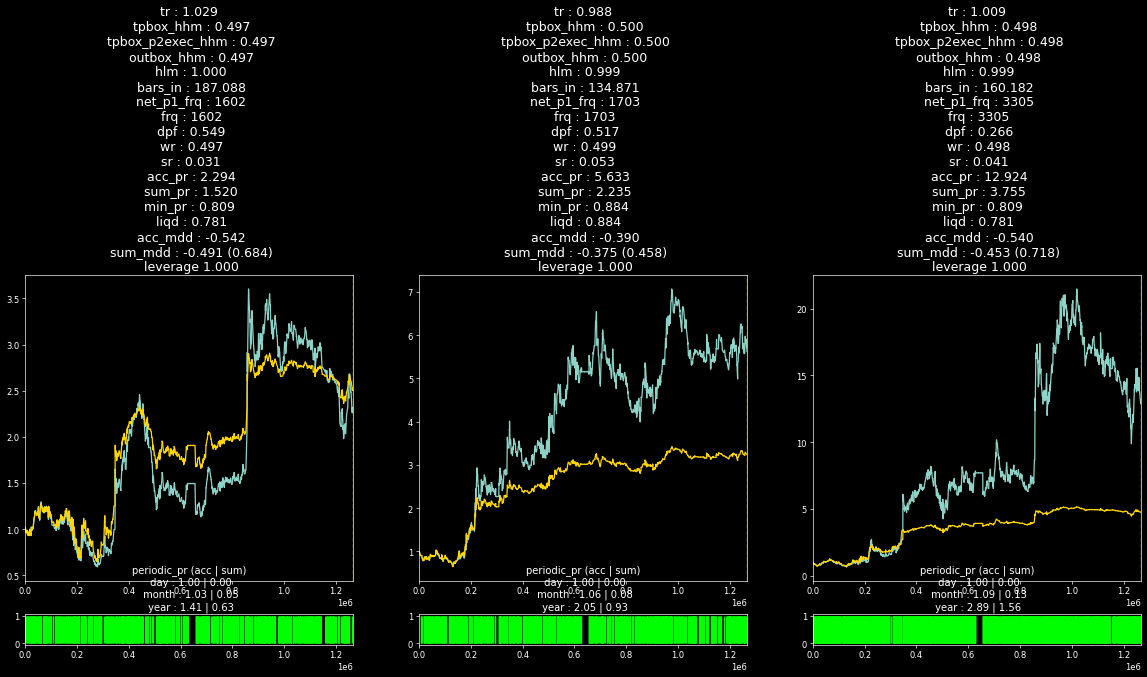

idep_plot elapsed time : 1.3042984008789062


In [80]:
"""
Cautions
    1. if lvrg_rejection = 0, spread 가 큰 경우, min_lvrg 1 이기 때문에 target_pct < min_pr 가능함.
    2. liqd = exit 까지의 min_low / high 를 의미함. (long / short 기준), 따라서 zero 일 필요가 없다는 이야기.
    3. long & short point 의 open_side 가 일치하는 경우, p2 side_check release 해줄 것.
"""

en_ex_pairing = en_ex_pairing_v9_44 # en_ex_pairing_v9_3 en_ex_pairing_v9_42 en_ex_pairing_v9_4
funcs1 = [expiry_p1p2, expiry_tp, lvrg_liqd_set_v2, check_entry_v6_2, check_signal_out_v4, check_hl_out_v4, check_limit_tp_exec]  # expiry_tp / expiry_wave

idep_plot = idep_plot_v16_6
funcs2 = [get_wave_bias_v6_1, get_pr_v6, get_res_info_nb_v3, plot_info_v8_2, frq_dev_plot_v5]  # get_wave_bias_v6_1 / # 여기서 입력되는 get_res_info 는 signi. mode 에 사용됨.

test_ratio = 0.0
plot_is = 1  # insample
signi = 0
show_detail = 0

short_pr, short_obj, short_lvrg_arr, short_fee_arr, short_tpout_arr, short_tr_arr, short_bias_arr, short_net_p1_bias_tick, short_p2exec_p1_bias_tick, short_net_p1_idx_arr, short_p2_idx_arr, short_tp_1, short_tp_0, short_out_1, short_out_0, short_ep2_0, \
      long_pr, long_obj, long_lvrg_arr, long_fee_arr, long_tpout_arr, long_tr_arr, long_bias_arr, long_net_p1_bias_tick, long_p2exec_p1_bias_tick, long_net_p1_idx_arr, long_p2_idx_arr, long_tp_1, long_tp_0, long_out_1, long_out_0, long_ep2_0 = \
get_res_v2(res_df, open_info_df_list, ohlc_list, config_list, np_timeidx, en_ex_pairing, funcs1, idep_plot, funcs2, test_ratio=test_ratio, plot_is=plot_is, signi=signi, show_detail=show_detail)

In [56]:
# ------ inversion ------ #
# _ = get_res_v5(res_df, open_info_df, ohlc_list, config_list, np_timeidx, funcs, inversion=True, test_ratio=test_ratio, plot_is=1, signi=False)

#### print config

In [22]:
# ------- print config ------- #
config_sets = ['selection_id', 'trader_set', 'pos_set', 'loc_set', 'tr_set', 'ep_set', 'tp_set', 'out_set', 'lvrg_set']
for set_i, set_ in enumerate(config_sets):
    if set_i == len(config_sets) - 1:
        end = '\n'
    else:
        end = ', \n'
    print('"{}": {}'.format(set_, json.dumps(config_list[0][set_], indent=2)), end=end)
# _ = [print(key_ + ":", json.dumps(config_list[0][key_], indent=1), end=',\n') for key_ in ['selection_id', 'trader_set', 'pos_set', 'loc_set', 'tr_set', 'ep_set', 'tp_set', 'out_set', 'lvrg_set']] #  'trader_set',

"selection_id": "1", 
"trader_set": {
  "backtrade": 1,
  "back_data_path": "D:\\Projects\\System_Trading\\JnQ\\database\\binance\\cum\\2023-01-12\\2023-01-12 ETHUSDT_1m.ftr",
  "start_datetime": "2020-05-05 00:00:59.999",
  "run": 1,
  "df_log": 0,
  "show_detail": 0,
  "latest_index": -1,
  "complete_index": -2,
  "limit_fee": 0.0002,
  "market_fee": 0.0004,
  "initial_asset": 10,
  "profit_mode": "PROD",
  "asset_changed": 0,
  "symbol": "ETHUSDT",
  "symbol_changed": 0,
  "token": "5859375131:AAHPzzz_Dv2OSxFsSOLChiXhfL0jN_6fOWU",
  "messenger_on": 0,
  "itv_list": "['T', '3T', '5T', '15T', '30T', 'H', '4H']",
  "row_list": "[500, 1, 1, 1, 1, 1, 1]",
  "rec_row_list": "[1, 1, 1, 1, 1, 1, 1]",
  "offset_list": "['1h', '1h', '1h', '1h', '1h', '1h', '1h']",
  "loop_duration": 3.6,
  "realtime_term": 0.2,
  "api_term": 1,
  "order_term": 0.5,
  "market_check_term": 5,
  "open_exec_check_term": 5,
  "open_exec_qty_ratio": 0.97,
  "tp_exec_check_term": 5
}, 
"pos_set": {
  "short_inversio

#### on multiple ticker

In [168]:
def idep_on_multiple_ticker(database_dir_abspath, data_list, signi=True):
    
    sub_title_list = ['hhm', 'hlm', 'frq', 'dpf', 'wr', 'sr', 'acc_pr', 'sum_pr', 'min_pr', 'liqd', 'acc_mdd', 'sum_mdd_prod', 'sum_mdd_sum']
    sub_title_list_long = [col + '_long' for col in sub_title_list]
    sub_title_list_short = [col + '_short' for col in sub_title_list]    
    sub_title_list_len = len(sub_title_list)    
    res_list_long = []
    res_list_short = []
    for r_, ticker in enumerate(data_list):

        print("# ------------ rank : {}, ticker : {} ------------ #".format(r_, ticker))

        # while 1:  # memory allocation 문제로 진행했으나, while 은 해결책이 아님 (eternal loop+
        try:                
            start_0 = time.time()
            data_path = os.path.join(database_dir_abspath, "{} {}.pkl".format(date, ticker))
            # data_path = os.path.join(database_dir_abspath, "{} A{}.pkl".format(date, ticker))  # add A temporarily
            if idep_mode == "CRYPTO":
                pd.read_feather(data_path, columns=None, use_threads=True).set_index("index")
            else:
                res_df_ = pd.read_pickle(data_path)
            print(data_path, "loaded !")
            print("load res_df_ elapsed time :", time.time() - start_0)
            
            # timeindex_str = str(res_df_.index[0])
            # if timeindex_str != "2021-03-05 09:01:00":
            #     print("res_df_.index[0] : {}\n".format(timeindex_str))
            #     continue

            if config.trader_set.start_datetime != "None":
                res_df = res_df_.astype(float).loc[pd.to_datetime(config.trader_set.start_datetime):]
            else:    
                res_df = res_df_.astype(float)
            np_timeidx = np.array([intmin_np(date_) for date_ in res_df.index.to_numpy()])


            start_0 = time.time()
            if public_override:
                res_df = public_indi(res_df, config_list[0], np_timeidx)  # 현재 대부분의 시간은 h_candle 에서 소비되고 있음
            else:
                res_df = bank.public.public_indi(res_df, config_list[0], np_timeidx)
            print("public_indi elapsed time :", time.time() - start_0)


            start_0 = time.time()
            ohlc_cols = ['open', 'high', 'low', 'close']
            ohlc_list = [res_df[col_].to_numpy() for col_ in ohlc_cols]
            print("make data_list elapsed time :", time.time() - start_0)


            start_0 = time.time()
            if utils_override:   # 현재, utils_override 하는 경우 1개의 ID 만 허용함 
              res_df = enlist_tr(res_df, config_list[0], np_timeidx)    # 36995.0 -> 152766.0 # 4044 np.sum(long_open_res == 1) : 4325
            else:
                for utils_, config_ in zip(utils_list, config_list):
                    res_df = utils_.enlist_tr(res_df, config_, np_timeidx)
            print("enlist_tr elapsed time :", time.time() - start_0)


            open_info_df1 = get_open_info_df_v2(ep_loc_p1_v3, res_df, np_timeidx, id_list, config_list, id_idx_list, open_num=1)  # --> point * dur. 관련 (loc_set) param 에 종속 (open_info 가 변경되는게 아니라면, 재실행할 필요없음)
            open_info_df2 = get_open_info_df_v2(ep_loc_p2_v3, res_df, np_timeidx, id_list, config_list, id_idx_list, open_num=2)
            open_info_df_list = [open_info_df1, open_info_df2]
            
            en_ex_pairing = en_ex_pairing_v9_44 # en_ex_pairing_v9_3 en_ex_pairing_v9_42 en_ex_pairing_v9_4
            funcs1 = [expiry_p1p2, expiry_tp, lvrg_liqd_set_v2, check_entry_v6_2, check_signal_out_v3, check_hl_out_v4, check_limit_tp_exec]  # expiry_tp / expiry_wave

            idep_plot = idep_plot_v16_6
            funcs2 = [get_wave_bias_v6_1, get_pr_v6, get_res_info_nb_v3, plot_info_v8_2, frq_dev_plot_v5]  # get_wave_bias_v6_1 / # 여기서 입력되는 get_res_info 는 signi. mode 에 사용됨.

            test_ratio = 0.0
            plot_is = 1  # insample
            show_detail = 0

            if signi:
                short_res, long_res, both_res = get_res_v2(res_df, open_info_df_list, ohlc_list, config_list, np_timeidx, en_ex_pairing, funcs1, idep_plot, funcs2, test_ratio=test_ratio, plot_is=plot_is, signi=signi, show_detail=show_detail)
            else:
                get_res_v2(res_df, open_info_df_list, ohlc_list, config_list, np_timeidx, en_ex_pairing, funcs1, idep_plot, funcs2, test_ratio=test_ratio, plot_is=plot_is, signi=signi, show_detail=show_detail)
            # short_pr, short_obj, short_lvrg_arr, short_fee_arr, short_tpout_arr, short_tr_arr, short_bias_arr, short_net_p1_bias_tick, short_p2exec_p1_bias_tick, short_net_p1_idx_arr, short_p2_idx_arr, short_tp_1, short_tp_0, short_out_1, short_out_0, short_ep2_0, \
            #       long_pr, long_obj, long_lvrg_arr, long_fee_arr, long_tpout_arr, long_tr_arr, long_bias_arr, long_net_p1_bias_tick, long_p2exec_p1_bias_tick, long_net_p1_idx_arr, long_p2_idx_arr, long_tp_1, long_tp_0, long_out_1, long_out_0, long_ep2_0 = \
            # get_res_v2(res_df, open_info_df_list, ohlc_list, config_list, np_timeidx, en_ex_pairing, funcs1, idep_plot, funcs2, test_ratio=test_ratio, plot_is=plot_is, signi=signi, show_detail=show_detail)

        except Exception as e:
            print("error in get_res : {}".format(e))
            # try it again.
            # if "Unable to allocate" in str(e):
            #     continue
            # else:                    
            #     # if idep_mode == "STOCK":
            if signi:
                res_list_long.append([np.nan] * sub_title_list_len)
                res_list_short.append([np.nan] * sub_title_list_len)
        else:
            # if idep_mode == "STOCK":
            if signi:
                if len(long_pr) != 0 and type(long_res) != float:
                    res_list_long.append(list(long_res))
                else:
                    res_list_long.append([np.nan] * sub_title_list_len)
                
                if len(short_pr) != 0 and type(short_res) != float:
                    res_list_short.append(list(short_res))
                else:
                    res_list_short.append([np.nan] * sub_title_list_len)
    
    if signi:
        if type(data_list) == list:
            df_rank = pd.Series(data_list).to_frame()
        else:        
            df_rank = data_list.to_frame()
        df_rank[sub_title_list_long] = np.array(res_list_long)
        df_rank[sub_title_list_short] = np.array(res_list_short)

        return df_rank

##### main

In [169]:
idep_mode = "CRYPTO"  # CRYPTO STOCK

# data_name = '2023-02-28 208370'  # 2023-01-12 ETH / 2023-02-21 FTM /2022-04-27 ETH / 2023-02-20 BTC
# date, ticker = data_name.split(" ")
date = "2023-02-21" # "2023-02-21"  "2023-03-23"
save_mode = 0

"""
database 는 JnQ 내부로 통일할 것.
"""
database_type = 'database/binance/'  # 'binance' kiwoom upbit
database_dir_abspath = os.path.join(pkg_path, database_type, "cum", date).replace("JnQ_32bit", "JnQ")  # cum non_cum -> use, non_cum data for backtrade validation


In [ ]:
if idep_mode == "CRYPTO":
    data_list = [f_name for f_name in os.listdir(database_dir_abspath) if 'ftr' in f_name if date in f_name]
else:
    data_list = pd.read_pickle(os.path.join(database_dir_abspath, "rank.pkl"))  # [:10]
    
    
df_rank = idep_on_multiple_ticker(database_dir_abspath, data_list, signi=True)

if save_mode:
    df_rank.to_pickle(os.path.join(database_dir_abspath, "df_rank.pkl"))

##### result analysis

In [171]:
with open(os.path.join(database_dir_abspath, "df_rank.pkl"), 'rb') as f:
    df_rank = pickle.load(f)

In [ ]:
df_rank

In [360]:
# print(np.mean(df_rank[df_rank.sr < 0.15]))
# print(np.mean(df_rank[df_rank.sr > 0.15]))
# df_rank2 = df_rank[df_rank.hhm > 0.80]
valid_ticker = ["2023-02-21 ALICEUSDT_1m.ftr", "2023-02-21 COMPUSDT_1m.ftr", "2023-02-21 DOTUSDT_1m.ftr", "2023-02-21 SNXUSDT_1m.ftr", "2023-02-21 SUSHIUSDT_1m.ftr"]

In [ ]:
idep_on_multiple_ticker(database_dir_abspath, df_rank.iloc[:, 0], False)
# idep_on_multiple_ticker(database_dir_abspath, df_rank2.iloc[:, 0], False)
# idep_on_multiple_ticker(database_dir_abspath, valid_ticker, False)

In [ ]:
# df_rank.sort_values(by='long_sum_pr', ascending=False)

# rank_cnt = 100
rank_cnt = len(df_rank)
df_rank2 = df_rank.iloc[:rank_cnt]

plt.bar(np.arange(df_rank2.long_sum_pr), df_rank2.long_sum_pr, width=0.5, align='edge')  # center
# plt.bar(np.arange(rank_cnt) + 1, df_rank2.sort_values(by='long_sum_pr', ascending=False).long_sum_pr, width=0.5, align='edge')  # center
plt.axhline(0)
plt.show()

# print(df_rank2)
print(np.nanmin(df_rank2.long_sum_pr), np.nanmax(df_rank2.long_sum_pr))
print(np.nansum(df_rank2.long_sum_pr)) # 0.732 -> 7326 (fee v1 -> v2 적용 전후 차이 거의 없음.)

### Statistics (case by ID)

#### ep_loc value optimization based on hhm

In [21]:
selection_id = config.selection_id

short_p1_idx = short_obj[-1].astype(int)
long_p1_idx = long_obj[-1].astype(int)

short_open_tp_1 = res_df['short_tp_1_{}'.format(selection_id)].to_numpy()[short_p1_idx]
long_open_tp_1 = res_df['long_tp_1_{}'.format(selection_id)].to_numpy()[long_p1_idx]

short_open_tp_0 = res_df['short_tp_0_{}'.format(selection_id)].to_numpy()[short_p1_idx]
long_open_tp_0 = res_df['long_tp_0_{}'.format(selection_id)].to_numpy()[long_p1_idx]

short_open_tp_gap = res_df['short_tp_gap_{}'.format(selection_id)].to_numpy()[short_p1_idx]  # use open_i
long_open_tp_gap = res_df['long_tp_gap_{}'.format(selection_id)].to_numpy()[long_p1_idx]

short_open_out_0 = res_df['short_out_0_{}'.format(selection_id)].to_numpy()[short_p1_idx]
long_open_out_0 = res_df['long_out_0_{}'.format(selection_id)].to_numpy()[long_p1_idx]

short_open_out_gap = res_df['short_out_gap_{}'.format(selection_id)].to_numpy()[short_p1_idx]  # use open_i
long_open_out_gap = res_df['long_out_gap_{}'.format(selection_id)].to_numpy()[long_p1_idx]

# ------ out case 의 max_high check (long) ------ # => tp_case 의 max_high = tp 라, 의미가 없음.
short_max_tpg = get_max_tpg_v2(OrderSide.SELL, ohlc_list, short_pr, short_obj[:4], short_open_tp_1, short_open_tp_gap)
long_max_tpg = get_max_tpg_v2(OrderSide.BUY, ohlc_list, long_pr, long_obj[:4], long_open_tp_1, long_open_tp_gap)
# short_max_tpg = get_max_tpg_v2(OrderSide.SELL, ohlc_list, short_pr, short_obj[:4], short_open_tp_1, short_open_out_gap)
# long_max_tpg = get_max_tpg_v2(OrderSide.BUY, ohlc_list, long_pr, long_obj[:4], long_open_tp_1, long_open_out_gap)

# ------ true_bias 의 outg 확인 ------ # --> 추후, outg 로 tp_gap / out_gap custom 여부를 위해, 본 cell 을 지우지 않음
short_max_outg = get_max_outg_v4(OrderSide.SELL, config, ohlc_list, short_obj, short_tpout_arr, short_open_tp_0, short_open_tp_gap)  # tp_box's mean_low 확인 위해 tp_gap 입력함
long_max_outg = get_max_outg_v4(OrderSide.BUY, config, ohlc_list, long_obj, long_tpout_arr, long_open_tp_0, long_open_tp_gap)

current_tpg = config.tr_set.tp_gap
current_outg = config.tr_set.out_gap

In [ ]:
# ------------ dependent vars. ------------ #
# res_df 에 존재하는 col 는 모두 사용가능함

wave_itv1 = 'T'
wave_period1 = config.tr_set.wave_period1

# ------ 1. 도출한 outg 와 vars. pairing 진행 (by valid_idx) ------ #
devided_cols, public_cols = [], []

devided_cols.append('tr_{}'.format(selection_id))

devided_cols.append('wave_length_fill_{}{}'.format(wave_itv1, wave_period1))
devided_cols.append('spread_{}'.format(selection_id))


# public_cols.append('cu_wrr_21_{}{}'.format(wave_itv1, wave_period1))
public_cols.append('cu_wrr_32_{}{}'.format(wave_itv1, wave_period1))
# public_cols.append('co_wrr_21_{}{}'.format(wave_itv1, wave_period1))
public_cols.append('co_wrr_32_{}{}'.format(wave_itv1, wave_period1))

# public_cols.append('wave_high_terms_cnt_fill_T5')
# public_cols.append('wave_low_terms_cnt_fill_T5')
# public_cols.append('wave_high_loc_pct_T5')
# public_cols.append('wave_low_loc_pct_T5')

# public_cols.append('b1_co_es_15T1')
# public_cols.append('b1_cu_es_15T1')
# public_cols.append('b1_upper_wick_ratio_15T')
# public_cols.append('b1_lower_wick_ratio_15T')

#  'co_wrr_T5', 'cu_wrr_T5', 'b1_cppr_15T', 'b1_updbr', 'b1_lwdbr', 'b1_updbr_cppr', 'b1_lwdbr_cppr' 'abs_ratio_5T', 'rel_ratio_5T', 'body_rel_ratio_5T'

# devided_cols = ['tr_{}'.format(selection_id)]  # , 'ir_5T'
# public_cols = ['wave_high_terms_cnt_fill_T5', 'wave_low_terms_cnt_fill_T5', 'wave_high_loc_pct_T5', 'wave_low_loc_pct_T5', 
#                'b1_co_es_15T1', 'b1_cu_es_15T1', 'b1_upper_wick_ratio_15T', 'b1_lower_wick_ratio_15T']

short_datas = [res_df['short_' + col].to_numpy() for col in devided_cols] + [res_df[col].to_numpy() for col in public_cols]
long_datas = [res_df['long_' + col].to_numpy() for col in devided_cols] + [res_df[col].to_numpy() for col in public_cols]

titles = devided_cols + public_cols

In [ ]:
plt.style.use(['dark_background', 'fast'])
fig = plt.figure(figsize=(14, len(titles) * 5), dpi=60)
nrows, ncols = len(short_datas), 1
gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                        ncols=ncols
                        )

num_samples = 30
alpha = 0.8

"""
xmin / xmax 이용해서 closeup 가능함
"""

xmin = 0
xmax = 1.1

for ings_idx, (title, short_data, long_data) in enumerate(zip(titles, short_datas, long_datas)):
  inner_gs = gs[ings_idx].subgridspec(nrows=2, ncols=2)

  short_open_data = short_data[short_p1_idx]
  long_open_data = long_data[long_p1_idx]

  short_bias_ravel = short_bias_arr.ravel()
  long_bias_ravel = long_bias_arr.ravel()

  short_open_data_y = np.zeros_like(short_open_data)
  short_open_data_y[short_bias_ravel] = 1

  long_open_data_y = np.zeros_like(long_open_data)
  long_open_data_y[long_bias_ravel] = 1

  print("short {} corr : {}".format(title, stats.pearsonr(short_open_data.ravel(), short_open_data_y.ravel())))
  print("long {} corr : {}".format(title, stats.pearsonr(long_open_data.ravel(), long_open_data_y.ravel())))

  short_true_data = short_open_data[short_bias_ravel]    
  # print(short_open_data)
  # print(short_bias_arr)
  # short_false_data = short_open_data[short_false_bias_arr.ravel()]
  short_false_data = short_open_data[~short_bias_ravel]
  long_true_data = long_open_data[long_bias_ravel]
  # long_false_data = long_open_data[long_false_bias_arr.ravel()]
  long_false_data = long_open_data[~long_bias_ravel]
  
  short_true_valid_idx = np.ones_like(short_true_data).astype(bool)
  short_false_valid_idx = np.ones_like(short_false_data).astype(bool)
  long_true_valid_idx = np.ones_like(long_true_data).astype(bool)
  long_false_valid_idx = np.ones_like(long_false_data).astype(bool)

  short_true_valid_idx *= ~np.isinf(short_true_data)
  short_false_valid_idx *= ~np.isinf(short_false_data)
  long_true_valid_idx *= ~np.isinf(long_true_data)
  long_false_valid_idx *= ~np.isinf(long_false_data)

  try:
    short_true_valid_idx *= short_true_data > xmin
    short_false_valid_idx *= short_false_data > xmin
    long_true_valid_idx *= long_true_data > xmin
    long_false_valid_idx *= long_false_data > xmin

  except:
    pass

  try:
    short_true_valid_idx *= short_true_data < xmax
    short_false_valid_idx *= short_false_data < xmax
    long_true_valid_idx *= long_true_data < xmax
    long_false_valid_idx *= long_false_data < xmax
    
  except:
    pass
    
  plt.subplot(inner_gs[0])
  ns, bins, patches = plt.hist([short_true_data[short_true_valid_idx], short_false_data[short_false_valid_idx]], 
           bins=num_samples, alpha=alpha, color=['#00ff00', '#ff0000'], edgecolor='black')  
  plt.title('short_' + title)  

  plt.subplot(inner_gs[2])
  total_ns = np.sum(ns, axis=0)
  hist_ratio = ns[0] / total_ns
  # valid_idx = total_ns > 1
  valid_idx = np.full(len(hist_ratio), True)
  valid_hist_ratio = hist_ratio[valid_idx]
  plt.hist(bins[:-1][valid_idx], weights=valid_hist_ratio, bins=num_samples, color='#00ff00', edgecolor='black')
  plt.ylim(0, 1)
  

  plt.subplot(inner_gs[1])
  ns, bins, patches = plt.hist([long_true_data[long_true_valid_idx], long_false_data[long_false_valid_idx]], 
           bins=num_samples, alpha=alpha, color=['#00ff00', '#ff0000'], edgecolor='black')
  plt.title('long_' + title)
  
  plt.subplot(inner_gs[3])
  total_ns = np.sum(ns, axis=0)
  hist_ratio = ns[0] / total_ns
  # valid_idx = total_ns > 1
  valid_idx = np.full(len(hist_ratio), True)
  valid_hist_ratio = hist_ratio[valid_idx]
  plt.hist(bins[:-1][valid_idx], weights=valid_hist_ratio, bins=num_samples, color='#00ff00', edgecolor='black')
  plt.ylim(0, 1)

  
# plt.suptitle(title)
plt.show()

#### get significance (v4 -> v5 : split short / long / both res)

init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 771
np.sum(long_open_res1 == 1) : 1067
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 

get_open_info_df elapsed time : 0.026006221771240234
get_open_info_df elapsed time : 0.09402036666870117
en_ex_pairing elapsed time : 0.017003536224365234
idep_plot elapsed time : 0.007001638412475586
get_open_info_df elapsed time : 0.02800750732421875


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 841
np.sum(long_open_res1 == 1) : 1176
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res


get_open_info_df elapsed time : 0.09102034568786621
en_ex_pairing elapsed time : 0.018004417419433594
idep_plot elapsed time : 0.007001638412475586
get_open_info_df elapsed time : 0.02800607681274414
get_open_info_df elapsed time : 0.09002017974853516
en_ex_pairing elapsed time : 0.01800370216369629
idep_plot elapsed time : 0.007001399993896484


np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 874
np.sum(long_open_res1 == 1) : 1227
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 878
np

get_open_info_df elapsed time : 0.031006574630737305
get_open_info_df elapsed time : 0.09102106094360352
en_ex_pairing elapsed time : 0.01900315284729004
idep_plot elapsed time : 0.007001638412475586
get_open_info_df elapsed time : 0.02700662612915039


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 878
np.sum(long_open_res1 == 1) : 1231
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res


get_open_info_df elapsed time : 0.09202003479003906
en_ex_pairing elapsed time : 0.0200045108795166
idep_plot elapsed time : 0.006001472473144531
get_open_info_df elapsed time : 0.026006460189819336
get_open_info_df elapsed time : 0.0940237045288086
en_ex_pairing elapsed time : 0.021004915237426758
idep_plot elapsed time : 0.00600123405456543


np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 880
np.sum(long_open_res1 == 1) : 1239
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 881
np

get_open_info_df elapsed time : 0.031007766723632812
get_open_info_df elapsed time : 0.09002065658569336
en_ex_pairing elapsed time : 0.021004676818847656
idep_plot elapsed time : 0.007001161575317383
get_open_info_df elapsed time : 0.02700662612915039


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 882
np.sum(long_open_res1 == 1) : 1263
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)


get_open_info_df elapsed time : 0.09102058410644531
en_ex_pairing elapsed time : 0.02100539207458496
idep_plot elapsed time : 0.006001472473144531
get_open_info_df elapsed time : 0.02600550651550293
get_open_info_df elapsed time : 0.09102082252502441
en_ex_pairing elapsed time : 0.0200045108795166


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 894
np.sum(long_open_res1 == 1) : 1287
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 

idep_plot elapsed time : 0.007001399993896484
get_open_info_df elapsed time : 0.031006813049316406
get_open_info_df elapsed time : 0.09602141380310059
en_ex_pairing elapsed time : 0.02200484275817871
idep_plot elapsed time : 0.007002115249633789


co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 904
np.sum(long_open_res1 == 1) : 1300
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)


get_open_info_df elapsed time : 0.026005983352661133
get_open_info_df elapsed time : 0.09702110290527344
en_ex_pairing elapsed time : 0.02200484275817871
idep_plot elapsed time : 0.00600123405456543
get_open_info_df elapsed time : 0.02736663818359375


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 908
np.sum(long_open_res1 == 1) : 1313
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res


get_open_info_df elapsed time : 0.09302043914794922
en_ex_pairing elapsed time : 0.023005008697509766
idep_plot elapsed time : 0.006001472473144531
get_open_info_df elapsed time : 0.02600574493408203
get_open_info_df elapsed time : 0.09002017974853516
en_ex_pairing elapsed time : 0.022003173828125
idep_plot elapsed time : 0.00600123405456543


np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 916
np.sum(long_open_res1 == 1) : 1339
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 919
np

get_open_info_df elapsed time : 0.030007123947143555
get_open_info_df elapsed time : 0.09502100944519043
en_ex_pairing elapsed time : 0.023005008697509766
idep_plot elapsed time : 0.006001472473144531
get_open_info_df elapsed time : 0.0290069580078125


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 926
np.sum(long_open_res1 == 1) : 1351
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)


get_open_info_df elapsed time : 0.09202051162719727
en_ex_pairing elapsed time : 0.023005008697509766
idep_plot elapsed time : 0.006002187728881836
get_open_info_df elapsed time : 0.027005434036254883
get_open_info_df elapsed time : 0.09102058410644531
en_ex_pairing elapsed time : 0.023004770278930664


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 927
np.sum(long_open_res1 == 1) : 1360
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 

idep_plot elapsed time : 0.0070018768310546875
get_open_info_df elapsed time : 0.026006221771240234
get_open_info_df elapsed time : 0.09202122688293457
en_ex_pairing elapsed time : 0.023005247116088867
idep_plot elapsed time : 0.007001638412475586


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 941
np.sum(long_open_res1 == 1) : 1374
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)


get_open_info_df elapsed time : 0.02600574493408203
get_open_info_df elapsed time : 0.09402132034301758
en_ex_pairing elapsed time : 0.038008928298950195
idep_plot elapsed time : 0.007001638412475586
get_open_info_df elapsed time : 0.02800607681274414


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 941
np.sum(long_open_res1 == 1) : 1378
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res


get_open_info_df elapsed time : 0.09402036666870117
en_ex_pairing elapsed time : 0.02300548553466797
idep_plot elapsed time : 0.007002115249633789
get_open_info_df elapsed time : 0.02700638771057129
get_open_info_df elapsed time : 0.09402060508728027
en_ex_pairing elapsed time : 0.024005651473999023
idep_plot elapsed time : 0.006000995635986328


np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 941
np.sum(long_open_res1 == 1) : 1378
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 958
np

get_open_info_df elapsed time : 0.02600550651550293
get_open_info_df elapsed time : 0.09102535247802734
en_ex_pairing elapsed time : 0.023005247116088867
idep_plot elapsed time : 0.006001472473144531
get_open_info_df elapsed time : 0.026006221771240234


init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 961
np.sum(long_open_res1 == 1) : 1411
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res


get_open_info_df elapsed time : 0.089019775390625
en_ex_pairing elapsed time : 0.023004770278930664
idep_plot elapsed time : 0.0070018768310546875
get_open_info_df elapsed time : 0.02600550651550293
get_open_info_df elapsed time : 0.0890202522277832
en_ex_pairing elapsed time : 0.023005962371826172
idep_plot elapsed time : 0.0070018768310546875


np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 961
np.sum(long_open_res1 == 1) : 1411
cu_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.14286 0.70000 (0.0)
short_spread_ : 1.00841 (0.0)
co_wrr_32_ <= config.loc_set.point1.max_wrr_32 : 1.00000 0.70000 (0.0)
long_spread_ : 1.00962 (0.0)
init open_res
np.sum(short_open_res1 == 1) : 22876
np.sum(long_open_res1 == 1) : 22876
wave_point
np.sum(short_open_res1 == 1) : 1145
np.sum(long_open_res1 == 1) : 1739
reject update_hl
np.sum(short_open_res1 == 1) : 1095
np.sum(long_open_res1 == 1) : 1685
wave_mm
np.sum(short_open_res1 == 1) : 1093
np.sum(long_open_res1 == 1) : 1679
point validation
np.sum(short_open_res1 == 1) : 961
np

get_open_info_df elapsed time : 0.026006460189819336
get_open_info_df elapsed time : 0.09402036666870117
en_ex_pairing elapsed time : 0.024006128311157227
idep_plot elapsed time : 0.006000995635986328
get_open_info_df elapsed time : 0.026006221771240234
get_open_info_df elapsed time : 0.0890195369720459
en_ex_pairing elapsed time : 0.024005889892578125
idep_plot elapsed time : 0.007001161575317383


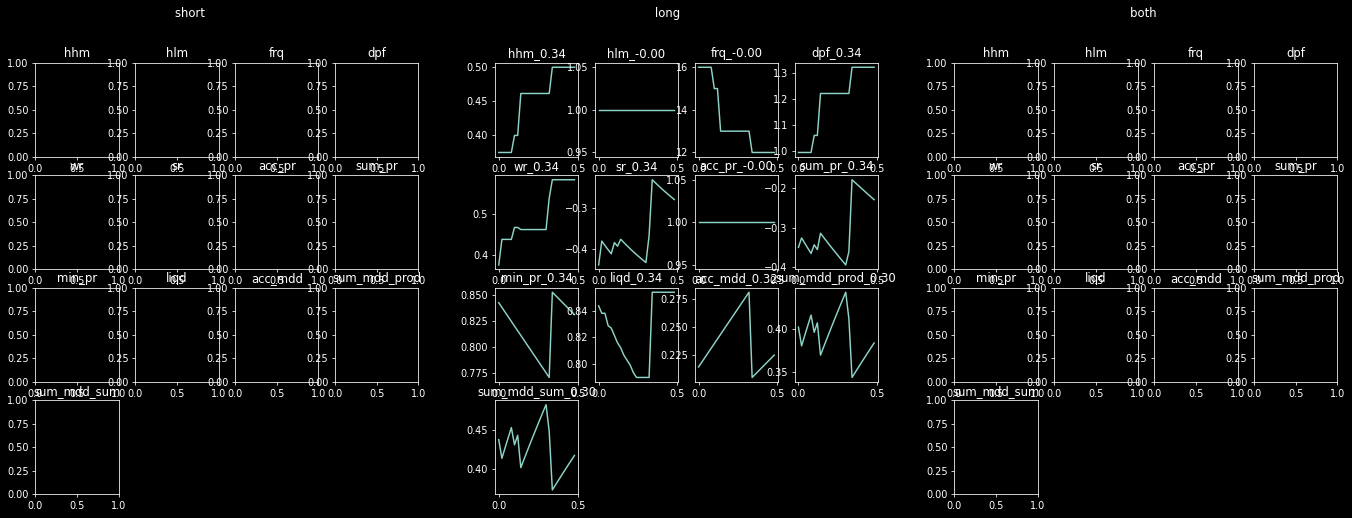

In [177]:
"""
1. 일단은 현재까지의 logic 은 short & long result 가 온전한 경우에 대해 정상적으로 돌아가도록 구성함.
"""

# ------------ survey param ------------ #
# itv_num_list = [1, 3, 5, 15]
# itv_list = ['15m', '30m', '1h', '4h']
# itv_list = ['3m', '5m', '15m', '30m', '1h', '4h']

# val_list = np.arange(0, 10, 0.5)     # prcn 1
val_list = np.arange(-0.0, 0.5, 0.02)  # prcn 2
# val_list = np.arange(-0.5, 0., 0.03)  # prcn 2
# val_list = np.arange(-0.5, -0.6, -0.005)    # prcn 3
# val_list = np.arange(0.944, 0.945, 0.0001)    # prcn 4
# val_list = np.arange(1, 10, 1)   # prcn -1
# val_list = np.arange(100, 120, 1)   # prcn -2
# val_list = talib.get_function_groups()['Pattern Recognition']

# ------------ get survey_res ------------ #
short_res_list, long_res_list, both_res_list = [], [], []
result = []
res_shape = (3, 12)  # short, long, both x data
config_list_copy = copy.deepcopy(config_list)
for set_val in val_list:
    # ------------ open 결정 이전의 인자값 ------------ #
    # ------ point * dur. ------ #
    # config_list_copy[0].loc_set.point1.wrr_32 = set_val
    # config_list_copy[0].loc_set.point1.candle_pattern = set_val
    # config_list_copy[0].loc_set.zone.degree_list = set_val
    # config_list_copy[0].loc_set.point2.wick_score_list = str([set_val])
    # config_list_copy[0].loc_set.zone.ir = set_val  
    # config_list_copy[0].loc_set.zone.abs_ratio = set_val

    # ------------ open 결정 이후의 인자값 ------------ #
    # ------ utils ------ #
    # config_list_copy[0].tr_set.tp_gap = set_val  
    # config_list_copy[0].tr_set.ep_gap1 = set_val 
    # config_list_copy[0].tr_set.ep_gap2 = set_val 
    config_list_copy[0].tr_set.out_gap = set_val  
    # config_list_copy[0].tr_set.wave_length1 = set_val  
    # config_list_copy[0].tr_set.wave_time_ratio1 = set_val

    # config_list_copy[0].tr_set.tp_gap = abs(set_val) - 0.5
    # config_list_copy[0].tr_set.out_gap = set_val + 0.5
    # config_list_copy[0].tr_set.wb_tp_gap = config_list_copy[0].tr_set.tp_gap
    # config_list_copy[0].tr_set.wb_out_gap = config_list_copy[0].tr_set.out_gap

    # ------ entry, exit (ep, tp, out vars.) ------ #
    # config_list_copy[0].tr_set.expire_k = set_val
    # config_list_copy[0].ep_set.expire_tick = set_val  

    for utils_, config_ in zip(utils_list, config_list_copy):
        enlist_tr(res_df, config_, np_timeidx)
        
    # open_info_df = get_open_info_df(ep_loc_v3, res_df, np_timeidx, id_list, config_list_copy, id_idx_list)   # point * mr_res 이기 때문에 utils_tr & rtc 의 영향을 충분히 받음
    open_info_df1 = get_open_info_df_v2(ep_loc_p1_v3, res_df, np_timeidx, id_list, config_list_copy, id_idx_list, open_num=1)  # --> point * dur. 관련 (loc_set) param 에 종속 (open_info 가 변경되는게 아니라면, 재실행할 필요없음)
    open_info_df2 = get_open_info_df_v2(ep_loc_p2_v3, res_df, np_timeidx, id_list, config_list_copy, id_idx_list, open_num=2)
    open_info_df_list = [open_info_df1, open_info_df2]

    # try:    
    short_res, long_res, both_res = get_res_v2(res_df, open_info_df_list, ohlc_list, config_list, np_timeidx, en_ex_pairing, funcs1, idep_plot_v16_5, funcs2, test_ratio=test_ratio, plot_is=plot_is, signi=True, show_detail=show_detail)
    short_res_list.append(short_res)
    long_res_list.append(long_res)
    both_res_list.append(both_res)
    # except Exception as e
    #   result.append(np.full(res_shape, np.nan))
    #   print("error in get_res() phase : {}".format(e))
    # pass
    
# survey_res_list = [np.array(result)[:, s_i::3] for s_i in range(3)]   # 3 for s, l, b
survey_res_list = [short_res_list, long_res_list, both_res_list]   # 3 for s, l, b
# short_res, long_res, both_res = survey_res_list

# ------------ plot survey_res ------------ #
title_list = ["short", "long", "both"]
sub_title_list = ['hhm', 'hlm', 'frq', 'dpf', 'wr', 'sr', 'acc_pr', 'sum_pr', 'min_pr', 'liqd', 'acc_mdd', 'sum_mdd_prod', 'sum_mdd_sum']
space_ = " " * 120

fig = plt.figure(figsize=(24, 8), dpi=70)
plt.style.use('dark_background')
gs = gridspec.GridSpec(nrows=1,
                        ncols=3,
                        # height_ratios=[1, 1, 1]
                      )

sub_rows, sub_cols, sub_height_ratio = 4, 4, [1, 1, 1, 1]

for d_idx, (title_name, survey_res) in enumerate(zip(title_list, survey_res_list)):  
    inner_gs = gs[d_idx].subgridspec(nrows=sub_rows,
                        ncols=sub_cols,
                        height_ratios=sub_height_ratio
                      )
            
    for in_idx, (data_, sub_title) in enumerate(zip(np.array(survey_res).T, sub_title_list)):
        plt.subplot(inner_gs[in_idx])
        data = data_.ravel()                
        valid_idx = ~pd.isnull(data)
        if np.sum(valid_idx) > 0:
            if type(val_list[0]) == str:
                x, y = np.arange(len(val_list))[valid_idx], data[valid_idx]
            else:
                x, y = val_list[valid_idx], data[valid_idx]
            plt.plot(x, y)  # 앞에서부터 len(result) 만큼만    
            plt.title(sub_title + '_{:.2f}'.format(x[np.argmax(y)]))
        else:
            plt.title(sub_title)

plt.suptitle(space_.join(title_list))
plt.show()
# print("\n")

#### tpg & outg survey

127
66
127
66
127
66
127
66
pkx : [0.07927269 0.28155426 0.45745128 0.69491226]
pkx : [0.06542424 0.14355807 0.33107926 0.47172015 0.59673428]

31
11
31
11
31
11
31
11
pkx : [-0.52822312 -0.43505711 -0.34737146 -0.21584299 -0.05691274]


D:\Projects\System_Trading\JnQ\funcs\public\idep.py:790: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(pkx, pky, 'bo', color='yellow')


pkx : [-0.39412162 -0.28969416 -0.09507936]



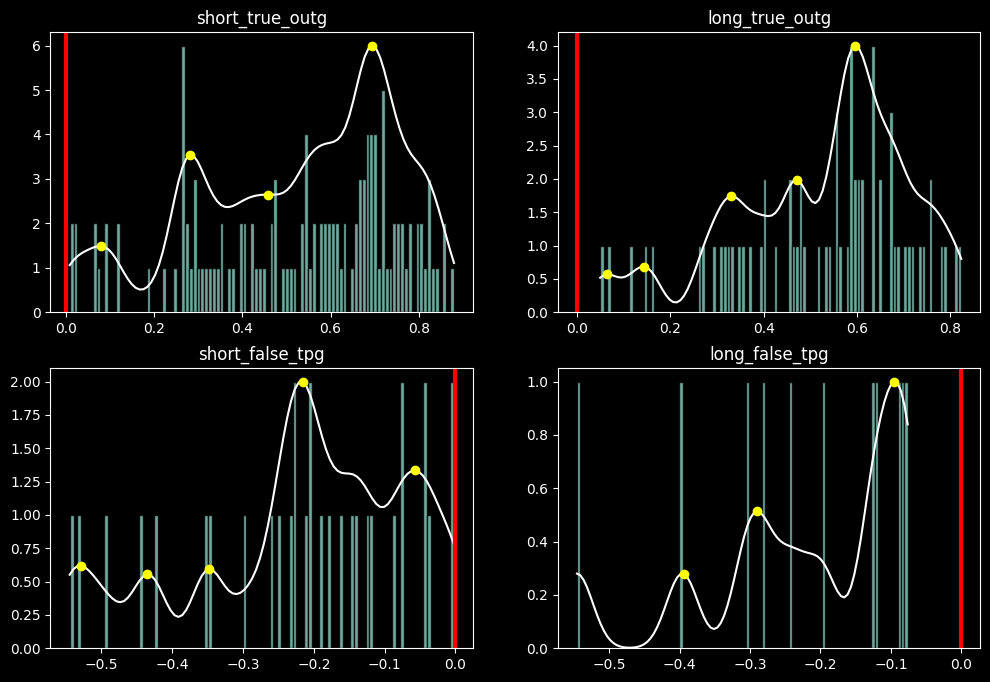

In [22]:
# 1. outg 는 partial 을 위한 histogram 작성 진행
# 현재, outg 내부에는 tp 한것과 out 한것이 공존하는 상태
titles = ['outg', 'tpg']
short_max_datas = [short_max_outg[short_bias_arr], short_max_tpg]
long_max_datas = [long_max_outg[long_bias_arr], long_max_tpg]

# titles = ['tpg']
# short_max_datas = [short_max_tpg]
# long_max_datas = [long_max_tpg]

plt.style.use(['dark_background', 'fast'])
fig = plt.figure(figsize=(12, 8))
nrows, ncols = 2, 1
gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                        ncols=ncols
                        )
  
for ings_idx, (title, short_max_data, long_max_data) in enumerate(zip(titles, short_max_datas, long_max_datas)):

  inner_gs = gs[ings_idx].subgridspec(nrows=1, ncols=2)
  if ings_idx == 0:
    axvline = current_outg
    title_add = 'true_' + title
  else:
    axvline = current_tpg
    title_add = 'false_' + title

  print(len(short_max_data))
  print(len(long_max_data))

  short_plot_idx = np.ones_like(short_max_data).astype(bool)
  long_plot_idx = np.ones_like(long_max_data).astype(bool)
  # short_plot_idx = short_max_data <= axvline
  # long_plot_idx = long_max_data <= axvline

  print(np.sum(short_plot_idx))
  print(np.sum(long_plot_idx))    

  short_plot_idx *= ~np.isnan(short_max_data)
  long_plot_idx *= ~np.isnan(long_max_data)  # nan 과 inf 때문에 이 방식 채택

  print(np.sum(short_plot_idx))
  print(np.sum(long_plot_idx))

  short_plot_idx *= ~np.isinf(short_max_data)
  long_plot_idx *= ~np.isinf(long_max_data)  # nan 과 inf 때문에 이 방식 채택
  
  print(np.sum(short_plot_idx))
  print(np.sum(long_plot_idx))
    
  plt.subplot(inner_gs[0])
  kde_plot_v2(*np.unique(short_max_data[short_plot_idx], return_counts=True))
  plt.title('short_' + title_add)  
  plt.axvline(axvline, color='red', linewidth=3)

  plt.subplot(inner_gs[1])
  kde_plot_v2(*np.unique(long_max_data[long_plot_idx], return_counts=True))
  plt.title('long_' + title_add)
  plt.axvline(axvline, color='red', linewidth=3)

  print()

# plt.suptitle(title)
plt.show()

#### legacy

##### cci updown

In [ ]:
htf_df = to_htf(res_df, '30T', offset='9h')
htf_df = cci_v2(htf_df, period=20, smooth=None, itv=None)

In [ ]:
cci_updown = htf_df.cci_30T20 < htf_df.cci_30T20.shift(-1)

# 1. 특정 조건에 대한 updown 확률을 구해라.
# 2. valid_idx & incondition_idx's "true / len(idx)" = precision
incondition_idx = htf_df.cci_30T20 > htf_df.cci_30T20.shift(1)

valid_idx = ~(pd.isnull(htf_df.cci_30T20.shift(-1)) | pd.isnull(htf_df.cci_30T20) | pd.isnull(htf_df.cci_30T20.shift(1)))

def get_odds(gt_series):
    return np.sum(gt_series) / len(gt_series)

# cci_updown[valid_idx & incondition_idx]
print("original odds : {}".format(get_odds(cci_updown[valid_idx])))
print("incondition odds : {}".format(get_odds(cci_updown[valid_idx & incondition_idx])))

##### outg survey for precision (eploc vars. dependency)

In [ ]:
# ------------ dependent vars. ------------ #
# res_df 에 존재하는 col 는 모두 사용가능함
# ------ 1. 도출한 outg 와 vars. pairing 진행 (by valid_idx) ------ #
devided_cols = ['tr_{}'.format(strat_version)]  # , 'ir_5T'
public_cols = ['wave_body_ratio']  # 'abs_ratio_5T', 'rel_ratio_5T', 'body_rel_ratio_5T'

short_datas = [res_df['short_' + col].to_numpy() for col in devided_cols] + [res_df[col].to_numpy() for col in public_cols]
long_datas = [res_df['long_' + col].to_numpy() for col in devided_cols] + [res_df[col].to_numpy() for col in public_cols]

titles = devided_cols + public_cols

In [ ]:
plot_outg_range = (-1, 10)
plot_data_range = (-10, 100)

plt.style.use(['dark_background', 'fast'])
fig = plt.figure(figsize=(12, 18))
nrows, ncols = len(short_datas), 1
gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                        ncols=ncols
                        )

for ings_idx, (title, short_data, long_data) in enumerate(zip(titles, short_datas, long_datas)):
  inner_gs = gs[ings_idx].subgridspec(nrows=1, ncols=2)

  print(len(long_max_outg))

  short_plot_idx = (plot_outg_range[0] <= short_max_outg) & (short_max_outg <= plot_outg_range[1])
  long_plot_idx = (plot_outg_range[0] <= long_max_outg) & (long_max_outg <= plot_outg_range[1])  # nan 과 inf 때문에 이 방식 채택

  print(np.sum(long_plot_idx))

  short_open_data = short_data[short_open_idx]
  long_open_data = long_data[long_open_idx]
  
  short_plot_idx *= (plot_data_range[0] <= short_open_data) * (short_open_data <= plot_data_range[1])
  long_plot_idx *= (plot_data_range[0] <= long_open_data) * (long_open_data <= plot_data_range[1]) # nan 과 inf 때문에 이 방식 채택

  short_plot_idx *= ~np.isnan(short_open_data)
  long_plot_idx *= ~np.isnan(long_open_data)  # nan 과 inf 때문에 이 방식 채택

  print(np.sum(long_plot_idx))

  short_plot_idx *= ~np.isinf(short_open_data)
  long_plot_idx *= ~np.isinf(long_open_data)  # nan 과 inf 때문에 이 방식 채택

  print(np.sum(long_plot_idx))

  short_true_idx = short_plot_idx * short_true_open_idxth
  long_true_idx = long_plot_idx * long_true_open_idxth
  
  short_false_idx = short_plot_idx * ~short_true_open_idxth
  long_false_idx = long_plot_idx * ~long_true_open_idxth

  plt.subplot(inner_gs[0])
  # ------ true_bias ------ #
  x, y = short_max_outg[short_true_idx].ravel(), short_open_data[short_true_idx].ravel()  
  plt.scatter(x, y, color='white', alpha=0.5)
  # ------ false_bias ------ #
  x, y = short_max_outg[short_false_idx].ravel(), short_open_data[short_false_idx].ravel()
  plt.scatter(x, y, color='fuchsia', alpha=0.3)
  plt.axvline(current_outg, color='red', linewidth=3)
  plt.title("{} coef : {:0.3f}".format(title, np.corrcoef(-x, y)[0, 1]))

  plt.subplot(inner_gs[1])    
  # ------ true_bias ------ #
  x, y = long_max_outg[long_true_idx].ravel(), long_open_data[long_true_idx].ravel()  
  plt.scatter(x, y, color='white', alpha=0.5)
  # ------ false_bias ------ #
  x, y = long_max_outg[long_false_idx].ravel(), long_open_data[long_false_idx].ravel()
  plt.scatter(x, y, color='fuchsia', alpha=0.3)
  plt.axvline(current_outg, color='red', linewidth=3)
  plt.title("{} coef : {:0.3f}".format(title, np.corrcoef(-x, y)[0, 1]))

  print()  

# plt.suptitle(title)
plt.show()
# print()

#### olds

### Backtrader validation

In [1]:
trade_log_dir_path = "wave_cci_wrr32_spread_wave_length"
trade_log_name = "1682307814.pkl"

with open(os.path.join("Bank/logs/trade_log", trade_log_dir_path, trade_log_name), 'rb') as f:
  trade_log = pickle.load(f)

trade_log  # both pos_side's log

NameError: name 'os' is not defined

In [27]:
"""
missed_data : Bank 에 missed 된 data.
"""

pos_side = "BUY" # BUY SELL
val_obj = short_obj if pos_side == "SELL" else long_obj

idep_log = []
bank_log = []

data_name = ["open", "entry", "exit", "entry", "exit"]

# 1. idep log
idep_log.append(list(map(lambda x : str(x), res_df.index[val_obj[4].astype(int).ravel()])))
idep_log.append(list(map(lambda x : str(x), res_df.index[val_obj[2].astype(int).ravel()])))
idep_log.append(list(map(lambda x : str(x), res_df.index[val_obj[3].astype(int).ravel()])))
idep_log.append(val_obj[0].ravel())
idep_log.append(val_obj[1].ravel())

# 2. bank log
bank_log.append([log["open"][0] for log in trade_log if log["open"][1] == pos_side])
bank_log.append([log["entry"][0] for log in trade_log if log["entry"][1] == pos_side])
bank_log.append([log["exit"][0] for log in trade_log if log["exit"][1] == pos_side])
bank_log.append([log["entry"][2] for log in trade_log if log["entry"][1] == pos_side])
bank_log.append([log["exit"][2] for log in trade_log if log["exit"][1] == pos_side])

for name, idep_res, bank_res in zip(data_name, idep_log, bank_log):
    
    missed_data = [data for data in idep_res if not data in bank_res]
    over_data = [data for data in bank_res if not data in idep_res]

    print("{}_missed_data :".format(name), missed_data)
    print("{}_over_data :".format(name), over_data)
    print()


open_missed_data : []
open_over_data : []

entry_missed_data : []
entry_over_data : []

exit_missed_data : []
exit_over_data : []

entry_missed_data : []
entry_over_data : []

exit_missed_data : []
exit_over_data : []



### method override

#### get_res

In [79]:
def get_res_v2(res_df, open_info_df_list, ohlc_list, config_list, np_timeidx, en_ex_pairing, funcs1, idep_plot, funcs2, inversion=False, test_ratio=0.3, plot_is=True, signi=False, show_detail=False):
    
    """
    v1 -> v2
    1. en_ex_pairing, idep_plot 에 필요한 funcs 를 분리함, funcs1, funcs2
    """

    # ------------ make open_info_list ------------ #
    open_idx1, open_idx2 = [open_info_df.index.to_numpy() for open_info_df in open_info_df_list]
    len_df = len(res_df)

    sample_len = int(len_df * (1 - test_ratio))
    sample_idx1 = (open_idx1 < sample_len) == plot_is  # in / out sample plot 여부
    sample_open_idx1 = open_idx1[sample_idx1]
    
    sample_idx2 = (open_idx2 < sample_len) == plot_is  # in / out sample plot 여부

    # ------------ open_info_list 기준 = p1 ------------ #
    sample_open_info_df1, sample_open_info_df2 = [df_[idx_] for df_, idx_ in zip(open_info_df_list, [sample_idx1, sample_idx2])]
    open_info1 = [sample_open_info_df1[col_].to_numpy() for col_ in sample_open_info_df1.columns]

    if config_list[0].tr_set.check_hlm in [0, 1]:  # 여기서 open_info 자동화하더라도, utils info 는 직접 실행해주어야함
        sample_open_idx2 = sample_open_idx1
        open_info2 = open_info1
    else:
        sample_open_idx2 = open_idx2[sample_idx2]
        open_info2 = [sample_open_info_df2[col_].to_numpy() for col_ in sample_open_info_df2.columns]

    # ------------ get paired_res ------------ #
    start_0 = time.time()
    paired_res = en_ex_pairing(res_df, [sample_open_idx1, sample_open_idx2], [open_info1, open_info2], ohlc_list, config_list, np_timeidx, funcs1, show_detail)
    # net_p1_idx_arr, p1_idx_arr, p2_idx_arr, pair_idx_arr, pair_price_arr, lvrg_arr, fee_arr, tpout_arr, tr_arr = paired_res    
    # print(pair_price_arr)
    print("en_ex_pairing elapsed time :", time.time() - start_0)  # 0.37 --> 0.3660471439361572 --> 0.21(lesser if)

    # ------------ idep_plot ------------ #
    start_0 = time.time()
    high, low = ohlc_list[1:3]
    res = idep_plot(res_df, len_df, config_list[0], high, low, sample_open_info_df1, paired_res, funcs2, inversion=inversion, sample_ratio=1 - test_ratio, signi=signi)
    print("idep_plot elapsed time :", time.time() - start_0)  # 1.40452 (v6) 1.4311 (v5)

    return res

#### get_open_info_df

In [82]:
def get_open_info_df_v2(ep_loc_v2, res_df, np_timeidx, id_list, config_list, id_idx_list, open_num=1):
    
    """
    v1 -> v2
        1. <U32 dtype 으로 인한 memory allocate error 에 대응하기 위해 zone, side value 를 integer 기준으로 수정함.
    """
    start_0 = time.time()
    # ------ get mr_res, zone_arr ------ #
    short_mr_res_obj = np.array([ep_loc_v2(res_df, config_, np_timeidx, show_detail=True, ep_loc_side=OrderSide.SELL) for config_ in config_list])
    long_mr_res_obj = np.array([ep_loc_v2(res_df, config_, np_timeidx, show_detail=True, ep_loc_side=OrderSide.BUY) for config_ in config_list])
    short_open_idx_list = [np.where(res_df['short_open{}_{}'.format(open_num, id)].to_numpy() * mr_res)[0] for id, mr_res in zip(id_list, short_mr_res_obj[:, 0])]   # "point * mr_Res"
    long_open_idx_list = [np.where(res_df['long_open{}_{}'.format(open_num, id)].to_numpy() * mr_res)[0] for id, mr_res in zip(id_list, long_mr_res_obj[:, 0])]  # zip 으로 zone (str) 과 묶어서 dtype 변경됨
    print("~ ep_loc_v2 elapsed time :", time.time() - start_0)

    # ------ open_info_arr ------ #
    short_side_list = [np.full(len(list_), -1) for list_ in short_open_idx_list]
    long_side_list = [np.full(len(list_), 1) for list_ in long_open_idx_list]

    short_zone_list = [zone_res[short_open_idx] for zone_res, short_open_idx in zip(short_mr_res_obj[:, 1], short_open_idx_list)]
    long_zone_list = [zone_res[long_open_idx] for zone_res, long_open_idx in zip(long_mr_res_obj[:, 1], long_open_idx_list)]

    short_id_list = [np.full(len(list_), id) for id, list_ in zip(id_list, short_open_idx_list)]
    long_id_list = [np.full(len(list_), id) for id, list_ in zip(id_list, long_open_idx_list)]

    selected_id_idx = np.arange(len(id_idx_list))
    short_id_idx_list = [np.full(len(list_), id) for id, list_ in zip(selected_id_idx, short_open_idx_list)]
    long_id_idx_list = [np.full(len(list_), id) for id, list_ in zip(selected_id_idx, long_open_idx_list)]

    # ------ get open_info_df ------ #
    #   series 만들어서 short / long 끼리 합치고 둘이 합치고, 중복은 우선 순위 정해서 제거
    short_open_df_list = [pd.DataFrame(index=index_, data=np.vstack((data_)).T, columns=['side', 'zone', 'id', 'id_idx']) for index_, data_ in zip(short_open_idx_list, zip(short_side_list, short_zone_list, short_id_list, short_id_idx_list))]
    long_open_df_list = [pd.DataFrame(index=index_, data=np.vstack((data_)).T, columns=['side', 'zone', 'id', 'id_idx']) for index_, data_ in zip(long_open_idx_list, zip(long_side_list, long_zone_list, long_id_list, long_id_idx_list))]

    open_info_df = pd.concat(short_open_df_list + long_open_df_list)
    # ------ sorting + unique ------ #
    open_info_df.sort_index(inplace=True)
    # print(len(open_info_df))
    # print(len(open_info_df))
    # open_info_df.head()
    print("~ get_open_info_df elapsed time :", time.time() - start_0)
    return open_info_df[~open_info_df.index.duplicated(keep='first')]  # 먼저 순서를 우선으로 지정  

#### en_ex_pairing

In [83]:
def en_ex_pairing_v9_44(res_df, open_idx_list, open_info_list, ohlc_list, config_list, np_timeidx, funcs, show_detail=False):  # 이미 충분히 줄여놓은 idx 임

    """
    v9_43 -> v9_44
        1. 내부 version 관리 함수들을 모두 외부 참조로 구성함
            a. version 에 가변적으로 대응하기 위함임.
        2. liqd_p 기능 도입함.        
        3. p2_tr_set_idx 직접 지정하도록 구성함.
        4. integer type 으로 수정된 side_arr 를 수용하기 위해 코드 변경 진행함.
    """

    open_info1, open_info2 = open_info_list
    side_arr1, _, _, id_idx_arr1 = open_info1
    side_arr2, _, _, _ = open_info2

    expiry_p1p2, expiry, lvrg_set, check_entry, check_signal_out, check_hl_out, check_limit_tp_exec = funcs

    net_p1_idx_list, p1_idx_list, p2_idx_list, pair_idx_list, pair_price_list, lvrg_list, fee_list, tpout_list, tr_list = [[] for li in range(9)]
    len_df = len(res_df)

    open, high, low, close = ohlc_list

    open_idx1, open_idx2 = open_idx_list
    len_open_idx1 = len(open_idx1)
    len_open_idx2 = len(open_idx2)
    i, open_i1, open_i2 = 0, -1, -1  # i for total_res_df indexing

    while 1:
        
        # ------------ p1 phase ------------ #

        # Todo,
        #   1. (갱신) p1's open_i + 1 과 op_idx 를 꺼내오는 건, eik1 또는 tp 체결의 경우만 해당됨,
        #   2. out 의 경우 p2's op_idx 기준으로 retry 필요
        #     a. 또한, p2's op_idx > p1's op_idx

        # ------ 1. get p1_info ------ #
        # if eik1 or tp_done or first loop:
        open_i1 += 1  # 확인 끝났으면 조기 이탈(+1), 다음 open_idx 조사 진행
        if open_i1 >= len_open_idx1:
            break

        if show_detail:
            print("open_i1 : {}, side_arr1 : {}".format(open_i1, side_arr1[open_i1]))

        op_idx1 = open_idx1[open_i1]  # open_i1 는 i 와 별개로 운영
        if op_idx1 < i:  # i = 이전 거래 끝난후의 res_df index - "거래 종료후 거래 시작", '<' : 거래 종료시점 진입 가능하다는 의미
            continue

        # ------ 2. set loop index i ------ #
        i = op_idx1  # + 1 --> op_idx1 = op_idx2 가능함 # open_signal 이 close_bar.shift(1) 이라고 가정하고 다음 bar 부터 체결확인한다는 의미
        if i >= len_df:  # res_df 의 last_index 까지 돌아야함
            break

        # ------ 3. get open info ------ #
        #            a. ID 별로 수행하기 위해 selection_id, config 호출함.
        open_side_num = side_arr1[open_i1]
        id_idx = id_idx_arr1.astype(int)[open_i1]  # indexing 을 위해 integer 로 변환.
        config = config_list[id_idx]
        selection_id = config.selection_id
        check_hlm = config.tr_set.check_hlm

        open_side = OrderSide.SELL if open_side_num == -1 else OrderSide.BUY
        side_pos = 'short' if open_side == OrderSide.SELL else 'long'  # utils paper 접근을 위한 long / short string.
        if show_detail:
            print("------------ op_idx1 : {} {} ------------".format(op_idx1, open_side))

        # if show_detail:
        #   print("check_hlm :", check_hlm)

        
        # ------ 4. load util paper data ------ #        
        """ 
        tr_set_idx initialize.
            1. j 를 둔 이유는 본래 dynamic_tp / out 을 가능케 하기 위함이였음.
                a. exec_j : open 체결 index
                b. ep_j : entry_price 기준 index
                c. tp_j : tp_price 기준 index
                d. out_j : out_price 기준 index
        """
        ep_j, tp_j, out_j = op_idx1, op_idx1, op_idx1  # tr_set p1, p2 에 가변적으로 기준할 수 있도록 구성함.        
        p1_tr_set_idx = (ep_j, tp_j, out_j)
        
        tp_arr = res_df['{}_tp_{}'.format(side_pos, selection_id)].to_numpy()
        ep1_arr = res_df['{}_ep1_{}'.format(side_pos, selection_id)].to_numpy()
        ep2_arr = res_df['{}_ep2_{}'.format(side_pos, selection_id)].to_numpy()
        out_arr = res_df['{}_out_{}'.format(side_pos, selection_id)].to_numpy()

        tr_arr = res_df['{}_tr_{}'.format(side_pos, selection_id)].to_numpy()  # just for p1_hhm

        tp_1_ = res_df['{}_tp_1_{}'.format(side_pos, selection_id)].to_numpy()[tp_j]  # for p2_box location & p1's exipiry
        tp_0_ = res_df['{}_tp_0_{}'.format(side_pos, selection_id)].to_numpy()[tp_j]
        tp_gap_ = res_df['{}_tp_gap_{}'.format(side_pos, selection_id)].to_numpy()[tp_j]        
        
        # if not check_net_hhm:  # this phase exist for p1 entry (net hhm sync.) in p2_platform
        exec_j, entry_done, en_p, fee = check_entry(res_df, config, config.ep_set.entry_type, op_idx1, p1_tr_set_idx, len_df, open_side, [*ohlc_list, ep1_arr], expiry)
        
        i = exec_j  # = entry_loop 를 돌고 나온 e_j
        if not entry_done:
            if show_detail:
                print("p1's expiry : continue")
            continue
            # else:
        #   tp_j = op_idx1

        
        prev_open_i2 = open_i2
        net_p1_idx_list.append(op_idx1)
        # if check_hlm in [0, 1]:
        #   i = op_idx1  # allow op_idx2 = op_idx1
        allow_exit = 1
        
        while 1:
            # ------------ p2 phase ------------ #

            # ------ 1. get p2_info ------ #
            if check_hlm in [1, 2]:
                open_i2 += 1  # 확인 끝났으면 조기 이탈(+1), 다음 open_idx 조사 진행
                if open_i2 >= len_open_idx2:  # open_i2 소진
                    if show_detail:
                        print("open_i2 >= len_open_idx2, open_i2 소진 : break")
                    break

                # ------ check side sync. ------ #
                if side_arr1[open_i1] != side_arr2[open_i2]:                
                    if show_detail:
                        print("side check rejection, open_i2 {}, side_arr2 {}".format(open_i2, side_arr2[open_i2]))
                    continue

                # ------ assert, op_idx2 >= exec_j ------ #
                op_idx2 = open_idx2[open_i2]  # open_i2 는 i 와 별개로 운영
                if check_hlm == 1 and allow_exit:
                    if op_idx2 < op_idx1:                        
                        if show_detail:
                            print("check_hlm 1's allow_exit rejection, op_idx2 {} < op_idx1 {}".format(op_idx2, op_idx1))
                        continue
                else:
                    if op_idx2 < i:  # p1 execution 이후의 i 를 허용 (old, 이곳 i = op_idx1 + 1 or p2's exec_j or exit_loop's i + 1)
                        if show_detail:
                            print("op_idx2 {} < i {} : continue".format(op_idx2, i))
                        continue

                if check_hlm == 2:
                    i = op_idx2 + 1  # open_signal 이 close_bar.shift(1) 이라고 가정하고 다음 bar 부터 체결확인한다는 의미
                    if i >= len_df:  # res_df 의 last_index 까지 돌아야함
                        break

                if show_detail:
                    print("op_idx1 : {} op_idx2 : {}".format(op_idx1, op_idx2))

            else:
                op_idx2 = op_idx1
                
            # ------ 2. load util paper data for p2  ------ #   
            ep_j, tp_j, out_j = op_idx1, op_idx1, op_idx1
            p2_tr_set_idx = (ep_j, tp_j, out_j)
            
            ep2_ = ep2_arr[ep_j]
            tp_ = tp_arr[tp_j]
            out_ = out_arr[out_j]      
        
            out_1_ = res_df['{}_out_1_{}'.format(side_pos, selection_id)].to_numpy()[out_j]
            out_0_ = res_df['{}_out_0_{}'.format(side_pos, selection_id)].to_numpy()[out_j]
            out_gap_ = res_df['{}_out_gap_{}'.format(side_pos, selection_id)].to_numpy()[out_j]

            # ------ const. for p2_wave ------ #
            wave_itv1 = config.tr_set.wave_itv1
            wave_period1 = config.tr_set.wave_period1
            wave_itv2 = config.tr_set.wave_itv2
            wave_period2 = config.tr_set.wave_period2

            
            if check_hlm in [1, 2]:
                
                # ------ check p1's expiry ------ # - p2_box 생성 이전의 hl_survey
                # 1. op_idx1 ~ op_idx2 까지의 expiry check (high & low 둘다)
                #     a. if check_hlm:  # p1_hlm, p2_hlm --> Todo, 이거를 왜 p1_hlm 에도 적용했는지 잘 모르겠음
                if op_idx1 < op_idx2:
                    expire, touch_idx = expiry_p1p2(res_df, config, op_idx1, op_idx2, tp_1_, tp_0_, tp_gap_, ohlc_list[1:3], open_side)
                    if expire:  # p1's expiry
                        if show_detail:
                            print("expiry_p1p2, touch_idx = {} : break".format(touch_idx))
                        i = touch_idx  # + 1  --> 이거 아닌것 같음 # op_idx1 과 op_idx2 사이의 op_idx1' 을 살리기 위함, 즉 바로 다음 op_idx1 로 회귀 (건너뛰지 않고)
                        open_i2 = prev_open_i2
                        break  # change op_idx1

                if check_hlm == 2:
                    
                    """
                    p2 point_validation - vectorization unavailable
                        1. p2 로 wave_unit 을 사용할 경우만, p2 wave_validation & wave_box location 사용할 것.
                        2. p1_loop 로 return 되는 정확한 i 를 반환하기 위해서 expiry_p1p2 뒤에 배치함
                        3. Todo - 새로운 tp, ep, out 에 대한 처리 필요 (p1_hlm 사용시)                        
                    """                    
                    
                    # ------ p2_wave validation : 정확한 뜻을 아직 잘 모르겠음. ------ #
#                     if open_side == OrderSide.SELL:                        
#                         wave_co_post_idx = res_df['wave_co_post_idx_fill_{}{}'.format(wave_itv2, wave_period2)].to_numpy()[op_idx2]
#                         if not (op_idx1 < wave_co_post_idx):
#                             if show_detail:
#                                 print("p2_wave validation : continue")
#                             continue  # change op_idx2
                        
#                         # --- p2_wave high validation --- #
#                         # wave_high_fill1_ = res_df['wave_high_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()[op_idx1]
#                         # wave_high_fill2_ = res_df['wave_high_fill_{}{}'.format(wave_itv2, wave_period2)].to_numpy()[op_idx2]
#                         # if not (wave_high_fill1_ >= wave_high_fill2_):
#                         #   if show_detail:
#                         #     print("p2_wave high validation : continue")
#                         #   continue  # change op_idx2
                        
#                     else:
#                         wave_cu_post_idx = res_df['wave_cu_post_idx_fill_{}{}'.format(wave_itv2, wave_period2)].to_numpy()[op_idx2]
#                         if not (op_idx1 < wave_cu_post_idx):
#                             if show_detail:
#                                 print("p2_wave validation : continue")
#                             continue  # change op_idx2
                            
#                         # --- p2_wave low validation --- #
#                         # wave_low_fill1_ = res_df['wave_low_fill_{}{}'.format(wave_itv1, wave_period1)].to_numpy()[op_idx1]
#                         # wave_low_fill2_ = res_df['wave_low_fill_{}{}'.format(wave_itv2, wave_period2)].to_numpy()[op_idx2]
#                         # if not (wave_low_fill1_ <= wave_low_fill2_):
#                         #   if show_detail:
#                         #     print("p2_wave low validation : continue")
#                         #   continue  # change op_idx2
                        
#                     # ------ p2 wave_box location ------ #
#                     if open_side == OrderSide.SELL:
#                         if not ((tp_1_ + tp_gap_ * config.tr_set.p2_box_k1 <= out_1_) and (
#                                 out_0_ <= tp_0_ - tp_gap_ * config.tr_set.p2_box_k2)):  # tp1, tp0 에 닿으면 expiry
#                             # if not ((tp_1_ + tp_gap_ * config.tr_set.p2_box_k1 >= out_1_) and (out_0_ <= tp_0_ - tp_gap_ * config.tr_set.p2_box_k2)):  # tp1, tp0 에 닿으면 expiry
#                             if show_detail:
#                                 print("p2_box rejection : continue")
#                             continue
#                     else:
#                         if not ((tp_1_ - tp_gap_ * config.tr_set.p2_box_k1 >= out_1_) and (out_0_ >= tp_0_ + tp_gap_ * config.tr_set.p2_box_k2)):
#                             # if not ((tp_1_ - tp_gap_ * config.tr_set.p2_box_k1 <= out_1_) and (out_0_ >= tp_0_ + tp_gap_ * config.tr_set.p2_box_k2)):
#                             if show_detail:
#                                 print("p2_box rejection : continue")
#                             continue
                    
                    # ------ tr_set validation & reject hl_out open_exec. ------ #
                    if open_side == OrderSide.SELL:
                        if not (tp_ < ep2_):
                            break  # change op_idx1
                        elif not (ep2_ < out_ and close[op_idx2] < out_):
                            if show_detail:
                                print("p2 tr_set validation : continue")
                            continue  # change op_idx2     
                    else:
                        if not (tp_ > ep2_):
                            break
                        elif not (ep2_ > out_ and close[op_idx2] > out_):
                            if show_detail:
                                print("p2 tr_set validation : continue")
                            continue
                            
                    # ------ p1p2_low ------ #
                    if open_side == OrderSide.SELL:
                        if not high[op_idx1:op_idx2 + 1].max() < tp_0_ - tp_gap_ * config.tr_set.p1p2_low:
                            if show_detail:
                                print("p1p2_low rejection : continue")
                            continue
                    else:
                        if not low[op_idx1:op_idx2 + 1].min() > tp_0_ + tp_gap_ * config.tr_set.p1p2_low:
                            if show_detail:
                                print("p1p2_low rejection : continue")
                            continue

                    # ------ check p2's expiry ------ # - 현재, op_idx2 기준의 ep2_arr 을 사용 중임.
                    """
                    Caution : tr_set_idx 상황에 따라 잘 확인할 것
                    """
                    exec_j, entry_done, en_p, fee = check_entry(res_df, config, config.ep_set.point2.entry_type,
                                                                                     op_idx2, p2_tr_set_idx, len_df, open_side,
                                                                                     [*ohlc_list, ep2_arr], expiry)
                    i = exec_j  # = entry_loop 를 돌고 나온 e_j
                    if not entry_done:  # p2's expiry
                        if show_detail:
                            print("expiry, i = {} at p2's : continue".format(i))
                        continue  # change op_idx2

                        
                    # ------ devectorized tr_calc ------ #
                    #    1. en_p 에 대해 하는게 맞을 것으로봄
                    #    2. tr_thresh 와 무관하게 있어야할 phase.
                    #    Todo, fee 계산에 오류가 있는 걸로 보임 => limit_fee 를 앞에 더해주어야할 것.
                    if open_side == OrderSide.SELL:
                        tr_ = abs((en_p / tp_ - config.trader_set.limit_fee - 1) / (en_p / out_ - config.trader_set.market_fee - 1))
                    else:
                        tr_ = abs((tp_ / en_p - config.trader_set.limit_fee - 1) / (out_ / en_p - config.trader_set.market_fee - 1))

                        
                    # ------ tr_threshold ------ #
                    if config.loc_set.point2.short_tr_thresh != "None":
                        if open_side == OrderSide.SELL:
                            if tr_ < config.loc_set.point2.short_tr_thresh:
                                if show_detail:
                                    print("tr_threshold : continue")
                                continue
                        else:
                            if tr_ < config.loc_set.point2.long_tr_thresh:
                                if show_detail:
                                    print("tr_threshold : continue")
                                continue

            # 1. allow_exit = "p1_hlm 의 경우, 한번 out 되면 price 가 "wave_range 에 닿기전까지" retrade 를 허용하지 않음" (expiry_p1p2 을 이용해 op_idx1 을 변경할 것)
            #     a. while phase 내부에 if not allow_exit 을 위치한 이유 : "wave_range 에 닿기전까지" 를 구현하기 위해서.
            if not allow_exit:
                if show_detail:
                    print("allow_exit = {} : continue".format(allow_exit))
                continue

            if check_hlm in [0, 1]:
                tr_ = tr_arr[op_idx1]

            # ------ leverage ------ #
            # out = out_arr[out_j]  # lvrg_set use out on out_j (out_j shoud be based on p2)
            leverage, liqd_p = lvrg_set(res_df, config, open_side, en_p, out_, fee)  # res_df 변수 사용됨 - 주석 처리 된 상태일뿐
            
            if leverage is None:
                if show_detail:
                    print("leverage is None : continue")
                if check_hlm:
                    continue  # change op_idx2
                else:
                    break  # change op_idx1                

            # ------------ exit phase ------------ #
            exit_done, cross_on = 0, 0
            
            # ------ check tpout_onexec ------ #
            if config.ep_set.entry_type == "LIMIT":
                if config.tp_set.tp_onexec:
                    tp_j = exec_j
                if config.out_set.out_onexec:
                    out_j = exec_j

            while 1:                
                # dynamic tp / out 을 사용하고 싶은 경우
                if not config.tp_set.static_tp:
                    tp_j = i
                if not config.out_set.static_out:
                    out_j = i

                # ------------ 1. out ------------ #  # out 우선 (보수적 검증)
                    # ------ a. signal_out ------ #
                if not exit_done:
                    exit_done, cross_on, ex_p, fee = check_signal_out(res_df, config, open_i2, i, len_df, fee, open_side, cross_on, exit_done, [*ohlc_list, np_timeidx])
                    # ------ b. hl_out ------ #
                if config.out_set.hl_out:
                    if not exit_done:  # and i != len_df - 1:
                        exit_done, ex_p, fee = check_hl_out(config, i, out_j, len_df, fee, open_side, exit_done, [*ohlc_list, out_arr, liqd_p])

                # ------------ 2. tp ------------ #
                if not config.tp_set.non_tp and i != exec_j:
                    if not exit_done:                        
                        # 1. partial_tps 를 고려해 [tp_arr, ...] 형태 사용함.
                        # 2. if config.tp_set.tp_type in ['LIMIT']:  # 'BOTH' -> 앞으로는, LIMIT 밖에 없을거라 주석처리함
                        # 3. Todo, open_i2 는 deacy 기능을 위해 도입한 것 (추후 사용시 재확인)
                        exit_done, ex_p, fee = check_limit_tp_exec(res_df, config, open_i2, i, tp_j, len_df, fee, open_side, exit_done, [*ohlc_list, [tp_arr]])

                if exit_done:  # 이 phase 는 exit_phase 뒤에도 있어야할 것 - entry_done var. 사용은 안하겠지만
                    # ------ 3. append dynamic result vars. ------ #
                    p1_idx_list.append(op_idx1)  # side, zone, start_ver arr 모두 openi_list 로 접근하기 위해 open_i 를 담음
                    p2_idx_list.append(op_idx2)
                    pair_idx_list.append([exec_j, i])  # entry & exit (체결 기준임)
                    pair_price_list.append([en_p, ex_p])
                    lvrg_list.append(leverage)
                    fee_list.append(fee)
                    tr_list.append(tr_)  # Todo, tr vectorize 불가함, 직접 구해주어야할 건데.. (오래걸리지 않을까 --> tr_set 데이터만 모아서 vecto 계산이 나을 것)
                    
                    # for tpout_line plot_check & get_pr calc.
                    if exit_done == 2:
                        tpout_list.append([tp_arr[tp_j], liqd_p])
                    else:
                        tpout_list.append([tp_arr[tp_j], out_arr[out_j]])

                    # open_i += 1  # 다음 open_idx 조사 진행
                    break

                # 1. 아래있으면, 체결 기준부터 tp, out 허용 -> tp 가 entry_idx 에 체결되는게 다소 염려되기는 함, 일단 진행 (그런 case 가 많지 않았으므로)
                # 2. 위에있으면, entry 다음 tick 부터 exit 허용
                i += 1
                if i >= len_df:  # res_df 의 last_index 까지 돌아야함
                    break

            if i >= len_df:  # res_df 의 last_index 까지 돌아야함
                break
                
                
            """
            exit_done description            
                1. 1 : tp_done
                    a. check_hlm 여부와 무관하게 outer loop 의 op_idx1 을 변경 가능하도록함.
                2. -1 : out done
                2. 2 : liquidation done
                3. 0 : database done                
            """
            
            if exit_done == 1: 
                if show_detail:
                    print("exit_done = {}, i = {} : break".format(exit_done, i))
                break  # change op_idx1
            else:
                if check_hlm in [1, 2]:
                    if check_hlm == 1:  # exit only once in p1_hlm mode
                        allow_exit = 0
                    if show_detail:
                        print("exit_done = {}, i = {} : continue".format(exit_done, i))
                    continue  # change op_idx2
                else:
                    if show_detail:
                        print("exit_done = {}, i = {} : break".format(exit_done, i))
                    break  # change op_idx1

        if i >= len_df:  # or open_i >= len_open_idx:  # res_df 의 last_index 까지 돌아야함
            break
        else:
            continue

    return np.array(net_p1_idx_list), np.array(p1_idx_list), np.array(p2_idx_list), np.array(pair_idx_list), np.array(pair_price_list), np.array(lvrg_list), np.array(fee_list), np.array(tpout_list), np.array(tr_list)

#### check_entry

In [66]:
def check_entry_v6_2(res_df, config, entry_type, op_idx, tr_set_idx, len_df, open_side, np_datas, expiry):

    """
    v6_1 -> v6_2
        1. tr_set 을 p1, p2 에 가변적으로 기준하기 위해 ep_base_idx, tp_base_idx, out_base_idx 를 외부 참조하도록 함.
    """

    open, high, low, close, ep_arr = np_datas
    ep_base_idx, tp_base_idx, out_base_idx = tr_set_idx

    # selection_id = config.selection_id
    # allow_ep_in = 0 if config.ep_set.point2.use_point2 else 1
    entry_done = 0
    ep = None

    if entry_type == "LIMIT":
        fee = config.trader_set.limit_fee
        
        for e_j in range(op_idx + 1, len_df):
            # ------ index setting for dynamic options ------ #
            if not config.ep_set.static_ep:
                ep_base_idx = e_j  # dynamic_ep 를 위한 ep_index var.
                out_base_idx = e_j  # dynamic_out 를 위한 out_index var. - 조건식이 static_ep 와 같이 있는 이유 모름 => dynamic_lvrg 로 사료됨

            if not config.tp_set.static_tp:
                tp_base_idx = e_j

            # ------ expire_k & expire_tick ------ # - limit 사용하면 default 로 expire_k 가 존재해야함
            if expiry(res_df, config, op_idx, e_j, tp_base_idx, [high, low], open_side):
                break

            # ------ point2 ------ #
            # if not allow_ep_in:
            #     allow_ep_in, out_base_idx = ep_loc_point2(res_df, config, e_j, out_base_idx, side=OrderSide.SELL)
            #     if allow_ep_in:
            #       if config.ep_set.point2.entry_type == "LIMIT":
            #         ep_base_idx = e_j
            #         # print("e_j in point2 :", e_j)
            #         continue

            # ------ check ep_exec ------ #
            # if allow_ep_in:
            # if config.ep_set.point2.use_point2 and config.ep_set.point2.entry_type == 'MARKET':
            #   entry_done = 1
            #   ep = c[e_j]
            #   break
            # else:

            if open_side == OrderSide.SELL:
                if high[e_j] >= ep_arr[ep_base_idx]:
                    entry_done = 1
                    ep = ep_arr[ep_base_idx]
                    if open[e_j] >= ep_arr[ep_base_idx]:  # open comp 는 결국, 수익률에 얹어주는 logic (반보수) -> 사용 보류
                        ep = open[e_j]
                    break
            else:
                if low[e_j] <= ep_arr[ep_base_idx]:
                    entry_done = 1
                    ep = ep_arr[ep_base_idx]
                    if open[e_j] <= ep_arr[ep_base_idx]:
                        ep = open[e_j]
                    break

        try:
            exec_idx = e_j
            
        except Exception as e:
            exec_idx = None  # 어차피, 외부에서 entry_done = 0 로 빠지면 continue 되기 때문에 의미 없음.
            print("error in check_entry e_j loop : {}".format(e))

    else:  # market entry
        exec_idx = op_idx + 1
        entry_done = 1
        ep = close[op_idx]
        fee = config.trader_set.market_fee

    return exec_idx, entry_done, ep, fee

#### check_limit_tp_exec

In [22]:
def check_limit_tp_exec(res_df, config, open_i, i, tp_j, len_df, fee, open_side, exit_done, np_datas):

    open, high, low, close, tps = np_datas
    tp = None
    selection_id = config.selection_id
    len_tps = len(tps)

    for tp_i, tp_arr in enumerate(tps):

        #     decay adjustment    #
        #     tp_j includes dynamic_j - functionalize  #
        # try:
        #     if config.tr_set.decay_gap != "None":
        #         decay_share = (j - open_i) // config.tp_set.decay_term
        #         decay_remain = (j - open_i) % config.tp_set.decay_term
        #         if j != open_i and decay_remain == 0:
        #             if open_side == OrderSide.SELL:
        #                 tp_arr[tp_j] += res_df['short_tp_gap_{}'.format(selection_id)].iloc[open_i] * config.tr_set.decay_gap * decay_share
        #             else:
        #                 tp_arr[tp_j] -= res_df['long_tp_gap_{}'.format(selection_id)].iloc[open_i] * config.tr_set.decay_gap * decay_share
        # except:
        #     pass

        if open_side == OrderSide.SELL:
            
            # if low[i] < tp_arr[tp_j]:  # and partial_tp_cnt == tp_i:  # we use static tp now
            if low[i] <= tp_arr[tp_j]:  # and partial_tp_cnt == tp_i:  # we use static tp now
                # if low[i] <= tp_arr[i] <= h[i]: --> 이건 잘못되었음
                # partial_tp_cnt += 1 --> partial_tp 보류

                # 1. dynamic tp
                if tp_arr[i] != tp_arr[i - 1] and not config.tp_set.static_tp:
                    # tp limit 이 불가한 경우 - open 이 이미, tp 를 넘은 경우
                    if open[i] < tp_arr[i]:
                        tp = open[i]
                    # tp limit 이 가능한 경우 - open 이 아직, tp 를 넘지 않은 경우
                    else:
                        tp = tp_arr[i]

                # 2. static tp
                else:
                    #   tp limit 이 불가한 경우 - open 이 이미, tp 를 넘은 경우
                    if open[i] < tp_arr[tp_j]:  # static 해놓고 decay 사용하면 dynamic 이니까
                        if config.tr_set.decay_gap != "None" and decay_remain == 0:
                            tp = open[i]  # tp_j -> open_i 를 가리키기 때문에 decay 는 한번만 진행되는게 맞음
                        else:
                            tp = tp_arr[tp_j]
                    else:
                        tp = tp_arr[tp_j]

                if tp_i == len_tps - 1:
                    exit_done = 1  # partial 을 고려해 exit_done = 1 상태는 tp_i 가 last_index 로 체결된 경우만 해당

        else:
            # if high[i] > tp_arr[tp_j]:
            if high[i] >= tp_arr[tp_j]:
            
                # 1. dynamic tp
                if tp_arr[i] != tp_arr[i - 1] and not config.tp_set.static_tp:
                    if open[i] > tp_arr[i]:
                        tp = open[i]
                    else:
                        tp = tp_arr[i]

                # 2. static tp
                else:
                    if open[i] > tp_arr[tp_j]:
                        if config.tr_set.decay_gap != "None" and decay_remain == 0:
                            tp = open[i]
                        else:
                            tp = tp_arr[tp_j]
                    else:
                        tp = tp_arr[tp_j]

                if tp_i == len_tps - 1:
                    exit_done = 1  # partial 을 고려해 exit_done = 1 상태는 tp_i 가 last_index 로 체결된 경우만 해당

    if exit_done:
        fee += config.trader_set.limit_fee

    return exit_done, tp, fee



#### check_signal_out

In [ ]:
def check_signal_out_v4(res_df, config, open_i, i, len_df, fee, open_side, cross_on, exit_done, np_datas):

    """
    v3 -> v4
        1. remove unnecessary conditions.
    """
    _, _, _, close, np_timeidx = np_datas
    ex_p = None
    selection_id = config.selection_id

    # 1. timestamp
    if config.out_set.tf_exit != "None":
        if np_timeidx[i] % config.out_set.tf_exit == config.out_set.tf_exit - 1 and i != open_i:
            exit_done = -1

    # 2. cci
    if config.out_set.cci_exit:
        cci_ = res_df['cci_T20'].to_numpy()

        if open_side == OrderSide.SELL:
            if (cci_[i - 1] >= -100) & (cci_[i] < -100):
            # if (cci_[i - 1] <= -100) & (cci_[i] > -100):
                exit_done = -1
        else:
            if (cci_[i - 1] <= 100) & (cci_[i] > 100):
            # if (cci_[i - 1] >= 100) & (cci_[i] < 100):
                exit_done = -1

    if exit_done:
        ex_p = close[i]
        fee += config.trader_set.market_fee

    return exit_done, cross_on, ex_p, fee

#### check_hl_out

In [ ]:
def check_hl_out_v4(config, i, out_j, len_df, fee, open_side, exit_done, np_datas):
    
    """
    v3 -> v4
        1. Add non_out function.
    """

    open, high, low, close, out_arr, liqd_p = np_datas
    ex_p = None

    # 1. liquidation default check
    if open_side == OrderSide.SELL:
        if high[i] >= liqd_p:
            exit_done = 2
    else:
        if low[i] <= liqd_p:
            exit_done = 2
    
    if not config.out_set.non_out:
        # 2. hl_out
        if config.out_set.hl_out:
            if open_side == OrderSide.SELL:
                if high[i] >= out_arr[out_j]:
                    exit_done = -1
            else:
                if low[i] <= out_arr[out_j]:
                    exit_done = -1
        # 3. close_out
        else:
            if open_side == OrderSide.SELL:
                if close[i] >= out_arr[out_j]:
                    exit_done = -1
            else:
                if close[i] <= out_arr[out_j]:
                    exit_done = -1            

    if exit_done:  # exit_done should not be zero in this phase      
        if exit_done == 2:
            ex_p = liqd_p
        else:
            if config.out_set.hl_out:
                ex_p = out_arr[out_j]
            else:
                ex_p = close[i]

            # check open out execution
            if open_side == OrderSide.SELL:
                if open[i] >= out_arr[out_j]:
                    ex_p = open[i]
            else:
                if open[i] <= out_arr[out_j]:
                    ex_p = open[i]

        fee += config.trader_set.market_fee

    return exit_done, ex_p, fee

#### idep_plot

In [84]:
def idep_plot_v16_5(res_df, len_df, config, high, low, open_info_df1, paired_res, funcs, inversion=False, sample_ratio=0.7,
                    title_position=(0.5, 0.5), fontsize=15, signi=False):  # open_idx, side_arr

    """
    v16_4 -> v16_5
        1. sum_pr 을 periodic_pr plot 을 위해 plot_info 외부에 위치시킴.
        2. frq_dev_plot 을 plot_info 와 같은 phase 에 위치함 (long / short_ban 에 영향받지 않고 plot 하기 위함임.)
        3. integer type side_arr 를 수용하기 위해 코드 변경 진행함.
    """

    get_wave_bias, get_pr, get_res_info, plot_info, frq_dev_plot = funcs

    if not signi:
        plt.style.use(['dark_background', 'fast'])
        plt.figure(figsize=(24, 8), dpi=60)
        gs = gridspec.GridSpec(nrows=2,  # row 몇 개
                               ncols=3,  # col 몇 개
                               height_ratios=[10, 1]
                               # height_ratios=[10, 10, 1]
                               )
    gs_idx = 0
    gs_idx_below = 3
    # plt.suptitle(key)

    partial_ranges, partial_qty_ratio = literal_eval(config.tp_set.partial_ranges), literal_eval(config.tp_set.partial_qty_ratio)
    assert np.sum(partial_qty_ratio) == 1.0
    assert len(partial_ranges) == len(partial_qty_ratio)

    if sample_ratio is not None:
        sample_len = int(len_df * sample_ratio)
    else:
        sample_len = len_df

    # ------ short & long data preparation ------ #
    # start_0 = time.time()

    net_p1_idx_arr, p1_idx_arr, p2_idx_arr, pair_idx_arr, pair_price_arr, lvrg_arr, fee_arr, tpout_arr, tr_arr = paired_res
    assert len(p1_idx_arr) != 0, "assert len(p1_idx_arr) != 0"

    # short_net_p1_idx_arr = net_p1_idx_arr[np.where(open_info_df1.side.loc[net_p1_idx_arr] == OrderSide.SELL)[0]]
    # long_net_p1_idx_arr = net_p1_idx_arr[np.where(open_info_df1.side.loc[net_p1_idx_arr] == OrderSide.BUY)[0]]
    short_net_p1_idx_arr = net_p1_idx_arr[np.where(open_info_df1.side.loc[net_p1_idx_arr] == -1)[0]]
    long_net_p1_idx_arr = net_p1_idx_arr[np.where(open_info_df1.side.loc[net_p1_idx_arr] == 1)[0]]

    short_net_p1_frq = len(short_net_p1_idx_arr)
    long_net_p1_frq = len(long_net_p1_idx_arr)
    # print("len(short_net_p1_true_bias_bool) :", len(short_net_p1_idx_arr))
    # print("len(long_net_p1_true_bias_bool) :", len(long_net_p1_idx_arr))

    # short_p1_openi_idx = np.where(open_info_df1.side.loc[p1_idx_arr] == OrderSide.SELL)[0]  # p1_idx_arr 에 대한 idx, # side_arr,
    # long_p1_openi_idx = np.where(open_info_df1.side.loc[p1_idx_arr] == OrderSide.BUY)[0]
    short_p1_openi_idx = np.where(open_info_df1.side.loc[p1_idx_arr] == -1)[0]  # p1_idx_arr 에 대한 idx, # side_arr,
    long_p1_openi_idx = np.where(open_info_df1.side.loc[p1_idx_arr] == 1)[0]

    # p1_idx = open_idx[p1_openi_arr].reshape(-1, 1)   # != p1_idx_arr, p1_openi_arr 은 exit_done 기준임

    np_obj = np.hstack((pair_price_arr, pair_idx_arr,
                        p1_idx_arr.reshape(-1, 1)))  # p1_idx_arr is 1d, need to be changed to 2d (for stacking)
    short_obj = np_obj[short_p1_openi_idx]
    long_obj = np_obj[long_p1_openi_idx]
    both_obj = np.vstack((short_obj, long_obj))
    # print("short_obj.shape :", short_obj.shape)
    # print("long_obj.shape :", long_obj.shape)

    short_obj, long_obj, both_obj = [np.split(obj_, 5, axis=1) for obj_ in [short_obj, long_obj, both_obj]]

    short_p2_idx_arr, long_p2_idx_arr = [p2_idx_arr[openi_idx_].reshape(-1, 1) for openi_idx_ in [short_p1_openi_idx, long_p1_openi_idx]]
    short_lvrg_arr, long_lvrg_arr = [lvrg_arr[openi_idx_].reshape(-1, 1) for openi_idx_ in [short_p1_openi_idx, long_p1_openi_idx]]
    short_fee_arr, long_fee_arr = [fee_arr[openi_idx_].reshape(-1, 1) for openi_idx_ in [short_p1_openi_idx, long_p1_openi_idx]]
    short_tpout_arr, long_tpout_arr = [tpout_arr[openi_idx_] for openi_idx_ in [short_p1_openi_idx, long_p1_openi_idx]]
    short_tr_arr, long_tr_arr = [tr_arr[openi_idx_] for openi_idx_ in [short_p1_openi_idx, long_p1_openi_idx]]
    # short_bias_arr, long_bias_arr = [bias_arr[openi_idx_] for openi_idx_ in [short_p1_openi_idx, long_p1_openi_idx]]
    # print("long_bias_arr.shape :", long_bias_arr.shape)
    # print("short / long arr setting elapsed time :", time.time() - start_0)

    # start_0 = time.time()

    short_tpbox_hhm, long_tpbox_hhm, short_tpbox_p2exec_hhm, long_tpbox_p2exec_hhm, short_outbox_hhm, long_outbox_hhm, \
    short_net_p1_bias_tick, long_net_p1_bias_tick, short_p2exec_p1_bias_tick, long_p2exec_p1_bias_tick, short_p2_true_bias_bool, long_p2_true_bias_bool, \
    short_tp_1, short_tp_0, long_tp_1, long_tp_0, short_out_1, short_out_0, long_out_1, long_out_0, short_ep2_0, long_ep2_0 = \
        get_wave_bias(res_df, config, high, low, len_df, short_net_p1_idx_arr, long_net_p1_idx_arr, short_p2_idx_arr,
                      long_p2_idx_arr, short_obj, long_obj)

    # print("get_wave_bias elapsed time :", time.time() - start_0)
    # print("short_net_p1_bias_tick, long_net_p1_bias_tick, short_p2exec_p1_bias_tick, long_p2exec_p1_bias_tick :", short_net_p1_bias_tick, long_net_p1_bias_tick, short_p2exec_p1_bias_tick, long_p2exec_p1_bias_tick)

    len_short, len_long = len(short_p1_openi_idx), len(long_p1_openi_idx)

    # ------ plot_data ------ #
    try:
        # start_0 = time.time()
        if len_short == 0:  # 0 이 아닌 경우에만 계산이 가능함
            short_pr = []
            short_idep_res_obj = np.nan
        else:
            short_tr = short_tr_arr.mean()
            short_pr, short_liqd = get_pr(OrderSide.SELL, high, low, short_obj, short_tpout_arr, short_lvrg_arr,
                                          short_fee_arr, partial_ranges,
                                          partial_qty_ratio, inversion)
            short_total_pr = to_total_pr(len_df, short_pr, short_obj[-2])
            short_acc_pr = np.cumprod(short_total_pr)
            short_sum_pr = get_sum_pr_nb(short_total_pr)
            short_hlm = hlm(short_pr, short_p2_true_bias_bool)
            short_trade_ticks = np.mean(short_obj[-2] - short_obj[-1])
            if signi:
                short_idep_res_obj = short_tpbox_p2exec_hhm, short_hlm, *get_res_info(sample_len, short_pr,
                                                                                        short_total_pr,
                                                                                        short_acc_pr, short_liqd)
            else:
                plot_info(gs, gs_idx, len_df, sample_len, short_tr, short_tpbox_hhm, short_tpbox_p2exec_hhm,
                          short_outbox_hhm, short_hlm, short_trade_ticks, short_net_p1_frq, short_pr, short_total_pr,
                          short_acc_pr, short_sum_pr, short_liqd, short_lvrg_arr.mean(), title_position, fontsize)

                frq_dev_plot(gs, gs_idx_below, len_df, sample_len, short_obj[-2], short_p2_true_bias_bool, short_acc_pr[-1], short_sum_pr[-1], fontsize)

    except Exception as e:
        print("error in short plot_data :", e)

    gs_idx += 1
    gs_idx_below += 1

    try:
        # start_0 = time.time()
        if len_long == 0:
            long_pr = []
            long_idep_res_obj = np.nan
        else:
            long_tr = long_tr_arr.mean()
            long_pr, long_liqd = get_pr(OrderSide.BUY, high, low, long_obj, long_tpout_arr, long_lvrg_arr,
                                        long_fee_arr, partial_ranges, partial_qty_ratio,
                                        inversion)
            long_total_pr = to_total_pr(len_df, long_pr, long_obj[-2])
            long_acc_pr = np.cumprod(long_total_pr)
            long_sum_pr = get_sum_pr_nb(long_total_pr)
            long_hlm = hlm(long_pr, long_p2_true_bias_bool)
            long_trade_ticks = np.mean(long_obj[-2] - long_obj[-1])
            if signi:
                long_idep_res_obj = long_tpbox_p2exec_hhm, long_hlm, *get_res_info(sample_len, long_pr,
                                                                                     long_total_pr, long_acc_pr,
                                                                                     long_liqd)
            else:
                plot_info(gs, gs_idx, len_df, sample_len, long_tr, long_tpbox_hhm, long_tpbox_p2exec_hhm,
                          long_outbox_hhm, long_hlm, long_trade_ticks, long_net_p1_frq, long_pr, long_total_pr,
                          long_acc_pr, long_sum_pr, long_liqd, long_lvrg_arr.mean(), title_position, fontsize)

                frq_dev_plot(gs, gs_idx_below, len_df, sample_len, long_obj[-2], long_p2_true_bias_bool, long_acc_pr[-1], long_sum_pr[-1], fontsize)

    except Exception as e:
        print("error in long plot_data :", e)

    gs_idx += 1
    gs_idx_below += 1

    try:
        # start_0 = time.time()
        if len_short * len_long == 0:
            both_pr = []
            both_idep_res_obj = np.nan
        else:
            both_tr = (short_tr + long_tr) / 2
            both_pr = np.vstack((short_pr, long_pr))  # for 2d arr, obj 를 1d 로 만들지 않는 이상, pr 은 2d 유지될 것
            both_total_pr = to_total_pr(len_df, both_pr, both_obj[-2])
            both_acc_pr = np.cumprod(both_total_pr)
            both_sum_pr = get_sum_pr_nb(both_total_pr)
            both_liqd = min(short_liqd, long_liqd)

            both_p2_true_bias_bool = np.hstack((short_p2_true_bias_bool, long_p2_true_bias_bool))  # hstack for 1d arr, vstack for 2d arr
            both_tpbox_hhm = (short_tpbox_hhm + long_tpbox_hhm) / 2
            both_tpbox_p2exec_hhm, both_hlm = (short_tpbox_p2exec_hhm + long_tpbox_p2exec_hhm) / 2, (short_hlm + long_hlm) / 2
            both_outbox_hhm = (short_outbox_hhm + long_outbox_hhm) / 2
            both_trade_ticks = np.mean(both_obj[-2] - both_obj[-1])
            both_net_p1_frq = short_net_p1_frq + long_net_p1_frq
            if signi:
                both_idep_res_obj = both_tpbox_p2exec_hhm, both_hlm, *get_res_info(sample_len, both_pr,
                                                                                     both_total_pr, both_acc_pr,
                                                                                     both_liqd)
            else:
                plot_info(gs, gs_idx, len_df, sample_len, both_tr, both_tpbox_hhm, both_tpbox_p2exec_hhm,
                          both_outbox_hhm, both_hlm, both_trade_ticks, both_net_p1_frq, both_pr, both_total_pr,
                          both_acc_pr, both_sum_pr, both_liqd, lvrg_arr.mean(), title_position, fontsize)

                frq_dev_plot(gs, gs_idx_below, len_df, sample_len, both_obj[-2], both_p2_true_bias_bool, both_acc_pr[-1], both_sum_pr[-1], fontsize)

    except Exception as e:
        print("error in both plot_data :", e)

    gs_idx += 1
    gs_idx_below += 1

    if not signi:
        plt.show()
        plt.close()

        return short_pr, short_obj, short_lvrg_arr, short_fee_arr, short_tpout_arr, short_tr_arr, short_p2_true_bias_bool, short_net_p1_bias_tick, short_p2exec_p1_bias_tick, short_net_p1_idx_arr, short_p2_idx_arr, short_tp_1, short_tp_0, short_out_1, short_out_0, short_ep2_0, \
               long_pr, long_obj, long_lvrg_arr, long_fee_arr, long_tpout_arr, long_tr_arr, long_p2_true_bias_bool, long_net_p1_bias_tick, long_p2exec_p1_bias_tick, long_net_p1_idx_arr, long_p2_idx_arr, long_tp_1, long_tp_0, long_out_1, long_out_0, long_ep2_0  # long_net_p1_idx_arr long_p2_idx_arr
    else:
        return short_idep_res_obj, long_idep_res_obj, both_idep_res_obj    

#### get_wave_bias

In [ ]:
def get_wave_bias_v6_1(res_df, config, high, low, len_df, short_net_p1_idx_arr, long_net_p1_idx_arr, short_p2_idx_arr, long_p2_idx_arr, short_obj, long_obj):

    """
    v6 -> v6_1
    1. p1's tr_set 을 사용하는 p2 (en_ex_pairing_v9_43) 의 올바른 out_box plotting 을 위해 ffill_line 에 p2_idx -> net_p1_idx 사용함.
    """

    short_net_p1_idx = short_net_p1_idx_arr.astype(int)  # .reshape(-1, 1)
    short_p1_idx = short_obj[-1].astype(int).ravel()
    short_p2_idx = short_p2_idx_arr.astype(int).ravel()  # .reshape(-1, 1)
    short_en_idx = short_obj[2].astype(int)

    short_tp_1 = ffill_line(res_df['short_tp_1_{}'.format(config.selection_id)].to_numpy(),
                            short_net_p1_idx)  # net_p1_idx ~ net_p1_idx' 사이에 대한 momentum 조사 (net 이유는 logic's validation)
    short_tp_0 = ffill_line(res_df['short_tp_0_{}'.format(config.selection_id)].to_numpy(), short_net_p1_idx)
    short_out_1 = ffill_line(res_df['short_out_1_{}'.format(config.selection_id)].to_numpy(), short_net_p1_idx)  # 체결된, p2_idx ~ p2_idx' 사이에 대한 momentum 조사
    short_out_0 = ffill_line(res_df['short_out_0_{}'.format(config.selection_id)].to_numpy(), short_net_p1_idx)
    short_ep2_0 = ffill_line(res_df['short_ep2_0_{}'.format(config.selection_id)].to_numpy(), short_net_p1_idx)
    # short_net_wave_1 = ffill_line(res_df['short_wave_1_{}'.format(config.selection_id)].to_numpy(), short_op_idx)  # en_idx 에 sync 된 open_idx 를 사용해야함
    # short_net_wave_0 = ffill_line(res_df['short_wave_0_{}'.format(config.selection_id)].to_numpy(), short_op_idx)

    long_net_p1_idx = long_net_p1_idx_arr.astype(int)  # .reshape(-1, 1)
    long_p1_idx = long_obj[-1].astype(int).ravel()
    long_p2_idx = long_p2_idx_arr.astype(int).ravel()  # .reshape(-1, 1)
    long_en_idx = long_obj[2].astype(int)

    long_tp_1 = ffill_line(res_df['long_tp_1_{}'.format(config.selection_id)].to_numpy(), long_net_p1_idx)
    long_tp_0 = ffill_line(res_df['long_tp_0_{}'.format(config.selection_id)].to_numpy(), long_net_p1_idx)
    long_out_1 = ffill_line(res_df['long_out_1_{}'.format(config.selection_id)].to_numpy(), long_net_p1_idx)  # 체결된, p2_idx ~ p2_idx' 사이에 대한 momentum 조사
    long_out_0 = ffill_line(res_df['long_out_0_{}'.format(config.selection_id)].to_numpy(), long_net_p1_idx)
    long_ep2_0 = ffill_line(res_df['long_ep2_0_{}'.format(config.selection_id)].to_numpy(), long_net_p1_idx)

    short_p2exec_p1_idx = np.unique(short_p1_idx)  # .reshape(-1, 1)   # 통일성을 위해 2d 로 설정
    long_p2exec_p1_idx = np.unique(long_p1_idx)  # .reshape(-1, 1)

    # print("long_net_p1_idx.shape :", long_net_p1_idx.shape)
    # print("long_en_idx.shape :", long_en_idx.shape)

    # ================== touch idx ================== #
    # 1. min 에 초점을 맞추는 거니까, touch 없을시 len_df 로 설정
    # 2. future_data 사용이니까, shift(-bias_info_tick) 설정 --> olds
    # 3. entry 다음 idx 부터 -> tp & out 체결 logic 이 현재 entry_idx 부터 되어있어서 취소
    # Todo, high 와 low 중 어디에 먼저닿느냐가 중요함을 key 로 잡고만든 logic 임
    len_df_range = np.arange(len_df)
    last_idx = len_df - 1  # nan 발생하면 대소 비교로 hhm 확인이 불가능해짐, np.nan <= np.nan --> false

    # ------------ pair & idxs ------------ #
    short_net_p1_pair = list(
        zip(short_net_p1_idx, np.append(short_net_p1_idx[1:], last_idx)))  # p1's 1st & 2nd pair 위해서 last_idx 마지막에 붙여준 것
    long_net_p1_pair = list(zip(long_net_p1_idx, np.append(long_net_p1_idx[1:], last_idx)))

    short_p2_pair = list(zip(short_p2_idx, np.append(short_p2_idx[1:], last_idx)))
    long_p2_pair = list(zip(long_p2_idx, np.append(long_p2_idx[1:], last_idx)))

    short_tp_1_touch_idxs = np.where(low <= short_tp_1, len_df_range, last_idx)
    short_tp_0_touch_idxs = np.where(high >= short_tp_0, len_df_range, last_idx)
    long_tp_1_touch_idxs = np.where(high >= long_tp_1, len_df_range, last_idx)
    long_tp_0_touch_idxs = np.where(low <= long_tp_0, len_df_range, last_idx)

    short_out_1_touch_idxs = np.where(low <= short_out_1, len_df_range, last_idx)
    short_out_0_touch_idxs = np.where(high >= short_out_0, len_df_range, last_idx)
    long_out_1_touch_idxs = np.where(high >= long_out_1, len_df_range, last_idx)
    long_out_0_touch_idxs = np.where(low <= long_out_0, len_df_range, last_idx)

    # ------------ min touch_idx ------------ #
    short_tp_1_touch_idx = get_touch_idx_fill(short_tp_1_touch_idxs, short_net_p1_pair, short_net_p1_idx,
                                              len_df)  # pair means 구간
    short_tp_0_touch_idx = get_touch_idx_fill(short_tp_0_touch_idxs, short_net_p1_pair, short_net_p1_idx, len_df)
    long_tp_1_touch_idx = get_touch_idx_fill(long_tp_1_touch_idxs, long_net_p1_pair, long_net_p1_idx, len_df)
    long_tp_0_touch_idx = get_touch_idx_fill(long_tp_0_touch_idxs, long_net_p1_pair, long_net_p1_idx, len_df)

    short_out_1_touch_idx = get_touch_idx_fill(short_out_1_touch_idxs, short_p2_pair, short_p2_idx,
                                               len_df)  # pair means 구간
    short_out_0_touch_idx = get_touch_idx_fill(short_out_0_touch_idxs, short_p2_pair, short_p2_idx, len_df)
    long_out_1_touch_idx = get_touch_idx_fill(long_out_1_touch_idxs, long_p2_pair, long_p2_idx, len_df)
    long_out_0_touch_idx = get_touch_idx_fill(long_out_0_touch_idxs, long_p2_pair, long_p2_idx, len_df)

    # ------------ point's touch_idx ------------ #
    short_tp_1_net_p1_touch_idx = short_tp_1_touch_idx[short_net_p1_idx]  # for tp_box's net_hhm
    short_tp_0_net_p1_touch_idx = short_tp_0_touch_idx[short_net_p1_idx]
    long_tp_1_net_p1_touch_idx = long_tp_1_touch_idx[long_net_p1_idx]
    long_tp_0_net_p1_touch_idx = long_tp_0_touch_idx[long_net_p1_idx]
    # print("long_tp_1_net_p1_touch_idx :", long_tp_1_net_p1_touch_idx)

    short_tp_1_p2exec_p1_touch_idx = short_tp_1_touch_idx[
        short_p2exec_p1_idx]  # p2 까지 체결된 p1's hhm (p2 executed p1_hhm)
    short_tp_0_p2exec_p1_touch_idx = short_tp_0_touch_idx[short_p2exec_p1_idx]
    long_tp_1_p2exec_p1_touch_idx = long_tp_1_touch_idx[long_p2exec_p1_idx]
    long_tp_0_p2exec_p1_touch_idx = long_tp_0_touch_idx[long_p2exec_p1_idx]

    short_tp_1_p2_touch_idx = short_tp_1_touch_idx[short_p2_idx]  # hlm 을 위한 hhm (on p2)
    short_tp_0_p2_touch_idx = short_tp_0_touch_idx[short_p2_idx]
    long_tp_1_p2_touch_idx = long_tp_1_touch_idx[long_p2_idx]
    long_tp_0_p2_touch_idx = long_tp_0_touch_idx[long_p2_idx]

    short_out_1_p2_touch_idx = short_out_1_touch_idx[short_p2_idx]  # for out_box's executed_hhm
    short_out_0_p2_touch_idx = short_out_0_touch_idx[short_p2_idx]
    long_out_1_p2_touch_idx = long_out_1_touch_idx[long_p2_idx]
    long_out_0_p2_touch_idx = long_out_0_touch_idx[long_p2_idx]

    # ------------ get wave's bias_tick ------------ #
    short_tp_1_net_p1_touch_idx2 = np.where(short_tp_1_net_p1_touch_idx == last_idx, np.nan,
                                            short_tp_1_net_p1_touch_idx)
    long_tp_1_net_p1_touch_idx2 = np.where(long_tp_1_net_p1_touch_idx == last_idx, np.nan, long_tp_1_net_p1_touch_idx)

    short_tp_1_p2exec_p1_touch_idx2 = np.where(short_tp_1_p2exec_p1_touch_idx == last_idx, np.nan,
                                               short_tp_1_p2exec_p1_touch_idx)
    long_tp_1_p2exec_p1_touch_idx2 = np.where(long_tp_1_p2exec_p1_touch_idx == last_idx, np.nan,
                                              long_tp_1_p2exec_p1_touch_idx)

    short_net_p1_bias_tick = short_tp_1_net_p1_touch_idx2 - short_net_p1_idx
    long_net_p1_bias_tick = long_tp_1_net_p1_touch_idx2 - long_net_p1_idx

    short_p2exec_p1_bias_tick = short_tp_1_p2exec_p1_touch_idx2 - short_p2exec_p1_idx
    long_p2exec_p1_bias_tick = long_tp_1_p2exec_p1_touch_idx2 - long_p2exec_p1_idx

    # ------------------ bias_bool & hhm ------------------ #
    short_net_p1_true_bias_bool = short_tp_1_net_p1_touch_idx < short_tp_0_net_p1_touch_idx  # true_bias 의 조건
    short_net_p1_false_bias_bool = short_tp_1_net_p1_touch_idx >= short_tp_0_net_p1_touch_idx  # false_bias 의 조건, ~true_bias_bool 와 같지 않음, why ..? = en_idx
    long_net_p1_true_bias_bool = long_tp_1_net_p1_touch_idx < long_tp_0_net_p1_touch_idx
    long_net_p1_false_bias_bool = long_tp_1_net_p1_touch_idx >= long_tp_0_net_p1_touch_idx

    short_p2exec_p1_true_bias_bool = short_tp_1_p2exec_p1_touch_idx < short_tp_0_p2exec_p1_touch_idx  # true_bias 의 조건
    short_p2exec_p1_false_bias_bool = short_tp_1_p2exec_p1_touch_idx >= short_tp_0_p2exec_p1_touch_idx  # false_bias 의 조건, ~true_bias_bool 와 같지 않음, why ..? = en_idx
    long_p2exec_p1_true_bias_bool = long_tp_1_p2exec_p1_touch_idx < long_tp_0_p2exec_p1_touch_idx
    long_p2exec_p1_false_bias_bool = long_tp_1_p2exec_p1_touch_idx >= long_tp_0_p2exec_p1_touch_idx

    short_p2_true_bias_bool = short_tp_1_p2_touch_idx < short_tp_0_p2_touch_idx
    # short_p2_false_bias_bool = short_tp_1_p2_touch_idx >= short_tp_0_p2_touch_idx
    long_p2_true_bias_bool = long_tp_1_p2_touch_idx < long_tp_0_p2_touch_idx
    # long_p2_false_bias_bool = long_tp_1_p2_touch_idx >= long_tp_0_p2_touch_idx

    short_p2_out_true_bias_bool = short_out_1_p2_touch_idx < short_out_0_p2_touch_idx
    short_p2_out_false_bias_bool = short_out_1_p2_touch_idx >= short_out_0_p2_touch_idx
    long_p2_out_true_bias_bool = long_out_1_p2_touch_idx < long_out_0_p2_touch_idx
    long_p2_out_false_bias_bool = long_out_1_p2_touch_idx >= long_out_0_p2_touch_idx

    short_tpbox_hhm = hhm(short_net_p1_true_bias_bool, short_net_p1_false_bias_bool)
    long_tpbox_hhm = hhm(long_net_p1_true_bias_bool, long_net_p1_false_bias_bool)

    short_p2exec_tpbox_hhm = hhm(short_p2exec_p1_true_bias_bool, short_p2exec_p1_false_bias_bool)
    long_p2exec_tpbox_hhm = hhm(long_p2exec_p1_true_bias_bool, long_p2exec_p1_false_bias_bool)

    # short_p2_hhm = hhm(short_p2_true_bias_bool, short_p2_false_bias_bool)
    # long_p2_hhm = hhm(long_p2_true_bias_bool, long_p2_false_bias_bool)

    short_outbox_hhm = hhm(short_p2_out_true_bias_bool, short_p2_out_false_bias_bool)
    long_outbox_hhm = hhm(long_p2_out_true_bias_bool, long_p2_out_false_bias_bool)

    # print("short_tpbox_hhm, short_p2_hhm, short_outbox_hhm :", short_tpbox_hhm, short_p2_hhm, short_outbox_hhm)

    return short_tpbox_hhm, long_tpbox_hhm, short_p2exec_tpbox_hhm, long_p2exec_tpbox_hhm, short_outbox_hhm, long_outbox_hhm, \
           short_net_p1_bias_tick, long_net_p1_bias_tick, short_p2exec_p1_bias_tick, long_p2exec_p1_bias_tick, short_p2_true_bias_bool, long_p2_true_bias_bool, \
           short_tp_1[short_en_idx], short_tp_0[short_en_idx], long_tp_1[long_en_idx], long_tp_0[long_en_idx], \
           short_out_1[short_en_idx], short_out_0[short_en_idx], long_out_1[long_en_idx], long_out_0[long_en_idx], \
           short_ep2_0[short_en_idx], long_ep2_0[long_en_idx]  # plot_check 을 위해 en_idx 넣음

#### get_pr

In [1]:
def get_pr_v6(open_side, h, l, obj, tpout, lvrg, fee, partial_ranges, partial_qty_ratio, non_tp=False, inversion=False):  # --> 여기서 사용하는 ex_p = ex_p
    
    """
    v5 -> v6
        1. signal_out 의 도입.
    """

    en_p = obj[0]
    ex_p = obj[1]
    
    tp, out = np.split(tpout, 2, axis=1)
    len_p = len(partial_ranges)    
    en_ps, ex_ps, tps, outs, lvrgs, fees = [np.tile(arr_, (1, len_p)) for arr_ in [en_p, ex_p, tp, out, lvrg, fee]]

    np_obj = np.array(obj).T[0]
    assert len(np_obj.shape) == 2

    # iin == iout 인 경우 분리
    en_idx = np_obj[:, 2]
    ex_idx = np_obj[:, 3]
    equal_idx = en_idx == ex_idx  # equal_idx 는 어차피 out 임

    # 0. tp part 에 대해서는 ex_ps 를 다르게 특정한다.
    if not non_tp:
        min_low = np.full_like(en_p, np.nan)
        min_low[~equal_idx] = np.array(
            [np.min(l[int(iin + 1):int(iout + 1)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)  # start from iin + 1 (tp 체결을 entry_idx 부터 보지 않음)
        max_high = np.full_like(en_p, np.nan)
        max_high[~equal_idx] = np.array(
            [np.max(h[int(iin + 1):int(iout + 1)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)

        if open_side == "SELL":
            p_tps = en_ps - (en_ps - tps) * partial_ranges
            # min_low = np.full_like(en_p, np.nan)
            # min_low[~equal_idx] = np.array([np.min(l[int(iin + 1):int(iout + 1)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)  # start from iin + 1 (tp 체결을 entry_idx 부터 보지 않음)
            # tp_idx = (np.tile(min_low, (1, len_p)) <= p_tps) * (np.tile(max_high, (1, len_p)) <= outs)  # entry_idx 포함해서 out touch 금지 (보수적 검증)
            tp_idx = (np.tile(min_low, (1, len_p)) < p_tps) * (np.tile(max_high, (1, len_p)) <= outs)  # entry_idx 포함해서 out touch 금지 (보수적 검증)
        else:
            p_tps = en_ps + (tps - en_ps) * partial_ranges
            # max_high = np.full_like(en_p, np.nan)
            # max_high[~equal_idx] = np.array([np.max(h[int(iin + 1):int(iout + 1)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
            # tp_idx = (np.tile(max_high, (1, len_p)) >= p_tps) * (np.tile(min_low, (1, len_p)) >= outs)  # out_line touch 이력이 없고 partial_tp_line touch 이력이 있는 경우 => tp 체결 완료.
            tp_idx = (np.tile(max_high, (1, len_p)) > p_tps) * (np.tile(min_low, (1, len_p)) >= outs)  # out_line touch 이력이 없고 partial_tp_line touch 이력이 있는 경우 => tp 체결 완료.

        # 1. 위 구간에서 tps 설정으로 인해, signal_out 에 대한 고려가 진행되지 않고 있음.
        ex_ps = outs.copy()
        ex_ps[tp_idx] = p_tps[tp_idx]

    # 2. get pr, liquidation
    if open_side == "SELL":
        if not inversion:
            pr = ((en_ps / ex_ps * (1 - fees) - 1) * lvrgs * partial_qty_ratio).sum(axis=1) + 1
            
            max_high = np.full_like(en_p, np.nan)
            max_high[~equal_idx] = np.array([np.max(h[int(iin):int(iout)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)  # start from iin (liquidation 을 entry_idx 봄)
            liqd = (en_p / max_high - fee - 1) * lvrg + 1
        else:
            pr = ((ex_ps / en_ps * (1 - fees) - 1) * lvrgs * partial_qty_ratio).sum(axis=1) + 1
            
            min_low = np.full_like(en_p, np.nan)
            min_low[~equal_idx] = np.array([np.min(l[int(iin):int(iout)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
            liqd = (min_low / en_p - fee - 1) * lvrg + 1
    else:
        if not inversion:
            pr = ((ex_ps / en_ps * (1 - fees) - 1) * lvrgs * partial_qty_ratio).sum(axis=1) + 1
            
            min_low = np.full_like(en_p, np.nan)
            min_low[~equal_idx] = np.array([np.min(l[int(iin):int(iout)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
            liqd = (min_low / en_p - fee - 1) * lvrg + 1
        else:
            pr = ((en_ps / ex_ps * (1 - fees) - 1) * lvrgs * partial_qty_ratio).sum(axis=1) + 1
            
            max_high = np.full_like(en_p, np.nan)
            max_high[~equal_idx] = np.array([np.max(h[int(iin):int(iout)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
            liqd = (en_p / max_high - fee - 1) * lvrg + 1
            
    pr_2d = pr.reshape(-1, 1)
    # pr_2d[liqd <= 0] = 0  # liquidation platform 에서는 억지로 0 을 대입시킬 필요가 없어짐.
    pr_2d[pr_2d < 0] = 0  # pr 음수 오차 수정.

    return pr_2d, np.nanmin(liqd)

#### plot_info

In [17]:
def plot_info_v8_2(gs, gs_idx, len_df, sample_len, tr, hhm, p2_hhm, out_hhm, hlm, bars_in, net_p1_frq, pr, total_pr,
                 acc_pr, sum_pr, liqd, leverage, title_position, fontsize):
    
    """
    v8 -> v8_2
        1. peridic sum_pr plot 을 위해 get_res_info_nb_v3, title_msg 수정함.
        2. sum_mdd -> prod & sum mdd 둘다 plot 함.
    """
    
    try:
        plt.subplot(gs[gs_idx])
        idep_res_obj = get_res_info_nb_v3(sample_len, pr, acc_pr, sum_pr, liqd)
        plt.plot(acc_pr)
        plt.plot(sum_pr, color='gold')
        if sample_len is not None:
            plt.axvline(sample_len, alpha=1., linestyle='--', color='#ffeb3b')
        plt.xlim(0, len_df)

        title_str = "tr : {:.3f}\n tpbox_hhm : {:.3f}\n tpbox_p2exec_hhm : {:.3f}\n outbox_hhm : {:.3f}\n hlm : {:.3f}\n bars_in : {:.3f}\n net_p1_frq : {}\n frq : {}\n dpf : {:.3f}\n wr : {:.3f}\n sr : {:.3f}\n acc_pr : {:.3f}\n sum_pr : {:.3f}\n" + \
                    "min_pr : {:.3f}\n liqd : {:.3f}\n acc_mdd : -{:.3f}\n sum_mdd : -{:.3f} ({:.3f})\n leverage {:.3f}"
        plt.title(title_str.format(tr, hhm, p2_hhm, out_hhm, hlm, bars_in, net_p1_frq, *idep_res_obj, leverage), position=title_position, fontsize=fontsize)
    except Exception as e:
        print("error in plot_info :", e)

    return gs_idx + 1

#### sum_pr

In [100]:
def mdd_v2(pr, mode="PROD"):
    
    rollmax_pr = np.maximum.accumulate(pr)
    
    if mode == "PROD":
        return np.max((rollmax_pr - pr) / rollmax_pr)
    else:
        return np.max(rollmax_pr - pr)


# @jit  # almost equal
def get_res_info_nb_v3(len_df, np_pr, acc_pr, sum_pr, liqd):

    """
    v2 -> v3
        1. get_sum_pr_nb 에 total_pr 을 사용함
            a. total_pr 은 np_pr 의 거래 체결과 체결 사이에 non_trade_pr (= 1) 을 추가한 것
    """
    wr = len(np_pr[np_pr > 1]) / len(np_pr[np_pr != 1])
    sr = sharpe_ratio(np_pr)
    min_pr = np.min(np_pr)

    len_pr = len(np_pr)
    assert len_pr != 0
    dpf = (len_df / 1440) / len_pr  # devision zero warning

    acc_mdd = mdd_v2(acc_pr)
    sum_mdd_prod = mdd_v2(sum_pr)
    sum_mdd_sum = mdd_v2(sum_pr, mode="SUM")

    return len_pr, dpf, wr, sr, acc_pr[-1], sum_pr[-1] - 1, min_pr, liqd, acc_mdd, sum_mdd_prod, sum_mdd_sum

# @jit
def get_sum_pr_nb(np_pr):
    
    for_sum_pr = np_pr - 1
    for_sum_pr[0] = 1  # 1 로 시작하지 않을 경우, sum_mdd = nan 출력됨.
    
    # print("np_pr :", np_pr[np_pr != 1])
    # print("for_sum_pr :", for_sum_pr[np_pr != 1])
    
    sum_pr = np.cumsum(for_sum_pr)
    # sum_pr = np.where(sum_pr < 0, 0, sum_pr)  # sum_mdd 의 정확한 측정을 위해 주석처리함.

    return sum_pr

#### frq_dev_plot

In [53]:
def frq_dev_plot_v5(gs, gs_idx, len_df, sample_len, exit_idx, bias_arr, acc_pr, sum_pr, fontsize):
    
    """
    v4 -> v5
        1. add periodic sum_pr
        2. remove return value
    """
    
    plt.subplot(gs[gs_idx])

    plt.vlines(exit_idx[bias_arr], ymin=0, ymax=1, color='#00ff00')
    # plt.vlines(exit_idx[~bias_arr], ymin=0, ymax=1, color='#ff00ff')
    plt.xlim(0, len_df)

    title_msg = "periodic_pr (acc | sum)\n day : {:.2f} | {:.2f}\n month : {:.2f} | {:.2f}\n year : {:.2f} | {:.2f}"  # \n rev_acc_day : {:.4f}\n month : {:.4f}\n year : {:.4f}"
    array_zip = np.array(list(zip(get_period_pr_v2(sample_len, acc_pr), get_period_pr_v2(sample_len, sum_pr, pr_type="SUM")))).ravel()
                        
    plt.title(title_msg.format(*array_zip, fontsize=fontsize))

    return

In [ ]:
def get_period_pr_v2(len_df, pr_, pr_type="PROD"):
    
    days = len_df / 1440
    months = days / 30
    years = days / 365
    
    if pr_type == "PROD":
        return [pr_ ** (1 / period) for period in [days, months, years]]
    else:
        return [(pr_ - 1) / period for period in [days, months, years]]  # sum_pr 은 초기 자산을 제외한 증분에 대해서만 진행함 (sum 특성상.)

#### Archive : ep_loc.point & zone

In [ ]:

    # res_df['entry_{}'.format(selection_id)] = np.where((res_df['open'] >= res_df['cloud_bline_%s' % cb_itv]) &
    #                 # (res_df['close'].shift(config.loc_set.point.tf_entry * 1) <= res_df['cloud_bline_%s' % cb_itv]) &
    #                 (res_df['close'] < res_df['cloud_bline_%s' % cb_itv])
    #                 , res_df['entry_{}'.format(selection_id)] - 1, res_df['entry_{}'.format(selection_id)])

    # res_df['entry_{}'.format(selection_id)] = np.where((res_df['open'] >= res_df['bb_lower_1m']) &
    #                 # (res_df['close'].shift(config.loc_set.point.tf_entry * 1) <= res_df['bb_lower_1m']) &
    #                 (res_df['close'] < res_df['bb_lower_1m'])
    #                 , res_df['entry_{}'.format(selection_id)] - 1, res_df['entry_{}'.format(selection_id)])

    # res_df['entry_{}'.format(selection_id)] = np.where((res_df['open'] <= res_df['cloud_bline_%s' % cb_itv]) &
    #                   # (res_df['close'].shift(config.loc_set.point.tf_entry * 1) >= res_df['cloud_bline_%s' % cb_itv]) &
    #                   (res_df['close'] > res_df['cloud_bline_%s' % cb_itv])
    #                 , res_df['entry_{}'.format(selection_id)] + 1, res_df['entry_{}'.format(selection_id)])

    # res_df['entry_{}'.format(selection_id)] = np.where((res_df['open'] <= res_df['bb_upper_1m']) &
    #                   # (res_df['close'].shift(config.loc_set.point.tf_entry * 1) >= res_df['bb_upper_1m']) &
    #                   (res_df['close'] > res_df['bb_upper_1m'])
    #                 , res_df['entry_{}'.format(selection_id)] + 1, res_df['entry_{}'.format(selection_id)])


    
   # --------------- ema --------------- #   
  # res_df['ema5_1m'] = ema(res_df['close'], 5).shift(1)

  #   # --------------- cloud bline --------------- #   
  # res_df['cloud_bline_1m'] = cloud_bline(res_df, 26).shift(1)
  
    #       stochastic      #
  # res_df['stoch'] = stoch(res_df, 5, 3, 3)

    #       fisher      #
  # res_df['fisher30'] = fisher(res_df, 30)
  # res_df['fisher60'] = fisher(res_df, 60)
  # res_df['fisher120'] = fisher(res_df, 120)

    #       cctbbo      #
  # res_df['cctbbo'], _ = cct_bbo(res_df, 21, 13)

    #       ema_roc      #
  # res_df['ema_roc'] = ema_roc(res_df['close'], 13, 9)


   # ------------------------------ htf data ------------------------------ #    

  #             Todo              #
  # htf_df = pd.read_excel(date_path2 + key.replace("_st1h_backi2", ""), index_col=0)
  # htf_df = pd.read_excel(date_path3 + key.replace("_st1h_backi2", ""), index_col=0)
  # # htf_df = pd.read_excel(date_path4 + key.replace("_st1h_backi2", ""), index_col=0)
  # # # htf_df = pd.read_excel(date_path5 + key.replace("_st1h_backi2", ""), index_col=0)
  # # # # # # htf_df = pd.read_excel(date_path6 + key.replace("_st1h_backi2", ""), index_col=0)

  # # ---- htf index slicing ---- #
  # htf_df = htf_df.loc[:res_df.index[-1]]
  
  # print("res_df.index[-1] :", res_df.index[-1])
  # print("htf_df.index[-1] :", htf_df.index[-1])

  # res_df = dc_line(res_df, htf_df, '5m')
  # res_df = dc_level(res_df, '5m', 1)


  # # # if "sma4" in res_df.columns:
  # # #   res_df.drop("sma4", axis=1, inplace=1)

  # # htf_df['sma'] = htf_df['close'].rolling(60).mean()
  # # res_df = res_df.join(pd.DataFrame(index=res_df.index, data=to_lower_tf_v2(res_df, htf_df, [-1]), columns=['sma_30m']))
  
  # htf_df['stoch'] = stoch(htf_df, 13, 3, 3)
  # res_df = res_df.join(pd.DataFrame(index=res_df.index, data=to_lower_tf_v2(res_df, htf_df, [-1], backing_i=-1), columns=['stoch_5m']))

   
  # fifth_df['ema'] = ema(fifth_df['close'], 5)
  # res_df = res_df.join(pd.DataFrame(index=res_df.index, data=to_lower_tf_v2(res_df, fifth_df, [-1]), columns=['ema5']))

        # ------------------------------------ short ------------------------------------ # 

        # --------- by sar --------- # 
        # mr_const_cnt += 1
        # if res_df['sar_uptrend_3m'].iloc[i] == 0:
        #   mr_score += 1

        # mr_const_cnt += 1
        # if res_df['sar_uptrend_5m'].iloc[i] == 0:
        #   mr_score += 1          

        # mr_const_cnt += 1
        # if res_df['sar_uptrend_15m'].iloc[i] == 0:
        #   mr_score += 1

          #      dc & sar      # 
        # mr_const_cnt += 1
        # # if res_df['dc_upper_1m'].iloc[i] <= res_df['sar_15m'].iloc[i]:
        # if res_df['dc_upper_3m'].iloc[i] <= res_df['sar_5m'].iloc[i]:
        # # if res_df['dc_upper_5m'].iloc[i] <= res_df['sar_15m'].iloc[i]:
        #   mr_score += 1

        # -------------- dr scheduling -------------- #
        # if config.ep_set.entry_type == 'MARKET':
        #   mr_const_cnt += 1
        #   if (res_df['close'].iloc[i] - res_df['short_tp'].iloc[i]) / (res_df['short_out'].iloc[i] - res_df['close'].iloc[i]) <= config.ep_set.tr_thresh * (1 + config.ep_set.dr_error):  
        #     mr_score += 1

           
        # ------- entry once ------- #   
        # prev_entry_cnt = 0
        # for back_i in range(i - 1, 0, -1):
        #   if res_df['entry'][back_i] == 1:
        #     break

        #   elif res_df['entry'][back_i] == -1:
        #     prev_entry_cnt += 1          
        # # # print("prev_entry_cnt :", prev_entry_cnt)

        # mr_const_cnt += 1
        # # if prev_entry_cnt <= config.ep_set.entry_incycle:
        # # if prev_entry_cnt == config.ep_set.entry_incycle:
        # if prev_entry_cnt >= config.ep_set.entry_incycle:
        #   mr_score += 1

        # ------- htf zoning ------- #   
        # mr_const_cnt += 1
        #   #       bb zone     #
        # if res_df['close'].iloc[i] < res_df['bb_lower_%s' % bbz_interval].iloc[i]:
        # # if res_df['close'].iloc[i] < res_df['bb_lower2_1h'].iloc[i]:
        # # if res_df['close'].iloc[i] < res_df['bb_base_1h'].iloc[i]:

        #   #       cbline zone     #
        # # if res_df['close'].iloc[i] < res_df['cloud_bline_%s' % cb_interval].iloc[i]:

        #   mr_score += 1

  
        # ------- ben ep_in's tp done ------- #   
        # mr_const_cnt += 1
        # if res_df['low'].iloc[i] > res_df['short_tp'].iloc[i]:
        #   mr_score += 1


        # -------------- feature dist const. -------------- #
        # if initial_i < input_size:
        #   i += 1
        #   if i >= len(res_df):
        #     break
        #   continue

        # entry_input_x = min_max_scale(res_df[selected_price_colname].iloc[initial_i - input_size:initial_i].values)
       
        # re_entry_input_x = expand_dims(entry_input_x)

        # entry_vector = model.predict(re_entry_input_x, verbose=0)
        # # print(test_result.shape)

        # f_dist = vector_dist(entry_vector, selected_vector)
        # print("f_dist :", f_dist)

        # if f_dist < fdist_thresh:
          # mr_score += 1



        # ------------------------------------ long ------------------------------------ # 
          

        # --------- by sar --------- # 
        # mr_const_cnt += 1
        # if res_df['sar_uptrend_3m'].iloc[i] == 1:
        #   mr_score += 1   

        # mr_const_cnt += 1
        # if res_df['sar_uptrend_5m'].iloc[i] == 1:
        #   mr_score += 1     

        # mr_const_cnt += 1
        # if res_df['sar_uptrend_15m'].iloc[i] == 1:
          # mr_score += 1

          #      dc & sar      # 
        # mr_const_cnt += 1
        # # if res_df['dc_lower_1m'].iloc[i] >= res_df['sar_15m'].iloc[i]:
        # if res_df['dc_lower_3m'].iloc[i] >= res_df['sar_5m'].iloc[i]:
        # # if res_df['dc_lower_5m'].iloc[i] >= res_df['sar_15m'].iloc[i]:
        #   mr_score += 1

        # -------------- dr scheduling -------------- #
        # if config.ep_set.entry_type == "MARKET":
          # mr_const_cnt += 1        
          # if (res_df['long_tp'].iloc[i] - res_df['close'].iloc[i]) / (res_df['close'].iloc[i] - res_df['long_out'].iloc[i]) <= config.ep_set.tr_thresh * (1 + config.ep_set.dr_error): # 일반적으로 dr 상에서 tp 비율이 더 커짐 (tr 보다)
          #   mr_score += 1

        # -------------- ep limit -------------- #    
        # mr_const_cnt += 1
        # # if (res_df['open'].iloc[i] - res_df['long_ep'].iloc[i]) / res_df['open'].iloc[i] < config.ep_set.max_eplim_pct:
        # if config.ep_set.min_eplim_pct < (res_df['open'].iloc[i] - res_df['long_ep'].iloc[i]) / res_df['open'].iloc[i] < config.ep_set.max_eplim_pct:
        # # if 0 < (res_df['open'].iloc[i] - res_df['long_ep'].iloc[i]) / res_df['open'].iloc[i] < config.ep_set.max_eplim_pct:
        #   # if res_df['st_gap_15m'].iloc[i] / res_df['open'].iloc[i] < 0:
        #   #   print("i, res_df['st_gap_15m'].iloc[i] :", i, res_df['st_gap_15m'].iloc[i])
        #   mr_score += 1


        # -------------- entry once -------------- #    
        # prev_entry_cnt = 0
        # for back_i in range(i - 1, 0, -1):
        #   if res_df['entry'][back_i] == -1:
        #     break

        #   elif res_df['entry'][back_i] == 1:
        #     prev_entry_cnt += 1
          
        # mr_const_cnt += 1
        # # if prev_entry_cnt <= config.ep_set.entry_incycle:
        # # if prev_entry_cnt == config.ep_set.entry_incycle:
        # if prev_entry_cnt >= config.ep_set.entry_incycle:
        #   mr_score += 1


        # ------- htf zoning ------- #   
        # mr_const_cnt += 1
          
        #   #       bb zone     #
        # if res_df['close'].iloc[i] > res_df['bb_upper_%s' % bbz_interval].iloc[i]:
        # # if res_df['close'].iloc[i] > res_df['bb_upper2_1h'].iloc[i]:
        # # if res_df['close'].iloc[i] > res_df['bb_base_1h'].iloc[i]:
        
        #   #       cbline zone     #
        # # if res_df['close'].iloc[i] > res_df['cloud_bline_%s' % cb_interval].iloc[i]:

        #   mr_score += 1


        # ------- ben ep_in's tp done ------- #   
        # mr_const_cnt += 1
        # if res_df['high'].iloc[i] < res_df['long_tp'].iloc[i]:
        #   mr_score += 1


        # -------------- feature dist const. -------------- #
        # if initial_i < input_size:
        #   i += 1
        #   if i >= len(res_df):
        #     break
        #   continue
          
        # entry_input_x = min_max_scale(res_df[selected_price_colname].iloc[initial_i - input_size:initial_i].values)
       
        # re_entry_input_x = expand_dims(entry_input_x)

        # entry_vector = model.predict(re_entry_input_x, verbose=0)
        # # print(test_result.shape)

        # f_dist = vector_dist(entry_vector, selected_vector)
        # print("f_dist :", f_dist)

        # if f_dist < fdist_thresh:
          # mr_score += 1

In [ ]:
def get_pr_v4(open_side, h, l, obj, tpout, lvrg, fee, p_ranges, p_qty_ratio, inversion=False):  # --> 여기서 사용하는 ex_p = ex_p

    en_p = obj[0]
    # ex_p = obj[1]
    tp, out = np.split(tpout, 2, axis=1)
    len_p = len(p_ranges)
    en_ps, tps, outs, lvrgs, fees = [np.tile(arr_, (1, len_p)) for arr_ in [en_p, tp, out, lvrg, fee]]

    np_obj = np.array(obj).T[0]
    assert len(np_obj.shape) == 2

    # iin == iout 인 경우 분리
    en_idx = np_obj[:, 2]
    ex_idx = np_obj[:, 3]
    equal_idx = en_idx == ex_idx    # equal_idx 는 어차피 out 임
    issue_idx = en_idx > ex_idx    # equal_idx 는 어차피 out 임

    print('pass')
    idx_gap_ = (ex_idx - en_idx)[~equal_idx]
    print("en_idx[issue_idx] :", en_idx[issue_idx])
    print("ex_idx[issue_idx] :", ex_idx[issue_idx])
    print("idx_gap_[idx_gap_ <= 0] :", idx_gap_[idx_gap_ <= 0])

    min_low = np.full_like(en_p, np.nan)
    min_low[~equal_idx] = np.array([np.min(l[int(iin + 1):int(iout + 1)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)  # start from iin + 1 (tp 체결을 entry_idx 부터 보지 않음)
    max_high = np.full_like(en_p, np.nan)
    max_high[~equal_idx] = np.array([np.max(h[int(iin + 1):int(iout + 1)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)

    if open_side == "SELL":
        p_tps = en_ps - (en_ps - tps) * p_ranges
        # min_low = np.full_like(en_p, np.nan)
        # min_low[~equal_idx] = np.array([np.min(l[int(iin + 1):int(iout + 1)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)  # start from iin + 1 (tp 체결을 entry_idx 부터 보지 않음)
        tp_idx = (np.tile(min_low, (1, len_p)) <= p_tps) * (np.tile(max_high, (1, len_p)) <= outs)  # entry_idx 포함해서 out touch 금지 (보수적 검증)
    else:
        p_tps = en_ps + (tps - en_ps) * p_ranges
        # max_high = np.full_like(en_p, np.nan)
        # max_high[~equal_idx] = np.array([np.max(h[int(iin + 1):int(iout + 1)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
        tp_idx = (np.tile(max_high, (1, len_p)) >= p_tps) * (np.tile(min_low, (1, len_p)) >= outs)

    ex_ps = outs.copy()
    ex_ps[tp_idx] = p_tps[tp_idx]

    if open_side == "SELL":
        if not inversion:
            pr = ((en_ps / ex_ps - fees - 1) * lvrgs * p_qty_ratio).sum(axis=1) + 1
            # ------ liquidation ------ #
            max_high = np.full_like(en_p, np.nan)
            max_high[~equal_idx] = np.array([np.max(h[int(iin):int(iout)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
            liqd = np.nanmin((en_p / max_high - fee - 1) * lvrg + 1)
        else:
            pr = ((ex_ps / en_ps - fees - 1) * lvrgs * p_qty_ratio).sum(axis=1) + 1
            # ------ liquidation ------ #
            min_low = np.full_like(en_p, np.nan)
            min_low[~equal_idx] = np.array([np.min(l[int(iin):int(iout)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
            liqd = np.nanmin((min_low / en_p - fee - 1) * lvrg + 1)
    else:
        if not inversion:
            pr = ((ex_ps / en_ps - fees - 1) * lvrgs * p_qty_ratio).sum(axis=1) + 1
            # ------ liquidation ------ #
            min_low = np.full_like(en_p, np.nan)
            min_low[~equal_idx] = np.array([np.min(l[int(iin):int(iout)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
            liqd = np.nanmin((min_low / en_p - fee - 1) * lvrg + 1)
        else:
            pr = ((en_ps / ex_ps - fees - 1) * lvrgs * p_qty_ratio).sum(axis=1) + 1
            # ------ liquidation ------ #
            max_high = np.full_like(en_p, np.nan)
            max_high[~equal_idx] = np.array([np.max(h[int(iin):int(iout)]) for _, _, iin, iout in np_obj[~equal_idx, :4]]).reshape(-1, 1)
            liqd = np.nanmin((en_p / max_high - fee - 1) * lvrg + 1)

    return pr.reshape(-1, 1), liqd

In [ ]:

# ------------ plot survey_res ------------ #
title_list = ["short", "long", "both"]
sub_title_list = ['prcn', 'wb', 'len_pr', 'dpf', 'wr', 'sr', 'acc_pr', 'sum_pr', 'min_pr', 'liqd', 'acc_mdd', 'sum_mdd']
space_ = " " * 120

fig = plt.figure(figsize=(24, 8))
plt.style.use('dark_background')
gs = gridspec.GridSpec(nrows=1,
                        ncols=3,
                        # height_ratios=[1, 1, 1]
                      )
# nrows, ncols, h_r = 3, 3, [1, 1, 1]
nrows, ncols, h_r = 3, 4, [1, 1, 1]
# nrows, ncols, h_r = 4, 3, [1, 1, 1, 1]
# if d_idx == 0:
# else:
  # nrows, ncols, h_r = 2, 2, [1, 1]

for d_idx, (title_name, survey_res) in enumerate(zip(title_list, survey_res_list)):  
  inner_gs = gs[d_idx].subgridspec(nrows=nrows,
                        ncols=ncols,
                        height_ratios=h_r
                      )
  for in_idx, (data_, sub_title) in enumerate(zip(survey_res.T, sub_title_list)):
    plt.subplot(inner_gs[in_idx])
    data = data_.ravel()
    valid_idx = ~np.isnan(data)
    if np.sum(valid_idx) > 0:
      if type(val_list[0]) == str:
        x, y = np.arange(len(val_list))[valid_idx], data[valid_idx]
      else:
        x, y = val_list[valid_idx], data[valid_idx]
      plt.plot(x, y)  # 앞에서부터 len(result) 만큼만    
      plt.title(sub_title + '_{:.2f}'.format(x[np.argmax(y)]))
    else:
      plt.title(sub_title)

plt.suptitle(space_.join(title_list))
plt.show()

In [ ]:
# ------ open validation ------ #
pos_side = "SELL" # SELL BUY

if pos_side == "SELL":
  open_ = res_df['short_open1_{}'.format(config.selection_id)].to_numpy()
  open_ts = list(map(lambda x : str(x), res_df.index[open_ == 1]))  
else:
  open_ = res_df['long_open1_{}'.format(config.selection_id)].to_numpy()
  open_ts = list(map(lambda x : str(x), res_df.index[open_ == 1]))  

In [ ]:
pos_index = open_info_df1.side == pos_side
for ts in res_df.index[open_info_df1.index[pos_index]]:
  print(ts)

In [ ]:

def hlm(pr_list, true_bool):   # true_pr in true_bias / true_bias
  true_bias_pr = pr_list[true_bool].ravel()
  print("len(pr_list) :", len(pr_list))
  print("len(true_bias_pr) :", len(true_bias_pr))
  print("np.sum(pr_list > 1) :", np.sum(pr_list > 1))
  print("np.sum(true_bias_pr > 1) :", np.sum(true_bias_pr > 1))
  return np.sum(true_bias_pr > 1) / len(true_bias_pr)  # 차원을 고려한 계산

In [ ]:

        # tr_arr = res_df['{}_tr_{}'.format(side_pos, selection_id)].to_numpy()

        # ------ point1 & 2's tp_j ------ #
        # point_idxgap = point_idxgap_arr[op_idx]
        # if np.isnan(point_idxgap):
        #     continue
        # else:
        #     # ------ allow point2 only next to point1 ------ #
        #     open_arr = res_df['{}_open_{}'.format(side_pos, selection_id)].to_numpy()
        #     tp_j = int(op_idx - point_idxgap)
        #     if np.sum(open_arr[tp_j:op_idx]) != 0:
        #         continue

In [ ]:
# ------ bias frquency ------ #
len_df = len(res_df)

plt.figure(figsize=(16, 2))

ax1 = plt.subplot(121)
plt.fill_between(short_obj[-2].ravel(), 0, 1, where=short_bias_arr.ravel() > 0,
                facecolor='#00ff00', alpha=1, transform=ax1.get_xaxis_transform())   # 00ff00
# plt.fill_between(short_obj[-2].ravel(), 0, 1, where=short_bias_arr.ravel() < 1,
#                 facecolor='#ff00ff', alpha=1, transform=ax1.get_xaxis_transform())

ax2 = plt.subplot(122)
plt.fill_between(long_obj[-2].ravel(), 0, 1, where=long_bias_arr.ravel() > 0,
                facecolor='#00ff00', alpha=1, transform=ax2.get_xaxis_transform())
plt.fill_between(long_obj[-2].ravel(), 0, 1, where=long_bias_arr.ravel() < 1,
                facecolor='#ff00ff', alpha=1, transform=ax2.get_xaxis_transform())
plt.show()

In [ ]:
# ------ bias frquency ------ #
len_df = len(res_df)

plt.figure(figsize=(16, 2))

ax1 = plt.subplot(121)
plt.fill_between(short_obj[-2].ravel(), 0, 1, where=short_bias_arr.ravel() > 0,
                facecolor='#00ff00', alpha=1, transform=ax1.get_xaxis_transform())   # 00ff00
# plt.fill_between(short_obj[-2].ravel(), 0, 1, where=short_bias_arr.ravel() < 1,
#                 facecolor='#ff00ff', alpha=1, transform=ax1.get_xaxis_transform())

ax2 = plt.subplot(122)
plt.vlines(long_obj[-2][long_bias_arr], ymin=0, ymax=1, color='#00ff00')
plt.vlines(long_obj[-2][~long_bias_arr], ymin=0, ymax=1, color='#ff00ff')
# [plt.axvline(x_, color='#ff00ff') for x_, bias_ in zip(long_obj[-2], long_bias_arr) if not bias_]
plt.show()

In [ ]:
%timeit -n1 -r10 plt.vlines(long_obj[-2][long_bias_arr], ymin=0, ymax=1, color='#00ff00')  # 528 ms per loop --> 8.71 ms per loop
%timeit -n1 -r10 [plt.axvline(x_, color='#00ff00') for x_, bias_ in zip(long_obj[-2], long_bias_arr) if bias_]

# np.sum(long_bias_arr == ~long_bias_arr)

In [ ]:
# %timeit -n1 -r10 [plt.axvline(x_) for x_, bias_ in zip(long_obj[-2].ravel(), long_bias_arr.ravel()) if bias_]
%timeit -n1 -r10 plt.fill_between(long_obj[-2].ravel(), 0, 1, where=long_bias_arr.ravel() > 0, facecolor='#00ff00', alpha=1, transform=ax2.get_xaxis_transform())

## Plot_check

In [28]:
"""
해당 order_side data 가 없을시, pr.ravel() 불가해짐
"""

# ------------------ plot_config ------------------ #
save_mode = 0

front_plot = 0    # 0 : p1_tick, 1 : p2_tick
back_plot = 4     # 0 : post_plot_size, 1 : open, 2 : p2_tick, 3 : ep_tick, 4 : tp_tick
x_max = 1500       # back_plot : 0 사용시, custom x_max 반영됨

bias_plot = 0     # 1 : true_bias only, -1 : false_bias only, 0 : both

pr_descend = -1   # 1 : 큰 pr 부터, -1 : 작은 pr 부터, 0 : 순서대로

position = 1      # -1 : short, 0 & 1 : long

x_margin_mult = 1/30
y_margin_mult = 1/30  # 0 

prev_plotsize = 500 #  150 100 20 500 1000
post_plotsize = 100 #

inversion = 0
hedge = 0

# ------ show or save ------ #
if save_mode:
  plot_check_dir = pkg_path + "plot_check/" +  key.replace(".ftr", "")
  shutil.rmtree(plot_check_dir, ignore_errors=True)  # remove existing dir
  os.makedirs(plot_check_dir)
  print(plot_check_dir)
else:
  plot_check_dir = None

# ------------ 한 방향에 대해 plot_check 함 (by position var.) ------------ #
#   obj by position  
if position == -1:
  pos_str = "SELL"
  pr_, obj_ = short_pr, short_obj
  arr_list = [short_p2_idx_arr, short_lvrg_arr, short_fee_arr, short_tpout_arr, short_bias_arr, short_net_p1_bias_tick, short_tp_1, short_tp_0, short_out_1, short_out_0, short_ep2_0]
else:   # both option currently not supported
  pos_str = "BUY"
  pr_, obj_ = long_pr, long_obj
  arr_list = [long_p2_idx_arr, long_lvrg_arr, long_fee_arr, long_tpout_arr, long_bias_arr, long_net_p1_bias_tick, long_tp_1, long_tp_0, long_out_1, long_out_0, long_ep2_0]

if pr_descend:
  if pr_descend == -1:
    pr_descend = 0
  pr, obj, [p2_idx_arr, lvrg_arr, fee_arr, tpout_arr, bias_arr, bias_tick, tp_1, tp_0, out_1, out_0, ep2_0] = sort_bypr_v4(pr_, obj_, arr_list, descending=pr_descend)  # --> pr_descend 의 의미가 사라짐.. (false -> true plot 으로 이동한 것뿐)
else:
  pr, obj, [p2_idx_arr, lvrg_arr, fee_arr, tpout_arr, bias_arr, bias_tick, tp_1, tp_0, out_1, out_0, ep2_0] = pr_, obj_, arr_list

pr_msg = "%s\n {} ~ {} -> {:.5f}\n lvrg : {}\n fee : {:.4f}" % (pos_str)  # = data_window, pos_str 으로 이곳에서 정의함

try:   # wave_range 단독 실행의 경우 tr_arr 이 존재하지 않기 때문에 try 처리함
  res_df['short_tr_{}'.format(selection_id)].iloc[short_obj[-1].astype(int).ravel()] = short_tr_arr
  res_df['long_tr_{}'.format(selection_id)].iloc[long_obj[-1].astype(int).ravel()] = long_tr_arr
except:
  pass

if front_plot == 0:
  front_idx = obj[4]      # left_margin 기준 - open_idx
else:
  front_idx = p2_idx_arr  # left_margin 기준 - p2_idx

left_end_idx = front_idx - prev_plotsize  
right_end_idx = obj[3] + post_plotsize
invalid_left_end = np.sum(left_end_idx < 0)

np_plot_params = np.hstack((left_end_idx, right_end_idx, pr, *obj, p2_idx_arr, lvrg_arr, fee_arr, tpout_arr, tp_1, tp_0, out_1, out_0, ep2_0))[invalid_left_end:]  # all arr should have same dimension
# plot_idx = np.full(len(np_plot_params), True)

if bias_plot:
  if bias_plot == 1:
    bias_idx = bias_arr[invalid_left_end:].ravel()  # true_bias 만 plot
  else:
    bias_idx = ~bias_arr[invalid_left_end:].ravel()  # false_bias 만 plot
  
  # trendy_idx = bias_tick[invalid_left_end:] < config.tr_set.bias_tick  # temp location

  np_plot_params = np_plot_params[bias_idx] #  * trendy_idx]  

### Plot indicators

In [26]:
selection_id = config.selection_id

# ============ make col_idx_dict config ============ #
nonstep_col_list = []
step_col_list = []
step_col_list2 = []
stepmark_col_list = []
data_window_p1_col_list = []
data_window_p2_col_list = []

# ============ nonstep_col_list - add info(col, alpha, color, linewidth) ============ #
# nonstep_col_list.append([['close'], 1, '#ffffff', 2])

# ============ step_col_list - add info(col, alpha, color, linewidth) ============ #
# ------ htf_candle ------ #
# hc_tf1 = '5T'
hc_tf2 = '30T'
hc_tf3 = '4H'

# step_col_list.append([['open_{}'.format(hc_tf1), 'close_{}'.format(hc_tf1)], 1, '#ffffff', 1])
# step_col_list.append([['open_{}'.format(hc_tf2), 'close_{}'.format(hc_tf2)], 1, '#ffffff', 2])
# step_col_list.append([['open_{}'.format(hc_tf3), 'close_{}'.format(hc_tf3)], 1, '#ffffff', 3])

# ------ resi_sup ------ #
# rs_tf = 'T'
# step_col_list.append([['resi_{}'.format(rs_tf), 'sup_{}'.format(rs_tf)], 1, '#ffeb3b', 1])
# step_col_list.append([['resi_out_{}'.format(rs_tf), 'sup_out_{}'.format(rs_tf)], 1, 'dodgerblue', 2])

# ------ wave_base ------ #
wave_itv1 = config.tr_set.wave_itv1
wave_itv2 = config.tr_set.wave_itv2
wave_period1 = config.tr_set.wave_period1
wave_period2 = config.tr_set.wave_period2

# step_col_list.append([['dc_base_{}{}'.format(wave_itv1, wave_period1)], 1, '#5b9cf6', 1])
# step_col_list.append([['dc_base_{}{}'.format(wave_itv2, wave_period2)], 1, '#5b9cf6', 5])

# step_col_list.append([['wave_low_fill_{}{}'.format(wave_tf, wave_period)], 1, '#ffeb3b', 1])
# step_col_list.append([['wave_high_fill_{}{}'.format(wave_tf, wave_period)], 1, '#ffeb3b', 1])
# step_col_list.append([['dc_upper_{}{}'.format(wave_tf, wave_period), 'dc_lower_{}{}'.format(wave_tf, wave_period)], 1, '#ffeb3b', 1])

# ------ dc ------ #
dc_tf1 = 'T'
dc_period1 = 200 # wave_period2  # 20
dc_tf2 = '5T'
dc_period2 = 20 # config.loc_set.point2.csd_period if config.loc_set.point2.csd_period != "None" else wave_period2 
dc_tf3 = '15T'
dc_period3 = 20
dc_tf3 = 'H'
dc_period3 = 20

# step_col_list.append([['dc_upper_{}{}'.format(dc_tf1, dc_period1), 'dc_lower_{}{}'.format(dc_tf1, dc_period1)], 1, '#ff00ff', 2]),  # inner #ffeb3b
# step_col_list.append([['dc_base_{}{}'.format(dc_tf1, dc_period1)], 1, '#5b9cf6', 1]) # ffee58 5b9cf6 
# step_col_list.append([['dc_upper_{}{}'.format(dc_tf2, dc_period2), 'dc_lower_{}{}'.format(dc_tf2, dc_period2)], 1, '#ffee58', 2]),  # inner #ffeb3b
# step_col_list.append([['dc_base_{}{}'.format(dc_tf2, dc_period2)], 1, '#5b9cf6', 3]) # ffee58 5b9cf6
# step_col_list.append([['dc_base_{}{}'.format(dc_tf3, dc_period3)], 1, '#5b9cf6', 5]) # ffee58 5b9cf6
# step_col_list.append([['dc_base_{}{}'.format(dc_tf3, dc_period3)], 1, '#5b9cf6', 7]) # ffee58 5b9cf6

# ------ bb ------ #
bb_tf1 = 'T'
bb_period1 = 200

# step_col_list.append([['bb_upper_{}{}'.format(bb_tf1, bb_period1), 'bb_lower_{}{}'.format(bb_tf1, bb_period1)], 1, '#ffffff', 1])
# step_col_list.append([['bb_upper2_{}{}'.format(bb_tf1, bb_period1), 'bb_lower2_{}{}'.format(bb_tf1, bb_period1)], 1, '#ffffff', 1])
# step_col_list.append([['bb_upper3_{}{}'.format(bb_tf1, bb_period1), 'bb_lower3_{}{}'.format(bb_tf1, bb_period1)], 1, '#ffffff', 1])
# step_col_list.append([['bb_base_{}{}'.format(bb_tf1, bb_period1)], 1, '#00ff00', 1])


# ------ ma / ema ------ #
# step_col_list.append([['ema_5T'], 1, '#03ed30', 2])

ma_period = 60
# step_col_list.append([['ma_T{}'.format(ma_period)], 1, '#03ed30', 2])
# step_col_list.append([['long_ma_T{}_-1'.format(ma_period)], 1, '#03ed30', 2])

# ============ step_col_list2 - add info(col, alpha, color, linewidth) ============ #
# ------ cci ------ #
cci_itv1 = 'T'
cci_period1 = 20
cci_itv2 = '5T'  # 30T 15T
cci_period2 = 20

# step_col_list2.append([['cci_{}{}'.format(cci_itv1, cci_period1)], 1, '#00ff00', 1])
# step_col_list2.append([['cci_{}{}'.format(cci_itv2, cci_period2)], 1, '#00ff00', 3])

# ------ realtime_ud ------ #
step_col_list2.append([['realtime_ud_15T213'], 1, '#00ff00', 2])
# step_col_list2.append([['realtime_ud_30T'], 1, '#0000ff', 3])
# step_col_list2.append([['realtime_ud_H'], 1, '#ff0000', 4])
# step_col_list2.append([['buy_15T'], 1, '#00ff00', 3])

# ------ stoch ------ #
# step_col_list2.append([['stoch_{}{}33'.format(wave_itv1, wave_period1)], 1, '#00ff00', 3])

# ------ macd ------ #
# step_col_list2.append([['macd_T535'], 1, '#00ff00', 1])


# ============ stepmark_col_list - add info(col, alpha, color, linewidth, marker_style) ============ #
# stepmark_col_list.append([['sar_T'], 1, 'dodgerblue', 7])

# ------ st_level ------ #
st_period1 = '15T'
st_period2 = '4H'

# stepmark_col_list.append([['st_base_{}'.format(st_period1)], 1, '#ffffff', 2, '*'])
# stepmark_col_list.append([['st_upper_{}'.format(st_period1)], 1, '#ffffff', 1, '*'])
# stepmark_col_list.append([['st_upper2_{}'.format(st_period1)], 1, '#ffffff', 1, '*'])
# stepmark_col_list.append([['st_upper3_{}'.format(st_period1)], 1, '#ffffff', 1, '*'])
# stepmark_col_list.append([['st_lower_{}'.format(st_period1)], 1, '#ffffff', 1, '*'])
# stepmark_col_list.append([['st_lower2_{}'.format(st_period1)], 1, '#ffffff', 1, '*'])
# stepmark_col_list.append([['st_lower3_{}'.format(st_period1)], 1, '#ffffff', 1, '*'])

# stepmark_col_list.append([['st_base_{}'.format(st_period2)], 1, '#ffeb3b', 4, '*'])
# stepmark_col_list.append([['st_upper_{}'.format(st_period2)], 1, '#ffeb3b', 3, '*'])
# stepmark_col_list.append([['st_upper2_{}'.format(st_period2)], 1, '#ffeb3b', 3, '*'])
# stepmark_col_list.append([['st_upper3_{}'.format(st_period2)], 1, '#ffeb3b', 3, '*'])
# stepmark_col_list.append([['st_lower_{}'.format(st_period2)], 1, '#ffeb3b', 3, '*'])
# stepmark_col_list.append([['st_lower2_{}'.format(st_period2)], 1, '#ffeb3b', 3, '*'])
# stepmark_col_list.append([['st_lower3_{}'.format(st_period2)], 1, '#ffeb3b', 3, '*'])

# ------ wave_range ------ #
stepmark_col_list.append([['wave_low_fill_{}{}'.format(wave_itv1, wave_period1)], 1, '#e91e63', 10, '*'])
stepmark_col_list.append([['wave_high_fill_{}{}'.format(wave_itv1, wave_period1)], 1, '#2962ff', 10, '*'])

# stepmark_col_list.append([['wave_low_fill_{}{}'.format(wave_itv2, wave_period2)], 1, '#ff00ff', 7, '*'])
# stepmark_col_list.append([['wave_high_fill_{}{}'.format(wave_itv2, wave_period2)], 1, '#00ff00', 7, '*'])
  
# stepmark_col_list.append([['wave_co_marker_{}{}'.format(wave_itv1, wave_period1)], 1, '#00ff00', 3, 'o'])
# stepmark_col_list.append([['wave_cu_marker_{}{}'.format(wave_itv1, wave_period1)], 1, '#ff00ff', 3, 'o'])

# ============ data_window_col_list ============ #
# ------ wrr ------ #
# data_window_col_list.append([['cu_wrr_21_{}{}'.format(wave_itv1, wave_period1)], 'cu_wrr_21_{}{}'.format(wave_itv1, wave_period1)])
# data_window_col_list.append([['co_wrr_21_{}{}'.format(wave_itv1, wave_period1)], 'co_wrr_21_{}{}'.format(wave_itv1, wave_period1)])
# data_window_p1_col_list.append([['cu_wrr_32_{}{}'.format(wave_itv1, wave_period1)], 'cu_wrr_32_{}{}'.format(wave_itv1, wave_period1)])
# data_window_p1_col_list.append([['co_wrr_32_{}{}'.format(wave_itv1, wave_period1)], 'co_wrr_32_{}{}'.format(wave_itv1, wave_period1)])
# data_window_p2_col_list.append([['cu_wrr_32_{}{}'.format(wave_itv2, wave_period2)], 'cu_wrr_32_{}{}'.format(wave_itv2, wave_period2)])
# data_window_p2_col_list.append([['co_wrr_32_{}{}'.format(wave_itv2, wave_period2)], 'co_wrr_32_{}{}'.format(wave_itv2, wave_period2)])

data_window_p1_col_list.append([['short_tr_{}'.format(selection_id)], 'short_tr_{}'.format(selection_id)])
data_window_p1_col_list.append([['long_tr_{}'.format(selection_id)], 'long_tr_{}'.format(selection_id)])

data_window_p1_col_list.append([['short_spread_{}'.format(selection_id)], 'short_spread_{}'.format(selection_id)])
data_window_p1_col_list.append([['long_spread_{}'.format(selection_id)], 'long_spread_{}'.format(selection_id)])


# ====== str to numbcol ====== #
nonstep_col_arr = strcol_tonumb(res_df, nonstep_col_list)
step_col_arr = strcol_tonumb(res_df, step_col_list)
step_col_arr2 = strcol_tonumb(res_df, step_col_list2)
stepmark_col_arr = strcol_tonumb(res_df, stepmark_col_list)
data_window_p1_col_arr = strcol_tonumb(res_df, data_window_p1_col_list)
data_window_p2_col_arr = strcol_tonumb(res_df, data_window_p2_col_list)

col_idx_dict = \
{
  "ohlc_col_idxs": get_col_idxs(res_df, ['open', 'high', 'low', 'close']),
  "vp_col_idxs": get_col_idxs(res_df, ['close', 'volume']),
  # "post_cu_idx": get_col_idxs(res_df, ['wave_cu_post_idx_fill_{}{}'.format(wave_itv1, wave_period1)]),
  # "post_co_idx": get_col_idxs(res_df, ['wave_co_post_idx_fill_{}{}'.format(wave_itv1, wave_period1)]),
  "post_cu_idx": get_col_idxs(res_df, ['wave_cu_prime_idx_fill_{}{}'.format(wave_itv1, wave_period1)]), # 위에 거랑 차이를 설명하긴 어려운데, 일단은 prime_idx 사용이 wave_range 내의 volume 을 모두 설명함
  "post_co_idx": get_col_idxs(res_df, ['wave_co_prime_idx_fill_{}{}'.format(wave_itv1, wave_period1)]),
  # "ohlc_col_idxs": get_col_idxs(res_df, ['haopen', 'hahigh', 'halow', 'haclose']),  # heikin-ashi ver.
  "nonstep_col_info": nonstep_col_arr,
  "step_col_info": step_col_arr,
  "step_col_info2": step_col_arr2,
  "stepmark_col_info": stepmark_col_arr,
  "data_window_p1_col_info": data_window_p1_col_arr,
  "data_window_p2_col_info": data_window_p2_col_arr,
  "ylim_col_idxs": get_col_idxs(res_df, ['wave_low_fill_{}{}'.format(wave_itv1, wave_period1), 'wave_high_fill_{}{}'.format(wave_itv1, wave_period1)])  
}   
# 'short_tp_1_{}'.format(selection_id), 'long_tp_1_{}'.format(selection_id), 'short_tp_0_{}'.format(selection_id), 'long_tp_0_{}'.format(selection_id)
#   'wave_low_fill_{}{}'.format(wave_itv2, wave_period2), 'wave_high_fill_{}{}'.format(wave_itv2, wave_period2)
#   'dc_lower_H', 'dc_lower_H', 'dc_upper_15T', 'dc_lower_15T', 'short_out_{}'.format(selection_id), 'long_out_{}'.format(selection_id)
#   'wave_1_{}'.format(wave_itv2), 'wave_0_{}'.format(wave_itv2), 'dc_upper_15T', 'dc_lower_15T'

#### Plot

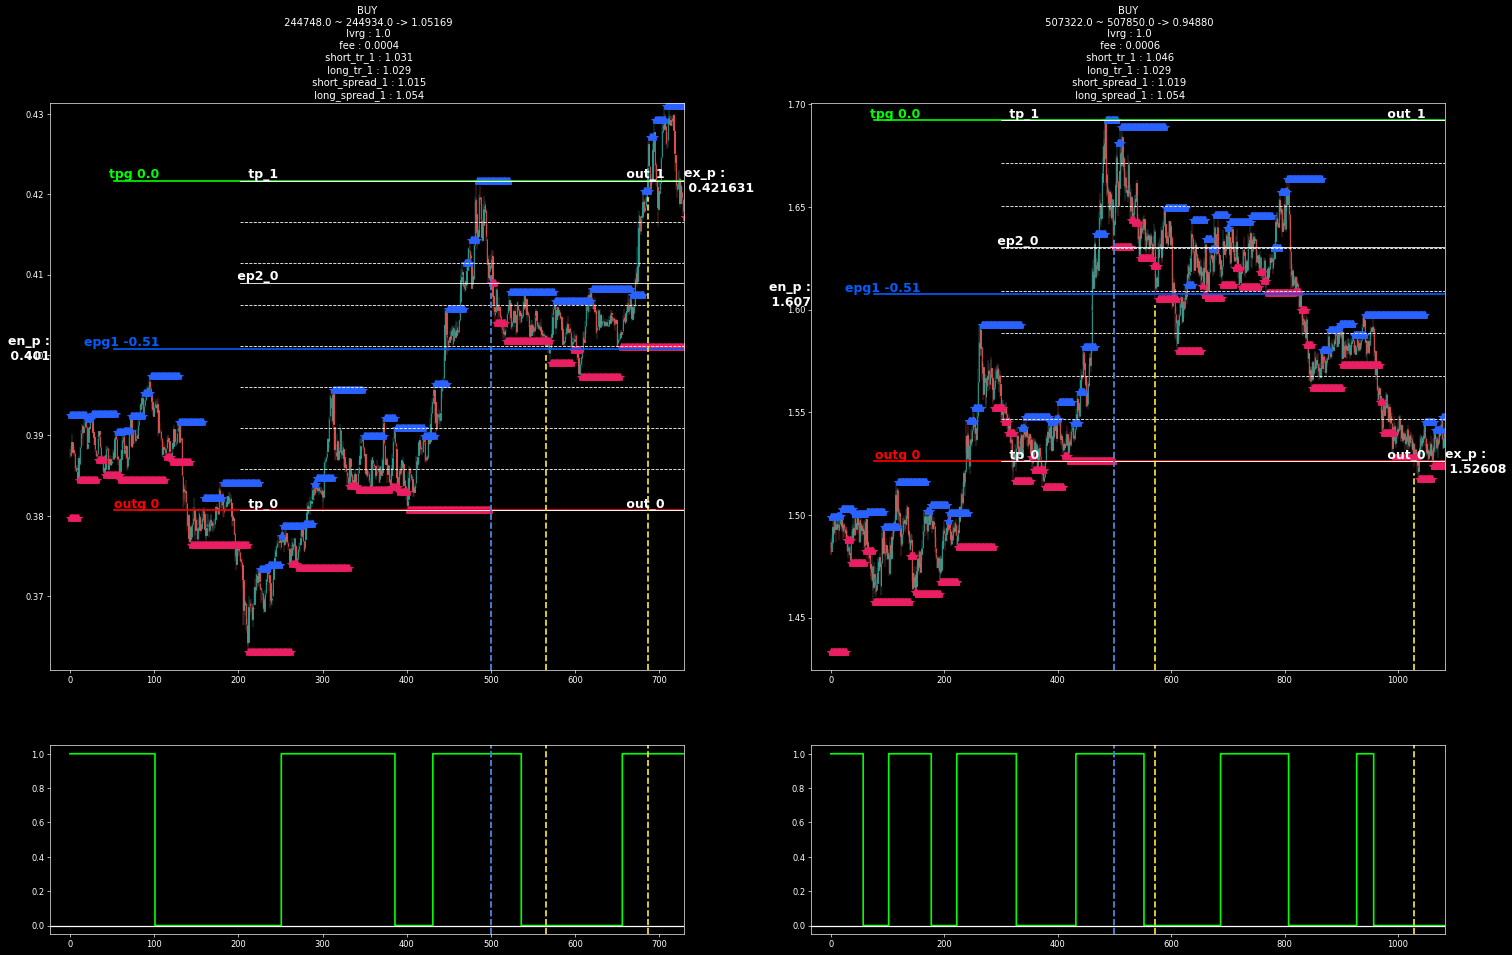

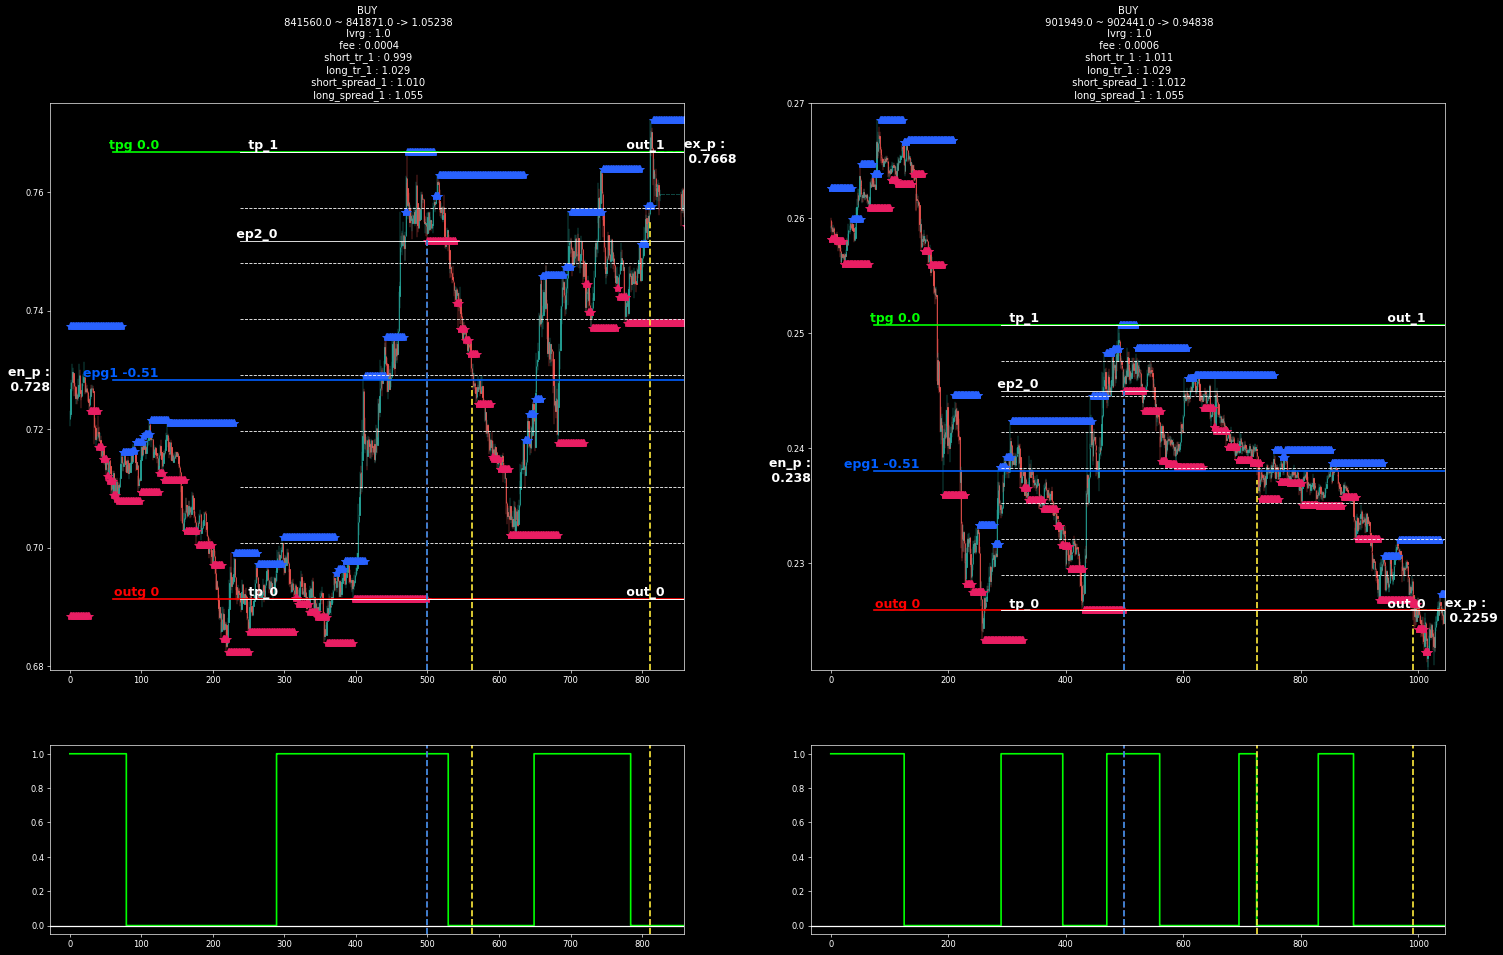

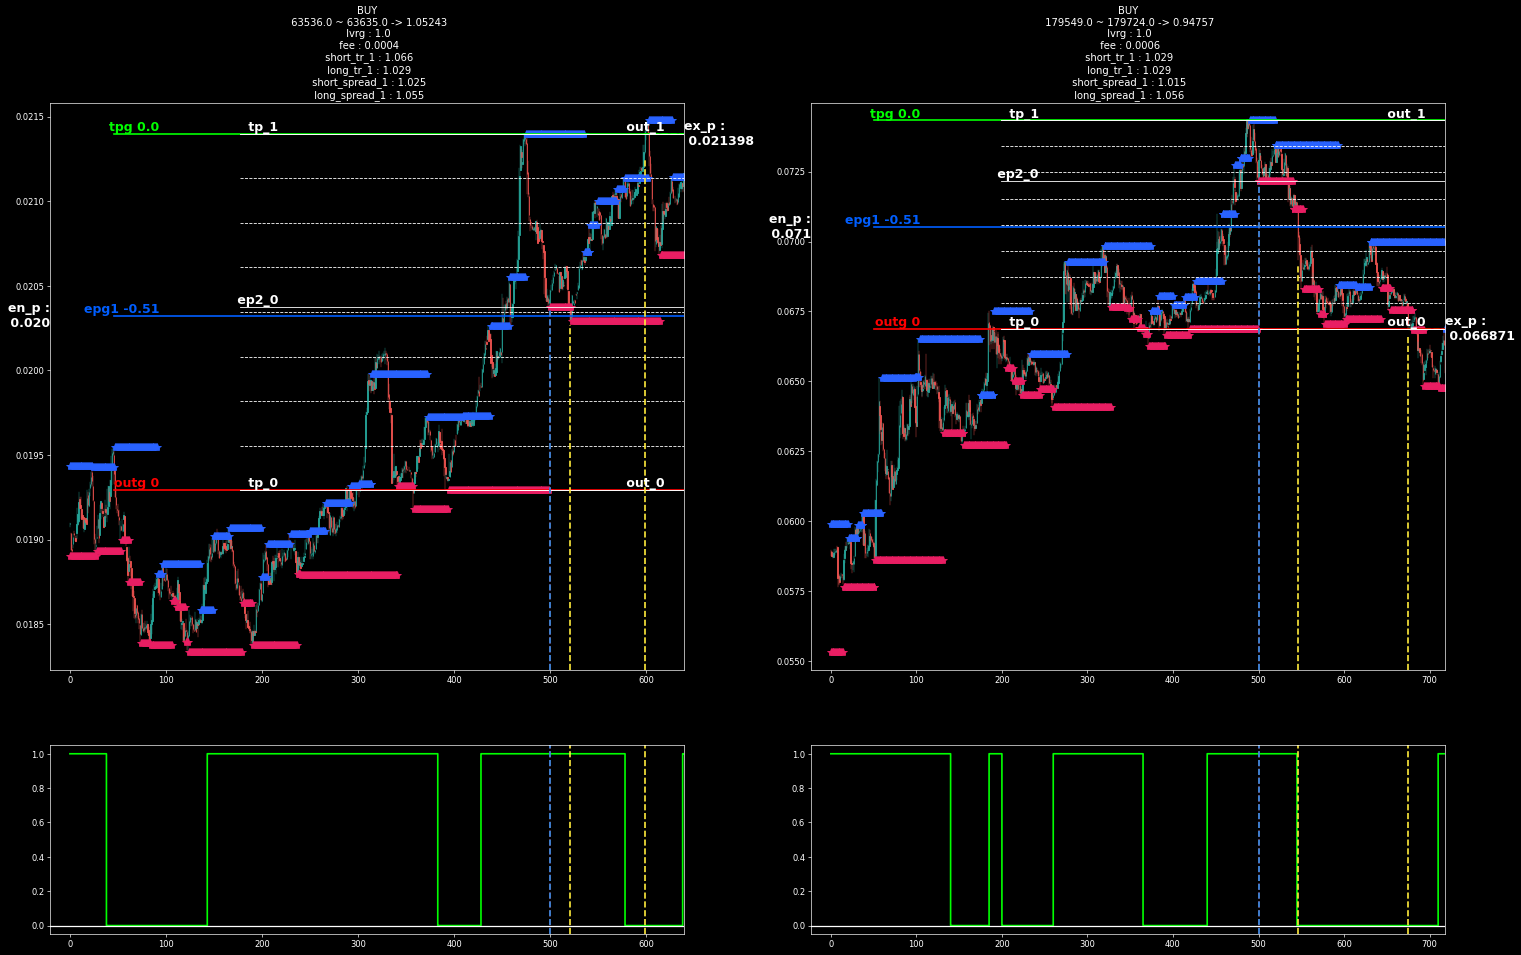

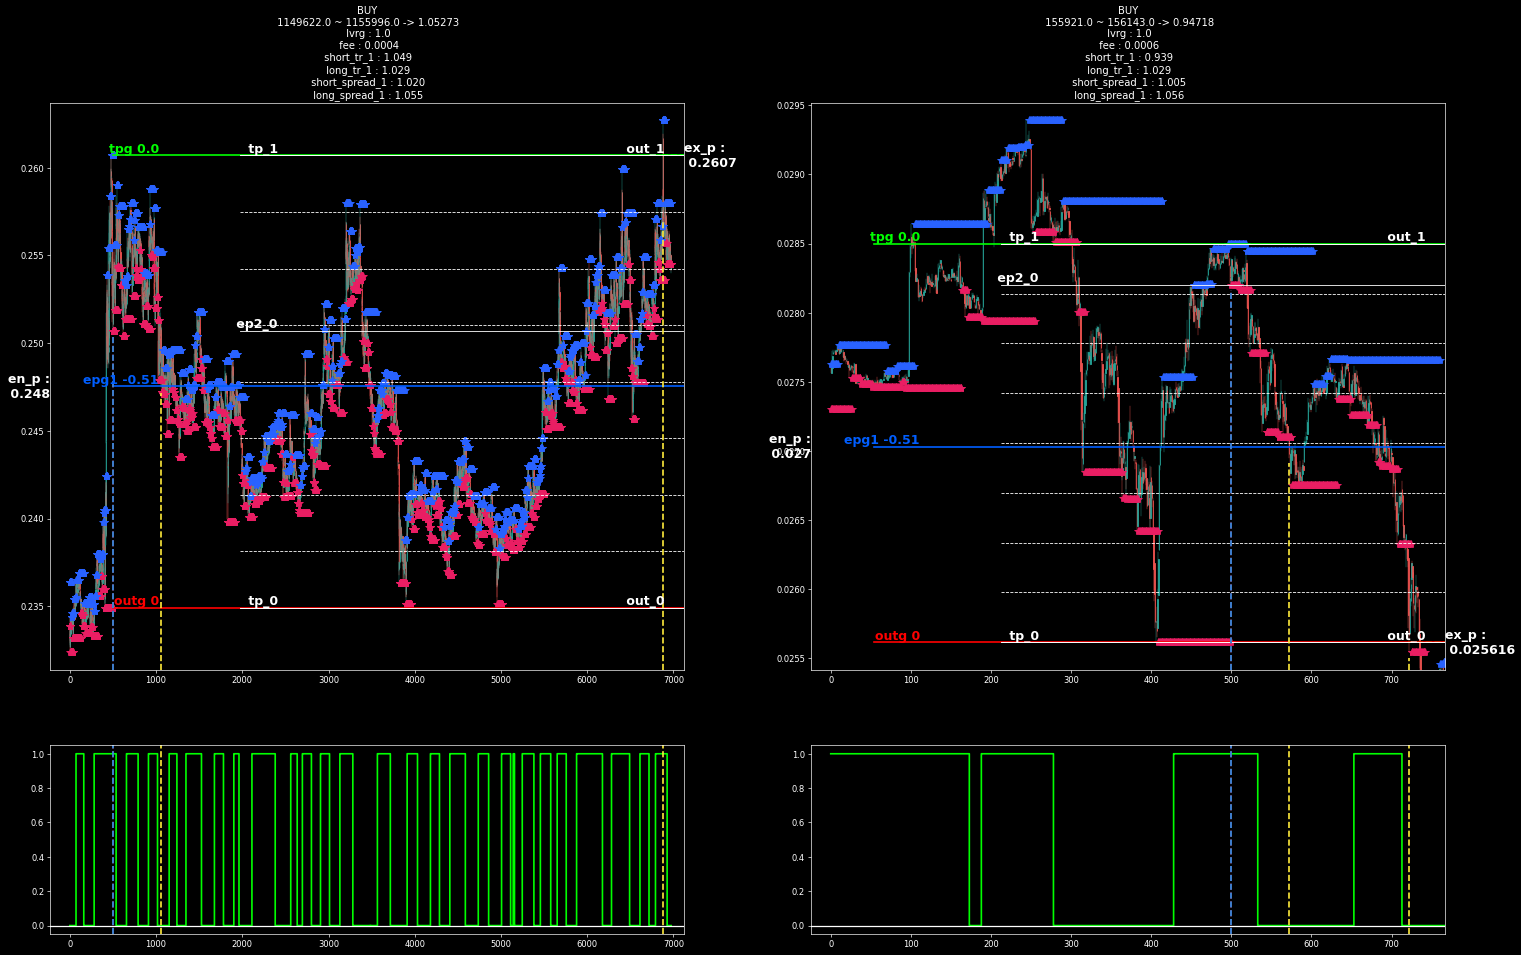

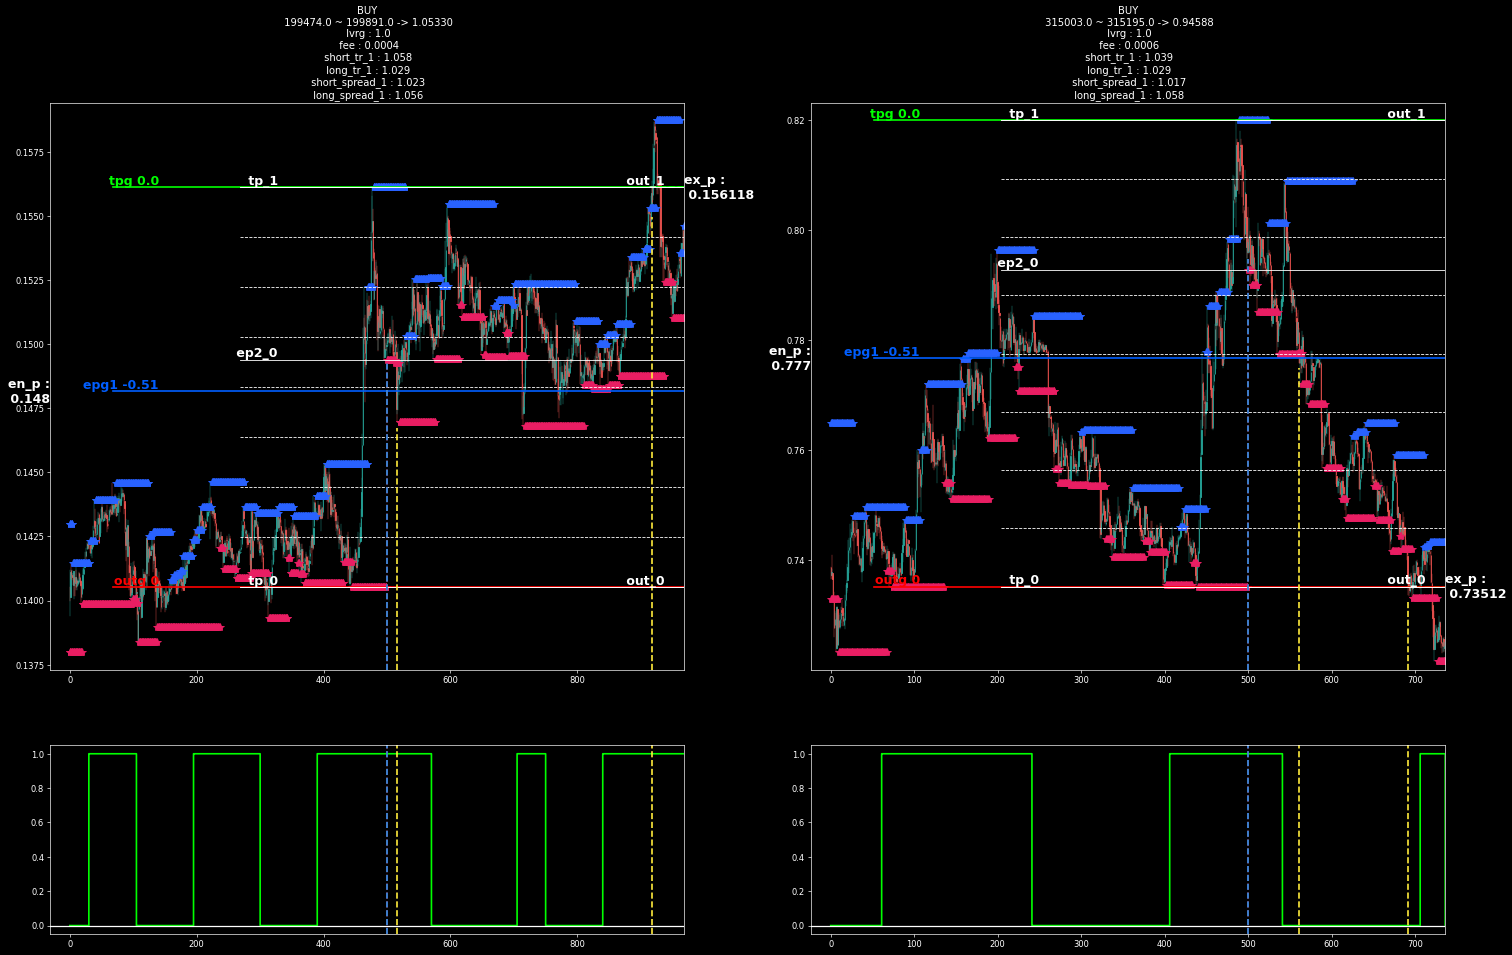

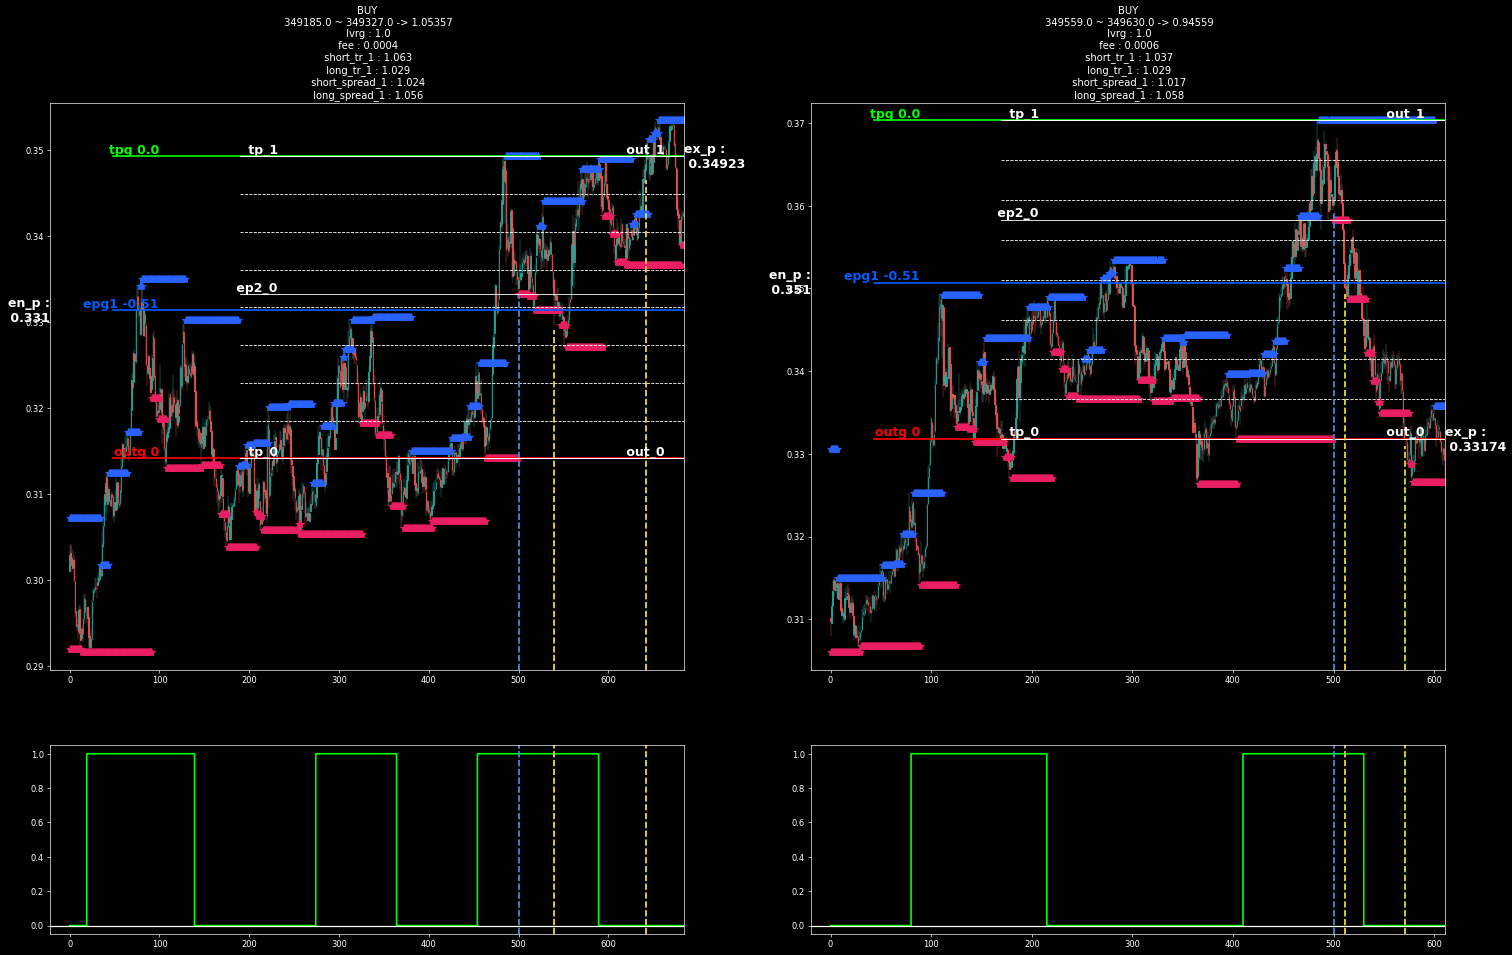

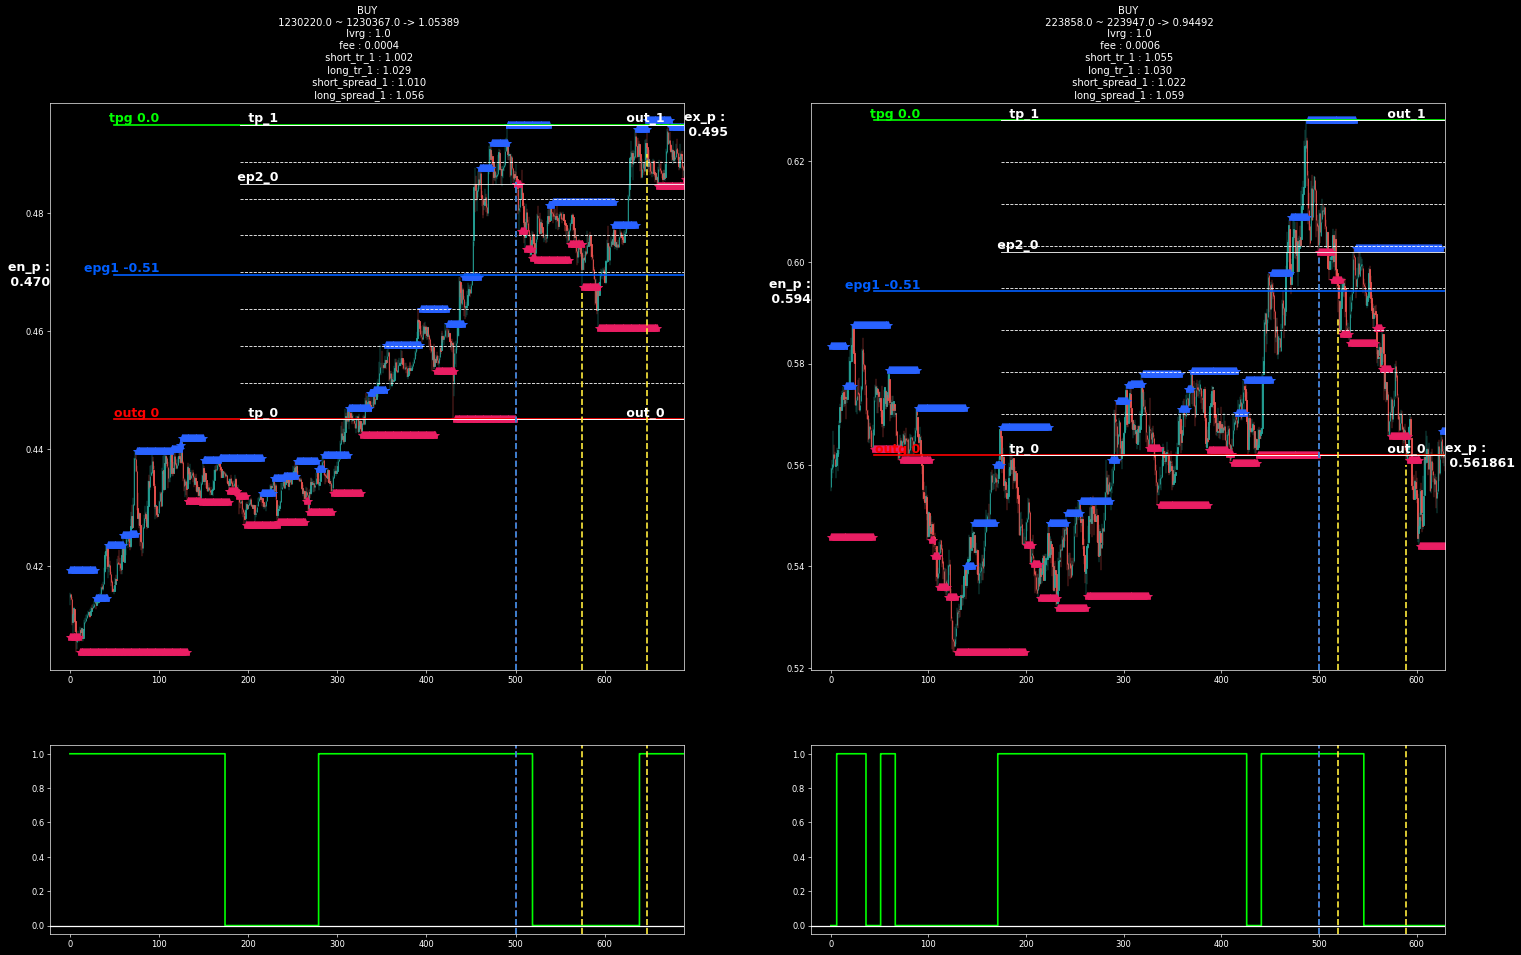

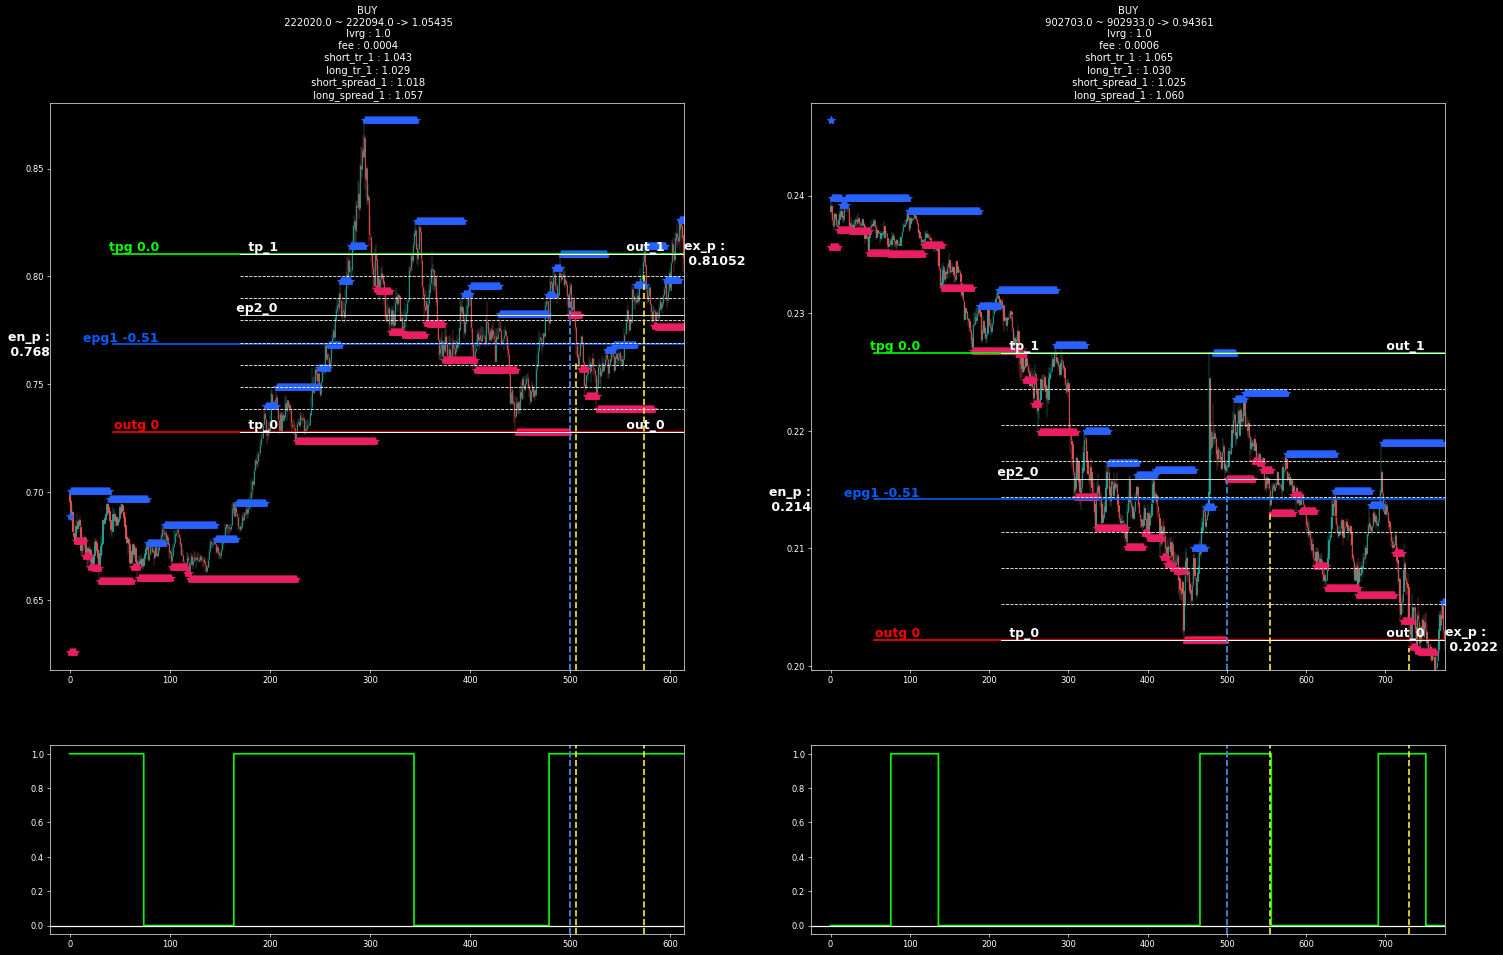

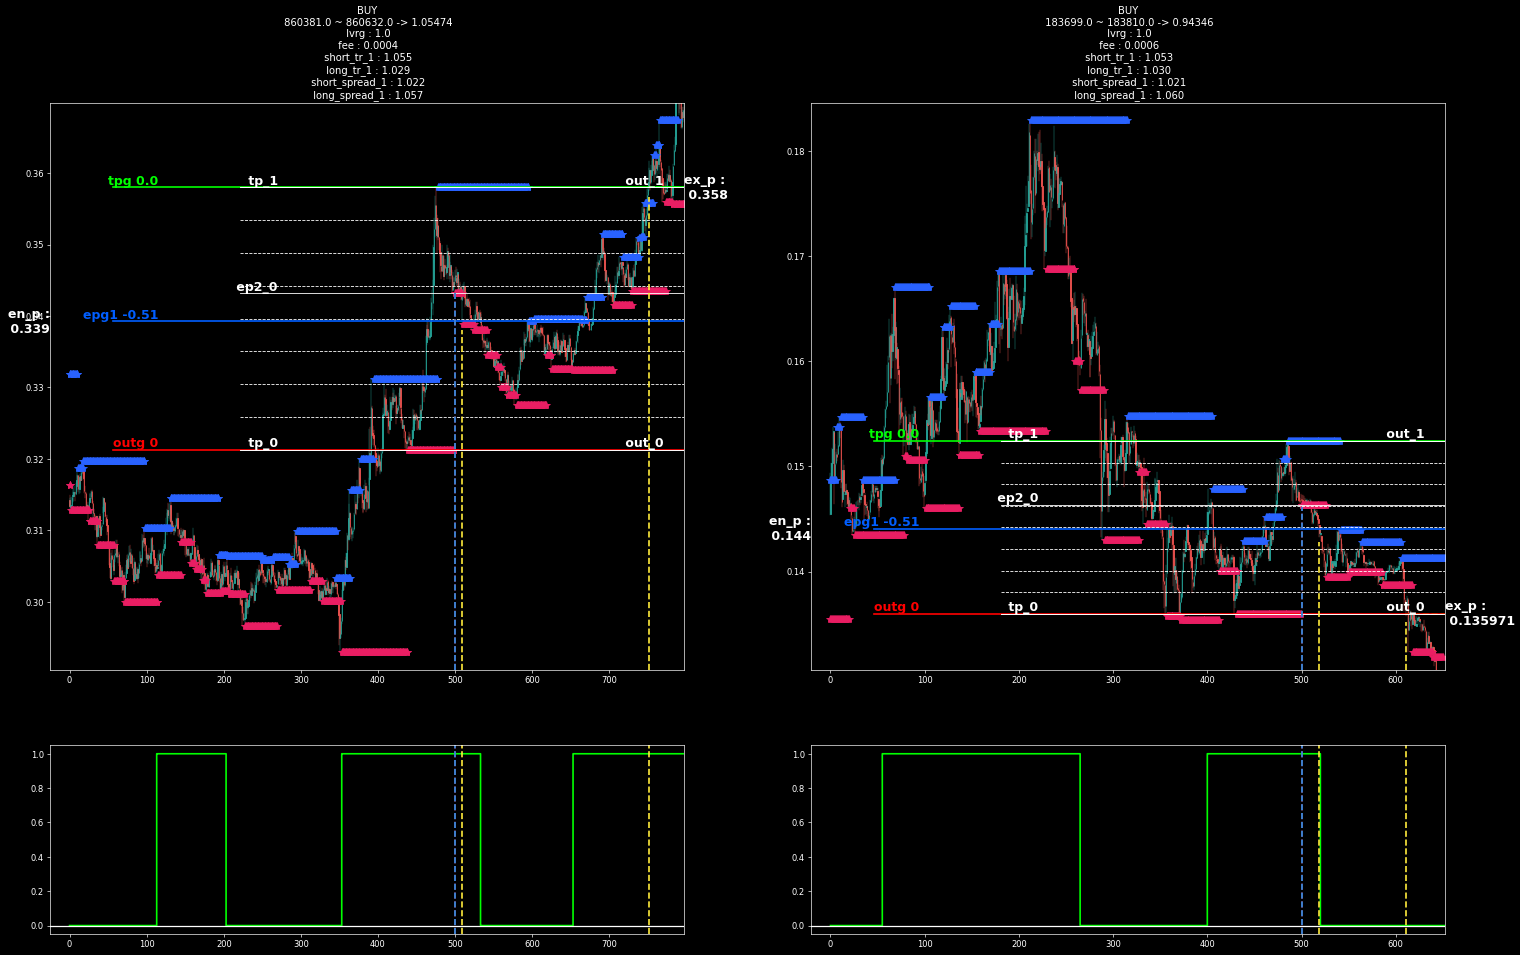

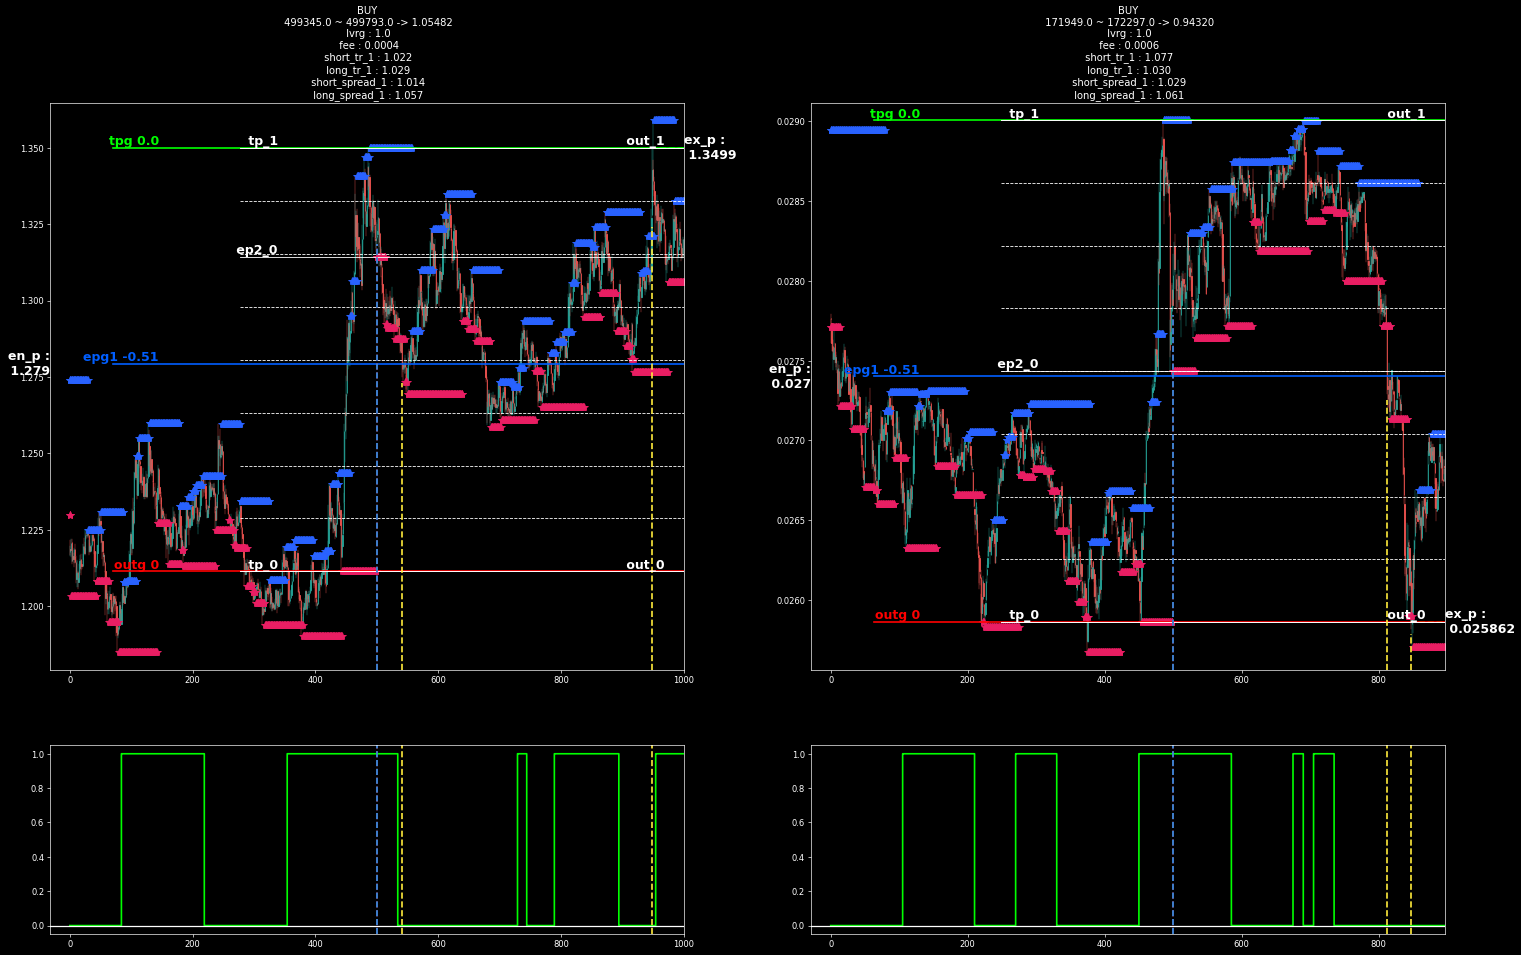

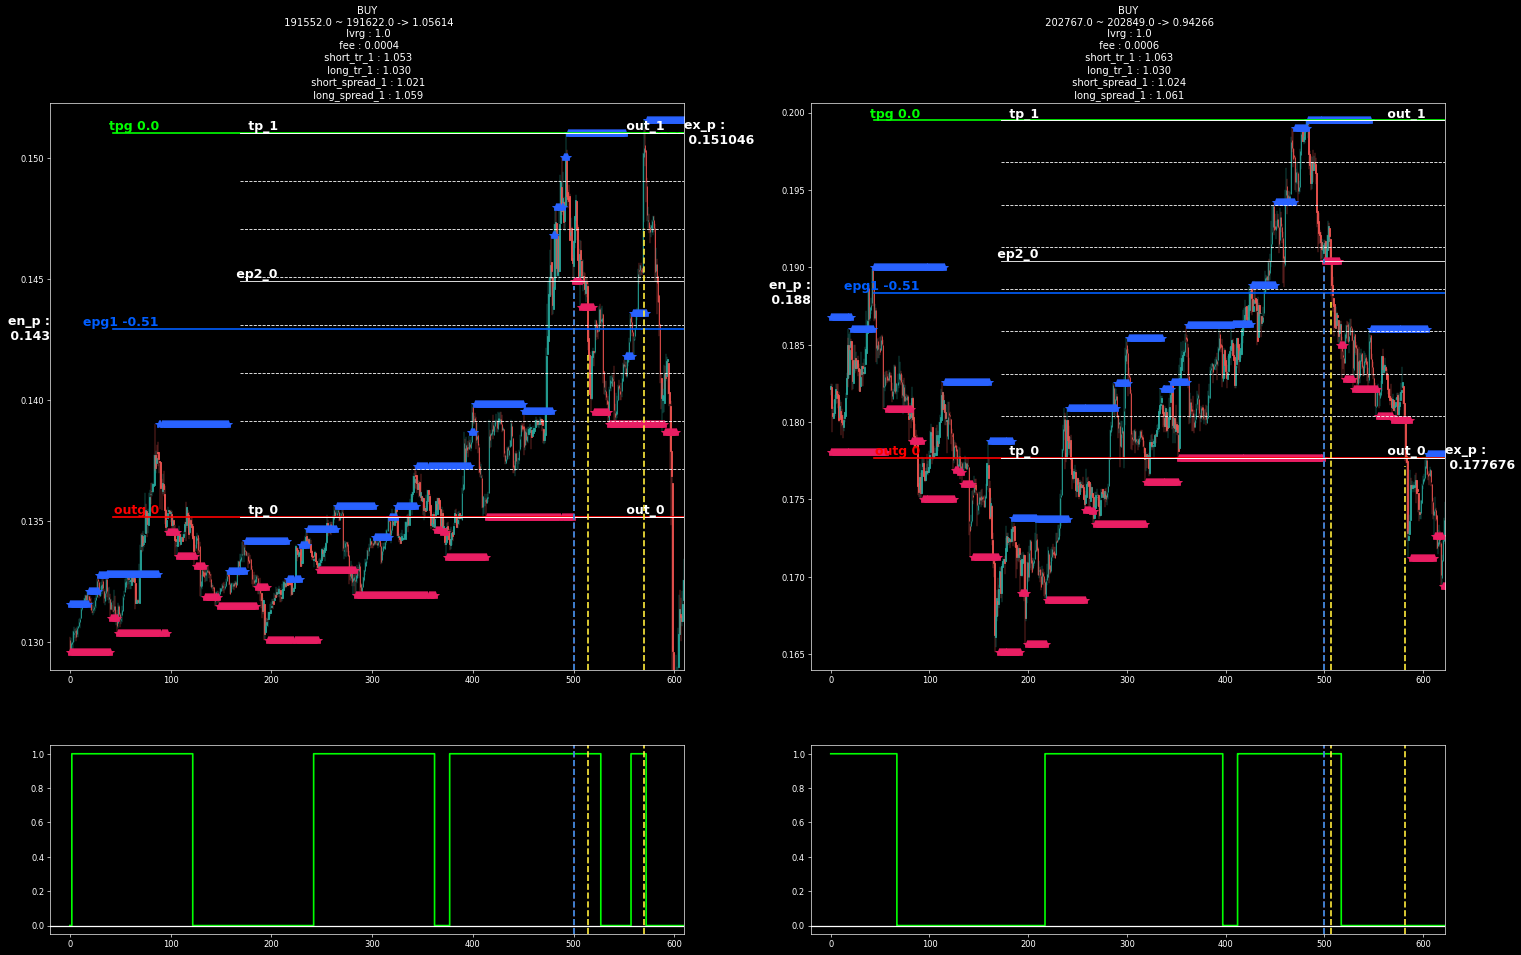

KeyboardInterrupt: 

In [29]:
# p2_hlm 의 경우, tr 확인을 우해 session_plot 우선 실행 필요함
_ = [plot_check_v9(res_df, config, param_zip, pr_msg, x_max, x_margin_mult, y_margin_mult, back_plot, plot_check_dir, **col_idx_dict) for param_zip in zip(np_plot_params, np_plot_params[::-1])]

### plot method override

#### plot_check

In [141]:
def plot_check_v9(res_df, config, param_zip, pr_msg, x_max, x_margin_mult, y_margin_mult, back_plot, plot_check_dir=None, **col_idx_dict):
    # start_0 = time.time()
    plt.style.use(['dark_background', 'fast'])
    fig = plt.figure(figsize=(30, 18), dpi=60)
    nrows, ncols = 2, 2
    gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                           ncols=ncols,
                           height_ratios=[3, 1]
                           )
    for gs_idx, params in enumerate(param_zip):

        iin, iout, pr, en_p, ex_p, entry_idx, exit_idx, p1_idx, p2_idx, lvrg, fee, tp_line, out_line, tp_1, tp_0, out_1, out_0, ep2_0 = params

        # print("en_p, ex_p :", en_p, ex_p)
        # print("tp_line, out_line, ep2_0 :", tp_line, out_line, ep2_0)

        # temporary
        # if exit_idx - p1_idx < 50:
        # if exit_idx != entry_idx:
        # print("p1_idx :", p1_idx)
        # if p1_idx != 370259:
        #   break

        # 1. define ax1 & ax2
        ax1 = fig.add_subplot(gs[gs_idx])
        ax2 = fig.add_subplot(gs[gs_idx + 2])

        # 2. data range
        #    a. hvline phase 에서 ylime 을 data[:x_max 로 정하기 때문에 iin + x_max 사용한다.
        if back_plot == 0:
            iout = iin + x_max
            # iout = iout + x_max
            # print("iin, iout :", iin, iout)

        a_data = res_df.iloc[int(iin):int(iout + 1)].to_numpy()
        # a_data = data[iin:iout]

        # 3. add_col section
        #     a. candles
        candle_plot_v2(ax1, a_data[:, col_idx_dict['ohlc_col_idxs']], alpha=1.0, wickwidth=1.0)

        #     b. add cols
        [nonstep_col_plot_v2(ax1, a_data[:, params_[0]], *params_[1:]) for params_ in col_idx_dict['nonstep_col_info']]
        [step_col_plot_v2(ax1, a_data[:, params_[0]], *params_[1:]) for params_ in col_idx_dict['step_col_info']]
        [stepmark_col_plot_v2(ax1, a_data[:, params_[0]], *params_[1:]) for params_ in col_idx_dict['stepmark_col_info']]

        [step_col_plot_v2(ax2, a_data[:, params_[0]], *params_[1:]) for params_ in col_idx_dict['step_col_info2']]

        #     c. get vp_info
        kde_factor = 0.1  # 커질 수록 전체적인 bars_shape 이 곡선이됨, 커질수록 latency 좋아짐 (0.00003s 정도)
        num_samples = 100  # plot 되는 volume bars (y_axis) 와 비례관계

        #         i. get vp_infovp by lookback
        # vp_lookback = 500
        # vp_data = res_df.iloc[int(p1_idx - 500):int(p1_idx), col_idx_dict['vp_col_idxs']].to_numpy().T

        #         ii. vp by wave_point
        #     if tp_1 < out_0:  # SELL order
        #       post_co_idx = res_df.iloc[int(p1_idx), col_idx_dict['post_co_idx']]
        #       # vp_iin = res_df.iloc[int(p1_idx) - 1, col_idx_dict['post_cu_idx']].to_numpy()  # Todo, co_idx 와 co_post_idx 의 차별을 위해서 -1 해줌 <-- 중요 point
        #       vp_iin = res_df.iloc[post_co_idx, col_idx_dict['post_cu_idx']].to_numpy() # post_co_idx 에 있는 post_cu_idx ?
        #     else:
        #       post_cu_idx = res_df.iloc[int(p1_idx), col_idx_dict['post_cu_idx']]
        #       # vp_iin = res_df.iloc[int(p1_idx) - 1, col_idx_dict['post_co_idx']].to_numpy()
        #       vp_iin = res_df.iloc[int(post_cu_idx), col_idx_dict['post_co_idx']].to_numpy()
        #       # print("post_cu_idx, vp_iin :", post_cu_idx, vp_iin)

        #     vp_data = res_df.iloc[int(vp_iin):int(p1_idx), col_idx_dict['vp_col_idxs']].to_numpy().T   # vp : ~ post_cu / co_idx 까지

        #     vp_info = [*vp_data, kde_factor, num_samples]
        vp_info = []

        #     d. ep, tp + xlim
        try:
            eptp_hvline_v9_1(ax1, ax2, config, *params, back_plot, x_max, x_margin_mult, y_margin_mult, a_data, vp_info, **col_idx_dict)
        except Exception as e:
            print("error in eptp_hvline :", e)

        """ Todo """
        #     e. outer_price plot 일 경우, gs_idx + nrows 하면 됨

        # 4. trade_info
        data_msg_list = ["\n {} : {:.3f}".format(*params_[1:], *res_df.iloc[int(p1_idx), params_[0]]) for params_ in
                         col_idx_dict['data_window_p1_col_info']]  # * for unsupported format for arr
        data_msg_list += ["\n {} : {:.3f}".format(*params_[1:], *res_df.iloc[int(p2_idx), params_[0]]) for params_ in
                          col_idx_dict['data_window_p2_col_info']]
        ps_msg_expand = pr_msg.format(p1_idx, exit_idx, pr, lvrg, fee) + ''.join(data_msg_list)

        ax1.set_title(ps_msg_expand)  # set_title on ax1

    if plot_check_dir is None:
        plt.show()
        print()
    else:
        fig_name = plot_check_dir + "/{}.png".format(int(entry_idx))
        plt.savefig(fig_name)
        print(fig_name, "saved !")
    plt.close()
    # print("elapsed time :", time.time() - start_0)

    return

#### eptp_hvline

In [136]:
def eptp_hvline_v9_1(ax1, ax2, config, iin, iout, pr, en_p, ex_p, entry_idx, exit_idx, p1_idx, p2_idx, lvrg, fee, tp_level, out_level, tp_1, tp_0,
                     out_1, out_0, ep2_0, back_plot, x_max, x_margin_mult, y_margin_mult, a_data, vp_info, **col_idx_dict):
    
    """
    기존 y_lim 에서 tr_set 기준 min & max 를 추가함 (indicator 에 의한 y_lim 을 유지하기 위해 추가하는 방법 사용함.)
    """
    
    # 1. get vertical ticks
    entry_tick = int(entry_idx - iin)
    exit_tick = entry_tick + int(exit_idx - entry_idx)
    p1_tick = entry_tick - int(entry_idx - p1_idx)
    p2_tick = p1_tick + int(p2_idx - p1_idx)

    if back_plot == 1:
        x_max = p1_tick + 20
    elif back_plot == 2:
        x_max = p2_tick + 20
    elif back_plot == 3:
        x_max = entry_tick + 20
    elif back_plot == 4:
        x_max = exit_tick + 20

    # 2. get_xlim 
    if (iout - iin) > x_max:
        x_margin = x_max * x_margin_mult
        ax1.set_xlim(0 - x_margin, x_max + x_margin)
        ax2.set_xlim(0 - x_margin, x_max + x_margin)
    x0, x1 = ax1.get_xlim()

    """ 1. Axis_1 """
    #     a. entry & exit
    en_xmin = entry_tick / x1
    ex_xmin = exit_tick / x1
    ax1.text(x0, en_p, 'en_p :\n {:.3f}'.format(en_p), ha='right', va='center', fontweight='bold', fontsize=15)  # en_p line label

    ax1.axhline(ex_p, ex_xmin, 1, linewidth=2, linestyle='--', alpha=1, color='lime')  # ex_p line axhline (signal 도 포괄함, 존재 의미)
    ax1.text(x1, ex_p, 'ex_p :\n {}'.format(ex_p), ha='left', va='center', fontweight='bold', fontsize=15)  # ex_p line label

    #     b. tr_set line
    left_point = 0.1
    right_point = 1
    text_x_pos_left = (x0 + x1) * (left_point + 0.05)

    ax1.axhline(en_p, left_point, right_point, linewidth=2, linestyle='-', alpha=1, color='#005eff')  # en_p line axhline

    if config.tr_set.check_hlm in [0, 1]:
        plot_epg_tuple = ("epg1", config.tr_set.ep_gap1)
    else:
        plot_epg_tuple = ("epg2", config.tr_set.ep_gap2)
    ax1.text(text_x_pos_left, en_p, '{} {}'.format(*plot_epg_tuple), ha='right', va='bottom', fontweight='bold', fontsize=15, color='#005eff')

    ax1.axhline(tp_level, left_point, right_point, linewidth=2, linestyle='-', alpha=1, color='#00ff00')  # ep 와 gap 비교 용이하기 위해 ex_xmin -> 0.1 사용
    ax1.text(text_x_pos_left, tp_level, 'tpg {}'.format(config.tr_set.tp_gap), ha='right', va='bottom', fontweight='bold', fontsize=15, color='#00ff00')

    ax1.axhline(out_level, left_point, right_point, linewidth=2, linestyle='-', alpha=1, color='#ff0000')
    ax1.text(text_x_pos_left, out_level, 'outg {}'.format(config.tr_set.out_gap), ha='right', va='bottom', fontweight='bold', fontsize=15, color='#ff0000')

    #     c. tp_box    
    left_point = 0.3
    right_point = 1
    text_x_pos_left = (x0 + x1) * (left_point + 0.05)
    text_x_pos_right = (x0 + x1) * right_point
    
    ax1.axhline(tp_1, left_point, right_point, linewidth=1, linestyle='-', alpha=1, color='#ffffff')
    ax1.text(text_x_pos_left, tp_1, ' tp_1', ha='right', va='bottom', fontweight='bold', fontsize=15)
    ax1.axhline(tp_0, left_point, right_point, linewidth=1, linestyle='-', alpha=1, color='#ffffff')
    ax1.text(text_x_pos_left, tp_0, ' tp_0', ha='right', va='bottom', fontweight='bold', fontsize=15)

    #     d. octa_wave_box
    wave_gap = (tp_1 - tp_0) / 8
    [ax1.axhline(tp_0 + wave_gap * gap_i, left_point, right_point, linewidth=1, linestyle='--', alpha=1, color='#ffffff') for gap_i in range(1, 8)]

    #     e. ep_box
    ax1.axhline(ep2_0, left_point, right_point, linewidth=1, linestyle='-', alpha=1, color='#ffffff')
    ax1.text(text_x_pos_left, ep2_0, ' ep2_0', ha='right', va='bottom', fontweight='bold', fontsize=15)

    #     f. out_box
    ax1.axhline(out_1, left_point, right_point, linewidth=1, linestyle='-', alpha=1, color='#ffffff')
    ax1.text(text_x_pos_right, out_1, ' out_1', ha='right', va='bottom', fontweight='bold', fontsize=15)
    ax1.axhline(out_0, left_point, right_point, linewidth=1, linestyle='-', alpha=1, color='#ffffff')
    ax1.text(text_x_pos_right, out_0, ' out_0', ha='right', va='bottom', fontweight='bold', fontsize=15)

    #     g. volume profile
    if len(vp_info) > 0:
        close, volume, kde_factor, num_samples = vp_info
        # if iin >= vp_range:
        # start_0 = time.time()
        kde = stats.gaussian_kde(close, weights=volume, bw_method=kde_factor)
        kdx = np.linspace(close.min(), close.max(), num_samples)
        kdy = kde(kdx)
        kdy_max = kdy.max()
        # print("kde elapsed_time :", time.time() - start_0)

        # peaks,_ = signal.find_peaks(kdy, prominence=kdy_max * 0.3)   # get peak_entries
        # peak_list = kdx[peaks]   # peak_list
        # [ax1.axhline(peak, linewidth=1, linestyle='-', alpha=1, color='orange') for peak in peak_list]

        kdy_ratio = p1_tick / kdy_max  # 30 / 0.0001   # max_value 가 p1_tick 까지 닿을 수 있게.
        # print("kdx :", kdx)
        # ax1.plot(kdy * kdy_ratio, kdx, color='white')  # Todo, bars 가능 ?
        # ax1.barh(kdy * kdy_ratio, kdx, color='white')  # Todo, bars 가능 ?
        ax1.barh(kdx, kdy * kdy_ratio, color='#00ff00', alpha=0.5)  # Todo, bars 가능 ?

    #     c. ylim - ax1 only    
    #         i. ylim by tr_set
    y_min = min(tp_level, out_level, tp_1, tp_0, out_1, out_1)
    y_max = max(tp_level, out_level, tp_1, tp_0, out_1, out_1)
      
    #         ii. ylim by indicator
    if len(col_idx_dict['ylim_col_idxs']) != 0:
        if back_plot:
            y_lim_data = a_data[:x_max + 1, col_idx_dict['ylim_col_idxs']]  # +1 for including p1_tick
        else:
            y_lim_data = a_data[:, col_idx_dict['ylim_col_idxs']]        

        y_min = min(y_lim_data.min(), y_min)
        y_max = max(y_lim_data.max(), y_max)    
    
    y_margin = (y_max - y_min) * y_margin_mult
    ax1.set_ylim(y_min - y_margin, y_max + y_margin)
    
    """ 2. Axis_2 """
    #     x. realtime_ud
    ax2.axhline(0, color="#ffffff")

    #     a. cci_band
    # ax2.axhline(100, color="#ffffff")
    # ax2.axhline(0, color="#ffffff")
    # ax2.axhline(-100, color="#ffffff")

    #     b. stoch_band
    # ax2.axhline(67, color="#ffffff")
    # ax2.axhline(33, color="#ffffff")
    # ax2.axhline(0, color="#ffffff")


    # 3. public vline (p1_tick, entry_tick, exit_tick - add p1_tick on ax2
    y0, y1 = ax1.get_ylim()
    low_data = a_data[:exit_tick + 1, col_idx_dict['ohlc_col_idxs'][2]]  # +1 for including exit_tick
    p2_ymax, en_ymax, ex_ymax = [(low_data[tick_] - y0) / (y1 - y0) - .01 for tick_ in [p2_tick, entry_tick, exit_tick]]  # -.05 for margin
    if p1_tick > 0:
        p1_ymax = (low_data[p1_tick] - y0) / (y1 - y0) - .01
        ax1.axvline(p1_tick, 0, p1_ymax, alpha=1, linewidth=2, linestyle='--', color='#ff0000')  # 추후, tick 별 세부 정의가 달라질 수 있음을 고려해 multi_line 작성 유지
        ax2.axvline(p1_tick, 0, 1, alpha=1, linewidth=2, linestyle='--', color='#ff0000')
    ax1.axvline(p2_tick, 0, p2_ymax, alpha=1, linewidth=2, linestyle='--', color='#2196f3')
    ax1.axvline(entry_tick, 0, en_ymax, alpha=1, linewidth=2, linestyle='--', color='#ffeb3b')
    ax1.axvline(exit_tick, 0, ex_ymax, alpha=1, linewidth=2, linestyle='--', color='#ffeb3b')
    ax2.axvline(p2_tick, 0, 1, alpha=1, linewidth=2, linestyle='--', color='#2196f3')
    ax2.axvline(entry_tick, 0, 1, alpha=1, linewidth=2, linestyle='--', color='#ffeb3b')
    ax2.axvline(exit_tick, 0, 1, alpha=1, linewidth=2, linestyle='--', color='#ffeb3b')

    return

### Whole plot

#### whole plot indicators

In [ ]:
s_id = config.selection_id

# ------------ make col_idx_dict config ------------ #
nonstep_col_list = []
step_col_list = []
stepmark_col_list = []

# ============ nonstep_col_list - add info(col, alpha, color, linewidth) ============ #
# nonstep_col_list.append([['close'], 1, '#ffffff', 2])

# ============ step_col_list - add info(col, alpha, color, linewidth) ============ #
# ------ htf_candle ------ #
hc_tf1 = '15T'
hc_tf2 = 'H'
hc_tf3 = '4H'

step_col_list.append([['open_{}'.format(hc_tf1), 'close_{}'.format(hc_tf1)], 1, '#ffffff', 1])
step_col_list.append([['open_{}'.format(hc_tf2), 'close_{}'.format(hc_tf2)], 1, '#ffffff', 2])
# step_col_list.append([['open_{}'.format(hc_tf3), 'close_{}'.format(hc_tf3)], 1, '#ffffff', 4])

# ------ resi_sup ------ #
# rs_tf = 'T'
# step_col_list.append([['resi_{}'.format(rs_tf), 'sup_{}'.format(rs_tf)], 1, '#ffeb3b', 1])
# step_col_list.append([['resi_out_{}'.format(rs_tf), 'sup_out_{}'.format(rs_tf)], 1, 'dodgerblue', 2])

# ------ wave_range ------ #
wave_tf1 = config_list[0].tr_set.p1_itv1
wave_period1, wave_period2 = config_list[0].tr_set.p1_period1, config_list[0].tr_set.p1_period2

# step_col_list.append([['dc_upper_{}{}'.format(wave_tf1, wave_period1), 'dc_lower_{}{}'.format(wave_tf1, wave_period1)], 1, '#ffeb3b', 1])
# step_col_list.append([['dc_upper_{}{}'.format(wave_tf1, wave_period2), 'dc_lower_{}{}'.format(wave_tf1, wave_period2)], 1, '#ffeb3b', 1])

# step_col_list.append([['dc_upper_{}{}'.format(wave_tf2, wave_period2), 'dc_lower_{}{}'.format(wave_tf2, wave_period2)], 1, '#e65100', 2])

# ------ dc ------ #
dc_tf1 = '5T'
dc_period1 = 20
dc_tf2 = 'H'
dc_period2 = 20
# step_col_list.append([['dc_upper_{}{}'.format(dc_tf1, dc_period1), 'dc_lower_{}{}'.format(dc_tf1, dc_period1)], 1, '#ffeb3b', 1]),  # inner
# step_col_list.append([['dc_base_{}{}'.format(dc_tf1, dc_period1)], 1, '#5b9cf6', 1])
step_col_list.append([['dc_upper_{}{}'.format(dc_tf2, dc_period2), 'dc_lower_{}{}'.format(dc_tf2, dc_period2)], 1, '#ff00ff', 4]),  # inner
step_col_list.append([['dc_base_{}{}'.format(dc_tf2, dc_period2)], 1, '#5b9cf6', 4])

# ------ bb ------ #
bb_tf1 = 'T'
bb_period1 = 20

# step_col_list.append([['bb_upper_{}{}'.format(bb_tf1, bb_period1), 'bb_lower_{}{}'.format(bb_tf1, bb_period1)], 1, '#ffffff', 1])
# step_col_list.append([['bb_base_{}{}'.format(bb_tf1, bb_period1)], 1, '#00ff00', 1])

# step_col_list.append([['bb_upper_{}'.format(tf2), 'bb_lower_{}'.format(tf2)], 1, '#e91e63', 4])

# ------ ema ------ #
# step_col_list.append([['ema_5T'], 1, '#03ed30', 2])

# ============ stepmark_col_list - add info(col, alpha, color, linewidth) ============ #
# stepmark_col_list.append([['sar_T'], 1, 'dodgerblue', 7])


# ============ str to numbcol ============ #
nonstep_col_arr = strcol_tonumb(res_df, nonstep_col_list)
step_col_arr = strcol_tonumb(res_df, step_col_list)
stepmark_col_arr = strcol_tonumb(res_df, stepmark_col_list)

col_idx_dict = \
{
  "ohlc_col_idxs": get_col_idxs(res_df, ['open', 'high', 'low', 'close']),
  "vp_col_idxs": get_col_idxs(res_df, ['close', 'volume']),
  # "ohlc_col_idxs": get_col_idxs(res_df, ['haopen', 'hahigh', 'halow', 'haclose']),  # heikin-ashi ver.
  "nonstep_col_info": nonstep_col_arr,
  "step_col_info": step_col_arr,
  "stepmark_col_info": stepmark_col_arr,
  "ylim_col_idxs": get_col_idxs(res_df, ['open', 'high', 'low', 'close', 'dc_upper_15T4', 'dc_lower_15T4'])  # , 'dc_upper_H', 'dc_lower_H', 'dc_upper_15T', 'dc_lower_15T', 'short_out_{}'.format(selection_id), 'long_out_{}'.format(selection_id)
}   # , 'wave_1_{}'.format(wave_tf2), 'wave_0_{}'.format(wave_tf2), 'dc_upper_15T', 'dc_lower_15T'

#### whole_plot main

In [ ]:
plot_op_idx_nums = 10

win_idxs = (pr_ > 1).ravel()  # [-plot_op_idx_nums:]
selected_op_idxs = obj_[4].ravel().astype(int)  # [-plot_op_idx_nums:]
selected_ex_idxs = obj_[3].ravel().astype(int)  # [-plot_op_idx_nums:]

len_idxs = len(win_idxs)
print("len_idxs :", len_idxs)

split_range = np.arange(plot_op_idx_nums, len_idxs, plot_op_idx_nums)
win_idxs_list = np.split(win_idxs, split_range, axis=0)
selected_op_idxs_list = np.split(selected_op_idxs, split_range, axis=0)
selected_ex_idxs_list = np.split(selected_ex_idxs, split_range, axis=0)

In [ ]:
_ = [whole_plot_check(np_df, a, b, c, plot_check_dir=None, **col_idx_dict) for a, b, c in zip(win_idxs_list, selected_op_idxs_list, selected_ex_idxs_list)]

#### whole_plot_check override

In [ ]:
def whole_plot_check(data, win_idxs, selected_op_idxs, selected_ex_idxs, plot_check_dir=None, **col_idx_dict):
  # start_0 = time.time()
  plt.style.use(['dark_background', 'fast'])
  fig = plt.figure(figsize=(30, 12), dpi=60)
  nrows, ncols = 1, 1
  gs = gridspec.GridSpec(nrows=nrows,  # row 부터 index 채우고 col 채우는 순서임 (gs_idx)
                          ncols=ncols,
                          #height_ratios=[31, 1]
                          )

  ax = fig.add_subplot(gs[0])

  # ------------ add_col section ------------ #
  a_data = data[selected_op_idxs[0]:selected_op_idxs[-1] + 1]

  plot_op_idxs = selected_op_idxs - selected_op_idxs[0]  
  plot_win_op_idxs = plot_op_idxs[win_idxs]
  plot_loss_op_idxs = plot_op_idxs[~win_idxs]

  plot_ex_idxs = selected_ex_idxs - selected_op_idxs[0]
  plot_win_ex_idxs = plot_ex_idxs[win_idxs]
  plot_loss_ex_idxs = plot_ex_idxs[~win_idxs]


  # ------ add cols ------ #
  [nonstep_col_plot(a_data[:, params[0]], *params[1:]) for params in col_idx_dict['nonstep_col_info']]
  [step_col_plot(a_data[:, params[0]], *params[1:]) for params in col_idx_dict['step_col_info']]
  [stepmark_col_plot(a_data[:, params[0]], *params[1:]) for params in col_idx_dict['stepmark_col_info']]

  # [plt.axvline(op_idx, color='#00ff00') for op_idx in plot_win_op_idxs]
  # [plt.axvline(op_idx, color='#ff0000') for op_idx in plot_loss_op_idxs]
  [plt.axvspan(op_idx, ex_idx, alpha=0.5, color='#00ff00') for op_idx, ex_idx in zip(plot_win_op_idxs, plot_win_ex_idxs)]
  [plt.axvspan(op_idx, ex_idx, alpha=0.5, color='#ff0000') for op_idx, ex_idx in zip(plot_loss_op_idxs, plot_loss_ex_idxs)]
  
  plt.show()

  if plot_check_dir is None:
    plt.show()
    print()
  else:
    fig_name = plot_check_dir + "/whole_plot_{}.png".format(selected_op_idxs[0])
    plt.savefig(fig_name)
    print(fig_name, "saved !")
  plt.close()
  # print("elapsed time :", time.time() - start_0)

  return

### legacy

### olds

#### whole_plot thing

In [ ]:
fig = go.Figure(data=[go.Candlestick(x=t_df.index,
                open=t_df.open,
                high=t_df.high,
                low=t_df.low,
                close=t_df.close)])

fig.show()

In [ ]:
cf.go_offline()
init_notebook_mode()

In [ ]:
qf = cf.QuantFig(t_df, title="Apple's stock price in 2021", name='AAPL')
qf.iplot()

#### brief np_pr survey

In [ ]:
# plot_pr_list[:100]
plt.plot(np_pr)
plt.axhline(1)
plt.show()

#### plot indi. legacy

#### tr_tresh calc

In [ ]:

  # ---------------------- ma ---------------------- #
   # --------- ema --------- #
  # alpha = 1
  # for sm_i, item in enumerate(ema_list):
  #   if sm_i > 0:
  #     lw = 5
  #   else:
  #     lw = 2
  #   plt.step(np.arange(len(plot_df)), plot_df[item].values, alpha=alpha, color='#03ed30', linewidth=lw)
  #   alpha -= 0.2

  #   # --------- sma --------- #
  # alpha = 1
  # for sm_i, sma in enumerate(sma_list):
  #   if sm_i > 0:
  #     lw = 5
  #   else:
  #     lw = 4
  #   plt.step(np.arange(len(plot_df)), plot_df[sma].values, alpha=alpha, color='#e91e63', linewidth=lw)
  #   alpha -= 0.2

  
  # ---------------------- cb ---------------------- #
  # alpha = 1
  # for sm_i, item in enumerate(cb_list):
  #   if sm_i > 0:
  #     lw = 5
  #   else:
  #     lw = 2
  #   plt.step(np.arange(len(plot_df)), plot_df[item].values, alpha=alpha, color='#5b9cf6', linewidth=lw)
  #   alpha -= 0.2


  
  # ---------------------- sar ---------------------- #
  # alpha = 1
  # markersize = 5
  # for sar in sar_list:
  #   plt.step(plot_df[sar].values, 'c*', alpha=alpha, markersize=markersize, color='dodgerblue')  # sar mic
  #   markersize += 1
  #   alpha -= 0.1

  # plt.step(plot_df.values[:, [12]], 'co', alpha=1, markersize=7)  # sar mac

  #               cloud               #
  # alpha = 0.7
  # for senkoua, senkoub in zip(senkoua_list, senkoub_list):
  #   plt.fill_between(np.arange(len(plot_df)), plot_df[senkoua].values, plot_df[senkoub].values, # ichimoku
  #                     where=plot_df[senkoua].values >= plot_df[senkoub].values, facecolor='g', alpha=alpha) # ichimoku
  #   plt.fill_between(np.arange(len(plot_df)), plot_df[senkoua].values, plot_df[senkoub].values,
  #                     where=plot_df[senkoua].values <= plot_df[senkoub].values, facecolor='r', alpha=alpha)  
  #   alpha -= 0.05
  


  # ---------------------- outer price indi. ---------------------- #
  #           macd          #
  # plt.subplot(312)
  # plt.subplot(gs[1])
  # alpha = 1
  # for macd in macd_list:
  #   plt.step(np.arange(len(plot_df)), plot_df[macd].values, 'g', alpha=alpha)
  #   # plt.fill_between(np.arange(len(plot_df)), 0, plot_df[macd].values, facecolor='g', alpha=alpha) 
  #   alpha -= 0.2

  # plt.axvline(prev_plotsize, linestyle='--')
  # plt.axvline(prev_plotsize + (tp_idx_list_[-1] - ep_idx_list_[0]), alpha=0.5, linestyle='--')
  # plt.axvline(prev_plotsize - (ep_idx_list_[0] - open_idx), alpha=0.5, linestyle='--', color='lime')

  # plt.axhline(0, linestyle='--')

  
  # #           trix          #  
  # # plt.subplot(313)
  # plt.subplot(gs[2])
  # alpha = 1
  # for trix in trix_list:
  #   plt.step(np.arange(len(plot_df)), plot_df[trix].values, 'g', alpha=alpha)
  #   # plt.fill_between(np.arange(len(plot_df)), 0, plot_df[macd].values, facecolor='g', alpha=alpha) 
  #   alpha -= 0.2
  # plt.axvline(prev_plotsize, linestyle='--')
  # plt.axvline(prev_plotsize + (tp_idx_list_[-1] - ep_idx_list_[0]), alpha=0.5, linestyle='--')
  # plt.axvline(prev_plotsize - (ep_idx_list_[0] - open_idx), alpha=0.5, linestyle='--', color='lime')
  # plt.axhline(0, linestyle='--')

  
  #           fisher          #  
  # plt.subplot(313)
  # plt.subplot(gs[1])
  # alpha = 1
  # for fisher in fisher_list:
  #   plt.step(np.arange(len(plot_df)), plot_df[fisher].values, 'g', alpha=alpha)
  #   # plt.fill_between(np.arange(len(plot_df)), 0, plot_df[macd].values, facecolor='g', alpha=alpha) 
  #   alpha -= 0.2
    
  # plt.axvline(prev_plotsize, linestyle='--')
  # plt.axvline(prev_plotsize + (tp_idx_list_[-1] - ep_idx_list_[0]), alpha=0.5, linestyle='--')
  # plt.axvline(prev_plotsize - (ep_idx_list_[0] - open_idx), alpha=0.5, linestyle='--', color='lime')

  # plt.axhline(0, linestyle='--')
  # plt.axhline(fisher_upper, linestyle='--')
  # plt.axhline(fisher_lower, linestyle='--')

  #           stoch          #  
  # plt.subplot(gs[1])
  # alpha = 1
  # for stoch_ in stoch_list:
  #   plt.step(np.arange(len(plot_df)), plot_df[stoch_].values, 'g', alpha=alpha)
  #   # plt.fill_between(np.arange(len(plot_df)), 0, plot_df[macd].values, facecolor='g', alpha=alpha) 
  #   alpha -= 0.2
  # plt.axvline(prev_plotsize, linestyle='--')
  # plt.axhline(50, linestyle='--')
  # plt.axhline(stoch_upper, linestyle='--')
  # plt.axhline(stoch_lower, linestyle='--')
  # plt.axvline(prev_plotsize + (tp_idx_list_[-1] - ep_idx_list_[0]), alpha=1, linestyle='--')
  # plt.axvline(prev_plotsize - (ep_idx_list_[0] - open_idx), alpha=0.5, linestyle='--', color='lime')

  # ---------- cctbbo ---------- #  
  # plt.subplot(gs[1])
  # alpha = 1
  # for cctbbo in cctbbo_list:
  #   plt.step(np.arange(len(plot_df)), plot_df[cctbbo].values, 'g', alpha=alpha)
  #   # plt.fill_between(np.arange(len(plot_df)), 0, plot_df[macd].values, facecolor='g', alpha=alpha) 
  #   alpha -= 0.2
  # plt.axvline(prev_plotsize, linestyle='--')
  # plt.axhline(50, linestyle='--')
  # plt.axhline(cctbbo_upper, linestyle='--')
  # plt.axhline(cctbbo_lower, linestyle='--')
  # plt.axvline(prev_plotsize + (tp_idx_list_[-1] - ep_idx_list_[0]), alpha=1, linestyle='--')
  # plt.axvline(prev_plotsize - (ep_idx_list_[0] - open_idx), alpha=0.5, linestyle='--', color='lime')

  # ---------- ema_roc ---------- #  
  # plt.subplot(gs[1])
  # alpha = 1
  # for emaroc in emaroc_list:
  #   plt.step(np.arange(len(plot_df)), plot_df[emaroc].values, 'g', alpha=alpha)
  #   # plt.fill_between(np.arange(len(plot_df)), 0, plot_df[macd].values, facecolor='g', alpha=alpha) 
  #   alpha -= 0.2
  # plt.axvline(prev_plotsize, linestyle='--')
  # plt.axvline(prev_plotsize + (tp_idx_list_[-1] - ep_idx_list_[0]), alpha=1, linestyle='--')
  # plt.axvline(prev_plotsize - (ep_idx_list_[0] - open_idx), alpha=0.5, linestyle='--', color='lime')
  # plt.axhline(0, linestyle='--')
  
  # ---------- bbw ---------- #  
  # plt.subplot(gs[1])
  # alpha = 1
  # for bbwp_ in bbwp_list:
  #   plt.step(np.arange(len(plot_df)), plot_df[bbwp_].values, 'g', alpha=alpha)
  #   # plt.fill_between(np.arange(len(plot_df)), 0, plot_df[macd].values, facecolor='g', alpha=alpha) 
  #   alpha -= 0.2
  # plt.axvline(prev_plotsize, linestyle='--')
  # plt.axvline(prev_plotsize + (tp_idx_list_[-1] - ep_idx_list_[0]), alpha=1, linestyle='--')
  # plt.axvline(prev_plotsize - (ep_idx_list_[0] - open_idx), alpha=0.5, linestyle='--', color='lime')
  # plt.axhline(bbwp_thresh, linestyle='--')

  # plt.axvline(prev_plotsize - (ep_idx_list_[0] - open_idx), alpha=0.5, linestyle='--', color='lime')



In [ ]:
res_wr = 0.6
# tr_thresh = 1
# tr_thresh = ((1 - res_wr) / res_wr) ** 0.5
tr_thresh = ((1 - res_wr) / res_wr) + 0.01
# tr_thresh = 2.6
print("res_wr :", res_wr)
print("tr_thresh :", tr_thresh)


#   단리    #
trade_num = 1000
asset = 1 # thousand USDT
test_loss_gap = 0.95  # fee adjusted
test_pr_gap = 1 + (1 - test_loss_gap) * tr_thresh

test_loss_cnt = trade_num * (1 - res_wr)
test_pr_cnt = trade_num * res_wr

test_trade_list = [test_pr_gap] * int(test_pr_cnt) + [test_loss_gap] * int(test_loss_cnt)
random.shuffle(test_trade_list)
# print("len(test_trade_list) :", len(test_trade_list))
print(test_trade_list[:10])
print()

# print("%.5f" % np.cumprod(test_trade_list)[-1])
for tr_thresh_ in np.arange(1, 3, 0.2):
  if (1 + (1 - test_loss_gap) * tr_thresh_) ** test_pr_cnt * test_loss_gap ** test_loss_cnt > 1:
    break
print("복리를 위한 tr_thresh_ :", tr_thresh_)
# print("tr_thresh :", tr_thresh)
print("np.cumprod(test_trade_list)[-1] :", np.cumprod(test_trade_list)[-1])
print("total_pr : ", np.cumprod(test_trade_list)[-1])
print()
#   복리 tr_thresh  #
#   1. trade_num 에 영향 받지 않음
#   2. loss_gap 에 비례함

for tr_thresh_ in np.arange(1, 3, 0.01):
  if ((1 - test_loss_gap) * tr_thresh_) * test_pr_cnt + (test_loss_gap - 1) * test_loss_cnt > 0:
    break
np_test_trade = np.array(test_trade_list) - 1
print(np_test_trade[:10])
# print("%.3f" % )
print("단리를 위한 tr_thresh_ :", tr_thresh_)
# print("tr_thresh :", tr_thresh)
print("np.cumsum(np_test_trade)[-1] :", np.cumsum(np_test_trade)[-1])
print("total_pr : ", 1 + np.cumsum(np_test_trade)[-1])
